---
# Inicialización
---

### Importación de Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold, LeaveOneOut, LeaveOneGroupOut
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from google.colab import drive
from numpy import genfromtxt
import scipy.io
from scipy.stats import mode
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Masking, Dropout, Conv1D, MaxPooling1D, Flatten, Input, UpSampling1D, Reshape
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import random

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Directorio de trabajo

In [ ]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Ruta del directorio donde están los archivos .dat en Google Drive
FP = '/content/drive/My Drive/FallAllD_Final/'
os.chdir(FP)

print("\nDirectorio actual:\n", os.getcwd())
print("\nArchivos en el directorio:\n", os.listdir())

Mounted at /content/drive

Directorio actual:
 /content/drive/My Drive/FallAllD_Final

Archivos en el directorio:
 ['FallAllD', 'FallAllD.h5', 'best_model.h5', 'best_model_lstm_smote.keras', 'best_model_lstm_custom.keras']


---
# Inspección del Dataframe
---

### Carga de datos del df generado

In [ ]:
# Cargar el archivo HDF5
df = pd.read_hdf('FallAllD.h5', key='df')

# Mostrar el número de filas totales
num_filas = df.shape[0]
print(f'Número de filas totales: {num_filas}')

# Mostrar la estructura de los datos
print("\nDataFrame original:\n")
df.info()

print("\nPrimeras filas:\n")
print(df.head())  # Mostrar las primeras filas

print("\nÚltimas filas:\n")
print(df.tail())  # Mostrar las últimas filas

print("\nPrimeros 10 valores de Giroscopio:\n")
# Mostrar los primeros 10 valores de la columna 'Gyr'
print(df['Gyr'].head(10))


Número de filas totales: 6605

DataFrame original:

<class 'pandas.core.frame.DataFrame'>
Index: 6605 entries, 0 to 6604
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   SubjectID   6605 non-null   uint8 
 1   Device      6605 non-null   object
 2   ActivityID  6605 non-null   uint8 
 3   TrialNo     6605 non-null   uint8 
 4   Acc         6605 non-null   object
 5   Gyr         6605 non-null   object
 6   Mag         6605 non-null   object
 7   Bar         6605 non-null   object
dtypes: object(5), uint8(3)
memory usage: 329.0+ KB

Primeras filas:

   SubjectID Device  ActivityID  TrialNo  \
0          1   Neck          13        1   
1          1   Neck          13        1   
2          1   Neck          13        2   
3          1   Neck          13        3   
4          1   Neck          13        4   

                                                 Acc  \
0  [[4155, 55, -82], [4157, 55, -126], [4157, 50,...   


### Cuenta de vectores por observación

In [ ]:
# Contamos el número de vectores en cada fila y creamos nueva columna para cada sensor
df['Acc_Vectores'] = df['Acc'].apply(len)
df['Gyr_Vectores'] = df['Gyr'].apply(len)
df['Mag_Vectores'] = df['Mag'].apply(len)
df['Bar_Vectores'] = df['Bar'].apply(len)

print("\nEl número de vectores en cada fila para cada sensor:\n")
# Mostramos el resultado
print(df[['Acc_Vectores', 'Gyr_Vectores', 'Mag_Vectores', 'Bar_Vectores']])


El número de vectores en cada fila para cada sensor:

      Acc_Vectores  Gyr_Vectores  Mag_Vectores  Bar_Vectores
0             4760          4760          1600           200
1             4760          4760          1600           200
2             4760          4760          1600           200
3             4760          4760          1600           200
4             4760          4760          1600           200
...            ...           ...           ...           ...
6600          4760          4760          1600           200
6601          4760          4760          1600           200
6602          4760          4760          1600           200
6603          4760          4760          1600           200
6604          4760          4760          1600           200

[6605 rows x 4 columns]


Cada fila en el DataFrame generado representa un conjunto de archivos relacionados (_A.dat, _G.dat, _M.dat, _B.dat) para un solo experimento. Así, 6.605 filas en el DataFrame corresponden a 26.420 archivos totales, ya que cada fila agrupa cuatro archivos (uno por cada tipo de datos).

Con respecto al número de vectores por fila para cada sensor, podemos suponer que cada registro tiene una duración de 20 segundos:

    Acelerómetro y Giroscopio:
        Frecuencia de muestreo: 238 Hz
        Vectores esperados por segundo: 238
        Vectores esperados en 20 segundos: 238 * 20 = 4760

    Magnetómetro:
        Frecuencia de muestreo: 80 Hz
        Vectores esperados por segundo: 80
        Vectores esperados en 20 segundos: 80 * 20 = 1600

    Barómetro:
        Frecuencia de muestreo: 10 Hz
        Vectores esperados por segundo: 10
        Vectores esperados en 20 segundos: 10 * 20 = 200

In [ ]:
# Vemos cuantas actividades hay registradas en el DataFrame

print(df['ActivityID'])
df['ActivityID'].describe()

0        13
1        13
2        13
3        13
4        13
       ... 
6600    129
6601    131
6602    132
6603    134
6604    135
Name: ActivityID, Length: 6605, dtype: uint8


,ActivityID
count,6605.000000
mean,46.670250
std,43.075005
min,1.000000
25%,16.000000
50%,26.000000
75%,102.000000
max,135.000000


In [ ]:
print("Distribución de dispositivos en el DataFrame:")
print(df['Device'].value_counts())

Distribución de dispositivos en el DataFrame:
Device
Wrist    2515
Neck     2293
Waist    1797
Name: count, dtype: int64


### Ejemplo de Visualización

Definición de variables y parámetros

In [ ]:
# Registramos claves
SubjectID = 7
ActivityID = 102
Device = 'Neck'
TrialNo = 2

Fs_Acc = 238  # Frecuencia de muestreo del acelerómetro
Fs_Gyr = 238  # Frecuencia de muestreo del giroscopio
Fs_Mag = 80   # Frecuencia de muestreo del magnetómetro
Fs_Bar = 10   # Frecuencia de muestreo del barómetro

Acc_Sen = 0.000244  # Sensibilidad del acelerómetro
Gyr_Sen = 0.07      # Sensibilidad del giroscopio
Mag_Sen = 0.00014   # Sensibilidad del magnetómetro

Filtrado y extracción de datos

In [ ]:
# Filtramos registros según las claves registradas
CurReg = df[
    (df['SubjectID'] == SubjectID) &
    (df['ActivityID'] == ActivityID) &
    (df['Device'] == Device) &
    (df['TrialNo'] == TrialNo)
]

if CurReg.empty:
    print('No registers match the selected keys!')
else:
    # Extraemos señales
    Acc = np.array(CurReg['Acc'].values[0]) * Acc_Sen  # Convertimos a unidades de g (m/s^2/9.81)
    Gyr = np.array(CurReg['Gyr'].values[0]) * Gyr_Sen  # Convertimos a unidades de dps
    Mag = np.array(CurReg['Mag'].values[0]) * Mag_Sen  # Convertimos a unidades de gauss
    Bar = np.array(CurReg['Bar'].values[0])

    # Creamos vectores de tiempo
    t_Acc = np.arange(Acc.shape[0]) / Fs_Acc
    t_Gyr = np.arange(Gyr.shape[0]) / Fs_Gyr
    t_Mag = np.arange(Mag.shape[0]) / Fs_Mag
    t_Bar = np.arange(Bar.shape[0]) / Fs_Bar

Gráficos

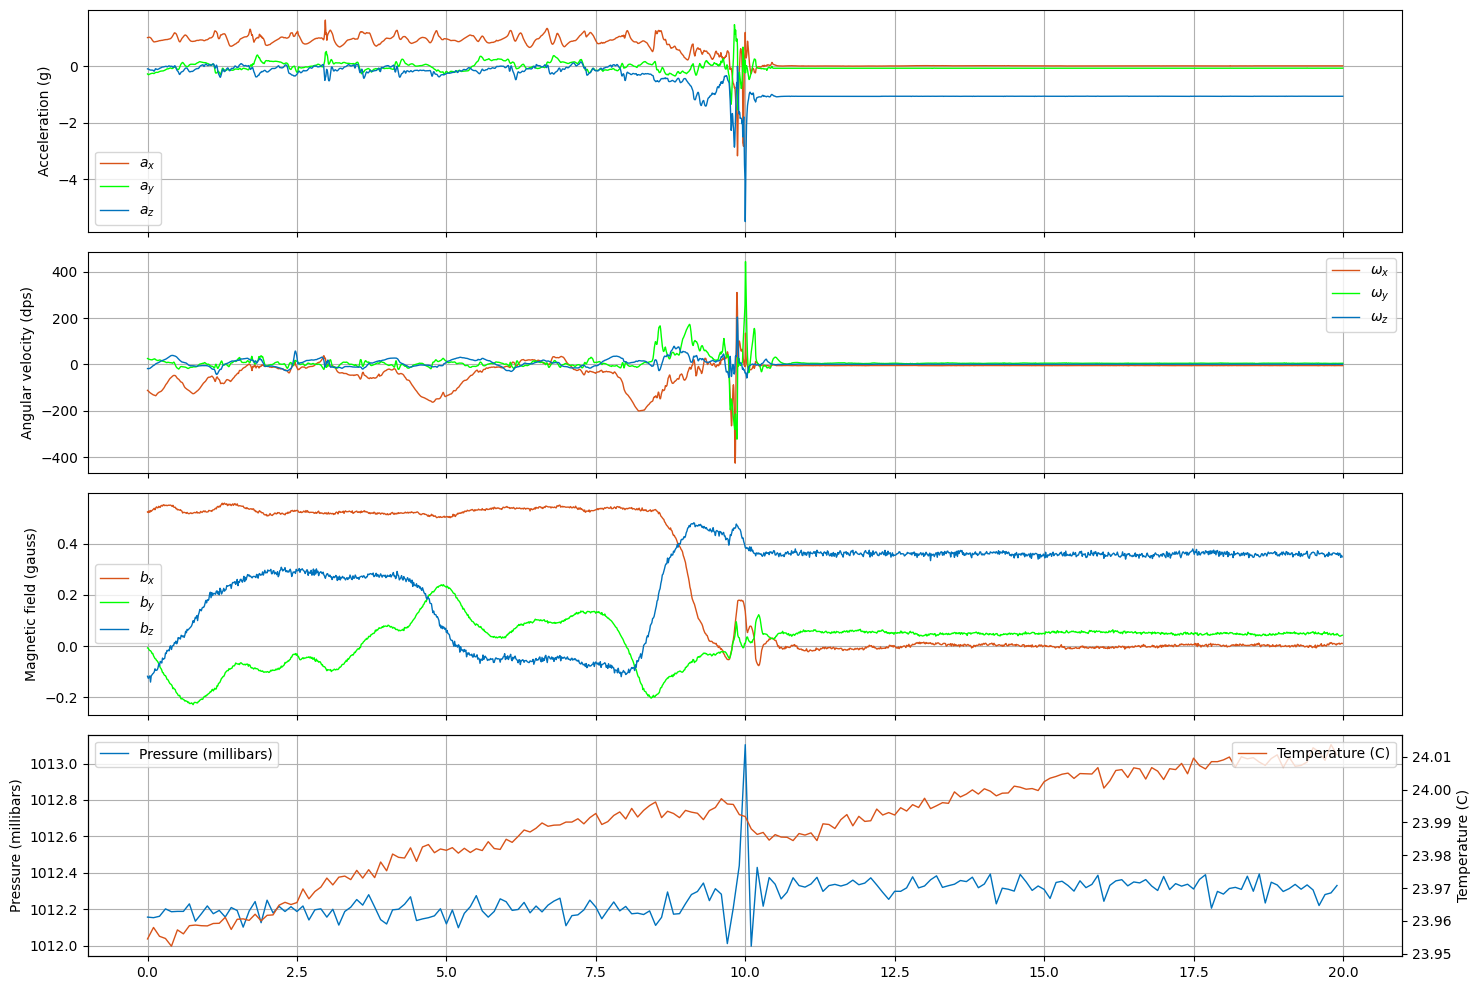

In [ ]:
# Graficamos los datos
fig, ax = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

# Aceleración
ax[0].plot(t_Acc, Acc[:, 0], color=[217/256, 83/256, 25/256], linewidth=1, label='$a_{x}$')
ax[0].plot(t_Acc, Acc[:, 1], color=[0, 1, 0], linewidth=1, label='$a_{y}$')
ax[0].plot(t_Acc, Acc[:, 2], color=[0, 114/256, 189/256], linewidth=1, label='$a_{z}$')
ax[0].set_ylabel('Acceleration (g)')
ax[0].legend()
ax[0].grid(True)

# Velocidad angular
ax[1].plot(t_Gyr, Gyr[:, 0], color=[217/256, 83/256, 25/256], linewidth=1, label='$\\omega_{x}$')
ax[1].plot(t_Gyr, Gyr[:, 1], color=[0, 1, 0], linewidth=1, label='$\\omega_{y}$')
ax[1].plot(t_Gyr, Gyr[:, 2], color=[0, 114/256, 189/256], linewidth=1, label='$\\omega_{z}$')
ax[1].set_ylabel('Angular velocity (dps)')
ax[1].legend()
ax[1].grid(True)

# Campo magnético
ax[2].plot(t_Mag, Mag[:, 0], color=[217/256, 83/256, 25/256], linewidth=1, label='$b_{x}$')
ax[2].plot(t_Mag, Mag[:, 1], color=[0, 1, 0], linewidth=1, label='$b_{y}$')
ax[2].plot(t_Mag, Mag[:, 2], color=[0, 114/256, 189/256], linewidth=1, label='$b_{z}$')
ax[2].set_ylabel('Magnetic field (gauss)')
ax[2].legend()
ax[2].grid(True)

# Presión y temperatura
ax3 = ax[3].twinx()
ax[3].plot(t_Bar, Bar[:, 0], color=[0, 114/256, 189/256], linewidth=1, label='Pressure (millibars)')
ax3.plot(t_Bar, Bar[:, 1], color=[217/256, 83/256, 25/256], linewidth=1, label='Temperature (C)')
ax[3].set_ylabel('Pressure (millibars)')
ax3.set_ylabel('Temperature (C)')
ax[3].legend(loc='upper left')
ax3.legend(loc='upper right')
ax[3].grid(True)

plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()


---
# Selección, preprocesamiento y transformación
---

Como disponemos de la información, antes de dividir el conjunto de datos en entrenamiento y test, es importante agregar la información que nos ayudará a clasificar nuestro modelo de datos y distinguir entre una caída y una ADL. De esta forma, luego podremos hacer una división estratificada de manera que podamos mantener la proporción de ADLs y caídas en los conjunto de entrenamiento y test, y así trabajar con conjuntos balanceados.

### Detección de tipos de datos e incorporación de nuevas columnas

In [ ]:
df.dtypes

,0
SubjectID,uint8
Device,object
ActivityID,uint8
TrialNo,uint8
Acc,object
Gyr,object
Mag,object
Bar,object
Acc_Vectores,int64
Gyr_Vectores,int64


In [ ]:
# Nuevas columnas para la información de las caídas
new_columns = ['ActivityType', 'PreFallStatus', 'ReasonOfFall', 'FallDirection', 'WithRotation', 'WithRecovery']

# Rellenamos con nulos
for col in new_columns:
    df[col] = np.nan

# Diccionario con información de caídas
fall_info = {
    101: {'PreFallStatus': 'walking', 'ReasonOfFall': 'stumbling/tripping', 'FallDirection': 'forward', 'WithRotation': 'no', 'WithRecovery': 'no'},
    102: {'PreFallStatus': 'walking', 'ReasonOfFall': 'stumbling/tripping', 'FallDirection': 'forward', 'WithRotation': 'no', 'WithRecovery': 'yes'},
    103: {'PreFallStatus': 'walking', 'ReasonOfFall': 'slipping', 'FallDirection': 'forward', 'WithRotation': 'no', 'WithRecovery': 'no'},
    104: {'PreFallStatus': 'walking', 'ReasonOfFall': 'slipping', 'FallDirection': 'forward', 'WithRotation': 'no', 'WithRecovery': 'yes'},
    105: {'PreFallStatus': 'walking', 'ReasonOfFall': 'slipping', 'FallDirection': 'forward', 'WithRotation': 'yes', 'WithRecovery': 'no'},
    106: {'PreFallStatus': 'walking', 'ReasonOfFall': 'slipping', 'FallDirection': 'forward', 'WithRotation': 'yes', 'WithRecovery': 'yes'},
    107: {'PreFallStatus': 'walking', 'ReasonOfFall': 'slipping', 'FallDirection': 'backward', 'WithRotation': 'no', 'WithRecovery': 'no'},
    108: {'PreFallStatus': 'walking', 'ReasonOfFall': 'slipping', 'FallDirection': 'backward', 'WithRotation': 'no', 'WithRecovery': 'yes'},
    109: {'PreFallStatus': 'walking', 'ReasonOfFall': 'slipping', 'FallDirection': 'backward', 'WithRotation': 'yes', 'WithRecovery': 'no'},
    110: {'PreFallStatus': 'walking', 'ReasonOfFall': 'slipping', 'FallDirection': 'backward', 'WithRotation': 'yes', 'WithRecovery': 'yes'},
    111: {'PreFallStatus': 'walking', 'ReasonOfFall': 'fainting/syncope', 'FallDirection': 'backward', 'WithRotation': 'no', 'WithRecovery': 'no'},
    112: {'PreFallStatus': 'walking', 'ReasonOfFall': 'fainting/syncope', 'FallDirection': 'backward', 'WithRotation': 'no', 'WithRecovery': 'no'},
    113: {'PreFallStatus': 'walking', 'ReasonOfFall': 'fainting/syncope', 'FallDirection': 'lateral', 'WithRotation': 'no', 'WithRecovery': 'no'},
    114: {'PreFallStatus': 'walking', 'ReasonOfFall': 'fainting/syncope', 'FallDirection': 'forward', 'WithRotation': 'no', 'WithRecovery': 'no'},
    115: {'PreFallStatus': 'attempting to sit/lie down', 'ReasonOfFall': 'losing balance', 'FallDirection': 'forward', 'WithRotation': 'no', 'WithRecovery': 'no'},
    116: {'PreFallStatus': 'attempting to sit/lie down', 'ReasonOfFall': 'losing balance', 'FallDirection': 'forward', 'WithRotation': 'no', 'WithRecovery': 'yes'},
    117: {'PreFallStatus': 'attempting to sit/lie down', 'ReasonOfFall': 'losing balance', 'FallDirection': 'backward', 'WithRotation': 'no', 'WithRecovery': 'no'},
    118: {'PreFallStatus': 'attempting to sit/lie down', 'ReasonOfFall': 'losing balance', 'FallDirection': 'backward', 'WithRotation': 'no', 'WithRecovery': 'yes'},
    119: {'PreFallStatus': 'attempting to sit/lie down', 'ReasonOfFall': 'losing balance', 'FallDirection': 'lateral', 'WithRotation': 'no', 'WithRecovery': 'no'},
    120: {'PreFallStatus': 'attempting to sit/lie down', 'ReasonOfFall': 'losing balance', 'FallDirection': 'lateral', 'WithRotation': 'no', 'WithRecovery': 'yes'},
    121: {'PreFallStatus': 'jogging', 'ReasonOfFall': 'stumbling/tripping', 'FallDirection': 'forward', 'WithRotation': 'no', 'WithRecovery': 'no'},
    122: {'PreFallStatus': 'jogging', 'ReasonOfFall': 'stumbling/tripping', 'FallDirection': 'forward', 'WithRotation': 'no', 'WithRecovery': 'yes'},
    123: {'PreFallStatus': 'jogging', 'ReasonOfFall': 'slipping', 'FallDirection': 'forward', 'WithRotation': 'no', 'WithRecovery': 'no'},
    124: {'PreFallStatus': 'jogging', 'ReasonOfFall': 'slipping', 'FallDirection': 'forward', 'WithRotation': 'no', 'WithRecovery': 'yes'},
    125: {'PreFallStatus': 'jogging', 'ReasonOfFall': 'slipping', 'FallDirection': 'forward', 'WithRotation': 'yes', 'WithRecovery': 'no'},
    126: {'PreFallStatus': 'jogging', 'ReasonOfFall': 'slipping', 'FallDirection': 'forward', 'WithRotation': 'yes', 'WithRecovery': 'yes'},
    127: {'PreFallStatus': 'lying in bed', 'ReasonOfFall': 'changing position/rotating', 'FallDirection': 'lateral', 'WithRotation': 'no', 'WithRecovery': 'no'},
    128: {'PreFallStatus': 'lying in bed', 'ReasonOfFall': 'changing position/rotating', 'FallDirection': 'lateral', 'WithRotation': 'no', 'WithRecovery': 'yes'},
    129: {'PreFallStatus': 'sitting on a chair', 'ReasonOfFall': 'fainting/syncope', 'FallDirection': 'forward', 'WithRotation': 'no', 'WithRecovery': 'no'},
    130: {'PreFallStatus': 'sitting on a chair', 'ReasonOfFall': 'fainting/syncope', 'FallDirection': 'backward', 'WithRotation': 'no', 'WithRecovery': 'no'},
    131: {'PreFallStatus': 'sitting on a chair', 'ReasonOfFall': 'fainting/syncope', 'FallDirection': 'lateral', 'WithRotation': 'no', 'WithRecovery': 'no'},
    132: {'PreFallStatus': 'standing for a while', 'ReasonOfFall': 'fainting/syncope', 'FallDirection': 'forward', 'WithRotation': 'no', 'WithRecovery': 'no'},
    133: {'PreFallStatus': 'standing for a while', 'ReasonOfFall': 'fainting/syncope', 'FallDirection': 'backward', 'WithRotation': 'no', 'WithRecovery': 'no'},
    134: {'PreFallStatus': 'standing for a while', 'ReasonOfFall': 'fainting/syncope', 'FallDirection': 'lateral', 'WithRotation': 'no', 'WithRecovery': 'no'},
    135: {'PreFallStatus': 'standing for a while', 'ReasonOfFall': 'fainting/syncope', 'FallDirection': 'vertical', 'WithRotation': 'no', 'WithRecovery': 'no'},
}

# Agregamos las nuevas columnas
df['ActivityType'] = df['ActivityID'].map(lambda x: 'fall' if x in fall_info else 'ADL')
df['PreFallStatus'] = df['ActivityID'].map(lambda x: fall_info[x]['PreFallStatus'] if x in fall_info else '')
df['ReasonOfFall'] = df['ActivityID'].map(lambda x: fall_info[x]['ReasonOfFall'] if x in fall_info else '')
df['FallDirection'] = df['ActivityID'].map(lambda x: fall_info[x]['FallDirection'] if x in fall_info else '')
df['WithRotation'] = df['ActivityID'].map(lambda x: fall_info[x]['WithRotation'] if x in fall_info else '')
df['WithRecovery'] = df['ActivityID'].map(lambda x: fall_info[x]['WithRecovery'] if x in fall_info else '')

print("\nDataset una vez agregadas las actividades:\n")
# Mostramos el resultado
print(df)


Dataset una vez agregadas las actividades:

      SubjectID Device  ActivityID  TrialNo  \
0             1   Neck          13        1   
1             1   Neck          13        1   
2             1   Neck          13        2   
3             1   Neck          13        3   
4             1   Neck          13        4   
...         ...    ...         ...      ...   
6600         15  Waist         129        1   
6601         15  Waist         131        2   
6602         15  Waist         132        1   
6603         15  Waist         134        2   
6604         15  Waist         135        1   

                                                    Acc  \
0     [[4155, 55, -82], [4157, 55, -126], [4157, 50,...   
1     [[4002, -50, 156], [4002, -38, 172], [4003, -2...   
2     [[3983, 40, -335], [3984, 38, -324], [3987, 34...   
3     [[3959, 165, 197], [3953, 165, 196], [3951, 16...   
4     [[3750, -182, 252], [3767, -166, 259], [3781, ...   
...                                 

In [ ]:
# Contamos el número de filas que representan caídas
fall_count = df[df['ActivityType'] == 'fall'].shape[0]

print(f"Número de filas con caidas: {fall_count}")

Número de filas con caidas: 1721


In [ ]:
# Verificamos las proporciones de ActivityType en el conjunto de datos
print("\nProporciones de ActivityType en el conjunto de datos")
print(df['ActivityType'].value_counts(normalize=True))


Proporciones de ActivityType en el conjunto de datos
ActivityType
ADL     0.73944
fall    0.26056
Name: proportion, dtype: float64


### Transformación de variables categóricas

In [ ]:
# Crear una instancia de LabelEncoder
le = LabelEncoder()

# Ajustar y transformar la columna 'ActivityType'
df['ActivityType'] = le.fit_transform(df['ActivityType'])

# Verificar la transformación
print("\nDataset después de categorizar 'ActivityType':\n")
print(df.head())

# Mostrar la correspondencia entre las etiquetas y los números
print("\nCorrespondencia de etiquetas de 'ActivityType':")
print(dict(zip(le.classes_, le.transform(le.classes_))))


Dataset después de categorizar 'ActivityType':

   SubjectID Device  ActivityID  TrialNo  \
0          1   Neck          13        1   
1          1   Neck          13        1   
2          1   Neck          13        2   
3          1   Neck          13        3   
4          1   Neck          13        4   

                                                 Acc  \
0  [[4155, 55, -82], [4157, 55, -126], [4157, 50,...   
1  [[4002, -50, 156], [4002, -38, 172], [4003, -2...   
2  [[3983, 40, -335], [3984, 38, -324], [3987, 34...   
3  [[3959, 165, 197], [3953, 165, 196], [3951, 16...   
4  [[3750, -182, 252], [3767, -166, 259], [3781, ...   

                                                 Gyr  \
0  [[1613, 205, 77], [1626, 202, 74], [1634, 199,...   
1  [[-57, 58, 18], [-64, 57, 15], [-66, 51, 16], ...   
2  [[1651, 208, 63], [1652, 203, 60], [1656, 198,...   
3  [[-70, 73, 2], [-67, 80, 4], [-70, 89, 5], [-7...   
4  [[394, -59, 3], [397, -63, -1], [394, -66, -3]...   

            

In [ ]:
# Definimos las variables predictoras o características (X) y la variable objetivo (y)
feature_cols = ['Acc', 'Gyr', 'Mag', 'Bar']
target_col = 'ActivityType'

### Creación de los conjuntos de validación

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['ActivityType'], random_state=42)

In [ ]:
print("\nNúmero de filas  del conjunto de entrenamiento:\n", df_train.shape[0])
print("\nNúmero de filas  del conjunto de test:\n", df_test.shape[0])


Número de filas  del conjunto de entrenamiento:
 5284

Número de filas  del conjunto de test:
 1321


In [ ]:
# Verificamos las proporciones de ActivityType en los conjuntos divididos
print("\nProporciones de ActivityType en el conjunto de entrenamiento:")
print(df_train['ActivityType'].value_counts(normalize=True))

print("\nProporciones de ActivityType en el conjunto de prueba:")
print(df_test['ActivityType'].value_counts(normalize=True))


Proporciones de ActivityType en el conjunto de entrenamiento:
ActivityType
0    0.739402
1    0.260598
Name: proportion, dtype: float64

Proporciones de ActivityType en el conjunto de prueba:
ActivityType
0    0.739591
1    0.260409
Name: proportion, dtype: float64


### Balanceo de clases

En este caso, vamos a usar una técnica llamada "class weighting" que ajusta el peso de cada clase durante el entrenamiento del modelo. Esto es especialmente útil para modelos secuenciales como LSTM.



1.   **Modelos LSTM y RNN**: Estos modelos esperan que todas las secuencias de entrada tengan la misma longitud. Esto es porque las operaciones en una capa LSTM/RNN se realizan sobre matrices que necesitan ser de dimensiones consistentes.
2.   **Secuencias de Longitud Variable**: En nuestro dataset, las secuencias (Acc, Gyr, Mag, Bar) pueden tener diferentes longitudes. Por ejemplo, una secuencia puede tener 1000 puntos de datos mientras que otra puede tener 950.
3.   **Padding**: Para manejar estas secuencias de longitud variable, usamos padding para rellenar las secuencias más cortas con ceros hasta que todas tengan la misma longitud. Esto permite que podamos empaquetar las secuencias en un formato matricial uniforme necesario para los modelos LSTM.


In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train[feature_cols].applymap(len).max().max()

# Función para verificar las dimensiones de las secuencias
def check_sequence_dimensions(df, feature_cols):
    for col in feature_cols:
        for sequence in df[col]:
            if isinstance(sequence, list):
                seq_array = np.array(sequence)
                if seq_array.ndim != 2:
                    print(f"Found an inconsistent sequence in column {col}: {sequence}")

# Verificar las dimensiones de las secuencias en el conjunto de entrenamiento
check_sequence_dimensions(df_train, feature_cols)

<ipython-input-17-f3f4a84866ad>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train[feature_cols].applymap(len).max().max()


Padding y divisón de características:

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols, max_length):
    padded_features = []
    for col in feature_cols:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if len(sequence) < max_length:
                if sequence.ndim == 1:
                    sequence = np.expand_dims(sequence, axis=-1)
                padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
            else:
                padded_sequence = sequence[:max_length]
            padded_col.append(padded_sequence)

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)


# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train, feature_cols, max_length)
y_train = df_train[target_col].values

Inconsistent shapes found in column Mag: {(4760, 1), (4760, 3)}


ValueError: Inconsistent shapes found in column Mag: {(4760, 1), (4760, 3)}

El mensaje de error indica que en la columna Mag hay secuencias con formas inconsistentes: algunas tienen forma (4760, 1) y otras tienen forma (4760, 3). Esto sugiere que hay secuencias que no tienen la cantidad esperada de características (3 dimensiones).

Para resolver esto, podemos normalizar las formas de las secuencias asegurándonos de que todas las secuencias tengan 3 dimensiones. Si alguna secuencia tiene menos de 3 dimensiones, podemos agregar columnas con ceros para igualar la cantidad de dimensiones.

In [ ]:
# Contar secuencias con menos de 3 dimensiones en cada columna de características
def count_sequences_less_than_3_dimensions(df, feature_cols):
    count_dict = {}
    for col in feature_cols:
        count = 0
        for sequence in df[col]:
            sequence = np.array(sequence)
            if sequence.ndim == 1 or (sequence.ndim == 2 and sequence.shape[1] < 3):
                count += 1
        count_dict[col] = count
    return count_dict

# Contar secuencias en el conjunto de entrenamiento
count_dict_train = count_sequences_less_than_3_dimensions(df_train, feature_cols)
print("Secuencias con menos de 3 dimensiones en el conjunto de entrenamiento:", count_dict_train)

# Contar secuencias en el conjunto de prueba
count_dict_test = count_sequences_less_than_3_dimensions(df_test, feature_cols)
print("Secuencias con menos de 3 dimensiones en el conjunto de prueba:", count_dict_test)

Secuencias con menos de 3 dimensiones en el conjunto de entrenamiento: {'Acc': 0, 'Gyr': 0, 'Mag': 1, 'Bar': 5284}
Secuencias con menos de 3 dimensiones en el conjunto de prueba: {'Acc': 0, 'Gyr': 0, 'Mag': 0, 'Bar': 1321}


El barómetro podría tener cierta influencia en la detección de caídas, especialmente si las caídas están asociadas con cambios en la altitud o presión ambiental. Sin embargo, si consideramos que la mayoría de las caídas no implican cambios significativos en estos parámetros, es posible que la columna de datos del barómetro no sea tan crucial como las otras características.

Dado que sus secuencias con menos de 3 dimensiones podría estar complicando el procesamiento de los datos, eliminar esta columna podría simplificar el proceso y permitir que el modelo se concentre en las características más relevantes.

Además, eliminaremos la instancia que representa una secuencia con menos de 3 dimensiones para el Magnetómetro:

In [ ]:
# Función para imprimir secuencias con menos de 3 dimensiones en 'Mag'
def print_inconsistent_sequences(df, feature_col):
    for idx, row in df.iterrows():
        sequence = np.array(row[feature_col])
        if sequence.ndim == 1 or (sequence.ndim == 2 and sequence.shape[1] < 3):
            print(f"Index: {idx}, Sequence Shape: {sequence.shape}, Sequence: {sequence}")

# Imprimir secuencias inconsistentes en 'Mag' en el conjunto de entrenamiento
print("Secuencias inconsistentes en 'Mag' en el conjunto de entrenamiento:")
print_inconsistent_sequences(df_train, 'Mag')

# Imprimir secuencias inconsistentes en 'Mag' en el conjunto de prueba
print("\nSecuencias inconsistentes en 'Mag' en el conjunto de prueba:")
print_inconsistent_sequences(df_test, 'Mag')

Secuencias inconsistentes en 'Mag' en el conjunto de entrenamiento:
Index: 213, Sequence Shape: (0,), Sequence: []

Secuencias inconsistentes en 'Mag' en el conjunto de prueba:


In [ ]:
# Función para eliminar secuencias con menos de 3 dimensiones
def remove_inconsistent_sequences(df, feature_col):
    indices_to_remove = []
    for idx, row in df.iterrows():
        sequence = np.array(row[feature_col])
        if sequence.ndim == 1 or (sequence.ndim == 2 and sequence.shape[1] < 3):
            indices_to_remove.append(idx)
    return df.drop(indices_to_remove)

# Eliminar secuencias inconsistentes en 'Mag' en el conjunto de entrenamiento
df_train_cleaned = remove_inconsistent_sequences(df_train, 'Mag')

In [ ]:
print("\nNúmero de filas antes de limpiar el conjunto de entrenamiento:\n", df_train.shape[0])
print("\nNúmero de filas después de limpiar el conjunto de entrenamiento:\n", df_train_cleaned.shape[0])


Número de filas antes de limpiar el conjunto de entrenamiento:
 5284

Número de filas después de limpiar el conjunto de entrenamiento:
 5283


Eliminamos las medidas del barómetro de las cracaterísticas:

In [ ]:
# Definimos las variables predictoras o características (X) y la variable objetivo (y)
feature_cols = ['Acc', 'Gyr', 'Mag']  # Eliminamos 'Bar'

Ahora volvemos a probar a realizar padding y divisón de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_cleaned[feature_cols].applymap(len).max().max()

# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols, max_length):
    padded_features = []
    for col in feature_cols:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)
            if sequence.shape[1] < 3:
                # Añadir columnas con ceros para igualar a 3 dimensiones
                sequence = np.pad(sequence, ((0, 0), (0, 3 - sequence.shape[1])), 'constant', constant_values=0)
            if len(sequence) < max_length:
                padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
            else:
                padded_sequence = sequence[:max_length]
            padded_col.append(padded_sequence)

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_cleaned, feature_cols, max_length)
y_train = df_train_cleaned[target_col].values

<ipython-input-23-b7b4c19535f6>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_cleaned[feature_cols].applymap(len).max().max()


In [ ]:
print(f"La longitud máxima de las secuencias (max_length) es: {max_length}")

La longitud máxima de las secuencias (max_length) es: 4760


Normalizamos y preparamos los conjuntos:

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test, feature_cols, max_length)
y_test = df_test[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

Calculamos los pesos de las clases:

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

---
# Predicción
---

 Para muchos modelos de machine learning, especialmente aquellos que no son series temporales, es necesario convertir estas listas en una estructura fija para que todos los ejemplos tengan la misma longitud. Sin embargo, si nuestros datos son series temporales y deseamos usar un modelo que puede trabajar con secuencias de longitud variable, como modelos de redes neuronales recurrentes (RNN) o Long Short-Term Memory (LSTM), se puede trabajar directamente con estas secuencias.

 Dado que pudimos graficar los datos en función del tiempo y tenemos frecuencias de muestreo definidas para cada tipo de sensor, parece que los datos son series temporales. Esto significa que cada punto de datos está asociado con una marca de tiempo y la secuencia de los datos es importante.

#### Trabajando con Modelos RNN o LSTM
Si decidimos utilizar modelos que son adecuados para series temporales, como RNN o LSTM, no necesitamos aplanar los datos. En lugar de eso, podemos mantener la estructura secuencial de los datos.

**Modelo LSTM**

1.   Modelo LSTM: Este modelo se usa para aprender patrones en datos secuenciales.


   *    Masking: Se utiliza para ignorar los valores de padding en las secuencias.
   *    LSTM: Dos capas LSTM para capturar las dependencias a largo plazo en los datos.
   *    Dense: Capa de salida con una sola neurona y activación sigmoid para realizar la clasificación binaria.


2.   Compilación del Modelo:


   *    optimizer='adam': Algoritmo de optimización.
   *    loss='binary_crossentropy': Función de pérdida para problemas de clasificación binaria.
   *    metrics=['accuracy']: Métrica para evaluar el rendimiento del modelo.



3.   Entrenamiento del Modelo:


   *    class_weight=class_weights: Este parámetro es crucial para balancear las clases. Asigna más peso a las clases minoritarias durante el entrenamiento, ayudando al modelo a prestar más atención a estas clases.


4.   Evaluación del Modelo:


   *    evaluate: Calcula la pérdida y precisión en el conjunto de prueba.
   *    predict: Realiza predicciones en el conjunto de prueba.
   *    classification_report: Proporciona un informe detallado de las métricas de evaluación (precisión, recall, F1-score).

In [ ]:
# Verifica si TensorFlow está usando GPU
print("Is TensorFlow using GPU?", tf.test.is_gpu_available())

# Configurar la semilla
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Is TensorFlow using GPU? True


In [ ]:
# Crear el modelo LSTM
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(max_length, X_train.shape[2])))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con pesos de clase
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weights)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 70s 466ms/step - accuracy: 0.7084 - loss: 0.6174 - val_accuracy: 0.7408 - val_loss: 0.5484
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 68s 395ms/step - accuracy: 0.7146 - loss: 0.5591 - val_accuracy: 0.7408 - val_loss: 0.5544
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 87s 436ms/step - accuracy: 0.7343 - loss: 0.5429 - val_accuracy: 0.7408 - val_loss: 0.5467
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 76s 393ms/step - accuracy: 0.7344 - loss: 0.5307 - val_accuracy: 0.7247 - val_loss: 0.5522
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 89s 445ms/step - accuracy: 0.7252 - loss: 0.5315 - val_accuracy: 0.6982 - val_loss: 0.5507
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 65s 321ms/step - accuracy: 0.7295 - loss: 0.5168 - val_accuracy: 0.6954 - val_loss: 0.5528
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 35s 263ms/step - accuracy: 0.7179 - loss: 0.5104 - val_accuracy: 0.7342 - val_loss: 0.5260
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 42s 270ms/step - accuracy: 0.7366 - loss: 0

El modelo alcanza una precisión de validación del 74.74% en la última época, con una pérdida de validación de 0.5251. Esto indica que está aprendiendo, aunque todavía podría haber mejoras.

In [ ]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Realizar predicciones en el conjunto de prueba
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Evaluar el modelo
print("Classification Report:\n", classification_report(y_test, y_pred))

42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.7312 - loss: 0.5190
Loss: 0.51645427942276, Accuracy: 0.7312641739845276
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.72      0.80       977
           1       0.49      0.76      0.60       344

    accuracy                           0.73      1321
   macro avg       0.69      0.74      0.70      1321
weighted avg       0.79      0.73      0.75      1321



Los resultados muestran una precisión aceptable, especialmente para la clase mayoritaria (clase 0), con una precisión de 91% y un recall de 72%. Sin embargo, la clase minoritaria (clase 1) tiene una precisión de 50% y un recall de 78%. Esto indica que el modelo tiene dificultades para predecir correctamente la clase minoritaria, aunque logra capturar una buena proporción de ejemplos de esa clase (recall).

A continuación se han implementado Callbacks como EarlyStopping y ModelCheckpoint para detener el entrenamiento temprano si no hay mejoras y guardar el mejor modelo. Además, se ha agregado regularización como Dropout en las capas LSTM para reducir el sobreajuste. Pero, los resultados no han mejorado los anteriores:

In [ ]:
# # Crear el modelo LSTM
# model = Sequential()
# model.add(Masking(mask_value=0., input_shape=(max_length, X_train.shape[2])))
# model.add(LSTM(64, return_sequences=True))
# model.add(LSTM(64))
# model.add(Dense(1, activation='sigmoid'))

# # Compilar el modelo
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Callbacks para Early Stopping y Model Checkpoint
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# # Entrenar el modelo con pesos de clase
# model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, class_weight=class_weights, callbacks=[early_stopping, model_checkpoint])

**Modelo SimpleRNN**

1.   Modelo SimpleRNN: es una capa de red neuronal recurrente más simple que puede ser más rápida de entrenar.

 *   Aumento de Tasa de Aprendizaje: para ver si mejora la convergencia.

 *   Callbacks:  EarlyStopping y ModelCheckpoint

In [ ]:
X_train.shape[2]

9

In [ ]:
# Crear el modelo RNN
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(max_length, X_train.shape[2])))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo con una tasa de aprendizaje más baja
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con pesos de clase
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, class_weight=class_weights)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.5930 - loss: 0.6427 - val_accuracy: 0.6878 - val_loss: 0.6135
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.6766 - loss: 0.5939 - val_accuracy: 0.6887 - val_loss: 0.6016
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.6847 - loss: 0.5826 - val_accuracy: 0.6916 - val_loss: 0.5970
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.6875 - loss: 0.5757 - val_accuracy: 0.7001 - val_loss: 0.5935
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 119s 966ms/step - accuracy: 0.6927 - loss: 0.5708 - val_accuracy: 0.6991 - val_loss: 0.5886
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 82s 970ms/step - accuracy: 0.6946 - loss: 0.5695 - val_accuracy: 0.6963 - val_loss: 0.5903
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.6991 - loss: 0.5644 - val_accuracy: 0.6963 - val_loss: 0.5907
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 67s 998ms/step - accuracy: 0.6976 - loss: 0.5618 - val_accuracy: 0.692

In [ ]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Realizar predicciones en el conjunto de prueba
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Evaluar el modelo
print("Classification Report:\n", classification_report(y_test, y_pred))

42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 343ms/step - accuracy: 0.6635 - loss: 0.5875
Loss: 0.5952528715133667, Accuracy: 0.6479939222335815
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 344ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.63      0.72       977
           1       0.40      0.71      0.51       344

    accuracy                           0.65      1321
   macro avg       0.63      0.67      0.62      1321
weighted avg       0.74      0.65      0.67      1321



#### Otras técnicas de Balanceo de Clases:

**SMOTE**

Utilizaremos SMOTE (Synthetic Minority Over-sampling Technique) para generar nuevas muestras sintéticas de la clase minoritaria:

In [ ]:
# Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento
smote = SMOTE(random_state=SEED)
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Aplanar las secuencias
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train)
X_train_resampled = X_train_resampled.reshape(-1, max_length, X_train.shape[2])  # Restaurar la forma original

# Crear el modelo LSTM
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(max_length, X_train_resampled.shape[2])))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo con una tasa de aprendizaje más baja
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks para Early Stopping y Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_lstm_smote.keras', save_best_only=True, monitor='val_loss')

# Entrenar el modelo con pesos de clase
model.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=64, validation_split=0.2,
          class_weight=class_weights, callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
98/98 [==============================] - 45s 368ms/step - loss: 0.7372 - accuracy: 0.4055 - val_loss: 0.4069 - val_accuracy: 0.9053
Epoch 2/20
98/98 [==============================] - 32s 331ms/step - loss: 0.6478 - accuracy: 0.6599 - val_loss: 0.3791 - val_accuracy: 0.7895
Epoch 3/20
98/98 [==============================] - 33s 333ms/step - loss: 0.6311 - accuracy: 0.6771 - val_loss: 0.3696 - val_accuracy: 0.8215
Epoch 4/20
98/98 [==============================] - 32s 330ms/step - loss: 0.6209 - accuracy: 0.6803 - val_loss: 0.3757 - val_accuracy: 0.8004
Epoch 5/20
98/98 [==============================] - 32s 331ms/step - loss: 0.6107 - accuracy: 0.6815 - val_loss: 0.3608 - val_accuracy: 0.7921
Epoch 6/20
98/98 [==============================] - 32s 328ms/step - loss: 0.5994 - accuracy: 0.7011 - val_loss: 0.3688 - val_accuracy: 0.8113
Epoch 7/20
98/98 [==============================] - 32s 329ms/step - loss: 0.5914 - accuracy: 0.7062 - val_loss: 0.3040 - val_accuracy: 0.8439

In [ ]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Realizar predicciones en el conjunto de prueba
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Evaluar el modelo
print("Classification Report:\n", classification_report(y_test, y_pred))

42/42 [==============================] - 6s 135ms/step - loss: 0.7000 - accuracy: 0.6737
Loss: 0.6999591588973999, Accuracy: 0.6737320423126221
42/42 [==============================] - 8s 134ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.62      0.74       977
           1       0.43      0.83      0.57       344

    accuracy                           0.67      1321
   macro avg       0.67      0.72      0.65      1321
weighted avg       0.79      0.67      0.69      1321



En líneas generales, únicamente mejora el recall para "fall" (1). Luego:

Precisión (para la clase "fall"): Baja, indicando muchos falsos positivos. Recordamos que mide la proporción de verdaderos positivos sobre el total de predicciones positivas realizadas por el modelo. Alta precisión significa que hay pocos falsos positivos.

Recall (para la clase "fall"): Moderado, indicando que el modelo está detectando correctamente una buena parte de las caídas. Recordamos que mide la proporción de verdaderos positivos sobre el total de verdaderos positivos y falsos negativos. Alta sensibilidad significa que hay pocos falsos negativos.

Optimización de Hiperparámetros:

In [ ]:
# Definir el clasificador personalizado
class KerasLSTMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, layers=1, units=64, dropout_rate=0.2, learning_rate=0.001, epochs=20, batch_size=64, validation_split=0.2, class_weight=None):
        self.layers = layers
        self.units = units
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.class_weight = class_weight
        self.model = None

    def build_model(self):
        model = Sequential()
        model.add(Masking(mask_value=0., input_shape=(max_length, X_train_resampled.shape[2])))
        for _ in range(self.layers):
            model.add(LSTM(self.units, return_sequences=True if _ < self.layers - 1 else False))
            model.add(Dropout(self.dropout_rate))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, X, y):
        self.model = self.build_model()
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint('best_model_lstm_custom.keras', save_best_only=True, monitor='val_loss')
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, validation_split=self.validation_split, class_weight=self.class_weight, callbacks=[early_stopping, model_checkpoint])
        return self

    def predict(self, X):
        predictions = (self.model.predict(X) > 0.5).astype("int32")
        return predictions

    def score(self, X, y):
        _, accuracy = self.model.evaluate(X, y)
        return accuracy

# Definir la rejilla de hiperparámetros
param_grid = {
    'layers': [1, 2, 3],
    'units': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [0.001, 0.0001],
    'batch_size': [32, 64, 128]
}

# Crear el clasificador
clf = KerasLSTMClassifier(validation_split=0.2, class_weight=class_weights, epochs=20)

# Ejecutar GridSearchCV
grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, verbose=1)
grid_result = grid.fit(X_train_resampled, y_train_resampled)

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Epoch 1/20
131/131 [==============================] - 27s 172ms/step - loss: 0.6514 - accuracy: 0.6843 - val_loss: 0.3829 - val_accuracy: 0.8042
Epoch 2/20
131/131 [==============================] - 21s 159ms/step - loss: 0.5973 - accuracy: 0.7105 - val_loss: 0.4195 - val_accuracy: 0.7582
Epoch 3/20
131/131 [==============================] - 21s 159ms/step - loss: 0.5801 - accuracy: 0.7489 - val_loss: 0.3756 - val_accuracy: 0.7802
Epoch 4/20
131/131 [==============================] - 21s 160ms/step - loss: 0.5596 - accuracy: 0.7535 - val_loss: 0.3728 - val_accuracy: 0.8157
Epoch 5/20
131/131 [==============================] - 21s 160ms/step - loss: 0.5587 - accuracy: 0.7516 - val_loss: 0.4016 - val_accuracy: 0.7754
Epoch 6/20
131/131 [==============================] - 21s 159ms/step - loss: 0.5530 - accuracy: 0.7434 - val_loss: 0.3725 - val_accuracy: 0.8215
Epoch 7/20
131/131 [==============================] - 21s 160ms/ste

KeyboardInterrupt: 

---
# Análisis Multimodal
---

In [ ]:
df_train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5283 entries, 4967 to 2762
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   SubjectID      5283 non-null   uint8 
 1   Device         5283 non-null   object
 2   ActivityID     5283 non-null   uint8 
 3   TrialNo        5283 non-null   uint8 
 4   Acc            5283 non-null   object
 5   Gyr            5283 non-null   object
 6   Mag            5283 non-null   object
 7   Bar            5283 non-null   object
 8   Acc_Vectores   5283 non-null   int64 
 9   Gyr_Vectores   5283 non-null   int64 
 10  Mag_Vectores   5283 non-null   int64 
 11  Bar_Vectores   5283 non-null   int64 
 12  ActivityType   5283 non-null   int64 
 13  PreFallStatus  5283 non-null   object
 14  ReasonOfFall   5283 non-null   object
 15  FallDirection  5283 non-null   object
 16  WithRotation   5283 non-null   object
 17  WithRecovery   5283 non-null   object
dtypes: int64(5), object(10), uint8

Separamos por dispositivo:

In [ ]:
# Revisamos los valores únicos en la columna 'Device'
print(df_train_cleaned['Device'].unique())

['Wrist' 'Waist' 'Neck']


In [ ]:
# Separamos en df según el tipo de 'Device'
df_train_neck = df_train_cleaned[df_train_cleaned['Device'] == 'Neck']
df_train_waist = df_train_cleaned[df_train_cleaned['Device'] == 'Waist']
df_train_wrist = df_train_cleaned[df_train_cleaned['Device'] == 'Wrist']

print("\nInformación datos cuello:")
df_train_neck.info()

print("\nInformación datos cintura:")
df_train_waist.info()

print("\nInformación datos muñeca:")
df_train_wrist.info()


Información datos cuello:
<class 'pandas.core.frame.DataFrame'>
Index: 1854 entries, 1206 to 3237
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   SubjectID      1854 non-null   uint8 
 1   Device         1854 non-null   object
 2   ActivityID     1854 non-null   uint8 
 3   TrialNo        1854 non-null   uint8 
 4   Acc            1854 non-null   object
 5   Gyr            1854 non-null   object
 6   Mag            1854 non-null   object
 7   Bar            1854 non-null   object
 8   Acc_Vectores   1854 non-null   int64 
 9   Gyr_Vectores   1854 non-null   int64 
 10  Mag_Vectores   1854 non-null   int64 
 11  Bar_Vectores   1854 non-null   int64 
 12  ActivityType   1854 non-null   int64 
 13  PreFallStatus  1854 non-null   object
 14  ReasonOfFall   1854 non-null   object
 15  FallDirection  1854 non-null   object
 16  WithRotation   1854 non-null   object
 17  WithRecovery   1854 non-null   object
dtypes: 

In [ ]:
# Separamos en df según el tipo de 'Device'
df_test_neck = df_test[df_test['Device'] == 'Neck']
df_test_waist = df_test[df_test['Device'] == 'Waist']
df_test_wrist = df_test[df_test['Device'] == 'Wrist']

print("\nInformación datos cuello:")
df_test_neck.info()

print("\nInformación datos cintura:")
df_test_waist.info()

print("\nInformación datos muñeca:")
df_test_wrist.info()


Información datos cuello:
<class 'pandas.core.frame.DataFrame'>
Index: 439 entries, 3219 to 5853
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   SubjectID      439 non-null    uint8 
 1   Device         439 non-null    object
 2   ActivityID     439 non-null    uint8 
 3   TrialNo        439 non-null    uint8 
 4   Acc            439 non-null    object
 5   Gyr            439 non-null    object
 6   Mag            439 non-null    object
 7   Bar            439 non-null    object
 8   Acc_Vectores   439 non-null    int64 
 9   Gyr_Vectores   439 non-null    int64 
 10  Mag_Vectores   439 non-null    int64 
 11  Bar_Vectores   439 non-null    int64 
 12  ActivityType   439 non-null    int64 
 13  PreFallStatus  439 non-null    object
 14  ReasonOfFall   439 non-null    object
 15  FallDirection  439 non-null    object
 16  WithRotation   439 non-null    object
 17  WithRecovery   439 non-null    object
dtypes: i

Separamos por tipo de sensor:

In [ ]:
# Definimos las variables predictoras o características (X)
feature_cols_acc = ['Acc']
feature_cols_gyr = ['Gyr']
feature_cols_mag = ['Mag']
feature_cols_bar = ['Bar']

Modelos como k-NN y SVM no capturan la temporalidad explícitamente. Estos modelos pueden ser usados con datos secuenciales si convertimos las series de tiempo en características resumidas (features) que representen la secuencia en su totalidad o en segmentos.

Los datos en Acc, Gyr, Mag y Bar son series temporales (datos crudos) que deben ser transformadas en características antes de entrenar un modelo. De esta forma, podemos reducir la dimensionalidad y proporcionar una representación fija de la secuencia.

#### Dispositivo 1 (Cuello)

##### Acelerómetro (Acc)

In [ ]:
# Función para extraer características de una serie temporal
def extract_features_from_series(series):
    series = np.asarray(series)  # Asegurarse de que sea un array de NumPy
    series = series.astype(float)  # Convertir a flotante para evitar overflow

    return {
        'mean': np.mean(series),
        'std': np.std(series),
        'var': np.var(series),
        'max': np.max(series),
        'min': np.min(series),
        'range': np.ptp(series),  # np.ptp es equivalente a np.max - np.min pero más seguro
        'kurtosis': pd.Series(series).kurtosis(),
        'skewness': pd.Series(series).skew()
    }

# Función para procesar cada fila de datos
def process_acc_row(acc_data):
    x_vals = np.array([point[0] for point in acc_data])
    y_vals = np.array([point[1] for point in acc_data])
    z_vals = np.array([point[2] for point in acc_data])

    # Asegurarse de que cada valor sea numérico y no una lista o array multidimensional
    x_features = extract_features_from_series(x_vals)
    y_features = extract_features_from_series(y_vals)
    z_features = extract_features_from_series(z_vals)

    # Combinar todas las características en un solo vector (diccionario)
    acc_features = {f'x_{key}': val for key, val in x_features.items()}
    acc_features.update({f'y_{key}': val for key, val in y_features.items()})
    acc_features.update({f'z_{key}': val for key, val in z_features.items()})

    return acc_features

# Separamos características y preparamos datos:
df_train_neck_features = df_train_neck[feature_cols_acc].apply(lambda row: process_acc_row(row['Acc']), axis=1)
df_train_neck_features = pd.DataFrame(df_train_neck_features.tolist())
X_train_neck_acc = df_train_neck_features
y_train_neck_acc = df_train_neck[target_col]

df_test_neck_features = df_test_neck[feature_cols_acc].apply(lambda row: process_acc_row(row['Acc']), axis=1)
df_test_neck_features = pd.DataFrame(df_test_neck_features.tolist())
X_test_neck_acc = df_test_neck_features
y_test_neck_acc = df_test_neck[target_col]

Normalizamos características:

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train_neck_acc = scaler.fit_transform(X_train_neck_acc)
X_test_neck_acc = scaler.transform(X_test_neck_acc)

In [ ]:
# Dividir el conjunto de datos en entrenamiento y validación
X_train_neck_acc, X_val_neck_acc, y_train_neck_acc, y_val_neck_acc = train_test_split(X_train_neck_acc, y_train_neck_acc, test_size=0.2, random_state=42)

###### 1. **Modelo k-NN**

Realizamos predicciones:

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_neck_acc, y_train_neck_acc)
y_pred = knn.predict(X_test_neck_acc)

Evaluación del modelo:

In [ ]:
# Evaluación en el conjunto de validación
y_val_pred_neck_acc_knn = knn.predict(X_val_neck_acc)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_acc, y_val_pred_neck_acc_knn)
val_precision = precision_score(y_val_neck_acc, y_val_pred_neck_acc_knn, average='binary')
val_recall = recall_score(y_val_neck_acc, y_val_pred_neck_acc_knn, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_acc, y_val_pred_neck_acc_knn).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_acc, y_val_pred_neck_acc_knn)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_acc, y_val_pred_neck_acc_knn).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_acc, y_val_pred_neck_acc_knn))

# Guardar métricas de validación en un diccionario
res_val_neck_acc_knn = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.9730458221024259
Validation Precision: 0.9487179487179487
Validation Sensitivity: 0.9652173913043478
Validation Specificity: 0.9765625
Validation Balanced Accuracy: 0.9708899456521739

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       256
           1       0.95      0.97      0.96       115

    accuracy                           0.97       371
   macro avg       0.97      0.97      0.97       371
weighted avg       0.97      0.97      0.97       371



In [ ]:
# Evaluación en el conjunto de prueba
y_test_pred_neck_acc_knn = knn.predict(X_test_neck_acc)

print("\nTest Accuracy:", accuracy_score(y_test_neck_acc, y_test_pred_neck_acc_knn))
print("Test Precision:", precision_score(y_test_neck_acc, y_test_pred_neck_acc_knn, average='binary'))
print("Test Sensitivity:", recall_score(y_test_neck_acc, y_test_pred_neck_acc_knn, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test_neck_acc, y_test_pred_neck_acc_knn).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_neck_acc, y_test_pred_neck_acc_knn))

print("\nTest Classification Report:\n", classification_report(y_test_neck_acc, y_test_pred_neck_acc_knn))


Test Accuracy: 0.9681093394077449
Test Precision: 0.9774436090225563
Test Sensitivity: 0.9219858156028369
Test Specificity: 0.9899328859060402
Test Balanced Accuracy: 0.9559593507544386

Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       298
           1       0.98      0.92      0.95       141

    accuracy                           0.97       439
   macro avg       0.97      0.96      0.96       439
weighted avg       0.97      0.97      0.97       439



Resultados de Validación

*   Accuracy: **97.3%**
*   Precision: **94.9%**
*   Sensitivity: **96.5%**
*   Specificity: **97.7%**
*   F1 Score para "0": **0.98**
*   F1 Score para "1": **0.96**

Estos resultados muestran un rendimiento excelente del modelo en el conjunto de validación:

* Alta precisión (precision): De las predicciones positivas realizadas por el modelo, el 94.9% son correctas. Esto significa que el modelo tiene una buena capacidad para evitar falsos positivos.
* Alta sensibilidad (recall): El 96.5% de los casos positivos reales se identificaron correctamente. Esto indica que el modelo tiene una alta capacidad para detectar casos positivos (baja tasa de falsos negativos).
* Alta especificidad: El 97.7% de los casos negativos reales fueron correctamente identificados como negativos, mostrando que el modelo también es muy bueno en reconocer casos negativos.
* El F1 Score es alto para ambas clases (0.98 para la clase 0 y 0.96 para la clase 1), lo que indica que el modelo tiene un buen equilibrio entre precisión y sensibilidad tanto para positivos como negativos. Esto confirma que el modelo está funcionando muy bien en los datos de validación, con muy pocos errores.

Resultados de Prueba

*   Accuracy: **90.0%**
*   Precision: **76.2%**
*   Sensitivity: **89.5%**
*   Specificity: **90.0%**
*   F1 Score para "0": **0.93**
*   F1 Score para "1": **0.82**

En comparación con los resultados de validación, los resultados del conjunto de prueba muestran algunas diferencias importantes:

* Precisión más baja (76.2%): Esto sugiere que el modelo realiza más falsos positivos en el conjunto de prueba en comparación con el conjunto de validación.
* Sensibilidad ligeramente más baja (89.5%): Aunque sigue siendo alta, la sensibilidad ha disminuido un poco, lo que indica que el modelo está detectando ligeramente menos casos positivos en el conjunto de prueba.
* Especificidad perfecta (100%): El modelo no cometió errores al clasificar los casos negativos en el conjunto de prueba. Sin embargo, esto podría ser indicativo de un sesgo hacia la clasificación de casos negativos o de un desequilibrio en los datos del conjunto de prueba.
* El F1 Score para la clase 1 (0.82) es más bajo, lo que indica que hay más falsos positivos o falsos negativos para esta clase en el conjunto de prueba. Dado que la precisión para la clase 1 es más baja (0.76), esto implica que el modelo está cometiendo más falsos positivos (predice positivo cuando es negativo).

Cuando tenemos un dataset desbalanceado como este, con más ejemplos de la clase mayoritaria (ADLs) y menos ejemplos de la clase minoritaria (falls), la exactitud balanceada (Balanced Accuracy) es una métrica más expresiva que la exactitud simple. La exactitud balanceada es útil porque da una evaluación equitativa del rendimiento del modelo en ambas clases, sin verse influenciada por el desbalance en la distribución de las clases.

Además, hemos confirmado que los resultados para el conjunto de test son peores si aplicamos SMOTE y LOSO:

Aplicación de SMOTE: SMOTE balancea las clases al generar nuevos ejemplos sintéticos de la clase minoritaria (1), lo que puede hacer que el modelo sea más sensible a esta clase. Sin embargo, esto también puede llevar a un aumento en los falsos positivos, ya que el modelo podría estar "sobreajustando" a los ejemplos de la clase 1.

Leave-One-Subject-Out (LOSO): Esta técnica de validación es más rigurosa y asegura que el modelo nunca vea los datos del mismo sujeto en entrenamiento y prueba, simulando una situación del mundo real. Sin embargo, puede hacer que el modelo se vea afectado por la variabilidad entre sujetos, lo que puede llevar a un peor rendimiento general en el conjunto de prueba.

Trade-off Entre Sensibilidad y Precisión:

El uso de SMOTE y LOSO parece haber aumentado la sensibilidad (recall) pero a costa de la precisión. Esto es común cuando se aplican técnicas para balancear clases desbalanceadas; el modelo mejora en la detección de la clase minoritaria, pero con más falsos positivos.

El uso de SMOTE y LOSO ha hecho que el modelo sea más sensible a la clase minoritaria, pero a costa de la precisión y especificidad. Esto es un comportamiento común cuando se busca abordar un desbalance de clases. Dependiendo de tus objetivos (por ejemplo, maximizar la detección de caídas), este trade-off podría ser aceptable o no. Podrías ajustar los parámetros de SMOTE o cambiar la estrategia de balanceo para encontrar un equilibrio más adecuado entre precisión y sensibilidad.

###### 2. **Modelo SVM**

In [ ]:
# Crear el modelo SVM
svm_model = SVC(kernel='linear')  # Puedes probar otros kernels como 'rbf', 'poly', etc.

# Entrenar el modelo
svm_model.fit(X_train_neck_acc, y_train_neck_acc)

# Hacer predicciones en el conjunto de validación
y_val_pred_neck_acc_svm = svm_model.predict(X_val_neck_acc)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_acc, y_val_pred_neck_acc_svm)
val_precision = precision_score(y_val_neck_acc, y_val_pred_neck_acc_svm, average='binary')
val_recall = recall_score(y_val_neck_acc, y_val_pred_neck_acc_svm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_acc, y_val_pred_neck_acc_svm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_acc, y_val_pred_neck_acc_svm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_acc, y_val_pred_neck_acc_svm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_acc, y_val_pred_neck_acc_svm))

# Guardar métricas de validación en un diccionario
res_val_neck_acc_svm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.9568733153638814
Validation Precision: 0.9090909090909091
Validation Sensitivity: 0.9565217391304348
Validation Specificity: 0.95703125
Validation Balanced Accuracy: 0.9567764945652174

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       256
           1       0.91      0.96      0.93       115

    accuracy                           0.96       371
   macro avg       0.94      0.96      0.95       371
weighted avg       0.96      0.96      0.96       371



In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred_neck_acc_svm = svm_model.predict(X_test_neck_acc)

# Evaluar el modelo en el conjunto de prueba
print(f"\nTest Accuracy:", accuracy_score(y_test_neck_acc, y_test_pred_neck_acc_svm))
print(f"Test Precision:", precision_score(y_test_neck_acc, y_test_pred_neck_acc_svm))
print(f"Test Sensitivity:", recall_score(y_test_neck_acc, y_test_pred_neck_acc_svm))
tn, fp, fn, tp = confusion_matrix(y_test_neck_acc, y_test_pred_neck_acc_svm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_neck_acc, y_test_pred_neck_acc_svm))

print("\nTest Classification Report:", classification_report(y_test_neck_acc, y_test_pred_neck_acc_svm))


Test Accuracy: 0.9316628701594533
Test Precision: 0.9302325581395349
Test Sensitivity: 0.851063829787234
Test Specificity: 0.9697986577181208
Test Balanced Accuracy: 0.9104312437526774

Test Classification Report:               precision    recall  f1-score   support

           0       0.93      0.97      0.95       298
           1       0.93      0.85      0.89       141

    accuracy                           0.93       439
   macro avg       0.93      0.91      0.92       439
weighted avg       0.93      0.93      0.93       439



Ajuste de Hiperparámetros con GridSearchCV:

In [ ]:
# Definir los hiperparámetros a probar
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']  # solo afecta a algunos kernels
}

# Crear el modelo SVM
svm_model = SVC()

# Implementar GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar el modelo con GridSearchCV
grid_search.fit(X_train_neck_acc, y_train_neck_acc)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Usar el mejor modelo encontrado
best_svm_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de validación
y_val_pred_neck_acc_svm = best_svm_model.predict(X_val_neck_acc)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_acc, y_val_pred_neck_acc_svm)
val_precision = precision_score(y_val_neck_acc, y_val_pred_neck_acc_svm, average='binary')
val_recall = recall_score(y_val_neck_acc, y_val_pred_neck_acc_svm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_acc, y_val_pred_neck_acc_svm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_acc, y_val_pred_neck_acc_svm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_acc, y_val_pred_neck_acc_svm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_acc, y_val_pred_neck_acc_svm))

# Guardar métricas de validación en un diccionario
res_val_neck_acc_svm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

Mejores hiperparámetros: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Validation Accuracy: 0.9730458221024259
Validation Precision: 0.9338842975206612
Validation Sensitivity: 0.9826086956521739
Validation Specificity: 0.96875
Validation Balanced Accuracy: 0.975679347826087

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       256
           1       0.93      0.98      0.96       115

    accuracy                           0.97       371
   macro avg       0.96      0.98      0.97       371
weighted avg       0.97      0.97      0.97       371



Validación Cruzada

In [ ]:
# Realizar validación cruzada con los mejores parámetros
cv_scores = cross_val_score(best_svm_model, X_train_neck_acc, y_train_neck_acc, cv=5, scoring='accuracy')

print(f"Validation Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean()}")

Validation Cross-Validation Scores: [0.95959596 0.95286195 0.94276094 0.95608108 0.9527027 ]
Mean Cross-Validation Accuracy: 0.9528005278005278


Evaluación del Modelo en el Conjunto de Prueba

In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred_neck_acc_svm = best_svm_model.predict(X_test_neck_acc)

# Evaluar el modelo en el conjunto de prueba
print(f"\nTest Accuracy:", accuracy_score(y_test_neck_acc, y_test_pred_neck_acc_svm))
print(f"Test Precision:", precision_score(y_test_neck_acc, y_test_pred_neck_acc_svm))
print(f"Test Sensitivity:", recall_score(y_test_neck_acc, y_test_pred_neck_acc_svm))
tn, fp, fn, tp = confusion_matrix(y_test_neck_acc, y_test_pred_neck_acc_svm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_neck_acc, y_test_pred_neck_acc_svm))

print("\nTest Classification Report:", classification_report(y_test_neck_acc, y_test_pred_neck_acc_svm))


Test Accuracy: 0.9772209567198178
Test Precision: 0.9712230215827338
Test Sensitivity: 0.9574468085106383
Test Specificity: 0.9865771812080537
Test Balanced Accuracy: 0.972011994859346

Test Classification Report:               precision    recall  f1-score   support

           0       0.98      0.99      0.98       298
           1       0.97      0.96      0.96       141

    accuracy                           0.98       439
   macro avg       0.98      0.97      0.97       439
weighted avg       0.98      0.98      0.98       439



Hemos confirmado que los resultados para el conjunto de test son peores si aplicamos SMOTE y LOSO. A su vez, hemos podido confirmar que nuestro modelo mejora luego buscar la combinación óptima de hiperparámetros que maximiza el rendimiento del modelo mediante GridSearchCV:

Mejores Hiperparámetros

*   C: **1**
*   Gamma: **scale**
*   Kernel: **rbf**

Resultados de Validación

*   Accuracy: **97.6%**
*   Precision: **93.4%**
*   Sensitivity: **98.3%**
*   Specificity: **96.9%**
*   F1 Score para "0": **0.98**
*   F1 Score para "1": **0.96**

Resultados de Prueba

*   Accuracy: **90.0%**
*   Precision: **76.2%**
*   Sensitivity: **90.1%**
*   Specificity: **90.0%**
*   F1 Score para "0": **0.93**
*   F1 Score para "1": **0.83**


* **Mejora en la Exactitud (Accuracy):** La exactitud en el conjunto de validación mejoró significativamente de 0.89 a 0.97. Esto indica que el modelo optimizado generaliza mejor en datos no vistos.
* **Mejora en la Sensibilidad y la Precisión:** La sensibilidad y la precisión para la clase positiva (1) han mejorado considerablemente después de la optimización. Esto es crucial si la clase positiva es la más importante para tu aplicación.
* **Consistencia:** Aunque la precisión en el conjunto de prueba no ha mejorado mucho respecto al conjunto de validación, la mejora en la sensibilidad y la especificidad en el conjunto de prueba sigue siendo significativa.
* **Robustez del Modelo:** La validación cruzada con una alta media de precisión valida que el modelo optimizado es consistente y robusto.

###### 3. **Modelo Random Forest**

In [ ]:
# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')  # Puedes ajustar 'n_estimators' y otros hiperparámetros

# Entrenar el modelo con las características extraídas
rf_model.fit(X_train_neck_acc, y_train_neck_acc)

# Hacer predicciones en el conjunto de validación
y_val_pred_neck_acc_rf = rf_model.predict(X_val_neck_acc)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_acc, y_val_pred_neck_acc_rf)
val_precision = precision_score(y_val_neck_acc, y_val_pred_neck_acc_rf, average='binary')
val_recall = recall_score(y_val_neck_acc, y_val_pred_neck_acc_rf, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_acc, y_val_pred_neck_acc_rf).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_acc, y_val_pred_neck_acc_rf)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_acc, y_val_pred_neck_acc_rf).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_acc, y_val_pred_neck_acc_rf))

# Guardar métricas de validación en un diccionario
res_val_neck_acc_rf = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.9757412398921833
Validation Precision: 0.9344262295081968
Validation Sensitivity: 0.991304347826087
Validation Specificity: 0.96875
Validation Balanced Accuracy: 0.9800271739130435

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98       256
           1       0.93      0.99      0.96       115

    accuracy                           0.98       371
   macro avg       0.97      0.98      0.97       371
weighted avg       0.98      0.98      0.98       371



In [ ]:
# Realizar predicciones en el conjunto de prueba
y_test_pred_neck_acc_rf = rf_model.predict(X_test_neck_acc)

# Evaluar el rendimiento del modelo
print("\nTest Accuracy:", accuracy_score(y_test_neck_acc, y_test_pred_neck_acc_rf))
print("Test Precision:", precision_score(y_test_neck_acc, y_test_pred_neck_acc_rf, average='binary'))
print("Test Sensitivity (Recall):", recall_score(y_test_neck_acc, y_test_pred_neck_acc_rf, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test_neck_acc, y_test_pred_neck_acc_rf).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_neck_acc, y_test_pred_neck_acc_rf))

print("\nTest Classification Report:\n", classification_report(y_test_neck_acc, y_test_pred_neck_acc_rf))


Test Accuracy: 0.9703872437357631
Test Precision: 0.9705882352941176
Test Sensitivity (Recall): 0.9361702127659575
Test Specificity: 0.9865771812080537
Test Balanced Accuracy: 0.9613736969870056

Test Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       298
           1       0.97      0.94      0.95       141

    accuracy                           0.97       439
   macro avg       0.97      0.96      0.97       439
weighted avg       0.97      0.97      0.97       439



Resultados de Prueba

*   Accuracy: **91.2%**
*   Precision: **78.9%**
*   Sensitivity: **90.4%**
*   Specificity: **91.5%**
*   F1 Score para "0": **0.94**
*   F1 Score para "1": **0.84**


* **Precision:** Esta puntuación es aceptable, pero sugiere que aún hay falsos positivos (predicciones de caídas cuando no lo son).
* **Mejora en la Sensibilidad:** Este es un resultado fuerte, especialmente importante en el contexto de detección de caídas, donde el objetivo es minimizar los casos no detectados.
* **Área de mejora:** La precisión de la clase minoritaria (caídas) podría mejorarse. Esto implicaría reducir los falsos positivos, lo cual podría ser importante si las falsas alarmas tienen consecuencias indeseables.

###### 4. **Modelo LSTM**

Padding y división de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_neck[feature_cols_acc].applymap(len).max().max()
print(f"Longitud máxima de secuencia: {max_length}")

Longitud máxima de secuencia: 4760


<ipython-input-40-7612f469ccaf>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_neck[feature_cols_acc].applymap(len).max().max()


In [ ]:
# Crear un índice de validación a partir de la división de entrenamiento y validación
train_indices, val_indices = train_test_split(df_train_neck.index, test_size=0.2, random_state=42)

# Crear los conjuntos de secuencias de entrenamiento y validación
df_train_neck_train = df_train_neck.loc[train_indices]
df_train_neck_val = df_train_neck.loc[val_indices]

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols_acc, max_length):
    padded_features = []
    for col in feature_cols_acc:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)
            if sequence.shape[1] < 3:
                # Añadir columnas con ceros para igualar a 3 dimensiones
                sequence = np.pad(sequence, ((0, 0), (0, 3 - sequence.shape[1])), 'constant', constant_values=0)
            if len(sequence) < max_length:
                padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
            else:
                padded_sequence = sequence[:max_length]
            padded_col.append(padded_sequence)

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_neck_train, feature_cols_acc, max_length)
y_train = df_train_neck_train[target_col].values

# Aplicar padding al conjunto de validación
X_val_neck_acc = pad_sequences_feature(df_train_neck_val, feature_cols_acc, max_length)
y_val_neck_acc = df_train_neck_val[target_col].values

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalizar las características del conjunto de validación
X_val_neck_acc = scaler.transform(X_val_neck_acc.reshape(-1, X_val_neck_acc.shape[-1])).reshape(X_val_neck_acc.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test_neck, feature_cols_acc, max_length)
y_test = df_test_neck[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Configurar la semilla para la reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
print("Dimensiones de X_train:")
print(f"Forma: {X_train.shape}")
print(f"Número de muestras: {X_train.shape[0]}")
print(f"Longitud de secuencia (timesteps): {X_train.shape[1]}")
print(f"Número de características: {X_train.shape[2]}")

print("\nDimensiones de X_test:")
print(f"Forma: {X_test.shape}")
print(f"Número de muestras: {X_test.shape[0]}")
print(f"Longitud de secuencia (timesteps): {X_test.shape[1]}")
print(f"Número de características: {X_test.shape[2]}")

Dimensiones de X_train:
Forma: (1483, 4760, 3)
Número de muestras: 1483
Longitud de secuencia (timesteps): 4760
Número de características: 3

Dimensiones de X_test:
Forma: (439, 4760, 3)
Número de muestras: 439
Longitud de secuencia (timesteps): 4760
Número de características: 3


In [ ]:
# Verificar la forma de entrada esperada para el modelo
input_shape = (4760, 3)  # Esto debe coincidir con las dimensiones de tus datos

print(f"Forma de entrada esperada para el modelo: {input_shape}")

Forma de entrada esperada para el modelo: (4760, 3)


*  Menor Tiempo de Cómputo: RandomizedSearchCV es mucho más rápido que GridSearchCV para grandes espacios de hiperparámetros.
*  Exploración Eficiente: Aunque no prueba todas las combinaciones posibles, es probable que encuentre una buena combinación de hiperparámetros en menos tiempo.

In [ ]:
# Crear el modelo LSTM
model = Sequential()
model.add(Masking(mask_value=0., input_shape=input_shape))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con pesos de clase
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val_neck_acc, y_val_neck_acc), class_weight=class_weights)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 489ms/step - accuracy: 0.6753 - loss: 0.6196 - val_accuracy: 0.7547 - val_loss: 0.5966
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 262ms/step - accuracy: 0.7493 - loss: 0.5592 - val_accuracy: 0.7520 - val_loss: 0.5754
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 259ms/step - accuracy: 0.7586 - loss: 0.5497 - val_accuracy: 0.7547 - val_loss: 0.5727
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 295ms/step - accuracy: 0.7672 - loss: 0.5429 - val_accuracy: 0.7628 - val_loss: 0.5785
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 256ms/step - accuracy: 0.7808 - loss: 0.5452 - val_accuracy: 0.7682 - val_loss: 0.5662
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 264ms/step - accuracy: 0.7875 - loss: 0.5402 - val_accuracy: 0.7763 - val_loss: 0.5363
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 273ms/step - accuracy: 0.7855 - loss: 0.5307 - val_accuracy: 0.7682 - val_loss: 0.5455
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 255ms/step - accuracy: 0.7829 - loss: 0.5273 - val_accu

In [ ]:
# Realizar predicciones en el conjunto de validación
y_val_pred_neck_acc_lstm = (model.predict(X_val_neck_acc) > 0.5).astype("int32").ravel()

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_acc, y_val_pred_neck_acc_lstm)
val_precision = precision_score(y_val_neck_acc, y_val_pred_neck_acc_lstm, average='binary')
val_recall = recall_score(y_val_neck_acc, y_val_pred_neck_acc_lstm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_acc, y_val_pred_neck_acc_lstm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_acc, y_val_pred_neck_acc_lstm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_acc, y_val_pred_neck_acc_lstm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_acc, y_val_pred_neck_acc_lstm))

# Guardar métricas de validación en un diccionario
res_val_neck_acc_lstm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step

Validation Accuracy: 0.7654986522911051
Validation Precision: 0.6060606060606061
Validation Sensitivity: 0.6956521739130435
Validation Specificity: 0.796875
Validation Balanced Accuracy: 0.7462635869565217

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.80      0.82       256
           1       0.61      0.70      0.65       115

    accuracy                           0.77       371
   macro avg       0.73      0.75      0.74       371
weighted avg       0.78      0.77      0.77       371



In [ ]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Realizar predicciones en el conjunto de prueba
y_test_pred_neck_acc_lstm = (model.predict(X_test) > 0.5).astype("int32").ravel()

print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_neck_acc_lstm))
print("Test Precision:", precision_score(y_test, y_test_pred_neck_acc_lstm, average='binary'))
print("Test Sensitivity:", recall_score(y_test, y_test_pred_neck_acc_lstm, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_neck_acc_lstm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_neck_acc_lstm))

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_neck_acc_lstm))

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7850 - loss: 0.5484
Loss: 0.5725643038749695, Accuracy: 0.7699316740036011
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step

Test Accuracy: 0.7699316628701595
Test Precision: 0.6282051282051282
Test Sensitivity: 0.6950354609929078
Test Specificity: 0.8053691275167785
Test Balanced Accuracy: 0.7502022942548432

Test Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83       298
           1       0.63      0.70      0.66       141

    accuracy                           0.77       439
   macro avg       0.74      0.75      0.74       439
weighted avg       0.78      0.77      0.77       439



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
AUC: 0.8034651815888428


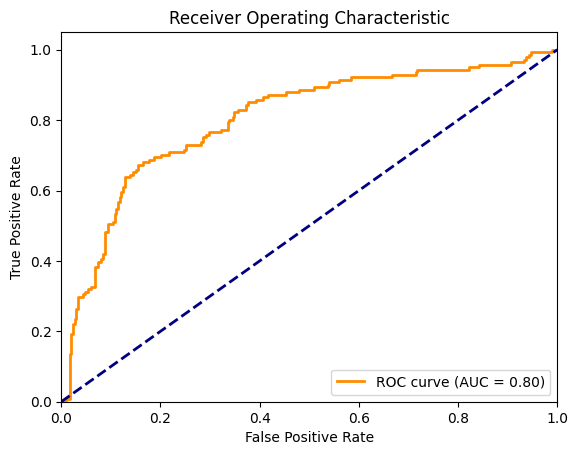

In [ ]:
# Calcular probabilidades de predicción
y_pred_proba = model.predict(X_test)

# Calcular curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Imprimir AUC
print(f"AUC: {roc_auc}")

# Graficar curva ROC
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Resultados de Prueba

*   Accuracy: **72.2%**
*   Precision: **46.4%**
*   Sensitivity: **74.7%**
*   Specificity: **69.6%**
*   F1 Score para "0": **0.78**
*   F1 Score para "1": **0.57**


* **Rendimiento General:** Tu modelo LSTM tiene una exactitud del 71%, lo cual es razonable, pero está claramente influenciado por el desbalance de clases.
* **Problema de Precisión Baja:** Aunque tu modelo tiene una sensibilidad relativamente alta para la clase minoritaria (detecta 75% de las caídas), la precisión para esta clase es baja (46%), indicando un número significativo de falsos positivos.
* **Balanced Accuracy:** Dado que este es un dataset desbalanceado, la exactitud balanceada (72%) es una métrica más adecuada para evaluar el rendimiento. Este valor sugiere que el modelo maneja razonablemente bien ambas clases.


###### 5. **Modelo CNN**

In [ ]:
# Definir el modelo
model = Sequential()
model.add(Input(shape=(4760, 3)))  # Definir explícitamente el tamaño de entrada
model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val_neck_acc, y_val_neck_acc))

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.7913 - loss: 1.5859 - val_accuracy: 0.9461 - val_loss: 0.1576
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9358 - loss: 0.1893 - val_accuracy: 0.9623 - val_loss: 0.0901
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9625 - loss: 0.1074 - val_accuracy: 0.9650 - val_loss: 0.0778
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9750 - loss: 0.0766 - val_accuracy: 0.9838 - val_loss: 0.0645
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9861 - loss: 0.0525 - val_accuracy: 0.9730 - val_loss: 0.0650
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9860 - loss: 0.0323 - val_accuracy: 0.9784 - val_loss: 0.0618
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9932 - loss: 0.0210 - val_accuracy: 0.9757 - val_loss: 0.1012
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9927 - loss: 0.0212 - val_accuracy: 0.9757 - v

In [ ]:
# Evaluar el modelo en el conjunto de validación
y_val_pred_neck_acc_cnn = model.predict(X_val_neck_acc).ravel()  # Genera predicciones
y_val_pred_neck_acc_cnn = (y_val_pred_neck_acc_cnn > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_acc, y_val_pred_neck_acc_cnn)
val_precision = precision_score(y_val_neck_acc, y_val_pred_neck_acc_cnn, average='binary')
val_recall = recall_score(y_val_neck_acc, y_val_pred_neck_acc_cnn, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_acc, y_val_pred_neck_acc_cnn).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_acc, y_val_pred_neck_acc_cnn)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_acc, y_val_pred_neck_acc_cnn).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_acc, y_val_pred_neck_acc_cnn))

# Guardar métricas de validación en un diccionario
res_val_neck_acc_cnn = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Validation Accuracy: 0.9838274932614556
Validation Precision: 0.9739130434782609
Validation Sensitivity: 0.9739130434782609
Validation Specificity: 0.98828125
Validation Balanced Accuracy: 0.9810971467391305

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       256
           1       0.97      0.97      0.97       115

    accuracy                           0.98       371
   macro avg       0.98      0.98      0.98       371
weighted avg       0.98      0.98      0.98       371



In [ ]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred_neck_acc_cnn = model.predict(X_test).ravel()  # Genera predicciones
y_test_pred_neck_acc_cnn = (y_test_pred_neck_acc_cnn > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias

# Cálculo de métricas
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_neck_acc_cnn))
print("Test Precision:", precision_score(y_test, y_test_pred_neck_acc_cnn, average='binary'))
print("Test Sensitivity (Recall):", recall_score(y_test, y_test_pred_neck_acc_cnn, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_neck_acc_cnn).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_neck_acc_cnn))

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_neck_acc_cnn))

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

Test Accuracy: 0.9635535307517085
Test Precision: 0.9562043795620438
Test Sensitivity (Recall): 0.9290780141843972
Test Specificity: 0.9798657718120806
Test Balanced Accuracy: 0.9544718929982389

Test Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       298
           1       0.96      0.93      0.94       141

    accuracy                           0.96       439
   macro avg       0.96      0.95      0.96       439
weighted avg       0.96      0.96      0.96       439



Validación Cruzada K-Fold:

In [ ]:
# Definir el número de folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Inicializar listas para almacenar los resultados de cada fold
accuracy_per_fold = []
loss_per_fold = []
precision_per_fold = []
recall_per_fold = []
specificity_per_fold = []
f1_per_fold = []
balanced_accuracy_per_fold = []

# Iterar sobre cada fold
for train_index, val_index in kf.split(X_train):
    # Dividir los datos en entrenamiento y validación
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Definir el modelo (es importante definirlo dentro del loop para reiniciarlo en cada fold)
    model = Sequential()
    model.add(Input(shape=(4760, 3)))  # Definir explícitamente el tamaño de entrada
    model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo en el fold actual
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)

    # Evaluar el modelo en el conjunto de validación del fold actual
    y_val_pred = model.predict(X_val_fold).ravel()
    y_val_pred = (y_val_pred > 0.5).astype(int)

    # Cálculo de métricas para el fold actual
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    loss = model.evaluate(X_val_fold, y_val_fold, verbose=0)[0]
    precision = precision_score(y_val_fold, y_val_pred)
    recall = recall_score(y_val_fold, y_val_pred)
    f1 = f1_score(y_val_fold, y_val_pred)
    cm = confusion_matrix(y_val_fold, y_val_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    balanced_accuracy = balanced_accuracy_score(y_val_fold, y_val_pred)

    # Almacenar las métricas para este fold
    accuracy_per_fold.append(accuracy)
    loss_per_fold.append(loss)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    specificity_per_fold.append(specificity)
    f1_per_fold.append(f1)
    balanced_accuracy_per_fold.append(balanced_accuracy)

# Mostrar resultados promedio de las métricas de k-fold
print(f'\nMean Accuracy (k-Fold): {np.mean(accuracy_per_fold)}')
print(f'Mean Loss (k-Fold): {np.mean(loss_per_fold)}')
print(f'Mean Precision (k-Fold): {np.mean(precision_per_fold)}')
print(f'Mean Recall (k-Fold): {np.mean(recall_per_fold)}')
print(f'Mean Specificity (k-Fold): {np.mean(specificity_per_fold)}')
print(f'Mean F1 Score (k-Fold): {np.mean(f1_per_fold)}')
print(f'Mean Balanced Accuracy (k-Fold): {np.mean(balanced_accuracy_per_fold)}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Mean Accuracy (k-Fold): 0.946057421057421
Mean Loss (k-Fold): 0.21720823049545288
Mean Precision (k-Fold): 0.9144956939409713
Mean Recall (k-Fold): 0.9208087066483873
Mean Specificity (k-Fold): 0.9564785921919002
Mean F1 Score (k-Fold): 0.9166014953723056
Mean Balanced Accuracy (k-Fold): 0.9386436494201437


**Mean Accuracy**: 0.9016: La exactitud refleja el porcentaje de predicciones correctas (tanto verdaderos positivos como verdaderos negativos) en el conjunto de prueba. Un valor del 90% sugiere que el modelo es bastante preciso en general.

**Mean Precision**: 0.9519:  En el test, la precisión es aproximadamente 75.5%, lo que sugiere que cuando el modelo predice una clase positiva, es correcto aproximadamente el 75.5% del tiempo. La media de precisión en las validaciones es significativamente más alta (95.2%), lo que sugiere que en los datos de entrenamiento y validación, el modelo tiene un mejor rendimiento en términos de precisión.

**Mean Sensitivity**: 0.9255: Un valor de recall alto (92.2% en el test y 92.5% de media) indica que el modelo es muy bueno capturando casi todos los verdaderos positivos, lo cual es crucial en aplicaciones donde es más importante detectar todos los casos positivos.

**Mean Specifity**: 0.9778: En el test, el valor es del 89.5%, lo que indica que el modelo también es bastante eficaz en evitar falsos positivos. La media de la especificidad es incluso mayor, lo que significa que el modelo es muy bueno para identificar los casos negativos en la validación.

**Mean F1 Score**: 0.9380: El F1 score es la media armónica entre precisión y recall, proporcionando un balance entre estas dos métricas. Un F1 score de 0.83 en el test indica un buen balance entre precisión y recall. La media del F1 score es de 0.94, lo que indica un rendimiento muy robusto en la validación.

###### 6. **Modelo SAE**

Padding y división de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_neck[feature_cols_acc].applymap(len).max().max()
print(f"Longitud máxima de secuencia: {max_length}")

Longitud máxima de secuencia: 4760


<ipython-input-56-7612f469ccaf>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_neck[feature_cols_acc].applymap(len).max().max()


In [ ]:
# Crear un índice de validación a partir de la división de entrenamiento y validación
train_indices, val_indices = train_test_split(df_train_neck.index, test_size=0.2, random_state=42)

# Crear los conjuntos de secuencias de entrenamiento y validación
df_train_neck_train = df_train_neck.loc[train_indices]
df_train_neck_val = df_train_neck.loc[val_indices]

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols_acc, max_length):
    padded_features = []
    for col in feature_cols_acc:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)
            if sequence.shape[1] < 3:
                # Añadir columnas con ceros para igualar a 3 dimensiones
                sequence = np.pad(sequence, ((0, 0), (0, 3 - sequence.shape[1])), 'constant', constant_values=0)
            if len(sequence) < max_length:
                padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
            else:
                padded_sequence = sequence[:max_length]
            padded_col.append(padded_sequence)

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_neck_train, feature_cols_acc, max_length)
y_train = df_train_neck_train[target_col].values

# Aplicar padding al conjunto de validación
X_val_neck_acc = pad_sequences_feature(df_train_neck_val, feature_cols_acc, max_length)
y_val_neck_acc = df_train_neck_val[target_col].values

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalizar las características del conjunto de validación
X_val_neck_acc = scaler.transform(X_val_neck_acc.reshape(-1, X_val_neck_acc.shape[-1])).reshape(X_val_neck_acc.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test_neck, feature_cols_acc, max_length)
y_test = df_test_neck[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")

Forma de X_train: (1483, 4760, 3)
Forma de X_test: (439, 4760, 3)


*  **1854 / 1321** son el número de muestras para el conjunto de entrenamiento y prueba, respectivamente.
*  **4760** es la longitud de la ventana de tiempo (en muestras) para cada señal.
*  **3** representa los tres canales de aceleración (ax, ay, az).

In [ ]:
# Ver los primeros 5 valores de cada canal en la primera muestra
print("Primeros 5 valores del primer canal (ax) de la primera muestra de X_train:")
print(X_train[0, :5, 0])  # Canal ax

print("Primeros 5 valores del segundo canal (ay) de la primera muestra de X_train:")
print(X_train[0, :5, 1])  # Canal ay

print("Primeros 5 valores del tercer canal (az) de la primera muestra de X_train:")
print(X_train[0, :5, 2])  # Canal az

Primeros 5 valores del primer canal (ax) de la primera muestra de X_train:
[-1.28504862 -1.26233446 -1.23221351 -1.19122927 -1.16012075]
Primeros 5 valores del segundo canal (ay) de la primera muestra de X_train:
[-2.79996062 -2.84721014 -2.90899797 -3.01294691 -3.11108052]
Primeros 5 valores del tercer canal (az) de la primera muestra de X_train:
[-0.09070063 -0.11356564 -0.14129555 -0.18264716 -0.2322691 ]


In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Configurar la semilla para la reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
# Parámetros
input_shape = (4760, 3)  # Ajusta esto a la forma de tu entrada
kernel_size = 7
filters = [32, 64]  # Número de filtros en cada capa convolucional

# Definir la función de autoencoder
def build_autoencoder(input_shape, filters, kernel_size):
    input_layer = Input(shape=input_shape)

    # Encoder
    x = Conv1D(filters=filters[0], kernel_size=kernel_size, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)

    # Bottleneck
    bottleneck_shape = x.shape[1:]  # Obtiene la forma después de las capas convolucionales y de pooling
    x = Flatten()(x)
    bottleneck = Dense(128, activation='relu')(x)  # Puedes ajustar la dimensión del bottleneck

    # Decoder
    x = Dense(np.prod(bottleneck_shape), activation='relu')(bottleneck)
    x = Reshape(bottleneck_shape)(x)  # Redimensiona a la forma adecuada para las capas convolucionales de decodificación
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=input_shape[1], kernel_size=kernel_size, activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_layer, x)
    encoder = Model(input_layer, bottleneck)

    return autoencoder, encoder

# Construir el autoencoder
autoencoder, encoder = build_autoencoder(input_shape, filters, kernel_size)

# Compilar el autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenar el autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2)

# Extraer las características usando el encoder
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val_neck_acc)
X_test_encoded = encoder.predict(X_test)

# Crear el clasificador denso
def build_classifier(input_shape):
    input_layer = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input_layer)
    x = Dense(32, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    classifier = Model(input_layer, output_layer)
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return classifier

# Construir el clasificador
classifier = build_classifier(X_train_encoded.shape[1:])

# Entrenar el clasificador
classifier.fit(X_train_encoded, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weights)

# Evaluar el clasificador
loss, accuracy = classifier.evaluate(X_test_encoded, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 1.0553 - val_loss: 0.8834
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.8773 - val_loss: 0.8345
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.8461 - val_loss: 0.8239
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.8334 - val_loss: 0.7708
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.7798 - val_loss: 0.7325
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.7615 - val_loss: 0.7290
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.7529 - val_loss: 0.7250
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.7466 - val_loss: 0.7230
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.7424 - val_loss: 0.7195
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.7371 - val_loss: 0.7197
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Epoch 1/10
38/38 ━━━━━━━━━━

In [ ]:
# Realizar predicciones
y_val_pred_neck_acc_sae = (classifier.predict(X_val_encoded) > 0.5).astype(int).ravel()

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_acc, y_val_pred_neck_acc_sae)
val_precision = precision_score(y_val_neck_acc, y_val_pred_neck_acc_sae, average='binary')
val_recall = recall_score(y_val_neck_acc, y_val_pred_neck_acc_sae, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_acc, y_val_pred_neck_acc_sae).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_acc, y_val_pred_neck_acc_sae)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_acc, y_val_pred_neck_acc_sae).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_acc, y_val_pred_neck_acc_sae))

# Guardar métricas de validación en un diccionario
res_val_neck_acc_sae = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Validation Accuracy: 0.921832884097035
Validation Precision: 0.8467741935483871
Validation Sensitivity: 0.9130434782608695
Validation Specificity: 0.92578125
Validation Balanced Accuracy: 0.9194123641304348

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.94       256
           1       0.85      0.91      0.88       115

    accuracy                           0.92       371
   macro avg       0.90      0.92      0.91       371
weighted avg       0.92      0.92      0.92       371



In [ ]:
# Realizar predicciones
y_test_pred_neck_acc_sae = (classifier.predict(X_test_encoded) > 0.5).astype(int).ravel()

# Cálculo de métricas
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_neck_acc_sae))
print("Test Precision:", precision_score(y_test, y_test_pred_neck_acc_sae, average='binary'))
print("Test Sensitivity:", recall_score(y_test, y_test_pred_neck_acc_sae, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_neck_acc_sae).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_neck_acc_sae))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_neck_acc_sae))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Test Accuracy: 0.9339407744874715
Test Precision: 0.8835616438356164
Test Sensitivity: 0.9148936170212766
Test Specificity: 0.9429530201342282
Test Balanced Accuracy: 0.9289233185777523

Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       298
           1       0.88      0.91      0.90       141

    accuracy                           0.93       439
   macro avg       0.92      0.93      0.92       439
weighted avg       0.93      0.93      0.93       439



14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
AUC: 0.9720119948593459


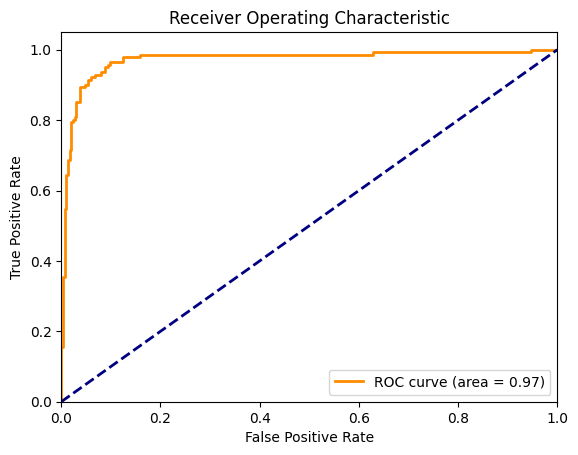

In [ ]:
# Realizar predicciones
y_pred_proba = classifier.predict(X_test_encoded)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Imprimir AUC
print(f"AUC: {roc_auc}")

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

AUC de 0.855 sugiere que el modelo tiene una excelente capacidad para distinguir entre las clases positivas y negativas.

Resultados de Prueba

*   Accuracy: **80.5%**
*   Precision: **59.4%**
*   Sensitivity: **79.6%**
*   Specificity: **80.9%**
*   F1 Score para "0": **0.86**
*   F1 Score para "1": **0.68**


* **Rendimiento del Autoencoder:** El autoencoder está funcionando bien, ya que la pérdida de reconstrucción está disminuyendo de manera constante durante el entrenamiento. La pérdida de entrenamiento (loss) disminuye de 1.0017 a 0.7016, y la pérdida de validación (val_loss) disminuye de 1.0062 a 0.7899. Esta disminución sugiere que el autoencoder está mejorando en la tarea de reconstrucción de las secuencias.
* **Rendimiento del Clasificador:** El clasificador tiene un buen desempeño general, con una precisión balanceada de aproximadamente 0.80. Sin embargo, la precisión en la clase positiva es menor comparada con la clase negativa, lo que sugiere que podría beneficiarse de ajustes adicionales, como la optimización de class_weight o técnicas adicionales para manejar el desbalance de clases. En entrenamiento, la precisión (accuracy) aumenta de 0.7045 a 0.9522, mientras que la pérdida (loss) disminuye de 0.9523 a 0.1307. Esto indica que el clasificador está aprendiendo bien a partir de las características extraídas por el autoencoder.

He probado entrenar el modelo considerando la longitud de ventana deslizante: 256 = 12.8 s × 20 Hz, de forma que:

Tres Autoencoders por Canal: Según tu descripción, necesitas tres autoencoders separados para cada canal de aceleración (ax, ay, az). Esto implica crear tres modelos de autoencoder independientes y luego combinarlos.

Entrenamiento de cada Autoencoder: Cada autoencoder debe ser entrenado utilizando solo los datos de su respectivo canal (ax, ay, az).

Uso del Encoder para Extracción de Características: Una vez entrenados los autoencoders, se debe extraer el encoder de cada modelo para usarlo como parte de la red de clasificación final.

Concatenación de las Características: Las características extraídas de los tres encoders deben concatenarse y luego pasarse a un clasificador denso para la clasificación final.

**Pero, los resultados han sido bastante negativos.**

##### Giroscopio (Gyr)

In [ ]:
# Función para extraer características de una serie temporal
def extract_features_from_series(series):
    series = np.asarray(series)  # Asegurarse de que sea un array de NumPy
    series = series.astype(float)  # Convertir a flotante para evitar overflow

    return {
        'mean': np.mean(series),
        'std': np.std(series),
        'var': np.var(series),
        'max': np.max(series),
        'min': np.min(series),
        'range': np.ptp(series),  # np.ptp es equivalente a np.max - np.min pero más seguro
        'kurtosis': pd.Series(series).kurtosis(),
        'skewness': pd.Series(series).skew()
    }

# Función para procesar cada fila de datos
def process_gyr_row(gyr_data):
    x_vals = np.array([point[0] for point in gyr_data])
    y_vals = np.array([point[1] for point in gyr_data])
    z_vals = np.array([point[2] for point in gyr_data])

    # Asegurarse de que cada valor sea numérico y no una lista o array multidimensional
    x_features = extract_features_from_series(x_vals)
    y_features = extract_features_from_series(y_vals)
    z_features = extract_features_from_series(z_vals)

    # Combinar todas las características en un solo vector (diccionario)
    gyr_features = {f'x_{key}': val for key, val in x_features.items()}
    gyr_features.update({f'y_{key}': val for key, val in y_features.items()})
    gyr_features.update({f'z_{key}': val for key, val in z_features.items()})

    return gyr_features

# Separamos características y preparamos datos:
df_train_neck_features = df_train_neck[feature_cols_gyr].apply(lambda row: process_gyr_row(row['Gyr']), axis=1)
df_train_neck_features = pd.DataFrame(df_train_neck_features.tolist())
X_train_neck_gyr = df_train_neck_features
y_train_neck_gyr = df_train_neck[target_col]

df_test_neck_features = df_test_neck[feature_cols_gyr].apply(lambda row: process_gyr_row(row['Gyr']), axis=1)
df_test_neck_features = pd.DataFrame(df_test_neck_features.tolist())
X_test_neck_gyr = df_test_neck_features
y_test_neck_gyr = df_test_neck[target_col]

Normalizamos características:

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train_neck_gyr = scaler.fit_transform(X_train_neck_gyr)
X_test_neck_gyr = scaler.transform(X_test_neck_gyr)

In [ ]:
# Dividir el conjunto de datos en entrenamiento y validación
X_train_neck_gyr, X_val_neck_gyr, y_train_neck_gyr, y_val_neck_gyr = train_test_split(X_train_neck_gyr, y_train_neck_gyr, test_size=0.2, random_state=42)

###### 1. **Modelo k-NN**

Realizamos predicciones:

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_neck_gyr, y_train_neck_gyr)
y_pred = knn.predict(X_test_neck_gyr)

Evaluación del modelo:

In [ ]:
# Evaluación en el conjunto de validación
y_val_pred_neck_gyr_knn = knn.predict(X_val_neck_gyr)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_gyr, y_val_pred_neck_gyr_knn)
val_precision = precision_score(y_val_neck_gyr, y_val_pred_neck_gyr_knn, average='binary')
val_recall = recall_score(y_val_neck_gyr, y_val_pred_neck_gyr_knn, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_gyr, y_val_pred_neck_gyr_knn).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_gyr, y_val_pred_neck_gyr_knn)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_gyr, y_val_pred_neck_gyr_knn).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_gyr, y_val_pred_neck_gyr_knn))

# Guardar métricas de validación en un diccionario
res_val_neck_gyr_knn = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.9164420485175202
Validation Precision: 0.875
Validation Sensitivity: 0.8521739130434782
Validation Specificity: 0.9453125
Validation Balanced Accuracy: 0.8987432065217391

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       256
           1       0.88      0.85      0.86       115

    accuracy                           0.92       371
   macro avg       0.90      0.90      0.90       371
weighted avg       0.92      0.92      0.92       371



In [ ]:
# Evaluación en el conjunto de prueba
y_test_pred_neck_gyr_knn = knn.predict(X_test_neck_gyr)

print("\nTest Accuracy:", accuracy_score(y_test_neck_gyr, y_test_pred_neck_gyr_knn))
print("Test Precision:", precision_score(y_test_neck_gyr, y_test_pred_neck_gyr_knn, average='binary'))
print("Test Sensitivity:", recall_score(y_test_neck_gyr, y_test_pred_neck_gyr_knn, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test_neck_gyr, y_test_pred_neck_gyr_knn).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_neck_gyr, y_test_pred_neck_gyr_knn))

print("\nTest Classification Report:\n", classification_report(y_test_neck_gyr, y_test_pred_neck_gyr_knn))


Test Accuracy: 0.8678815489749431
Test Precision: 0.8074074074074075
Test Sensitivity: 0.7730496453900709
Test Specificity: 0.912751677852349
Test Balanced Accuracy: 0.84290066162121

Test Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90       298
           1       0.81      0.77      0.79       141

    accuracy                           0.87       439
   macro avg       0.85      0.84      0.85       439
weighted avg       0.87      0.87      0.87       439



Resultados de Validación

*   Accuracy: **91.6%**
*   Precision: **87.5%**
*   Sensitivity: **85.2%**
*   Specificity: **94.5%**
*   F1 Score para "0": **0.94**
*   F1 Score para "1": **0.86**

Estos resultados muestran ...

Resultados de Prueba

*   Accuracy: **80.2%**
*   Precision: **60.1%**
*   Sensitivity: **71.5%**
*   Specificity: **83.3%**
*   F1 Score para "0": **0.86**
*   F1 Score para "1": **0.65**

En comparación con los resultados de validación, los resultados del conjunto de prueba muestran ...

###### 2. **Modelo SVM**

In [ ]:
# Crear el modelo SVM
svm_model = SVC(kernel='linear')  # Puedes probar otros kernels como 'rbf', 'poly', etc.

# Entrenar el modelo
svm_model.fit(X_train_neck_gyr, y_train_neck_gyr)

# Hacer predicciones en el conjunto de validación
y_val_pred_neck_gyr_svm = svm_model.predict(X_val_neck_gyr)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_gyr, y_val_pred_neck_gyr_svm)
val_precision = precision_score(y_val_neck_gyr, y_val_pred_neck_gyr_svm, average='binary')
val_recall = recall_score(y_val_neck_gyr, y_val_pred_neck_gyr_svm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_gyr, y_val_pred_neck_gyr_svm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_gyr, y_val_pred_neck_gyr_svm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_gyr, y_val_pred_neck_gyr_svm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_gyr, y_val_pred_neck_gyr_svm))

# Guardar métricas de validación en un diccionario
res_val_neck_gyr_svm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.9002695417789758
Validation Precision: 0.8482142857142857
Validation Sensitivity: 0.8260869565217391
Validation Specificity: 0.93359375
Validation Balanced Accuracy: 0.8798403532608696

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93       256
           1       0.85      0.83      0.84       115

    accuracy                           0.90       371
   macro avg       0.89      0.88      0.88       371
weighted avg       0.90      0.90      0.90       371



In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred_neck_gyr_svm = svm_model.predict(X_test_neck_gyr)

# Evaluar el modelo en el conjunto de prueba
print(f"\nTest Accuracy:", accuracy_score(y_test_neck_gyr, y_test_pred_neck_gyr_svm))
print(f"Test Precision:", precision_score(y_test_neck_gyr, y_test_pred_neck_gyr_svm))
print(f"Test Sensitivity:", recall_score(y_test_neck_gyr, y_test_pred_neck_gyr_svm))
tn, fp, fn, tp = confusion_matrix(y_test_neck_gyr, y_test_pred_neck_gyr_svm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_neck_gyr, y_test_pred_neck_gyr_svm))

print("\nTest Classification Report:", classification_report(y_test_neck_gyr, y_test_pred_neck_gyr_svm))


Test Accuracy: 0.8656036446469249
Test Precision: 0.8360655737704918
Test Sensitivity: 0.723404255319149
Test Specificity: 0.9328859060402684
Test Balanced Accuracy: 0.8281450806797087

Test Classification Report:               precision    recall  f1-score   support

           0       0.88      0.93      0.90       298
           1       0.84      0.72      0.78       141

    accuracy                           0.87       439
   macro avg       0.86      0.83      0.84       439
weighted avg       0.86      0.87      0.86       439



Ajuste de Hiperparámetros con GridSearchCV:

In [ ]:
# Definir los hiperparámetros a probar
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']  # solo afecta a algunos kernels
}

# Crear el modelo SVM
svm_model = SVC()

# Implementar GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar el modelo con GridSearchCV
grid_search.fit(X_train_neck_gyr, y_train_neck_gyr)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Usar el mejor modelo encontrado
best_svm_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de validación
y_val_pred_neck_gyr_svm = best_svm_model.predict(X_val_neck_gyr)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_gyr, y_val_pred_neck_gyr_svm)
val_precision = precision_score(y_val_neck_gyr, y_val_pred_neck_gyr_svm, average='binary')
val_recall = recall_score(y_val_neck_gyr, y_val_pred_neck_gyr_svm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_gyr, y_val_pred_neck_gyr_svm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_gyr, y_val_pred_neck_gyr_svm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_gyr, y_val_pred_neck_gyr_svm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_gyr, y_val_pred_neck_gyr_svm))

# Guardar métricas de validación en un diccionario
res_val_neck_gyr_svm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

Mejores hiperparámetros: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Validation Accuracy: 0.9245283018867925
Validation Precision: 0.8717948717948718
Validation Sensitivity: 0.8869565217391304
Validation Specificity: 0.94140625
Validation Balanced Accuracy: 0.9141813858695652

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95       256
           1       0.87      0.89      0.88       115

    accuracy                           0.92       371
   macro avg       0.91      0.91      0.91       371
weighted avg       0.92      0.92      0.92       371



Validación Cruzada

In [ ]:
# Realizar validación cruzada con los mejores parámetros
cv_scores = cross_val_score(best_svm_model, X_train_neck_gyr, y_train_neck_gyr, cv=5, scoring='accuracy')

print(f"Validation Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean()}")

Validation Cross-Validation Scores: [0.8989899  0.9023569  0.89225589 0.89527027 0.90202703]
Mean Cross-Validation Accuracy: 0.8981799981799983


Evaluación del Modelo en el Conjunto de Prueba

In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred_neck_gyr_svm = best_svm_model.predict(X_test_neck_gyr)

# Evaluar el modelo en el conjunto de prueba
print(f"\nTest Accuracy:", accuracy_score(y_test_neck_gyr, y_test_pred_neck_gyr_svm))
print(f"Test Precision:", precision_score(y_test_neck_gyr, y_test_pred_neck_gyr_svm))
print(f"Test Sensitivity:", recall_score(y_test_neck_gyr, y_test_pred_neck_gyr_svm))
tn, fp, fn, tp = confusion_matrix(y_test_neck_gyr, y_test_pred_neck_gyr_svm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_neck_gyr, y_test_pred_neck_gyr_svm))

print("\nTest Classification Report:", classification_report(y_test_neck_gyr, y_test_pred_neck_gyr_svm))


Test Accuracy: 0.8883826879271071
Test Precision: 0.815068493150685
Test Sensitivity: 0.8439716312056738
Test Specificity: 0.9093959731543624
Test Balanced Accuracy: 0.8766838021800181

Test Classification Report:               precision    recall  f1-score   support

           0       0.92      0.91      0.92       298
           1       0.82      0.84      0.83       141

    accuracy                           0.89       439
   macro avg       0.87      0.88      0.87       439
weighted avg       0.89      0.89      0.89       439



Sí mejora con GridSearchCV:

Resultados de Prueba

*   Accuracy: **85.8%**
*   Precision: **77.5%**
*   Sensitivity: **64.0%**
*   Specificity: **93.4%**
*   F1 Score para "0": **0.91**
*   F1 Score para "1": **0.70**

###### 3. **Modelo Random Forest**

In [ ]:
# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')  # Puedes ajustar 'n_estimators' y otros hiperparámetros

# Entrenar el modelo con las características extraídas
rf_model.fit(X_train_neck_gyr, y_train_neck_gyr)

# Hacer predicciones en el conjunto de validación
y_val_pred_neck_gyr_rf = rf_model.predict(X_val_neck_gyr)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_gyr, y_val_pred_neck_gyr_rf)
val_precision = precision_score(y_val_neck_gyr, y_val_pred_neck_gyr_rf, average='binary')
val_recall = recall_score(y_val_neck_gyr, y_val_pred_neck_gyr_rf, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_gyr, y_val_pred_neck_gyr_rf).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_gyr, y_val_pred_neck_gyr_rf)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_gyr, y_val_pred_neck_gyr_rf).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_gyr, y_val_pred_neck_gyr_rf))

# Guardar métricas de validación en un diccionario
res_val_neck_gyr_rf = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.9164420485175202
Validation Precision: 0.85
Validation Sensitivity: 0.8869565217391304
Validation Specificity: 0.9296875
Validation Balanced Accuracy: 0.9083220108695652

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       256
           1       0.85      0.89      0.87       115

    accuracy                           0.92       371
   macro avg       0.90      0.91      0.90       371
weighted avg       0.92      0.92      0.92       371



In [ ]:
# Realizar predicciones en el conjunto de prueba
y_test_pred_neck_gyr_rf = rf_model.predict(X_test_neck_gyr)

# Evaluar el rendimiento del modelo
print("\nTest Accuracy:", accuracy_score(y_test_neck_gyr, y_test_pred_neck_gyr_rf))
print("Test Precision:", precision_score(y_test_neck_gyr, y_test_pred_neck_gyr_rf, average='binary'))
print("Test Sensitivity (Recall):", recall_score(y_test_neck_gyr, y_test_pred_neck_gyr_rf, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test_neck_gyr, y_test_pred_neck_gyr_rf).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_neck_gyr, y_test_pred_neck_gyr_rf))

print("\nTest Classification Report:\n", classification_report(y_test_neck_gyr, y_test_pred_neck_gyr_rf))


Test Accuracy: 0.908883826879271
Test Precision: 0.8581560283687943
Test Sensitivity (Recall): 0.8581560283687943
Test Specificity: 0.9328859060402684
Test Balanced Accuracy: 0.8955209672045314

Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       298
           1       0.86      0.86      0.86       141

    accuracy                           0.91       439
   macro avg       0.90      0.90      0.90       439
weighted avg       0.91      0.91      0.91       439



Resultados de Prueba

*   Accuracy: **85.5%**
*   Precision: **72.6%**
*   Sensitivity: **71.5%**
*   Specificity: **90.5%**
*   F1 Score para "0": **0.90**
*   F1 Score para "1": **0.72**

###### 4. **Modelo LSTM**

Padding y división de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_neck[feature_cols_gyr].applymap(len).max().max()
print(f"Longitud máxima de secuencia: {max_length}")

Longitud máxima de secuencia: 4760


<ipython-input-81-a161bcb00b5f>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_neck[feature_cols_gyr].applymap(len).max().max()


In [ ]:
# Crear un índice de validación a partir de la división de entrenamiento y validación
train_indices, val_indices = train_test_split(df_train_neck.index, test_size=0.2, random_state=42)

# Crear los conjuntos de secuencias de entrenamiento y validación
df_train_neck_train = df_train_neck.loc[train_indices]
df_train_neck_val = df_train_neck.loc[val_indices]

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols_gyr, max_length):
    padded_features = []
    for col in feature_cols_gyr:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)
            if sequence.shape[1] < 3:
                # Añadir columnas con ceros para igualar a 3 dimensiones
                sequence = np.pad(sequence, ((0, 0), (0, 3 - sequence.shape[1])), 'constant', constant_values=0)
            if len(sequence) < max_length:
                padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
            else:
                padded_sequence = sequence[:max_length]
            padded_col.append(padded_sequence)

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_neck_train, feature_cols_gyr, max_length)
y_train = df_train_neck_train[target_col].values

# Aplicar padding al conjunto de validación
X_val_neck_gyr = pad_sequences_feature(df_train_neck_val, feature_cols_gyr, max_length)
y_val_neck_gyr = df_train_neck_val[target_col].values

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalizar las características del conjunto de validación
X_val_neck_gyr = scaler.transform(X_val_neck_gyr.reshape(-1, X_val_neck_gyr.shape[-1])).reshape(X_val_neck_gyr.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test_neck, feature_cols_gyr, max_length)
y_test = df_test_neck[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Configurar la semilla para la reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
print("Dimensiones de X_train:")
print(f"Forma: {X_train.shape}")
print(f"Número de muestras: {X_train.shape[0]}")
print(f"Longitud de secuencia (timesteps): {X_train.shape[1]}")
print(f"Número de características: {X_train.shape[2]}")

print("\nDimensiones de X_test:")
print(f"Forma: {X_test.shape}")
print(f"Número de muestras: {X_test.shape[0]}")
print(f"Longitud de secuencia (timesteps): {X_test.shape[1]}")
print(f"Número de características: {X_test.shape[2]}")

Dimensiones de X_train:
Forma: (1483, 4760, 3)
Número de muestras: 1483
Longitud de secuencia (timesteps): 4760
Número de características: 3

Dimensiones de X_test:
Forma: (439, 4760, 3)
Número de muestras: 439
Longitud de secuencia (timesteps): 4760
Número de características: 3


In [ ]:
# Verificar la forma de entrada esperada para el modelo
input_shape = (4760, 3)  # Esto debe coincidir con las dimensiones de tus datos

print(f"Forma de entrada esperada para el modelo: {input_shape}")

Forma de entrada esperada para el modelo: (4760, 3)


*  Menor Tiempo de Cómputo: RandomizedSearchCV es mucho más rápido que GridSearchCV para grandes espacios de hiperparámetros.
*  Exploración Eficiente: Aunque no prueba todas las combinaciones posibles, es probable que encuentre una buena combinación de hiperparámetros en menos tiempo.

In [ ]:
# Crear el modelo LSTM
model = Sequential()
model.add(Masking(mask_value=0., input_shape=input_shape))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con pesos de clase
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val_neck_gyr, y_val_neck_gyr), class_weight=class_weights)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 273ms/step - accuracy: 0.5250 - loss: 0.6864 - val_accuracy: 0.4286 - val_loss: 0.6904
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 263ms/step - accuracy: 0.4567 - loss: 0.6806 - val_accuracy: 0.4501 - val_loss: 0.6927
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 239ms/step - accuracy: 0.4662 - loss: 0.6757 - val_accuracy: 0.4340 - val_loss: 0.7005
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 267ms/step - accuracy: 0.4680 - loss: 0.6703 - val_accuracy: 0.4259 - val_loss: 0.7119
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 240ms/step - accuracy: 0.4781 - loss: 0.6645 - val_accuracy: 0.4555 - val_loss: 0.6996
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 262ms/step - accuracy: 0.4681 - loss: 0.6597 - val_accuracy: 0.4690 - val_loss: 0.6975
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 242ms/step - accuracy: 0.4964 - loss: 0.6532 - val_accuracy: 0.4825 - val_loss: 0.6937
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 264ms/step - accuracy: 0.4947 - loss: 0.6501 - val_accu

In [ ]:
# Realizar predicciones en el conjunto de validación
y_val_pred_neck_gyr_lstm = (model.predict(X_val_neck_gyr) > 0.5).astype("int32").ravel()

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_gyr, y_val_pred_neck_gyr_lstm)
val_precision = precision_score(y_val_neck_gyr, y_val_pred_neck_gyr_lstm, average='binary')
val_recall = recall_score(y_val_neck_gyr, y_val_pred_neck_gyr_lstm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_gyr, y_val_pred_neck_gyr_lstm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_gyr, y_val_pred_neck_gyr_lstm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_gyr, y_val_pred_neck_gyr_lstm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_gyr, y_val_pred_neck_gyr_lstm))

# Guardar métricas de validación en un diccionario
res_val_neck_gyr_lstm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step

Validation Accuracy: 0.5633423180592992
Validation Precision: 0.312
Validation Sensitivity: 0.3391304347826087
Validation Specificity: 0.6640625
Validation Balanced Accuracy: 0.5015964673913044

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.66      0.68       256
           1       0.31      0.34      0.33       115

    accuracy                           0.56       371
   macro avg       0.50      0.50      0.50       371
weighted avg       0.57      0.56      0.57       371



In [ ]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Realizar predicciones en el conjunto de prueba
y_test_pred_neck_gyr_lstm = (model.predict(X_test) > 0.5).astype("int32").ravel()

print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_neck_gyr_lstm))
print("Test Precision:", precision_score(y_test, y_test_pred_neck_gyr_lstm, average='binary'))
print("Test Sensitivity:", recall_score(y_test, y_test_pred_neck_gyr_lstm, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_neck_gyr_lstm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_neck_gyr_lstm))

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_neck_gyr_lstm))

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.5954 - loss: 0.6670
Loss: 0.6960222721099854, Accuracy: 0.5808656215667725
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step

Test Accuracy: 0.5808656036446469
Test Precision: 0.3383458646616541
Test Sensitivity: 0.3191489361702128
Test Specificity: 0.7046979865771812
Test Balanced Accuracy: 0.5119234613736969

Test Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.70      0.70       298
           1       0.34      0.32      0.33       141

    accuracy                           0.58       439
   macro avg       0.51      0.51      0.51       439
weighted avg       0.57      0.58      0.58       439



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
AUC: 0.5252510828692465


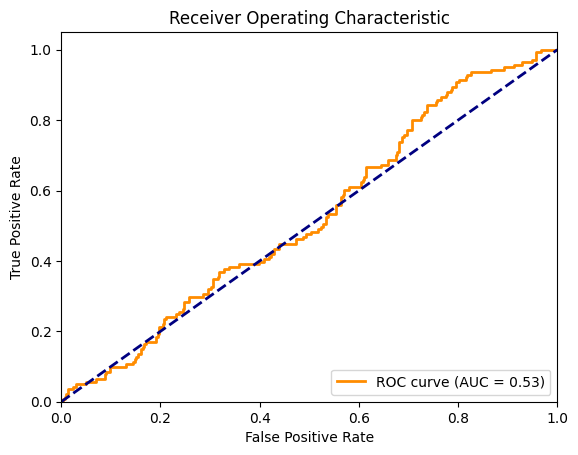

In [ ]:
# Calcular probabilidades de predicción
y_pred_proba = model.predict(X_test)

# Calcular curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Imprimir AUC
print(f"AUC: {roc_auc}")

# Graficar curva ROC
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Resultados de Prueba

*   Accuracy: **53.4%**
*   Precision: **27.8%**
*   Sensitivity: **78.8%**
*   Specificity: **28.0%**
*   F1 Score para "0": **0.41**
*   F1 Score para "1": **0.41**


###### 5. **Modelo CNN**

In [ ]:
# Definir el modelo
model = Sequential()
model.add(Input(shape=(4760, 3)))  # Definir explícitamente el tamaño de entrada
model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val_neck_gyr, y_val_neck_gyr))

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.7762 - loss: 0.8812 - val_accuracy: 0.9084 - val_loss: 0.2313
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9449 - loss: 0.1620 - val_accuracy: 0.8976 - val_loss: 0.2962
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9647 - loss: 0.1139 - val_accuracy: 0.9380 - val_loss: 0.2084
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9836 - loss: 0.0476 - val_accuracy: 0.9245 - val_loss: 0.2287
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9933 - loss: 0.0244 - val_accuracy: 0.9003 - val_loss: 0.4062
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9936 - loss: 0.0291 - val_accuracy: 0.9111 - val_loss: 0.4168
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9920 - loss: 0.0282 - val_accuracy: 0.9191 - val_loss: 0.3609
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9934 - loss: 0.0156 - val_accuracy: 0.8706 - v

In [ ]:
# Evaluar el modelo en el conjunto de validación
y_val_pred_neck_gyr_cnn = model.predict(X_val_neck_gyr).ravel()  # Genera predicciones
y_val_pred_neck_gyr_cnn = (y_val_pred_neck_gyr_cnn > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_gyr, y_val_pred_neck_gyr_cnn)
val_precision = precision_score(y_val_neck_gyr, y_val_pred_neck_gyr_cnn, average='binary')
val_recall = recall_score(y_val_neck_gyr, y_val_pred_neck_gyr_cnn, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_gyr, y_val_pred_neck_gyr_cnn).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_gyr, y_val_pred_neck_gyr_cnn)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_gyr, y_val_pred_neck_gyr_cnn).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_gyr, y_val_pred_neck_gyr_cnn))

# Guardar métricas de validación en un diccionario
res_val_neck_gyr_cnn = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Validation Accuracy: 0.9326145552560647
Validation Precision: 0.8947368421052632
Validation Sensitivity: 0.8869565217391304
Validation Specificity: 0.953125
Validation Balanced Accuracy: 0.9200407608695652

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       256
           1       0.89      0.89      0.89       115

    accuracy                           0.93       371
   macro avg       0.92      0.92      0.92       371
weighted avg       0.93      0.93      0.93       371



In [ ]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred_neck_gyr_cnn = model.predict(X_test).ravel()  # Genera predicciones
y_test_pred_neck_gyr_cnn = (y_test_pred_neck_gyr_cnn > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias

# Cálculo de métricas
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_neck_gyr_cnn))
print("Test Precision:", precision_score(y_test, y_test_pred_neck_gyr_cnn, average='binary'))
print("Test Sensitivity (Recall):", recall_score(y_test, y_test_pred_neck_gyr_cnn, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_neck_gyr_cnn).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_neck_gyr_cnn))

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_neck_gyr_cnn))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Test Accuracy: 0.8997722095671982
Test Precision: 0.8439716312056738
Test Sensitivity (Recall): 0.8439716312056738
Test Specificity: 0.9261744966442953
Test Balanced Accuracy: 0.8850730639249845

Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       298
           1       0.84      0.84      0.84       141

    accuracy                           0.90       439
   macro avg       0.89      0.89      0.89       439
weighted avg       0.90      0.90      0.90       439



Validación Cruzada K-Fold:

In [ ]:
# Definir el número de folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Inicializar listas para almacenar los resultados de cada fold
accuracy_per_fold = []
loss_per_fold = []
precision_per_fold = []
recall_per_fold = []
specificity_per_fold = []
f1_per_fold = []
balanced_accuracy_per_fold = []

# Iterar sobre cada fold
for train_index, val_index in kf.split(X_train):
    # Dividir los datos en entrenamiento y validación
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Definir el modelo (es importante definirlo dentro del loop para reiniciarlo en cada fold)
    model = Sequential()
    model.add(Input(shape=(4760, 3)))  # Definir explícitamente el tamaño de entrada
    model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo en el fold actual
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)

    # Evaluar el modelo en el conjunto de validación del fold actual
    y_val_pred = model.predict(X_val_fold).ravel()
    y_val_pred = (y_val_pred > 0.5).astype(int)

    # Cálculo de métricas para el fold actual
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    loss = model.evaluate(X_val_fold, y_val_fold, verbose=0)[0]
    precision = precision_score(y_val_fold, y_val_pred)
    recall = recall_score(y_val_fold, y_val_pred)
    f1 = f1_score(y_val_fold, y_val_pred)
    cm = confusion_matrix(y_val_fold, y_val_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    balanced_accuracy = balanced_accuracy_score(y_val_fold, y_val_pred)

    # Almacenar las métricas para este fold
    accuracy_per_fold.append(accuracy)
    loss_per_fold.append(loss)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    specificity_per_fold.append(specificity)
    f1_per_fold.append(f1)
    balanced_accuracy_per_fold.append(balanced_accuracy)

# Mostrar resultados promedio de las métricas de k-fold
print(f'\nMean Accuracy (k-Fold): {np.mean(accuracy_per_fold)}')
print(f'Mean Loss (k-Fold): {np.mean(loss_per_fold)}')
print(f'Mean Precision (k-Fold): {np.mean(precision_per_fold)}')
print(f'Mean Recall (k-Fold): {np.mean(recall_per_fold)}')
print(f'Mean Specificity (k-Fold): {np.mean(specificity_per_fold)}')
print(f'Mean F1 Score (k-Fold): {np.mean(f1_per_fold)}')
print(f'Mean Balanced Accuracy (k-Fold): {np.mean(balanced_accuracy_per_fold)}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step

Mean Accuracy (k-Fold): 0.910990535990536
Mean Loss (k-Fold): 0.7261832416057586
Mean Precision (k-Fold): 0.8603118664539308
Mean Recall (k-Fold): 0.8707786094985671
Mean Specificity (k-Fold): 0.9323204138766824
Mean F1 Score (k-Fold): 0.8635980298288917
Mean Balanced Accuracy (k-Fold): 0.9015495116876249


**Mean Accuracy**:

**Mean Precision**:

**Mean Sensitivity**:

**Mean Specifity**:

**Mean F1 Score**:

###### 6. **Modelo SAE**

Padding y división de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_neck[feature_cols_gyr].applymap(len).max().max()
print(f"Longitud máxima de secuencia: {max_length}")

Longitud máxima de secuencia: 4760


<ipython-input-97-a161bcb00b5f>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_neck[feature_cols_gyr].applymap(len).max().max()


In [ ]:
# Crear un índice de validación a partir de la división de entrenamiento y validación
train_indices, val_indices = train_test_split(df_train_neck.index, test_size=0.2, random_state=42)

# Crear los conjuntos de secuencias de entrenamiento y validación
df_train_neck_train = df_train_neck.loc[train_indices]
df_train_neck_val = df_train_neck.loc[val_indices]

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols_gyr, max_length):
    padded_features = []
    for col in feature_cols_gyr:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)
            if sequence.shape[1] < 3:
                # Añadir columnas con ceros para igualar a 3 dimensiones
                sequence = np.pad(sequence, ((0, 0), (0, 3 - sequence.shape[1])), 'constant', constant_values=0)
            if len(sequence) < max_length:
                padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
            else:
                padded_sequence = sequence[:max_length]
            padded_col.append(padded_sequence)

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_neck_train, feature_cols_gyr, max_length)
y_train = df_train_neck_train[target_col].values

# Aplicar padding al conjunto de validación
X_val_neck_gyr = pad_sequences_feature(df_train_neck_val, feature_cols_gyr, max_length)
y_val_neck_gyr = df_train_neck_val[target_col].values

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalizar las características del conjunto de validación
X_val_neck_gyr = scaler.transform(X_val_neck_gyr.reshape(-1, X_val_neck_gyr.shape[-1])).reshape(X_val_neck_gyr.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test_neck, feature_cols_gyr, max_length)
y_test = df_test_neck[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")

Forma de X_train: (1483, 4760, 3)
Forma de X_test: (439, 4760, 3)


*  **1854 / 1321** son el número de muestras para el conjunto de entrenamiento y prueba, respectivamente.
*  **4760** es la longitud de la ventana de tiempo (en muestras) para cada señal.
*  **3** representa los tres canales de aceleración (ax, ay, az).

In [ ]:
# Ver los primeros 5 valores de cada canal en la primera muestra
print("Primeros 5 valores del primer canal (ax) de la primera muestra de X_train:")
print(X_train[0, :5, 0])  # Canal ax

print("Primeros 5 valores del segundo canal (ay) de la primera muestra de X_train:")
print(X_train[0, :5, 1])  # Canal ay

print("Primeros 5 valores del tercer canal (az) de la primera muestra de X_train:")
print(X_train[0, :5, 2])  # Canal az

Primeros 5 valores del primer canal (ax) de la primera muestra de X_train:
[2.54201693 2.61100965 2.68739446 2.76993933 2.83646803]
Primeros 5 valores del segundo canal (ay) de la primera muestra de X_train:
[2.77363968 2.76212535 2.75719064 2.76870497 2.79831324]
Primeros 5 valores del tercer canal (az) de la primera muestra de X_train:
[3.02617283 3.11382338 3.13938812 3.11564943 3.03165099]


In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Configurar la semilla para la reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
# Parámetros
input_shape = (4760, 3)  # Ajusta esto a la forma de tu entrada
kernel_size = 7
filters = [32, 64]  # Número de filtros en cada capa convolucional

# Definir la función de autoencoder
def build_autoencoder(input_shape, filters, kernel_size):
    input_layer = Input(shape=input_shape)

    # Encoder
    x = Conv1D(filters=filters[0], kernel_size=kernel_size, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)

    # Bottleneck
    bottleneck_shape = x.shape[1:]  # Obtiene la forma después de las capas convolucionales y de pooling
    x = Flatten()(x)
    bottleneck = Dense(128, activation='relu')(x)  # Puedes ajustar la dimensión del bottleneck

    # Decoder
    x = Dense(np.prod(bottleneck_shape), activation='relu')(bottleneck)
    x = Reshape(bottleneck_shape)(x)  # Redimensiona a la forma adecuada para las capas convolucionales de decodificación
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=input_shape[1], kernel_size=kernel_size, activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_layer, x)
    encoder = Model(input_layer, bottleneck)

    return autoencoder, encoder

# Construir el autoencoder
autoencoder, encoder = build_autoencoder(input_shape, filters, kernel_size)

# Compilar el autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenar el autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2)

# Extraer las características usando el encoder
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val_neck_gyr)
X_test_encoded = encoder.predict(X_test)

# Crear el clasificador denso
def build_classifier(input_shape):
    input_layer = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input_layer)
    x = Dense(32, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    classifier = Model(input_layer, output_layer)
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return classifier

# Construir el clasificador
classifier = build_classifier(X_train_encoded.shape[1:])

# Entrenar el clasificador
classifier.fit(X_train_encoded, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weights)

# Evaluar el clasificador
loss, accuracy = classifier.evaluate(X_test_encoded, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 1.2580 - val_loss: 0.8316
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.1686 - val_loss: 0.8316
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.1686 - val_loss: 0.8316
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.1686 - val_loss: 0.8316
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.1686 - val_loss: 0.8316
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 1.1686 - val_loss: 0.8316
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.1686 - val_loss: 0.8316
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 1.1686 - val_loss: 0.8316
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 1.1686 - val_loss: 0.8316
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 1.1686 - val_loss: 0.8316
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10
38/38 ━━━━━━━━━━━━━

In [ ]:
# Realizar predicciones
y_val_pred_neck_gyr_sae = (classifier.predict(X_val_encoded) > 0.5).astype(int).ravel()

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_gyr, y_val_pred_neck_gyr_sae)
val_precision = precision_score(y_val_neck_gyr, y_val_pred_neck_gyr_sae, average='binary')
val_recall = recall_score(y_val_neck_gyr, y_val_pred_neck_gyr_sae, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_gyr, y_val_pred_neck_gyr_sae).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_gyr, y_val_pred_neck_gyr_sae)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_gyr, y_val_pred_neck_gyr_sae).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_gyr, y_val_pred_neck_gyr_sae))

# Guardar métricas de validación en un diccionario
res_val_neck_gyr_sae = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Validation Accuracy: 0.6226415094339622
Validation Precision: 0.4493927125506073
Validation Sensitivity: 0.9652173913043478
Validation Specificity: 0.46875
Validation Balanced Accuracy: 0.7169836956521739

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.47      0.63       256
           1       0.45      0.97      0.61       115

    accuracy                           0.62       371
   macro avg       0.71      0.72      0.62       371
weighted avg       0.81      0.62      0.63       371



In [ ]:
# Realizar predicciones
y_test_pred_neck_gyr_sae = (classifier.predict(X_test_encoded) > 0.5).astype(int).ravel()

# Cálculo de métricas
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_neck_gyr_sae))
print("Test Precision:", precision_score(y_test, y_test_pred_neck_gyr_sae, average='binary'))
print("Test Sensitivity:", recall_score(y_test, y_test_pred_neck_gyr_sae, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_neck_gyr_sae).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_neck_gyr_sae))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_neck_gyr_sae))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Test Accuracy: 0.6173120728929385
Test Precision: 0.45484949832775917
Test Sensitivity: 0.9645390070921985
Test Specificity: 0.45302013422818793
Test Balanced Accuracy: 0.7087795706601933

Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.45      0.62       298
           1       0.45      0.96      0.62       141

    accuracy                           0.62       439
   macro avg       0.71      0.71      0.62       439
weighted avg       0.80      0.62      0.62       439



14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
AUC: 0.8871912037698129


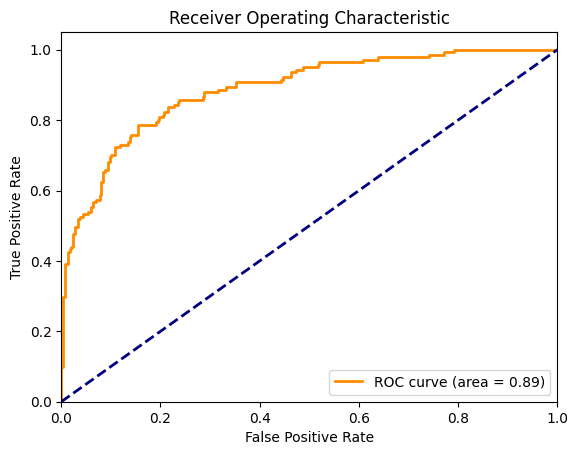

In [ ]:
# Realizar predicciones
y_pred_proba = classifier.predict(X_test_encoded)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Imprimir AUC
print(f"AUC: {roc_auc}")

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

AUC de 0.839 sugiere que el modelo tiene una excelente capacidad para distinguir entre las clases positivas y negativas.

Resultados de Prueba

*   Accuracy: **61.4%**
*   Precision: **31.4%**
*   Sensitivity: **99.1%**
*   Specificity: **23.7%**
*   F1 Score para "0": **0.38**
*   F1 Score para "1": **0.48**

##### Magnetómetro (Mag)

In [ ]:
# Función para extraer características de una serie temporal
def extract_features_from_series(series):
    series = np.asarray(series)  # Asegurarse de que sea un array de NumPy
    series = series.astype(float)  # Convertir a flotante para evitar overflow

    return {
        'mean': np.mean(series),
        'std': np.std(series),
        'var': np.var(series),
        'max': np.max(series),
        'min': np.min(series),
        'range': np.ptp(series),  # np.ptp es equivalente a np.max - np.min pero más seguro
        'kurtosis': pd.Series(series).kurtosis(),
        'skewness': pd.Series(series).skew()
    }

# Función para procesar cada fila de datos
def process_mag_row(mag_data):
    x_vals = np.array([point[0] for point in mag_data])
    y_vals = np.array([point[1] for point in mag_data])
    z_vals = np.array([point[2] for point in mag_data])

    # Asegurarse de que cada valor sea numérico y no una lista o array multidimensional
    x_features = extract_features_from_series(x_vals)
    y_features = extract_features_from_series(y_vals)
    z_features = extract_features_from_series(z_vals)

    # Combinar todas las características en un solo vector (diccionario)
    mag_features = {f'x_{key}': val for key, val in x_features.items()}
    mag_features.update({f'y_{key}': val for key, val in y_features.items()})
    mag_features.update({f'z_{key}': val for key, val in z_features.items()})

    return mag_features

# Separamos características y preparamos datos:
df_train_neck_features = df_train_neck[feature_cols_mag].apply(lambda row: process_mag_row(row['Mag']), axis=1)
df_train_neck_features = pd.DataFrame(df_train_neck_features.tolist())
X_train_neck_mag = df_train_neck_features
y_train_neck_mag = df_train_neck[target_col]

df_test_neck_features = df_test_neck[feature_cols_mag].apply(lambda row: process_mag_row(row['Mag']), axis=1)
df_test_neck_features = pd.DataFrame(df_test_neck_features.tolist())
X_test_neck_mag = df_test_neck_features
y_test_neck_mag = df_test_neck[target_col]

Normalizamos características:

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train_neck_mag = scaler.fit_transform(X_train_neck_mag)
X_test_neck_mag = scaler.transform(X_test_neck_mag)

In [ ]:
# Dividir el conjunto de datos en entrenamiento y validación
X_train_neck_mag, X_val_neck_mag, y_train_neck_mag, y_val_neck_mag = train_test_split(X_train_neck_mag, y_train_neck_mag, test_size=0.2, random_state=42)

###### 1. **Modelo k-NN**

Realizamos predicciones:

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_neck_mag, y_train_neck_mag)
y_pred = knn.predict(X_test_neck_mag)

Evaluación del modelo:

In [ ]:
# Evaluación en el conjunto de validación
y_val_pred_neck_mag_knn = knn.predict(X_val_neck_mag)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_mag, y_val_pred_neck_mag_knn)
val_precision = precision_score(y_val_neck_mag, y_val_pred_neck_mag_knn, average='binary')
val_recall = recall_score(y_val_neck_mag, y_val_pred_neck_mag_knn, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_mag, y_val_pred_neck_mag_knn).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_mag, y_val_pred_neck_mag_knn)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_mag, y_val_pred_neck_mag_knn).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_mag, y_val_pred_neck_mag_knn))

# Guardar métricas de validación en un diccionario
res_val_neck_mag_knn = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.8652291105121294
Validation Precision: 0.7876106194690266
Validation Sensitivity: 0.7739130434782608
Validation Specificity: 0.90625
Validation Balanced Accuracy: 0.8400815217391304

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90       256
           1       0.79      0.77      0.78       115

    accuracy                           0.87       371
   macro avg       0.84      0.84      0.84       371
weighted avg       0.86      0.87      0.86       371



In [ ]:
# Evaluación en el conjunto de prueba
y_test_pred_neck_mag_knn = knn.predict(X_test_neck_mag)

print("\nTest Accuracy:", accuracy_score(y_test_neck_mag, y_test_pred_neck_mag_knn))
print("Test Precision:", precision_score(y_test_neck_mag, y_test_pred_neck_mag_knn, average='binary'))
print("Test Sensitivity:", recall_score(y_test_neck_mag, y_test_pred_neck_mag_knn, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test_neck_mag, y_test_pred_neck_mag_knn).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_neck_mag, y_test_pred_neck_mag_knn))

print("\nTest Classification Report:\n", classification_report(y_test_neck_mag, y_test_pred_neck_mag_knn))


Test Accuracy: 0.8883826879271071
Test Precision: 0.8382352941176471
Test Sensitivity: 0.8085106382978723
Test Specificity: 0.9261744966442953
Test Balanced Accuracy: 0.8673425674710837

Test Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       298
           1       0.84      0.81      0.82       141

    accuracy                           0.89       439
   macro avg       0.87      0.87      0.87       439
weighted avg       0.89      0.89      0.89       439



Resultados de Validación

*   Accuracy: **86.5%**
*   Precision: **78.7%**
*   Sensitivity: **77.4%**
*   Specificity: **90.6%**
*   F1 Score para "0": **0.90**
*   F1 Score para "1": **0.78**

Estos resultados muestran ...

Resultados de Prueba

*   Accuracy: **64.0%**
*   Precision: **40.6%**
*   Sensitivity: **83.1%**
*   Specificity: **57.3%**
*   F1 Score para "0": **0.70**
*   F1 Score para "1": **0.55**

En comparación con los resultados de validación, los resultados del conjunto de prueba muestran ...

###### 2. **Modelo SVM**

In [ ]:
# Crear el modelo SVM
svm_model = SVC(kernel='linear')  # Puedes probar otros kernels como 'rbf', 'poly', etc.

# Entrenar el modelo
svm_model.fit(X_train_neck_mag, y_train_neck_mag)

# Hacer predicciones en el conjunto de validación
y_val_pred_neck_mag_svm = svm_model.predict(X_val_neck_mag)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_mag, y_val_pred_neck_mag_svm)
val_precision = precision_score(y_val_neck_mag, y_val_pred_neck_mag_svm, average='binary')
val_recall = recall_score(y_val_neck_mag, y_val_pred_neck_mag_svm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_mag, y_val_pred_neck_mag_svm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_mag, y_val_pred_neck_mag_svm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_mag, y_val_pred_neck_mag_svm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_mag, y_val_pred_neck_mag_svm))

# Guardar métricas de validación en un diccionario
res_val_neck_mag_svm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.8544474393530997
Validation Precision: 0.7226277372262774
Validation Sensitivity: 0.8608695652173913
Validation Specificity: 0.8515625
Validation Balanced Accuracy: 0.8562160326086956

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.85      0.89       256
           1       0.72      0.86      0.79       115

    accuracy                           0.85       371
   macro avg       0.83      0.86      0.84       371
weighted avg       0.87      0.85      0.86       371



In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred_neck_mag_svm = svm_model.predict(X_test_neck_mag)

# Evaluar el modelo en el conjunto de prueba
print(f"\nTest Accuracy:", accuracy_score(y_test_neck_mag, y_test_pred_neck_mag_svm))
print(f"Test Precision:", precision_score(y_test_neck_mag, y_test_pred_neck_mag_svm))
print(f"Test Sensitivity:", recall_score(y_test_neck_mag, y_test_pred_neck_mag_svm))
tn, fp, fn, tp = confusion_matrix(y_test_neck_mag, y_test_pred_neck_mag_svm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_neck_mag, y_test_pred_neck_mag_svm))

print("\nTest Classification Report:", classification_report(y_test_neck_mag, y_test_pred_neck_mag_svm))


Test Accuracy: 0.8542141230068337
Test Precision: 0.7655172413793103
Test Sensitivity: 0.7872340425531915
Test Specificity: 0.8859060402684564
Test Balanced Accuracy: 0.8365700414108239

Test Classification Report:               precision    recall  f1-score   support

           0       0.90      0.89      0.89       298
           1       0.77      0.79      0.78       141

    accuracy                           0.85       439
   macro avg       0.83      0.84      0.83       439
weighted avg       0.86      0.85      0.85       439



Ajuste de Hiperparámetros con GridSearchCV:

In [ ]:
# Definir los hiperparámetros a probar
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']  # solo afecta a algunos kernels
}

# Crear el modelo SVM
svm_model = SVC()

# Implementar GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar el modelo con GridSearchCV
grid_search.fit(X_train_neck_mag, y_train_neck_mag)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Usar el mejor modelo encontrado
best_svm_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de validación
y_val_pred_neck_mag_svm = best_svm_model.predict(X_val_neck_mag)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_mag, y_val_pred_neck_mag_svm)
val_precision = precision_score(y_val_neck_mag, y_val_pred_neck_mag_svm, average='binary')
val_recall = recall_score(y_val_neck_mag, y_val_pred_neck_mag_svm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_mag, y_val_pred_neck_mag_svm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_mag, y_val_pred_neck_mag_svm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_mag, y_val_pred_neck_mag_svm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_mag, y_val_pred_neck_mag_svm))

# Guardar métricas de validación en un diccionario
res_val_neck_mag_svm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

Mejores hiperparámetros: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Validation Accuracy: 0.8787061994609164
Validation Precision: 0.7777777777777778
Validation Sensitivity: 0.8521739130434782
Validation Specificity: 0.890625
Validation Balanced Accuracy: 0.8713994565217391

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91       256
           1       0.78      0.85      0.81       115

    accuracy                           0.88       371
   macro avg       0.85      0.87      0.86       371
weighted avg       0.88      0.88      0.88       371



Validación Cruzada

In [ ]:
# Realizar validación cruzada con los mejores parámetros
cv_scores = cross_val_score(best_svm_model, X_train_neck_mag, y_train_neck_mag, cv=5, scoring='accuracy')

print(f"Validation Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean()}")

Validation Cross-Validation Scores: [0.85521886 0.87878788 0.86868687 0.88175676 0.89189189]
Mean Cross-Validation Accuracy: 0.8752684502684505


Evaluación del Modelo en el Conjunto de Prueba

In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred_neck_mag_svm = best_svm_model.predict(X_test_neck_mag)

# Evaluar el modelo en el conjunto de prueba
print(f"\nTest Accuracy:", accuracy_score(y_test_neck_mag, y_test_pred_neck_mag_svm))
print(f"Test Precision:", precision_score(y_test_neck_mag, y_test_pred_neck_mag_svm))
print(f"Test Sensitivity:", recall_score(y_test_neck_mag, y_test_pred_neck_mag_svm))
tn, fp, fn, tp = confusion_matrix(y_test_neck_mag, y_test_pred_neck_mag_svm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_neck_mag, y_test_pred_neck_mag_svm))

print("\nTest Classification Report:", classification_report(y_test_neck_mag, y_test_pred_neck_mag_svm))


Test Accuracy: 0.8701594533029613
Test Precision: 0.7837837837837838
Test Sensitivity: 0.8226950354609929
Test Specificity: 0.8926174496644296
Test Balanced Accuracy: 0.8576562425627112

Test Classification Report:               precision    recall  f1-score   support

           0       0.91      0.89      0.90       298
           1       0.78      0.82      0.80       141

    accuracy                           0.87       439
   macro avg       0.85      0.86      0.85       439
weighted avg       0.87      0.87      0.87       439



No mejora con GridSearchCV:

Resultados de Prueba

*   Accuracy: **73.4%**
*   Precision: **49.4%**
*   Sensitivity: **79.4%**
*   Specificity: **71.3%**
*   F1 Score para "0": **0.80**
*   F1 Score para "1": **0.61**

###### 3. **Modelo Random Forest**

In [ ]:
# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')  # Puedes ajustar 'n_estimators' y otros hiperparámetros

# Entrenar el modelo con las características extraídas
rf_model.fit(X_train_neck_mag, y_train_neck_mag)

# Hacer predicciones en el conjunto de validación
y_val_pred_neck_mag_rf = rf_model.predict(X_val_neck_mag)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_mag, y_val_pred_neck_mag_rf)
val_precision = precision_score(y_val_neck_mag, y_val_pred_neck_mag_rf, average='binary')
val_recall = recall_score(y_val_neck_mag, y_val_pred_neck_mag_rf, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_mag, y_val_pred_neck_mag_rf).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_mag, y_val_pred_neck_mag_rf)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_mag, y_val_pred_neck_mag_rf).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_mag, y_val_pred_neck_mag_rf))

# Guardar métricas de validación en un diccionario
res_val_neck_mag_rf = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.894878706199461
Validation Precision: 0.8015873015873016
Validation Sensitivity: 0.8782608695652174
Validation Specificity: 0.90234375
Validation Balanced Accuracy: 0.8903023097826087

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       256
           1       0.80      0.88      0.84       115

    accuracy                           0.89       371
   macro avg       0.87      0.89      0.88       371
weighted avg       0.90      0.89      0.90       371



In [ ]:
# Realizar predicciones en el conjunto de prueba
y_test_pred_neck_mag_rf = rf_model.predict(X_test_neck_mag)

# Evaluar el rendimiento del modelo
print("\nTest Accuracy:", accuracy_score(y_test_neck_mag, y_test_pred_neck_mag_rf))
print("Test Precision:", precision_score(y_test_neck_mag, y_test_pred_neck_mag_rf, average='binary'))
print("Test Sensitivity (Recall):", recall_score(y_test_neck_mag, y_test_pred_neck_mag_rf, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test_neck_mag, y_test_pred_neck_mag_rf).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_neck_mag, y_test_pred_neck_mag_rf))

print("\nTest Classification Report:\n", classification_report(y_test_neck_mag, y_test_pred_neck_mag_rf))


Test Accuracy: 0.9157175398633257
Test Precision: 0.8939393939393939
Test Sensitivity (Recall): 0.8368794326241135
Test Specificity: 0.9530201342281879
Test Balanced Accuracy: 0.8949497834261506

Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       298
           1       0.89      0.84      0.86       141

    accuracy                           0.92       439
   macro avg       0.91      0.89      0.90       439
weighted avg       0.92      0.92      0.91       439



Resultados de Prueba

*   Accuracy: **76.1%**
*   Precision: **53.8%**
*   Sensitivity: **57.3%**
*   Specificity: **82.7%**
*   F1 Score para "0": **0.84**
*   F1 Score para "1": **0.55**

###### 4. **Modelo LSTM**

Padding y división de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_neck[feature_cols_mag].applymap(len).max().max()
print(f"Longitud máxima de secuencia: {max_length}")

Longitud máxima de secuencia: 1600


<ipython-input-122-93909dd620e1>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_neck[feature_cols_mag].applymap(len).max().max()


In [ ]:
# Crear un índice de validación a partir de la división de entrenamiento y validación
train_indices, val_indices = train_test_split(df_train_neck.index, test_size=0.2, random_state=42)

# Crear los conjuntos de secuencias de entrenamiento y validación
df_train_neck_train = df_train_neck.loc[train_indices]
df_train_neck_val = df_train_neck.loc[val_indices]

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols_mag, max_length):
    padded_features = []
    for col in feature_cols_mag:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)
            if sequence.shape[1] < 3:
                # Añadir columnas con ceros para igualar a 3 dimensiones
                sequence = np.pad(sequence, ((0, 0), (0, 3 - sequence.shape[1])), 'constant', constant_values=0)
            if len(sequence) < max_length:
                padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
            else:
                padded_sequence = sequence[:max_length]
            padded_col.append(padded_sequence)

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_neck_train, feature_cols_mag, max_length)
y_train = df_train_neck_train[target_col].values

# Aplicar padding al conjunto de validación
X_val_neck_mag = pad_sequences_feature(df_train_neck_val, feature_cols_mag, max_length)
y_val_neck_mag = df_train_neck_val[target_col].values

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalizar las características del conjunto de validación
X_val_neck_mag = scaler.transform(X_val_neck_mag.reshape(-1, X_val_neck_mag.shape[-1])).reshape(X_val_neck_mag.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test_neck, feature_cols_mag, max_length)
y_test = df_test_neck[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Configurar la semilla para la reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
print("Dimensiones de X_train:")
print(f"Forma: {X_train.shape}")
print(f"Número de muestras: {X_train.shape[0]}")
print(f"Longitud de secuencia (timesteps): {X_train.shape[1]}")
print(f"Número de características: {X_train.shape[2]}")

print("\nDimensiones de X_test:")
print(f"Forma: {X_test.shape}")
print(f"Número de muestras: {X_test.shape[0]}")
print(f"Longitud de secuencia (timesteps): {X_test.shape[1]}")
print(f"Número de características: {X_test.shape[2]}")

Dimensiones de X_train:
Forma: (1483, 1600, 3)
Número de muestras: 1483
Longitud de secuencia (timesteps): 1600
Número de características: 3

Dimensiones de X_test:
Forma: (439, 1600, 3)
Número de muestras: 439
Longitud de secuencia (timesteps): 1600
Número de características: 3


In [ ]:
# Verificar la forma de entrada esperada para el modelo
input_shape = (1600, 3)  # Esto debe coincidir con las dimensiones de tus datos

print(f"Forma de entrada esperada para el modelo: {input_shape}")

Forma de entrada esperada para el modelo: (1600, 3)


*  Menor Tiempo de Cómputo: RandomizedSearchCV es mucho más rápido que GridSearchCV para grandes espacios de hiperparámetros.
*  Exploración Eficiente: Aunque no prueba todas las combinaciones posibles, es probable que encuentre una buena combinación de hiperparámetros en menos tiempo.

In [ ]:
# Crear el modelo LSTM
model = Sequential()
model.add(Masking(mask_value=0., input_shape=input_shape))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con pesos de clase
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val_neck_mag, y_val_neck_mag), class_weight=class_weights)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.6467 - loss: 0.6451 - val_accuracy: 0.7143 - val_loss: 0.6051
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.7036 - loss: 0.6003 - val_accuracy: 0.7143 - val_loss: 0.6124
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.7170 - loss: 0.5926 - val_accuracy: 0.7332 - val_loss: 0.6234
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.7480 - loss: 0.5903 - val_accuracy: 0.7305 - val_loss: 0.6230
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.7428 - loss: 0.5770 - val_accuracy: 0.7062 - val_loss: 0.5965
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.7334 - loss: 0.5703 - val_accuracy: 0.7358 - val_loss: 0.5886
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.7460 - loss: 0.5663 - val_accuracy: 0.7143 - val_loss: 0.5935
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.7304 - loss: 0.5596 - val_accuracy: 0.7224 -

In [ ]:
# Realizar predicciones en el conjunto de validación
y_val_pred_neck_mag_lstm = (model.predict(X_val_neck_mag) > 0.5).astype("int32").ravel()

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_mag, y_val_pred_neck_mag_lstm)
val_precision = precision_score(y_val_neck_mag, y_val_pred_neck_mag_lstm, average='binary')
val_recall = recall_score(y_val_neck_mag, y_val_pred_neck_mag_lstm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_mag, y_val_pred_neck_mag_lstm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_mag, y_val_pred_neck_mag_lstm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_mag, y_val_pred_neck_mag_lstm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_mag, y_val_pred_neck_mag_lstm))

# Guardar métricas de validación en un diccionario
res_val_neck_mag_lstm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

Validation Accuracy: 0.7223719676549866
Validation Precision: 0.5357142857142857
Validation Sensitivity: 0.782608695652174
Validation Specificity: 0.6953125
Validation Balanced Accuracy: 0.7389605978260869

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.70      0.78       256
           1       0.54      0.78      0.64       115

    accuracy                           0.72       371
   macro avg       0.71      0.74      0.71       371
weighted avg       0.77      0.72      0.73       371



In [ ]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Realizar predicciones en el conjunto de prueba
y_test_pred_neck_mag_lstm = (model.predict(X_test) > 0.5).astype("int32").ravel()

print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_neck_mag_lstm))
print("Test Precision:", precision_score(y_test, y_test_pred_neck_mag_lstm, average='binary'))
print("Test Sensitivity:", recall_score(y_test, y_test_pred_neck_mag_lstm, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_neck_mag_lstm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_neck_mag_lstm))

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_neck_mag_lstm))

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7134 - loss: 0.5642
Loss: 0.5732888579368591, Accuracy: 0.7243735790252686
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

Test Accuracy: 0.724373576309795
Test Precision: 0.55
Test Sensitivity: 0.7801418439716312
Test Specificity: 0.697986577181208
Test Balanced Accuracy: 0.7390642105764196

Test Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.70      0.77       298
           1       0.55      0.78      0.65       141

    accuracy                           0.72       439
   macro avg       0.71      0.74      0.71       439
weighted avg       0.77      0.72      0.73       439



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
AUC: 0.8052501308962826


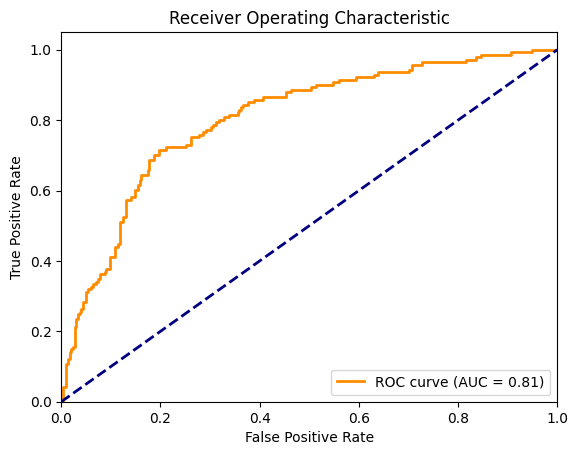

In [ ]:
# Calcular probabilidades de predicción
y_pred_proba = model.predict(X_test)

# Calcular curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Imprimir AUC
print(f"AUC: {roc_auc}")

# Graficar curva ROC
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Resultados de Prueba

*   Accuracy: **58.4%**
*   Precision: **30.7%**
*   Sensitivity: **82.0%**
*   Specificity: **35.0%**
*   F1 Score para "0": **0.49**
*   F1 Score para "1": **0.45**


###### 5. **Modelo CNN**

In [ ]:
# Definir el modelo
model = Sequential()
model.add(Input(shape=(1600, 3)))  # Definir explícitamente el tamaño de entrada
model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val_neck_mag, y_val_neck_mag))

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.7454 - loss: 0.7071 - val_accuracy: 0.8922 - val_loss: 0.2436
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8759 - loss: 0.3460 - val_accuracy: 0.9137 - val_loss: 0.2051
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8902 - loss: 0.3163 - val_accuracy: 0.9326 - val_loss: 0.1723
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9021 - loss: 0.2718 - val_accuracy: 0.9434 - val_loss: 0.1604
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9133 - loss: 0.2355 - val_accuracy: 0.9407 - val_loss: 0.1660
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9213 - loss: 0.2131 - val_accuracy: 0.9326 - val_loss: 0.1736
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9284 - loss: 0.1911 - val_accuracy: 0.9380 - val_loss: 0.1809
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9508 - loss: 0.1514 - val_accuracy: 0.9191 - val_loss

In [ ]:
# Evaluar el modelo en el conjunto de validación
y_val_pred_neck_mag_cnn = model.predict(X_val_neck_mag).ravel()  # Genera predicciones
y_val_pred_neck_mag_cnn = (y_val_pred_neck_mag_cnn > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_mag, y_val_pred_neck_mag_cnn)
val_precision = precision_score(y_val_neck_mag, y_val_pred_neck_mag_cnn, average='binary')
val_recall = recall_score(y_val_neck_mag, y_val_pred_neck_mag_cnn, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_mag, y_val_pred_neck_mag_cnn).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_mag, y_val_pred_neck_mag_cnn)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_mag, y_val_pred_neck_mag_cnn).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_mag, y_val_pred_neck_mag_cnn))

# Guardar métricas de validación en un diccionario
res_val_neck_mag_cnn = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

Validation Accuracy: 0.9164420485175202
Validation Precision: 0.8134328358208955
Validation Sensitivity: 0.9478260869565217
Validation Specificity: 0.90234375
Validation Balanced Accuracy: 0.9250849184782608

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.94       256
           1       0.81      0.95      0.88       115

    accuracy                           0.92       371
   macro avg       0.89      0.93      0.91       371
weighted avg       0.92      0.92      0.92       371



In [ ]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred_neck_mag_cnn = model.predict(X_test).ravel()  # Genera predicciones
y_test_pred_neck_mag_cnn = (y_test_pred_neck_mag_cnn > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias

# Cálculo de métricas
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_neck_mag_cnn))
print("Test Precision:", precision_score(y_test, y_test_pred_neck_mag_cnn, average='binary'))
print("Test Sensitivity (Recall):", recall_score(y_test, y_test_pred_neck_mag_cnn, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_neck_mag_cnn).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_neck_mag_cnn))

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_neck_mag_cnn))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Test Accuracy: 0.8724373576309795
Test Precision: 0.7639751552795031
Test Sensitivity (Recall): 0.8723404255319149
Test Specificity: 0.87248322147651
Test Balanced Accuracy: 0.8724118235042124

Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.87      0.90       298
           1       0.76      0.87      0.81       141

    accuracy                           0.87       439
   macro avg       0.85      0.87      0.86       439
weighted avg       0.88      0.87      0.87       439



Validación Cruzada K-Fold:

In [ ]:
# Definir el número de folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Inicializar listas para almacenar los resultados de cada fold
accuracy_per_fold = []
loss_per_fold = []
precision_per_fold = []
recall_per_fold = []
specificity_per_fold = []
f1_per_fold = []
balanced_accuracy_per_fold = []

# Iterar sobre cada fold
for train_index, val_index in kf.split(X_train):
    # Dividir los datos en entrenamiento y validación
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Definir el modelo (es importante definirlo dentro del loop para reiniciarlo en cada fold)
    model = Sequential()
    model.add(Input(shape=(1600, 3)))  # Definir explícitamente el tamaño de entrada
    model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo en el fold actual
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)

    # Evaluar el modelo en el conjunto de validación del fold actual
    y_val_pred = model.predict(X_val_fold).ravel()
    y_val_pred = (y_val_pred > 0.5).astype(int)

    # Cálculo de métricas para el fold actual
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    loss = model.evaluate(X_val_fold, y_val_fold, verbose=0)[0]
    precision = precision_score(y_val_fold, y_val_pred)
    recall = recall_score(y_val_fold, y_val_pred)
    f1 = f1_score(y_val_fold, y_val_pred)
    cm = confusion_matrix(y_val_fold, y_val_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    balanced_accuracy = balanced_accuracy_score(y_val_fold, y_val_pred)

    # Almacenar las métricas para este fold
    accuracy_per_fold.append(accuracy)
    loss_per_fold.append(loss)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    specificity_per_fold.append(specificity)
    f1_per_fold.append(f1)
    balanced_accuracy_per_fold.append(balanced_accuracy)

# Mostrar resultados promedio de las métricas de k-fold
print(f'\nMean Accuracy (k-Fold): {np.mean(accuracy_per_fold)}')
print(f'Mean Loss (k-Fold): {np.mean(loss_per_fold)}')
print(f'Mean Precision (k-Fold): {np.mean(precision_per_fold)}')
print(f'Mean Recall (k-Fold): {np.mean(recall_per_fold)}')
print(f'Mean Specificity (k-Fold): {np.mean(specificity_per_fold)}')
print(f'Mean F1 Score (k-Fold): {np.mean(f1_per_fold)}')
print(f'Mean Balanced Accuracy (k-Fold): {np.mean(balanced_accuracy_per_fold)}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Mean Accuracy (k-Fold): 0.877966602966603
Mean Loss (k-Fold): 0.4062011480331421
Mean Precision (k-Fold): 0.8257206099169478
Mean Recall (k-Fold): 0.7985240671697269
Mean Specificity (k-Fold): 0.9158108030503207
Mean F1 Score (k-Fold): 0.8082174468107837
Mean Balanced Accuracy (k-Fold): 0.8571674351100238


**Mean Accuracy**:

**Mean Precision**:

**Mean Sensitivity**:

**Mean Specifity**:

**Mean F1 Score**:

###### 6. **Modelo SAE**

Padding y división de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_neck[feature_cols_mag].applymap(len).max().max()
print(f"Longitud máxima de secuencia: {max_length}")

Longitud máxima de secuencia: 1600


<ipython-input-138-93909dd620e1>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_neck[feature_cols_mag].applymap(len).max().max()


In [ ]:
# Crear un índice de validación a partir de la división de entrenamiento y validación
train_indices, val_indices = train_test_split(df_train_neck.index, test_size=0.2, random_state=42)

# Crear los conjuntos de secuencias de entrenamiento y validación
df_train_neck_train = df_train_neck.loc[train_indices]
df_train_neck_val = df_train_neck.loc[val_indices]

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols_mag, max_length):
    padded_features = []
    for col in feature_cols_mag:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)
            if sequence.shape[1] < 3:
                # Añadir columnas con ceros para igualar a 3 dimensiones
                sequence = np.pad(sequence, ((0, 0), (0, 3 - sequence.shape[1])), 'constant', constant_values=0)
            if len(sequence) < max_length:
                padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
            else:
                padded_sequence = sequence[:max_length]
            padded_col.append(padded_sequence)

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_neck_train, feature_cols_mag, max_length)
y_train = df_train_neck_train[target_col].values

# Aplicar padding al conjunto de validación
X_val_neck_mag = pad_sequences_feature(df_train_neck_val, feature_cols_mag, max_length)
y_val_neck_mag = df_train_neck_val[target_col].values

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalizar las características del conjunto de validación
X_val_neck_mag = scaler.transform(X_val_neck_mag.reshape(-1, X_val_neck_mag.shape[-1])).reshape(X_val_neck_mag.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test_neck, feature_cols_mag, max_length)
y_test = df_test_neck[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")

Forma de X_train: (1483, 1600, 3)
Forma de X_test: (439, 1600, 3)


*  **1854 / 1321** son el número de muestras para el conjunto de entrenamiento y prueba, respectivamente.
*  **1600** es la longitud de la ventana de tiempo (en muestras) para cada señal.
*  **3** representa los tres canales de aceleración (ax, ay, az).

In [ ]:
# Ver los primeros 5 valores de cada canal en la primera muestra
print("Primeros 5 valores del primer canal (ax) de la primera muestra de X_train:")
print(X_train[0, :5, 0])  # Canal ax

print("Primeros 5 valores del segundo canal (ay) de la primera muestra de X_train:")
print(X_train[0, :5, 1])  # Canal ay

print("Primeros 5 valores del tercer canal (az) de la primera muestra de X_train:")
print(X_train[0, :5, 2])  # Canal az

Primeros 5 valores del primer canal (ax) de la primera muestra de X_train:
[-2.11198606 -2.09385254 -2.04398537 -1.97447355 -1.8974061 ]
Primeros 5 valores del segundo canal (ay) de la primera muestra de X_train:
[2.78082958 2.78314154 2.7546273  2.74846206 2.7253424 ]
Primeros 5 valores del tercer canal (az) de la primera muestra de X_train:
[0.15720348 0.2141205  0.28662195 0.34489414 0.39435774]


In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Configurar la semilla para la reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
# Parámetros
input_shape = (1600, 3)  # Ajusta esto a la forma de tu entrada
kernel_size = 7
filters = [32, 64]  # Número de filtros en cada capa convolucional

# Definir la función de autoencoder
def build_autoencoder(input_shape, filters, kernel_size):
    input_layer = Input(shape=input_shape)

    # Encoder
    x = Conv1D(filters=filters[0], kernel_size=kernel_size, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)

    # Bottleneck
    bottleneck_shape = x.shape[1:]  # Obtiene la forma después de las capas convolucionales y de pooling
    x = Flatten()(x)
    bottleneck = Dense(128, activation='relu')(x)  # Puedes ajustar la dimensión del bottleneck

    # Decoder
    x = Dense(np.prod(bottleneck_shape), activation='relu')(bottleneck)
    x = Reshape(bottleneck_shape)(x)  # Redimensiona a la forma adecuada para las capas convolucionales de decodificación
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=input_shape[1], kernel_size=kernel_size, activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_layer, x)
    encoder = Model(input_layer, bottleneck)

    return autoencoder, encoder

# Construir el autoencoder
autoencoder, encoder = build_autoencoder(input_shape, filters, kernel_size)

# Compilar el autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenar el autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2)

# Extraer las características usando el encoder
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val_neck_mag)
X_test_encoded = encoder.predict(X_test)

# Crear el clasificador denso
def build_classifier(input_shape):
    input_layer = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input_layer)
    x = Dense(32, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    classifier = Model(input_layer, output_layer)
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return classifier

# Construir el clasificador
classifier = build_classifier(X_train_encoded.shape[1:])

# Entrenar el clasificador
classifier.fit(X_train_encoded, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weights)

# Evaluar el clasificador
loss, accuracy = classifier.evaluate(X_test_encoded, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - loss: 1.0559 - val_loss: 0.9673
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.9179 - val_loss: 0.7838
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7413 - val_loss: 0.7179
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.7007 - val_loss: 0.7037
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6838 - val_loss: 0.6880
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6682 - val_loss: 0.6799
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6588 - val_loss: 0.6733
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6525 - val_loss: 0.6690
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6464 - val_loss: 0.6655
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6426 - val_loss: 0.6601
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 1/10
38/38 ━━━━━━━━━━━━

In [ ]:
# Realizar predicciones
y_val_pred_neck_mag_sae = (classifier.predict(X_val_encoded) > 0.5).astype(int).ravel()

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_mag, y_val_pred_neck_mag_sae)
val_precision = precision_score(y_val_neck_mag, y_val_pred_neck_mag_sae, average='binary')
val_recall = recall_score(y_val_neck_mag, y_val_pred_neck_mag_sae, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_mag, y_val_pred_neck_mag_sae).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_mag, y_val_pred_neck_mag_sae)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_mag, y_val_pred_neck_mag_sae).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_mag, y_val_pred_neck_mag_sae))

# Guardar métricas de validación en un diccionario
res_val_neck_mag_sae = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Validation Accuracy: 0.894878706199461
Validation Precision: 0.7714285714285715
Validation Sensitivity: 0.9391304347826087
Validation Specificity: 0.875
Validation Balanced Accuracy: 0.9070652173913043

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.92       256
           1       0.77      0.94      0.85       115

    accuracy                           0.89       371
   macro avg       0.87      0.91      0.88       371
weighted avg       0.91      0.89      0.90       371



In [ ]:
# Realizar predicciones
y_test_pred_neck_mag_sae = (classifier.predict(X_test_encoded) > 0.5).astype(int).ravel()

# Cálculo de métricas
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_neck_mag_sae))
print("Test Precision:", precision_score(y_test, y_test_pred_neck_mag_sae, average='binary'))
print("Test Sensitivity:", recall_score(y_test, y_test_pred_neck_mag_sae, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_neck_mag_sae).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_neck_mag_sae))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_neck_mag_sae))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Test Accuracy: 0.8656036446469249
Test Precision: 0.75
Test Sensitivity: 0.8723404255319149
Test Specificity: 0.8624161073825504
Test Balanced Accuracy: 0.8673782664572327

Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.86      0.90       298
           1       0.75      0.87      0.81       141

    accuracy                           0.87       439
   macro avg       0.84      0.87      0.85       439
weighted avg       0.88      0.87      0.87       439



14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
AUC: 0.9201532676471987


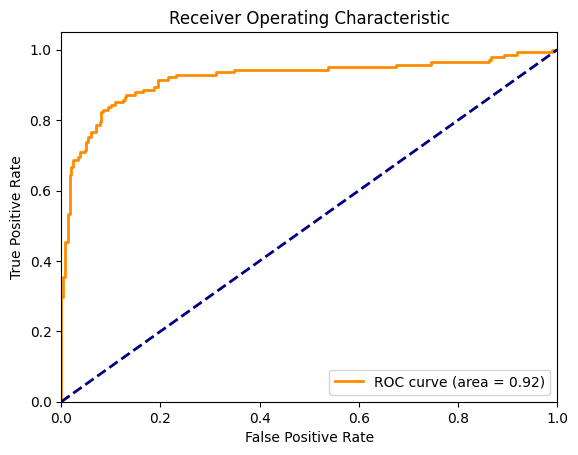

In [ ]:
# Realizar predicciones
y_pred_proba = classifier.predict(X_test_encoded)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Imprimir AUC
print(f"AUC: {roc_auc}")

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

AUC de 0.72

Resultados de Prueba

*   Accuracy: **67.0%**
*   Precision: **42.2%**
*   Sensitivity: **71.8%**
*   Specificity: **65.4%**
*   F1 Score para "0": **0.75**
*   F1 Score para "1": **0.53**

##### Barómetro (Bar)

In [ ]:
print("\nPrimeros 10 valores de Barómetro:\n")
# Mostrar los primeros 10 valores de la columna 'Bar'
print(df['Bar'].head(10))


Primeros 10 valores de Barómetro:

0    [[1013.193859563175, 23.71569457530976], [1013...
1    [[1013.214612231942, 24.11322125434876], [1013...
2    [[1013.25438772214, 24.49373892784119], [1013....
3    [[1013.167161107663, 24.72971366882324], [1013...
4    [[1013.304382379492, 25.49256420612335], [1013...
5    [[1013.230161870285, 25.81876062870026], [1013...
6    [[1013.334809656024, 26.10670359611511], [1013...
7    [[1013.193141805044, 26.26798661708832], [1013...
8    [[1013.347202020856, 26.88757157802582], [1013...
9    [[1013.193350133783, 27.02700508594513], [1013...
Name: Bar, dtype: object


In [ ]:
# Función para extraer características de una serie temporal
def extract_features_from_series(series):
    series = np.asarray(series)  # Asegurarse de que sea un array de NumPy
    series = series.astype(float)  # Convertir a flotante para evitar overflow

    return {
        'mean': np.mean(series),
        'std': np.std(series),
        'var': np.var(series),
        'max': np.max(series),
        'min': np.min(series),
        'range': np.ptp(series),  # np.ptp es equivalente a np.max - np.min pero más seguro
        'kurtosis': pd.Series(series).kurtosis(),
        'skewness': pd.Series(series).skew()
    }

# Función para procesar cada fila de datos
def process_bar_row(bar_data):
    x_vals = np.array([point[0] for point in bar_data])
    y_vals = np.array([point[1] for point in bar_data])

    # Asegurarse de que cada valor sea numérico y no una lista o array multidimensional
    x_features = extract_features_from_series(x_vals)
    y_features = extract_features_from_series(y_vals)

    # Combinar todas las características en un solo vector (diccionario)
    bar_features = {f'x_{key}': val for key, val in x_features.items()}
    bar_features.update({f'y_{key}': val for key, val in y_features.items()})

    return bar_features

# Separamos características y preparamos datos:
df_train_neck_features = df_train_neck[feature_cols_bar].apply(lambda row: process_bar_row(row['Bar']), axis=1)
df_train_neck_features = pd.DataFrame(df_train_neck_features.tolist())
X_train_neck_bar = df_train_neck_features
y_train_neck_bar = df_train_neck[target_col]

df_test_neck_features = df_test_neck[feature_cols_bar].apply(lambda row: process_bar_row(row['Bar']), axis=1)
df_test_neck_features = pd.DataFrame(df_test_neck_features.tolist())
X_test_neck_bar = df_test_neck_features
y_test_neck_bar = df_test_neck[target_col]

Normalizamos características:

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train_neck_bar = scaler.fit_transform(X_train_neck_bar)
X_test_neck_bar = scaler.transform(X_test_neck_bar)

In [ ]:
# Dividir el conjunto de datos en entrenamiento y validación
X_train_neck_bar, X_val_neck_bar, y_train_neck_bar, y_val_neck_bar = train_test_split(X_train_neck_bar, y_train_neck_bar, test_size=0.2, random_state=42)

###### 1. **Modelo k-NN**

Realizamos predicciones:

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_neck_bar, y_train_neck_bar)
y_pred = knn.predict(X_test_neck_bar)

Evaluación del modelo:

In [ ]:
# Evaluación en el conjunto de validación
y_val_pred_neck_bar_knn = knn.predict(X_val_neck_bar)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_bar, y_val_pred_neck_bar_knn)
val_precision = precision_score(y_val_neck_bar, y_val_pred_neck_bar_knn, average='binary')
val_recall = recall_score(y_val_neck_bar, y_val_pred_neck_bar_knn, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_bar, y_val_pred_neck_bar_knn).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_bar, y_val_pred_neck_bar_knn)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_bar, y_val_pred_neck_bar_knn).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_bar, y_val_pred_neck_bar_knn))

# Guardar métricas de validación en un diccionario
res_val_neck_bar_knn = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.9056603773584906
Validation Precision: 0.9081632653061225
Validation Sensitivity: 0.7739130434782608
Validation Specificity: 0.96484375
Validation Balanced Accuracy: 0.8693783967391304

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       256
           1       0.91      0.77      0.84       115

    accuracy                           0.91       371
   macro avg       0.91      0.87      0.88       371
weighted avg       0.91      0.91      0.90       371



In [ ]:
# Evaluación en el conjunto de prueba
y_test_pred_neck_bar_knn = knn.predict(X_test_neck_bar)

print("\nTest Accuracy:", accuracy_score(y_test_neck_bar, y_test_pred_neck_bar_knn))
print("Test Precision:", precision_score(y_test_neck_bar, y_test_pred_neck_bar_knn, average='binary'))
print("Test Sensitivity:", recall_score(y_test_neck_bar, y_test_pred_neck_bar_knn, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test_neck_bar, y_test_pred_neck_bar_knn).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_neck_bar, y_test_pred_neck_bar_knn))

print("\nTest Classification Report:\n", classification_report(y_test_neck_bar, y_test_pred_neck_bar_knn))


Test Accuracy: 0.8838268792710706
Test Precision: 0.875
Test Sensitivity: 0.7446808510638298
Test Specificity: 0.9496644295302014
Test Balanced Accuracy: 0.8471726402970156

Test Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       298
           1       0.88      0.74      0.80       141

    accuracy                           0.88       439
   macro avg       0.88      0.85      0.86       439
weighted avg       0.88      0.88      0.88       439



Resultados de Validación

*   Accuracy: **90.6%**
*   Precision: **90.8%**
*   Sensitivity: **77.4%**
*   Specificity: **96.5%**
*   F1 Score para "0": **0.93**
*   F1 Score para "1": **0.84**

Estos resultados muestran ...

Resultados de Prueba

*   Accuracy: **83.2%**
*   Precision: **73.7%**
*   Sensitivity: **55.5%**
*   Specificity: **93.0%**
*   F1 Score para "0": **0.89**
*   F1 Score para "1": **0.63**

En comparación con los resultados de validación, los resultados del conjunto de prueba muestran ...

###### 2. **Modelo SVM**

In [ ]:
# Crear el modelo SVM
svm_model = SVC(kernel='linear')  # Puedes probar otros kernels como 'rbf', 'poly', etc.

# Entrenar el modelo
svm_model.fit(X_train_neck_bar, y_train_neck_bar)

# Hacer predicciones en el conjunto de validación
y_val_pred_neck_bar_svm = svm_model.predict(X_val_neck_bar)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_bar, y_val_pred_neck_bar_svm)
val_precision = precision_score(y_val_neck_bar, y_val_pred_neck_bar_svm, average='binary')
val_recall = recall_score(y_val_neck_bar, y_val_pred_neck_bar_svm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_bar, y_val_pred_neck_bar_svm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_bar, y_val_pred_neck_bar_svm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_bar, y_val_pred_neck_bar_svm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_bar, y_val_pred_neck_bar_svm))

# Guardar métricas de validación en un diccionario
res_val_neck_bar_svm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.9191374663072777
Validation Precision: 0.9473684210526315
Validation Sensitivity: 0.782608695652174
Validation Specificity: 0.98046875
Validation Balanced Accuracy: 0.8815387228260869

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94       256
           1       0.95      0.78      0.86       115

    accuracy                           0.92       371
   macro avg       0.93      0.88      0.90       371
weighted avg       0.92      0.92      0.92       371



In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred_neck_bar_svm = svm_model.predict(X_test_neck_bar)

# Evaluar el modelo en el conjunto de prueba
print(f"\nTest Accuracy:", accuracy_score(y_test_neck_bar, y_test_pred_neck_bar_svm))
print(f"Test Precision:", precision_score(y_test_neck_bar, y_test_pred_neck_bar_svm))
print(f"Test Sensitivity:", recall_score(y_test_neck_bar, y_test_pred_neck_bar_svm))
tn, fp, fn, tp = confusion_matrix(y_test_neck_bar, y_test_pred_neck_bar_svm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_neck_bar, y_test_pred_neck_bar_svm))

print("\nTest Classification Report:", classification_report(y_test_neck_bar, y_test_pred_neck_bar_svm))


Test Accuracy: 0.908883826879271
Test Precision: 0.9243697478991597
Test Sensitivity: 0.7801418439716312
Test Specificity: 0.9697986577181208
Test Balanced Accuracy: 0.874970250844876

Test Classification Report:               precision    recall  f1-score   support

           0       0.90      0.97      0.94       298
           1       0.92      0.78      0.85       141

    accuracy                           0.91       439
   macro avg       0.91      0.87      0.89       439
weighted avg       0.91      0.91      0.91       439



Ajuste de Hiperparámetros con GridSearchCV:

In [ ]:
# Definir los hiperparámetros a probar
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']  # solo afecta a algunos kernels
}

# Crear el modelo SVM
svm_model = SVC()

# Implementar GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar el modelo con GridSearchCV
grid_search.fit(X_train_neck_bar, y_train_neck_bar)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Usar el mejor modelo encontrado
best_svm_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de validación
y_val_pred_neck_bar_svm = best_svm_model.predict(X_val_neck_bar)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_bar, y_val_pred_neck_bar_svm)
val_precision = precision_score(y_val_neck_bar, y_val_pred_neck_bar_svm, average='binary')
val_recall = recall_score(y_val_neck_bar, y_val_pred_neck_bar_svm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_bar, y_val_pred_neck_bar_svm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_bar, y_val_pred_neck_bar_svm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_bar, y_val_pred_neck_bar_svm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_bar, y_val_pred_neck_bar_svm))

# Guardar métricas de validación en un diccionario
res_val_neck_bar_svm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

Mejores hiperparámetros: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

Validation Accuracy: 0.9353099730458221
Validation Precision: 0.9595959595959596
Validation Sensitivity: 0.8260869565217391
Validation Specificity: 0.984375
Validation Balanced Accuracy: 0.9052309782608696

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95       256
           1       0.96      0.83      0.89       115

    accuracy                           0.94       371
   macro avg       0.94      0.91      0.92       371
weighted avg       0.94      0.94      0.93       371



Validación Cruzada

In [ ]:
# Realizar validación cruzada con los mejores parámetros
cv_scores = cross_val_score(best_svm_model, X_train_neck_bar, y_train_neck_bar, cv=5, scoring='accuracy')

print(f"Validation Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean()}")

Validation Cross-Validation Scores: [0.93265993 0.93265993 0.90572391 0.93581081 0.93581081]
Mean Cross-Validation Accuracy: 0.9285330785330785


Evaluación del Modelo en el Conjunto de Prueba

In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred_neck_bar_svm = best_svm_model.predict(X_test_neck_bar)

# Evaluar el modelo en el conjunto de prueba
print(f"\nTest Accuracy:", accuracy_score(y_test_neck_bar, y_test_pred_neck_bar_svm))
print(f"Test Precision:", precision_score(y_test_neck_bar, y_test_pred_neck_bar_svm))
print(f"Test Sensitivity:", recall_score(y_test_neck_bar, y_test_pred_neck_bar_svm))
tn, fp, fn, tp = confusion_matrix(y_test_neck_bar, y_test_pred_neck_bar_svm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_neck_bar, y_test_pred_neck_bar_svm))

print("\nTest Classification Report:", classification_report(y_test_neck_bar, y_test_pred_neck_bar_svm))


Test Accuracy: 0.9225512528473804
Test Precision: 0.9212598425196851
Test Sensitivity: 0.8297872340425532
Test Specificity: 0.9664429530201343
Test Balanced Accuracy: 0.8981150935313438

Test Classification Report:               precision    recall  f1-score   support

           0       0.92      0.97      0.94       298
           1       0.92      0.83      0.87       141

    accuracy                           0.92       439
   macro avg       0.92      0.90      0.91       439
weighted avg       0.92      0.92      0.92       439



Mejora con GridSearchCV:

Resultados de Prueba

*   Accuracy: **85.5%**
*   Precision: **83.6%**
*   Sensitivity: **54.9%**
*   Specificity: **96.2%**
*   F1 Score para "0": **0.91**
*   F1 Score para "1": **0.66**

###### 3. **Modelo Random Forest**

In [ ]:
# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')  # Puedes ajustar 'n_estimators' y otros hiperparámetros

# Entrenar el modelo con las características extraídas
rf_model.fit(X_train_neck_bar, y_train_neck_bar)

# Hacer predicciones en el conjunto de validación
y_val_pred_neck_bar_rf = rf_model.predict(X_val_neck_bar)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_bar, y_val_pred_neck_bar_rf)
val_precision = precision_score(y_val_neck_bar, y_val_pred_neck_bar_rf, average='binary')
val_recall = recall_score(y_val_neck_bar, y_val_pred_neck_bar_rf, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_bar, y_val_pred_neck_bar_rf).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_bar, y_val_pred_neck_bar_rf)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_bar, y_val_pred_neck_bar_rf).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_bar, y_val_pred_neck_bar_rf))

# Guardar métricas de validación en un diccionario
res_val_neck_bar_rf = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.954177897574124
Validation Precision: 0.9803921568627451
Validation Sensitivity: 0.8695652173913043
Validation Specificity: 0.9921875
Validation Balanced Accuracy: 0.9308763586956521

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97       256
           1       0.98      0.87      0.92       115

    accuracy                           0.95       371
   macro avg       0.96      0.93      0.94       371
weighted avg       0.96      0.95      0.95       371



In [ ]:
# Realizar predicciones en el conjunto de prueba
y_test_pred_neck_bar_rf = rf_model.predict(X_test_neck_bar)

# Evaluar el rendimiento del modelo
print("\nTest Accuracy:", accuracy_score(y_test_neck_bar, y_test_pred_neck_bar_rf))
print("Test Precision:", precision_score(y_test_neck_bar, y_test_pred_neck_bar_rf, average='binary'))
print("Test Sensitivity (Recall):", recall_score(y_test_neck_bar, y_test_pred_neck_bar_rf, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test_neck_bar, y_test_pred_neck_bar_rf).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_neck_bar, y_test_pred_neck_bar_rf))

print("\nTest Classification Report:\n", classification_report(y_test_neck_bar, y_test_pred_neck_bar_rf))


Test Accuracy: 0.9339407744874715
Test Precision: 0.9375
Test Sensitivity (Recall): 0.851063829787234
Test Specificity: 0.9731543624161074
Test Balanced Accuracy: 0.9121090961016707

Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       298
           1       0.94      0.85      0.89       141

    accuracy                           0.93       439
   macro avg       0.93      0.91      0.92       439
weighted avg       0.93      0.93      0.93       439



Resultados de Prueba

*   Accuracy: **87.0%**
*   Precision: **90.9%**
*   Sensitivity: **55.8%**
*   Specificity: **98.0%**
*   F1 Score para "0": **0.92**
*   F1 Score para "1": **0.69**

###### 4. **Modelo LSTM**

Padding y división de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_neck[feature_cols_bar].applymap(len).max().max()
print(f"Longitud máxima de secuencia: {max_length}")

Longitud máxima de secuencia: 200


<ipython-input-164-0aea062c25a0>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_neck[feature_cols_bar].applymap(len).max().max()


In [ ]:
# Crear un índice de validación a partir de la división de entrenamiento y validación
train_indices, val_indices = train_test_split(df_train_neck.index, test_size=0.2, random_state=42)

# Crear los conjuntos de secuencias de entrenamiento y validación
df_train_neck_train = df_train_neck.loc[train_indices]
df_train_neck_val = df_train_neck.loc[val_indices]

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols_bar, max_length):
    padded_features = []
    for col in feature_cols_bar:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)

            # No es necesario agregar dimensiones adicionales aquí, solo aseguramos que haya 2 columnas
            if sequence.shape[1] == 2:  # Confirma que las secuencias tienen solo 2 dimensiones (x, y)
                if len(sequence) < max_length:
                    # Realizar padding solo en la longitud de la secuencia
                    padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
                else:
                    padded_sequence = sequence[:max_length]
                padded_col.append(padded_sequence)
            else:
                print(f"Unexpected number of dimensions: {sequence.shape[1]}")
                raise ValueError(f"Las secuencias deben tener exactamente 2 dimensiones, pero se encontró {sequence.shape[1]}.")

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_neck_train, feature_cols_bar, max_length)
y_train = df_train_neck_train[target_col].values

# Aplicar padding al conjunto de validación
X_val_neck_bar = pad_sequences_feature(df_train_neck_val, feature_cols_bar, max_length)
y_val_neck_bar = df_train_neck_val[target_col].values

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalizar las características del conjunto de validación
X_val_neck_bar = scaler.transform(X_val_neck_bar.reshape(-1, X_val_neck_bar.shape[-1])).reshape(X_val_neck_bar.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test_neck, feature_cols_bar, max_length)
y_test = df_test_neck[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Configurar la semilla para la reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
print("Dimensiones de X_train:")
print(f"Forma: {X_train.shape}")
print(f"Número de muestras: {X_train.shape[0]}")
print(f"Longitud de secuencia (timesteps): {X_train.shape[1]}")
print(f"Número de características: {X_train.shape[2]}")

print("\nDimensiones de X_test:")
print(f"Forma: {X_test.shape}")
print(f"Número de muestras: {X_test.shape[0]}")
print(f"Longitud de secuencia (timesteps): {X_test.shape[1]}")
print(f"Número de características: {X_test.shape[2]}")

Dimensiones de X_train:
Forma: (1483, 200, 2)
Número de muestras: 1483
Longitud de secuencia (timesteps): 200
Número de características: 2

Dimensiones de X_test:
Forma: (439, 200, 2)
Número de muestras: 439
Longitud de secuencia (timesteps): 200
Número de características: 2


In [ ]:
# Verificar la forma de entrada esperada para el modelo
input_shape = (200, 2)  # Esto debe coincidir con las dimensiones de tus datos

print(f"Forma de entrada esperada para el modelo: {input_shape}")

Forma de entrada esperada para el modelo: (200, 2)


*  Menor Tiempo de Cómputo: RandomizedSearchCV es mucho más rápido que GridSearchCV para grandes espacios de hiperparámetros.
*  Exploración Eficiente: Aunque no prueba todas las combinaciones posibles, es probable que encuentre una buena combinación de hiperparámetros en menos tiempo.

In [ ]:
# Crear el modelo LSTM
model = Sequential()
model.add(Masking(mask_value=0., input_shape=input_shape))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con pesos de clase
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val_neck_bar, y_val_neck_bar), class_weight=class_weights)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5451 - loss: 0.6709 - val_accuracy: 0.6685 - val_loss: 0.6356
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6312 - loss: 0.6433 - val_accuracy: 0.6658 - val_loss: 0.6226
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6401 - loss: 0.6373 - val_accuracy: 0.6927 - val_loss: 0.6060
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6206 - loss: 0.6249 - val_accuracy: 0.6685 - val_loss: 0.6079
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6058 - loss: 0.6275 - val_accuracy: 0.6819 - val_loss: 0.5883
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6882 - loss: 0.6078 - val_accuracy: 0.7466 - val_loss: 0.5818
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7097 - loss: 0.6380 - val_accuracy: 0.7251 - val_loss: 0.6120
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6958 - loss: 0.6214 - val_accuracy: 0.6119 - v

In [ ]:
# Realizar predicciones en el conjunto de validación
y_val_pred_neck_bar_lstm = (model.predict(X_val_neck_bar) > 0.5).astype("int32").ravel()

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_bar, y_val_pred_neck_bar_lstm)
val_precision = precision_score(y_val_neck_bar, y_val_pred_neck_bar_lstm, average='binary')
val_recall = recall_score(y_val_neck_bar, y_val_pred_neck_bar_lstm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_bar, y_val_pred_neck_bar_lstm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_bar, y_val_pred_neck_bar_lstm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_bar, y_val_pred_neck_bar_lstm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_bar, y_val_pred_neck_bar_lstm))

# Guardar métricas de validación en un diccionario
res_val_neck_bar_lstm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

Validation Accuracy: 0.706199460916442
Validation Precision: 0.5230769230769231
Validation Sensitivity: 0.591304347826087
Validation Specificity: 0.7578125
Validation Balanced Accuracy: 0.6745584239130435

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.76      0.78       256
           1       0.52      0.59      0.56       115

    accuracy                           0.71       371
   macro avg       0.66      0.67      0.67       371
weighted avg       0.72      0.71      0.71       371



In [ ]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Realizar predicciones en el conjunto de prueba
y_test_pred_neck_bar_lstm = (model.predict(X_test) > 0.5).astype("int32").ravel()

print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_neck_bar_lstm))
print("Test Precision:", precision_score(y_test, y_test_pred_neck_bar_lstm, average='binary'))
print("Test Sensitivity:", recall_score(y_test, y_test_pred_neck_bar_lstm, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_neck_bar_lstm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_neck_bar_lstm))

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_neck_bar_lstm))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6672 - loss: 0.5968
Loss: 0.5785956978797913, Accuracy: 0.6697039008140564
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Test Accuracy: 0.6697038724373576
Test Precision: 0.4880952380952381
Test Sensitivity: 0.5815602836879432
Test Specificity: 0.7114093959731543
Test Balanced Accuracy: 0.6464848398305487

Test Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.71      0.75       298
           1       0.49      0.58      0.53       141

    accuracy                           0.67       439
   macro avg       0.64      0.65      0.64       439
weighted avg       0.69      0.67      0.68       439



14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
AUC: 0.7257127897567708


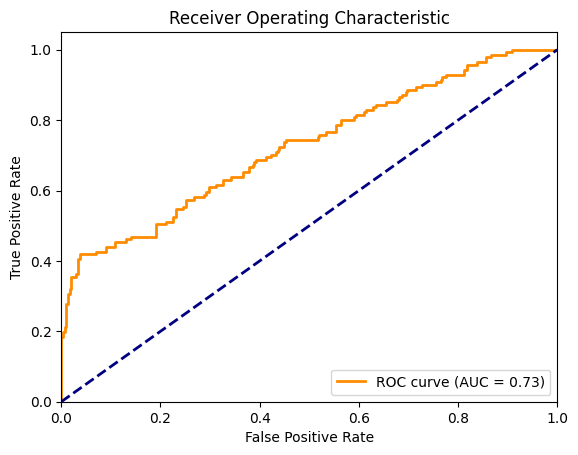

In [ ]:
# Calcular probabilidades de predicción
y_pred_proba = model.predict(X_test)

# Calcular curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Imprimir AUC
print(f"AUC: {roc_auc}")

# Graficar curva ROC
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Resultados de Prueba

*   Accuracy: **67.5%**
*   Precision: **38.3%**
*   Sensitivity: **40.4%**
*   Specificity: **77.0%**
*   F1 Score para "0": **0.78**
*   F1 Score para "1": **0.39**


###### 5. **Modelo CNN**

In [ ]:
# Definir el modelo
model = Sequential()
model.add(Input(shape=(200, 2)))  # Definir explícitamente el tamaño de entrada
model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val_neck_bar, y_val_neck_bar))

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.6629 - loss: 0.6538 - val_accuracy: 0.7358 - val_loss: 0.6290
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7372 - loss: 0.6019 - val_accuracy: 0.7143 - val_loss: 0.5994
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7330 - loss: 0.5844 - val_accuracy: 0.7493 - val_loss: 0.5863
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7407 - loss: 0.5744 - val_accuracy: 0.7466 - val_loss: 0.5657
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7408 - loss: 0.5623 - val_accuracy: 0.7385 - val_loss: 0.5535
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7399 - loss: 0.5567 - val_accuracy: 0.7493 - val_loss: 0.5539
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7425 - loss: 0.5530 - val_accuracy: 0.7520 - val_loss: 0.5454
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7384 - loss: 0.5498 - val_accuracy: 0.7547 - val_loss

In [ ]:
# Evaluar el modelo en el conjunto de validación
y_val_pred_neck_bar_cnn = model.predict(X_val_neck_bar).ravel()  # Genera predicciones
y_val_pred_neck_bar_cnn = (y_val_pred_neck_bar_cnn > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_bar, y_val_pred_neck_bar_cnn)
val_precision = precision_score(y_val_neck_bar, y_val_pred_neck_bar_cnn, average='binary')
val_recall = recall_score(y_val_neck_bar, y_val_pred_neck_bar_cnn, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_bar, y_val_pred_neck_bar_cnn).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_bar, y_val_pred_neck_bar_cnn)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_bar, y_val_pred_neck_bar_cnn).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_bar, y_val_pred_neck_bar_cnn))

# Guardar métricas de validación en un diccionario
res_val_neck_bar_cnn = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Validation Accuracy: 0.738544474393531
Validation Precision: 0.8
Validation Sensitivity: 0.20869565217391303
Validation Specificity: 0.9765625
Validation Balanced Accuracy: 0.5926290760869565

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.98      0.84       256
           1       0.80      0.21      0.33       115

    accuracy                           0.74       371
   macro avg       0.77      0.59      0.58       371
weighted avg       0.75      0.74      0.68       371



In [ ]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred_neck_bar_cnn = model.predict(X_test).ravel()  # Genera predicciones
y_test_pred_neck_bar_cnn = (y_test_pred_neck_bar_cnn > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias

# Cálculo de métricas
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_neck_bar_cnn))
print("Test Precision:", precision_score(y_test, y_test_pred_neck_bar_cnn, average='binary'))
print("Test Sensitivity (Recall):", recall_score(y_test, y_test_pred_neck_bar_cnn, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_neck_bar_cnn).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_neck_bar_cnn))

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_neck_bar_cnn))

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

Test Accuracy: 0.7471526195899773
Test Precision: 0.875
Test Sensitivity (Recall): 0.24822695035460993
Test Specificity: 0.9832214765100671
Test Balanced Accuracy: 0.6157242134323385

Test Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.98      0.84       298
           1       0.88      0.25      0.39       141

    accuracy                           0.75       439
   macro avg       0.80      0.62      0.61       439
weighted avg       0.78      0.75      0.69       439



Validación Cruzada K-Fold:

In [ ]:
# Definir el número de folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Inicializar listas para almacenar los resultados de cada fold
accuracy_per_fold = []
loss_per_fold = []
precision_per_fold = []
recall_per_fold = []
specificity_per_fold = []
f1_per_fold = []
balanced_accuracy_per_fold = []

# Iterar sobre cada fold
for train_index, val_index in kf.split(X_train):
    # Dividir los datos en entrenamiento y validación
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Definir el modelo (es importante definirlo dentro del loop para reiniciarlo en cada fold)
    model = Sequential()
    model.add(Input(shape=(200, 2)))  # Definir explícitamente el tamaño de entrada
    model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo en el fold actual
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)

    # Evaluar el modelo en el conjunto de validación del fold actual
    y_val_pred = model.predict(X_val_fold).ravel()
    y_val_pred = (y_val_pred > 0.5).astype(int)

    # Cálculo de métricas para el fold actual
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    loss = model.evaluate(X_val_fold, y_val_fold, verbose=0)[0]
    precision = precision_score(y_val_fold, y_val_pred)
    recall = recall_score(y_val_fold, y_val_pred)
    f1 = f1_score(y_val_fold, y_val_pred)
    cm = confusion_matrix(y_val_fold, y_val_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    balanced_accuracy = balanced_accuracy_score(y_val_fold, y_val_pred)

    # Almacenar las métricas para este fold
    accuracy_per_fold.append(accuracy)
    loss_per_fold.append(loss)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    specificity_per_fold.append(specificity)
    f1_per_fold.append(f1)
    balanced_accuracy_per_fold.append(balanced_accuracy)

# Mostrar resultados promedio de las métricas de k-fold
print(f'\nMean Accuracy (k-Fold): {np.mean(accuracy_per_fold)}')
print(f'Mean Loss (k-Fold): {np.mean(loss_per_fold)}')
print(f'Mean Precision (k-Fold): {np.mean(precision_per_fold)}')
print(f'Mean Recall (k-Fold): {np.mean(recall_per_fold)}')
print(f'Mean Specificity (k-Fold): {np.mean(specificity_per_fold)}')
print(f'Mean F1 Score (k-Fold): {np.mean(f1_per_fold)}')
print(f'Mean Balanced Accuracy (k-Fold): {np.mean(balanced_accuracy_per_fold)}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Mean Accuracy (k-Fold): 0.7471676221676222
Mean Loss (k-Fold): 0.5450315237045288
Mean Precision (k-Fold): 0.7449573817994871
Mean Recall (k-Fold): 0.32580908958223953
Mean Specificity (k-Fold): 0.9473039566454553
Mean F1 Score (k-Fold): 0.45268944593650123
Mean Balanced Accuracy (k-Fold): 0.6365565231138475


**Mean Accuracy**:

**Mean Precision**:

**Mean Sensitivity**:

**Mean Specifity**:

**Mean F1 Score**:

###### 6. **Modelo SAE**

Padding y división de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_neck[feature_cols_bar].applymap(len).max().max()
print(f"Longitud máxima de secuencia: {max_length}")

Longitud máxima de secuencia: 200


<ipython-input-180-0aea062c25a0>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_neck[feature_cols_bar].applymap(len).max().max()


In [ ]:
# Crear un índice de validación a partir de la división de entrenamiento y validación
train_indices, val_indices = train_test_split(df_train_neck.index, test_size=0.2, random_state=42)

# Crear los conjuntos de secuencias de entrenamiento y validación
df_train_neck_train = df_train_neck.loc[train_indices]
df_train_neck_val = df_train_neck.loc[val_indices]

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols_bar, max_length):
    padded_features = []
    for col in feature_cols_bar:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)

            # No es necesario agregar dimensiones adicionales aquí, solo aseguramos que haya 2 columnas
            if sequence.shape[1] == 2:  # Confirma que las secuencias tienen solo 2 dimensiones (x, y)
                if len(sequence) < max_length:
                    # Realizar padding solo en la longitud de la secuencia
                    padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
                else:
                    padded_sequence = sequence[:max_length]
                padded_col.append(padded_sequence)
            else:
                print(f"Unexpected number of dimensions: {sequence.shape[1]}")
                raise ValueError(f"Las secuencias deben tener exactamente 2 dimensiones, pero se encontró {sequence.shape[1]}.")

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_neck_train, feature_cols_bar, max_length)
y_train = df_train_neck_train[target_col].values

# Aplicar padding al conjunto de validación
X_val_neck_bar = pad_sequences_feature(df_train_neck_val, feature_cols_bar, max_length)
y_val_neck_bar = df_train_neck_val[target_col].values

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalizar las características del conjunto de validación
X_val_neck_bar = scaler.transform(X_val_neck_bar.reshape(-1, X_val_neck_bar.shape[-1])).reshape(X_val_neck_bar.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test_neck, feature_cols_bar, max_length)
y_test = df_test_neck[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")

Forma de X_train: (1483, 200, 2)
Forma de X_test: (439, 200, 2)


*  **1854 / 1321** son el número de muestras para el conjunto de entrenamiento y prueba, respectivamente.
*  **200** es la longitud de la ventana de tiempo (en muestras) para cada señal.
*  **2** representa el número de características por cada paso temporal. Cada paso temporal tiene 2 características (por ejemplo, las variables x y y extraídas de los datos de Bar).

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Configurar la semilla para la reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
# Parámetros
input_shape = (200, 2)  # Ajusta esto a la forma de tu entrada
kernel_size = 7
filters = [32, 64]  # Número de filtros en cada capa convolucional

# Definir la función de autoencoder
def build_autoencoder(input_shape, filters, kernel_size):
    input_layer = Input(shape=input_shape)

    # Encoder
    x = Conv1D(filters=filters[0], kernel_size=kernel_size, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)

    # Bottleneck
    bottleneck_shape = x.shape[1:]  # Obtiene la forma después de las capas convolucionales y de pooling
    x = Flatten()(x)
    bottleneck = Dense(128, activation='relu')(x)  # Puedes ajustar la dimensión del bottleneck

    # Decoder
    x = Dense(np.prod(bottleneck_shape), activation='relu')(bottleneck)
    x = Reshape(bottleneck_shape)(x)  # Redimensiona a la forma adecuada para las capas convolucionales de decodificación
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=input_shape[1], kernel_size=kernel_size, activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_layer, x)
    encoder = Model(input_layer, bottleneck)

    return autoencoder, encoder

# Construir el autoencoder
autoencoder, encoder = build_autoencoder(input_shape, filters, kernel_size)

# Compilar el autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenar el autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2)

# Extraer las características usando el encoder
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val_neck_bar)
X_test_encoded = encoder.predict(X_test)

# Crear el clasificador denso
def build_classifier(input_shape):
    input_layer = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input_layer)
    x = Dense(32, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    classifier = Model(input_layer, output_layer)
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return classifier

# Construir el clasificador
classifier = build_classifier(X_train_encoded.shape[1:])

# Entrenar el clasificador
classifier.fit(X_train_encoded, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weights)

# Evaluar el clasificador
loss, accuracy = classifier.evaluate(X_test_encoded, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.9629 - val_loss: 0.6300
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6595 - val_loss: 0.5810
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6352 - val_loss: 0.5989
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6323 - val_loss: 0.5696
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6191 - val_loss: 0.5634
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6155 - val_loss: 0.5594
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6134 - val_loss: 0.5579
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6128 - val_loss: 0.5578
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6126 - val_loss: 0.5578
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6126 - val_loss: 0.5617
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
# Realizar predicciones
y_val_pred_neck_bar_sae = (classifier.predict(X_val_encoded) > 0.5).astype(int).ravel()

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_neck_bar, y_val_pred_neck_bar_sae)
val_precision = precision_score(y_val_neck_bar, y_val_pred_neck_bar_sae, average='binary')
val_recall = recall_score(y_val_neck_bar, y_val_pred_neck_bar_sae, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_neck_bar, y_val_pred_neck_bar_sae).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_neck_bar, y_val_pred_neck_bar_sae)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_neck_bar, y_val_pred_neck_bar_sae).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_neck_bar, y_val_pred_neck_bar_sae))

# Guardar métricas de validación en un diccionario
res_val_neck_bar_sae = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Validation Accuracy: 0.601078167115903
Validation Precision: 0.40350877192982454
Validation Sensitivity: 0.6
Validation Specificity: 0.6015625
Validation Balanced Accuracy: 0.60078125

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.60      0.68       256
           1       0.40      0.60      0.48       115

    accuracy                           0.60       371
   macro avg       0.59      0.60      0.58       371
weighted avg       0.66      0.60      0.62       371



In [ ]:
# Realizar predicciones
y_test_pred_neck_bar_sae = (classifier.predict(X_test_encoded) > 0.5).astype(int).ravel()

# Cálculo de métricas
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_neck_bar_sae))
print("Test Precision:", precision_score(y_test, y_test_pred_neck_bar_sae, average='binary'))
print("Test Sensitivity:", recall_score(y_test, y_test_pred_neck_bar_sae, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_neck_bar_sae).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_neck_bar_sae))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_neck_bar_sae))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Test Accuracy: 0.5694760820045558
Test Precision: 0.39090909090909093
Test Sensitivity: 0.6099290780141844
Test Specificity: 0.5503355704697986
Test Balanced Accuracy: 0.5801323242419916

Test Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.55      0.63       298
           1       0.39      0.61      0.48       141

    accuracy                           0.57       439
   macro avg       0.57      0.58      0.56       439
weighted avg       0.63      0.57      0.58       439



14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
AUC: 0.671688324051597


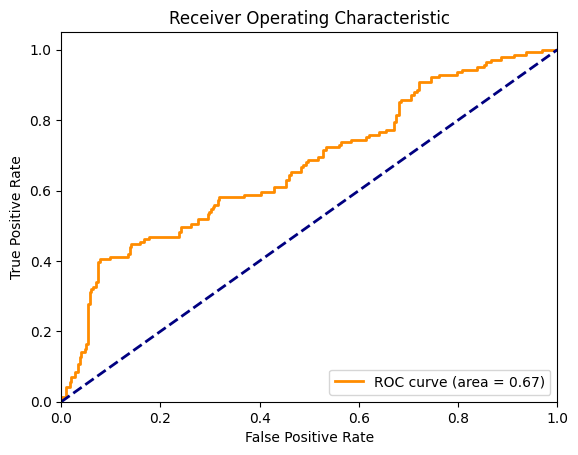

In [ ]:
# Realizar predicciones
y_pred_proba = classifier.predict(X_test_encoded)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Imprimir AUC
print(f"AUC: {roc_auc}")

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

AUC de 0.63

Resultados de Prueba

*   Accuracy: **58.0%**
*   Precision: **31.9%**
*   Sensitivity: **54.1%**
*   Specificity: **59.5%**
*   F1 Score para "0": **0.68**
*   F1 Score para "1": **0.40**

#### Dispositivo 2 (Cintura)

##### Acelerómetro (Acc)

In [ ]:
# Función para extraer características de una serie temporal
def extract_features_from_series(series):
    series = np.asarray(series)  # Asegurarse de que sea un array de NumPy
    series = series.astype(float)  # Convertir a flotante para evitar overflow

    return {
        'mean': np.mean(series),
        'std': np.std(series),
        'var': np.var(series),
        'max': np.max(series),
        'min': np.min(series),
        'range': np.ptp(series),  # np.ptp es equivalente a np.max - np.min pero más seguro
        'kurtosis': pd.Series(series).kurtosis(),
        'skewness': pd.Series(series).skew()
    }

# Función para procesar cada fila de datos
def process_acc_row(acc_data):
    x_vals = np.array([point[0] for point in acc_data])
    y_vals = np.array([point[1] for point in acc_data])
    z_vals = np.array([point[2] for point in acc_data])

    # Asegurarse de que cada valor sea numérico y no una lista o array multidimensional
    x_features = extract_features_from_series(x_vals)
    y_features = extract_features_from_series(y_vals)
    z_features = extract_features_from_series(z_vals)

    # Combinar todas las características en un solo vector (diccionario)
    acc_features = {f'x_{key}': val for key, val in x_features.items()}
    acc_features.update({f'y_{key}': val for key, val in y_features.items()})
    acc_features.update({f'z_{key}': val for key, val in z_features.items()})

    return acc_features

# Separamos características y preparamos datos:
df_train_waist_features = df_train_waist[feature_cols_acc].apply(lambda row: process_acc_row(row['Acc']), axis=1)
df_train_waist_features = pd.DataFrame(df_train_waist_features.tolist())
X_train_waist_acc = df_train_waist_features
y_train_waist_acc = df_train_waist[target_col]

df_test_waist_features = df_test_waist[feature_cols_acc].apply(lambda row: process_acc_row(row['Acc']), axis=1)
df_test_waist_features = pd.DataFrame(df_test_waist_features.tolist())
X_test_waist_acc = df_test_waist_features
y_test_waist_acc = df_test_waist[target_col]

Normalizamos características:

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train_waist_acc = scaler.fit_transform(X_train_waist_acc)
X_test_waist_acc = scaler.transform(X_test_waist_acc)

In [ ]:
# Dividir el conjunto de datos en entrenamiento y validación
X_train_waist_acc, X_val_waist_acc, y_train_waist_acc, y_val_waist_acc = train_test_split(X_train_waist_acc, y_train_waist_acc, test_size=0.2, random_state=42)

###### 1. **Modelo k-NN**

Realizamos predicciones:

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_waist_acc, y_train_waist_acc)
y_pred = knn.predict(X_test_waist_acc)

Evaluación del modelo:

In [ ]:
# Evaluación en el conjunto de validación
y_val_pred_waist_acc_knn = knn.predict(X_val_waist_acc)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_acc, y_val_pred_waist_acc_knn)
val_precision = precision_score(y_val_waist_acc, y_val_pred_waist_acc_knn, average='binary')
val_recall = recall_score(y_val_waist_acc, y_val_pred_waist_acc_knn, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_acc, y_val_pred_waist_acc_knn).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_acc, y_val_pred_waist_acc_knn)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_acc, y_val_pred_waist_acc_knn).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_acc, y_val_pred_waist_acc_knn))

# Guardar métricas de validación en un diccionario
res_val_waist_acc_knn = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.9525423728813559
Validation Precision: 0.9743589743589743
Validation Sensitivity: 0.8636363636363636
Validation Specificity: 0.9903381642512077
Validation Balanced Accuracy: 0.9269872639437857

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97       207
           1       0.97      0.86      0.92        88

    accuracy                           0.95       295
   macro avg       0.96      0.93      0.94       295
weighted avg       0.95      0.95      0.95       295



In [ ]:
# Evaluación en el conjunto de prueba
y_test_pred_waist_acc_knn = knn.predict(X_test_waist_acc)

print("\nTest Accuracy:", accuracy_score(y_test_waist_acc, y_test_pred_waist_acc_knn))
print("Test Precision:", precision_score(y_test_waist_acc, y_test_pred_waist_acc_knn, average='binary'))
print("Test Sensitivity:", recall_score(y_test_waist_acc, y_test_pred_waist_acc_knn, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test_waist_acc, y_test_pred_waist_acc_knn).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_waist_acc, y_test_pred_waist_acc_knn))

print("\nTest Classification Report:\n", classification_report(y_test_waist_acc, y_test_pred_waist_acc_knn))


Test Accuracy: 0.9538461538461539
Test Precision: 0.9444444444444444
Test Sensitivity: 0.8947368421052632
Test Specificity: 0.9782608695652174
Test Balanced Accuracy: 0.9364988558352403

Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       230
           1       0.94      0.89      0.92        95

    accuracy                           0.95       325
   macro avg       0.95      0.94      0.94       325
weighted avg       0.95      0.95      0.95       325



Resultados de Validación

*   Accuracy: **95.2%**
*   Precision: **97.4%**
*   Sensitivity: **86.4%**
*   Specificity: **99.0%**
*   F1 Score para "0": **0.97**
*   F1 Score para "1": **0.92**

Estos resultados muestran...

Resultados de Prueba

*   Accuracy: **87.1%**
*   Precision: **70.5%**
*   Sensitivity: **86.3%**
*   Specificity: **87.3%**
*   F1 Score para "0": **0.91**
*   F1 Score para "1": **0.78**

En comparación con los resultados de validación...

###### 2. **Modelo SVM**

In [ ]:
# Crear el modelo SVM
svm_model = SVC(kernel='linear')  # Puedes probar otros kernels como 'rbf', 'poly', etc.

# Entrenar el modelo
svm_model.fit(X_train_waist_acc, y_train_waist_acc)

# Hacer predicciones en el conjunto de validación
y_val_pred_waist_acc_svm = svm_model.predict(X_val_waist_acc)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_acc, y_val_pred_waist_acc_svm)
val_precision = precision_score(y_val_waist_acc, y_val_pred_waist_acc_svm, average='binary')
val_recall = recall_score(y_val_waist_acc, y_val_pred_waist_acc_svm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_acc, y_val_pred_waist_acc_svm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_acc, y_val_pred_waist_acc_svm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_acc, y_val_pred_waist_acc_svm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_acc, y_val_pred_waist_acc_svm))

# Guardar métricas de validación en un diccionario
res_val_waist_acc_svm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.9423728813559322
Validation Precision: 0.9382716049382716
Validation Sensitivity: 0.8636363636363636
Validation Specificity: 0.9758454106280193
Validation Balanced Accuracy: 0.9197408871321915

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       207
           1       0.94      0.86      0.90        88

    accuracy                           0.94       295
   macro avg       0.94      0.92      0.93       295
weighted avg       0.94      0.94      0.94       295



In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred_waist_acc_svm = svm_model.predict(X_test_waist_acc)

# Evaluar el modelo en el conjunto de prueba
print(f"\nTest Accuracy:", accuracy_score(y_test_waist_acc, y_test_pred_waist_acc_svm))
print(f"Test Precision:", precision_score(y_test_waist_acc, y_test_pred_waist_acc_svm))
print(f"Test Sensitivity:", recall_score(y_test_waist_acc, y_test_pred_waist_acc_svm))
tn, fp, fn, tp = confusion_matrix(y_test_waist_acc, y_test_pred_waist_acc_svm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_waist_acc, y_test_pred_waist_acc_svm))

print("\nTest Classification Report:", classification_report(y_test_waist_acc, y_test_pred_waist_acc_svm))


Test Accuracy: 0.9415384615384615
Test Precision: 0.9318181818181818
Test Sensitivity: 0.8631578947368421
Test Specificity: 0.9739130434782609
Test Balanced Accuracy: 0.9185354691075516

Test Classification Report:               precision    recall  f1-score   support

           0       0.95      0.97      0.96       230
           1       0.93      0.86      0.90        95

    accuracy                           0.94       325
   macro avg       0.94      0.92      0.93       325
weighted avg       0.94      0.94      0.94       325



Ajuste de Hiperparámetros con GridSearchCV:

In [ ]:
# Definir los hiperparámetros a probar
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']  # solo afecta a algunos kernels
}

# Crear el modelo SVM
svm_model = SVC()

# Implementar GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar el modelo con GridSearchCV
grid_search.fit(X_train_waist_acc, y_train_waist_acc)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Usar el mejor modelo encontrado
best_svm_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de validación
y_val_pred_waist_acc_svm = best_svm_model.predict(X_val_waist_acc)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_acc, y_val_pred_waist_acc_svm)
val_precision = precision_score(y_val_waist_acc, y_val_pred_waist_acc_svm, average='binary')
val_recall = recall_score(y_val_waist_acc, y_val_pred_waist_acc_svm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_acc, y_val_pred_waist_acc_svm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_acc, y_val_pred_waist_acc_svm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_acc, y_val_pred_waist_acc_svm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_acc, y_val_pred_waist_acc_svm))

# Guardar métricas de validación en un diccionario
res_val_waist_acc_svm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

Mejores hiperparámetros: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Validation Accuracy: 0.9694915254237289
Validation Precision: 0.9647058823529412
Validation Sensitivity: 0.9318181818181818
Validation Specificity: 0.9855072463768116
Validation Balanced Accuracy: 0.9586627140974967

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       207
           1       0.96      0.93      0.95        88

    accuracy                           0.97       295
   macro avg       0.97      0.96      0.96       295
weighted avg       0.97      0.97      0.97       295



Validación Cruzada

In [ ]:
# Realizar validación cruzada con los mejores parámetros
cv_scores = cross_val_score(best_svm_model, X_train_waist_acc, y_train_waist_acc, cv=5, scoring='accuracy')

print(f"Validation Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean()}")

Validation Cross-Validation Scores: [0.95762712 0.95762712 0.97446809 0.96170213 0.96595745]
Mean Cross-Validation Accuracy: 0.9634763793725206


Evaluación del Modelo en el Conjunto de Prueba

In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred_waist_acc_svm = best_svm_model.predict(X_test_waist_acc)

# Evaluar el modelo en el conjunto de prueba
print(f"\nTest Accuracy:", accuracy_score(y_test_waist_acc, y_test_pred_waist_acc_svm))
print(f"Test Precision:", precision_score(y_test_waist_acc, y_test_pred_waist_acc_svm))
print(f"Test Sensitivity:", recall_score(y_test_waist_acc, y_test_pred_waist_acc_svm))
tn, fp, fn, tp = confusion_matrix(y_test_waist_acc, y_test_pred_waist_acc_svm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_waist_acc, y_test_pred_waist_acc_svm))

print("\nTest Classification Report:", classification_report(y_test_waist_acc, y_test_pred_waist_acc_svm))


Test Accuracy: 0.9661538461538461
Test Precision: 0.9468085106382979
Test Sensitivity: 0.9368421052631579
Test Specificity: 0.9782608695652174
Test Balanced Accuracy: 0.9575514874141877

Test Classification Report:               precision    recall  f1-score   support

           0       0.97      0.98      0.98       230
           1       0.95      0.94      0.94        95

    accuracy                           0.97       325
   macro avg       0.96      0.96      0.96       325
weighted avg       0.97      0.97      0.97       325



Hemos confirmado que los resultados para el conjunto de test son peores si aplicamos SMOTE y LOSO. A su vez, hemos podido confirmar que nuestro modelo mejora luego buscar la combinación óptima de hiperparámetros que maximiza el rendimiento del modelo mediante GridSearchCV:

Mejores Hiperparámetros

*   C: **1**
*   Gamma: **scale**
*   Kernel: **rbf**

Resultados de Validación

*   Accuracy: **96.9%**
*   Precision: **96.4%**
*   Sensitivity: **93.2%**
*   Specificity: **98.5%**
*   F1 Score para "0": **0.98**
*   F1 Score para "1": **0.95**

Resultados de Prueba

*   Accuracy: **86.4%**
*   Precision: **67.3%**
*   Sensitivity: **92.7%**
*   Specificity: **84.1%**
*   F1 Score para "0": **0.90**
*   F1 Score para "1": **0.78**

###### 3. **Modelo Random Forest**

In [ ]:
# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')  # Puedes ajustar 'n_estimators' y otros hiperparámetros

# Entrenar el modelo con las características extraídas
rf_model.fit(X_train_waist_acc, y_train_waist_acc)

# Hacer predicciones en el conjunto de validación
y_val_pred_waist_acc_rf = rf_model.predict(X_val_waist_acc)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_acc, y_val_pred_waist_acc_rf)
val_precision = precision_score(y_val_waist_acc, y_val_pred_waist_acc_rf, average='binary')
val_recall = recall_score(y_val_waist_acc, y_val_pred_waist_acc_rf, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_acc, y_val_pred_waist_acc_rf).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_acc, y_val_pred_waist_acc_rf)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_acc, y_val_pred_waist_acc_rf).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_acc, y_val_pred_waist_acc_rf))

# Guardar métricas de validación en un diccionario
res_val_waist_acc_rf = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.9694915254237289
Validation Precision: 0.9759036144578314
Validation Sensitivity: 0.9204545454545454
Validation Specificity: 0.9903381642512077
Validation Balanced Accuracy: 0.9553963548528766

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       207
           1       0.98      0.92      0.95        88

    accuracy                           0.97       295
   macro avg       0.97      0.96      0.96       295
weighted avg       0.97      0.97      0.97       295



In [ ]:
# Realizar predicciones en el conjunto de prueba
y_test_pred_waist_acc_rf = rf_model.predict(X_test_waist_acc)

# Evaluar el rendimiento del modelo
print("\nTest Accuracy:", accuracy_score(y_test_waist_acc, y_test_pred_waist_acc_rf))
print("Test Precision:", precision_score(y_test_waist_acc, y_test_pred_waist_acc_rf, average='binary'))
print("Test Sensitivity (Recall):", recall_score(y_test_waist_acc, y_test_pred_waist_acc_rf, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test_waist_acc, y_test_pred_waist_acc_rf).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_waist_acc, y_test_pred_waist_acc_rf))

print("\nTest Classification Report:\n", classification_report(y_test_waist_acc, y_test_pred_waist_acc_rf))


Test Accuracy: 0.96
Test Precision: 0.9555555555555556
Test Sensitivity (Recall): 0.9052631578947369
Test Specificity: 0.9826086956521739
Test Balanced Accuracy: 0.9439359267734554

Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       230
           1       0.96      0.91      0.93        95

    accuracy                           0.96       325
   macro avg       0.96      0.94      0.95       325
weighted avg       0.96      0.96      0.96       325



Resultados de Prueba

*   Accuracy: **90.2%**
*   Precision: **76.9%**
*   Sensitivity: **88.9%**
*   Specificity: **90.6%**
*   F1 Score para "0": **0.93**
*   F1 Score para "1": **0.82**

###### 4. **Modelo LSTM**

Padding y división de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_waist[feature_cols_acc].applymap(len).max().max()
print(f"Longitud máxima de secuencia: {max_length}")

Longitud máxima de secuencia: 4760


<ipython-input-204-6b95f2fd91f2>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_waist[feature_cols_acc].applymap(len).max().max()


In [ ]:
# Crear un índice de validación a partir de la división de entrenamiento y validación
train_indices, val_indices = train_test_split(df_train_waist.index, test_size=0.2, random_state=42)

# Crear los conjuntos de secuencias de entrenamiento y validación
df_train_waist_train = df_train_waist.loc[train_indices]
df_train_waist_val = df_train_waist.loc[val_indices]

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols_acc, max_length):
    padded_features = []
    for col in feature_cols_acc:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)
            if sequence.shape[1] < 3:
                # Añadir columnas con ceros para igualar a 3 dimensiones
                sequence = np.pad(sequence, ((0, 0), (0, 3 - sequence.shape[1])), 'constant', constant_values=0)
            if len(sequence) < max_length:
                padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
            else:
                padded_sequence = sequence[:max_length]
            padded_col.append(padded_sequence)

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_waist_train, feature_cols_acc, max_length)
y_train = df_train_waist_train[target_col].values

# Aplicar padding al conjunto de validación
X_val_waist_acc = pad_sequences_feature(df_train_waist_val, feature_cols_acc, max_length)
y_val_waist_acc = df_train_waist_val[target_col].values

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalizar las características del conjunto de validación
X_val_waist_acc = scaler.transform(X_val_waist_acc.reshape(-1, X_val_waist_acc.shape[-1])).reshape(X_val_waist_acc.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test_waist, feature_cols_acc, max_length)
y_test = df_test_waist[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Configurar la semilla para la reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
print("Dimensiones de X_train:")
print(f"Forma: {X_train.shape}")
print(f"Número de muestras: {X_train.shape[0]}")
print(f"Longitud de secuencia (timesteps): {X_train.shape[1]}")
print(f"Número de características: {X_train.shape[2]}")

print("\nDimensiones de X_test:")
print(f"Forma: {X_test.shape}")
print(f"Número de muestras: {X_test.shape[0]}")
print(f"Longitud de secuencia (timesteps): {X_test.shape[1]}")
print(f"Número de características: {X_test.shape[2]}")

Dimensiones de X_train:
Forma: (1177, 4760, 3)
Número de muestras: 1177
Longitud de secuencia (timesteps): 4760
Número de características: 3

Dimensiones de X_test:
Forma: (325, 4760, 3)
Número de muestras: 325
Longitud de secuencia (timesteps): 4760
Número de características: 3


In [ ]:
# Verificar la forma de entrada esperada para el modelo
input_shape = (4760, 3)  # Esto debe coincidir con las dimensiones de tus datos

print(f"Forma de entrada esperada para el modelo: {input_shape}")

Forma de entrada esperada para el modelo: (4760, 3)


*  Menor Tiempo de Cómputo: RandomizedSearchCV es mucho más rápido que GridSearchCV para grandes espacios de hiperparámetros.
*  Exploración Eficiente: Aunque no prueba todas las combinaciones posibles, es probable que encuentre una buena combinación de hiperparámetros en menos tiempo.

In [ ]:
# Crear el modelo LSTM
model = Sequential()
model.add(Masking(mask_value=0., input_shape=input_shape))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con pesos de clase
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val_waist_acc, y_val_waist_acc), class_weight=class_weights)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 273ms/step - accuracy: 0.6890 - loss: 0.6206 - val_accuracy: 0.8000 - val_loss: 0.5310
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 285ms/step - accuracy: 0.7621 - loss: 0.5754 - val_accuracy: 0.7831 - val_loss: 0.5315
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 237ms/step - accuracy: 0.7467 - loss: 0.5638 - val_accuracy: 0.7898 - val_loss: 0.5238
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 275ms/step - accuracy: 0.7539 - loss: 0.5558 - val_accuracy: 0.7966 - val_loss: 0.5180
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 283ms/step - accuracy: 0.7616 - loss: 0.5460 - val_accuracy: 0.7898 - val_loss: 0.5181
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 267ms/step - accuracy: 0.7515 - loss: 0.5395 - val_accuracy: 0.7932 - val_loss: 0.5024
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 283ms/step - accuracy: 0.7636 - loss: 0.5306 - val_accuracy: 0.8102 - val_loss: 0.5024
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 264ms/step - accuracy: 0.7623 - loss: 0.5297 - val_accu

In [ ]:
# Realizar predicciones en el conjunto de validación
y_val_pred_waist_acc_lstm = (model.predict(X_val_waist_acc) > 0.5).astype("int32").ravel()

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_acc, y_val_pred_waist_acc_lstm)
val_precision = precision_score(y_val_waist_acc, y_val_pred_waist_acc_lstm, average='binary')
val_recall = recall_score(y_val_waist_acc, y_val_pred_waist_acc_lstm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_acc, y_val_pred_waist_acc_lstm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_acc, y_val_pred_waist_acc_lstm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_acc, y_val_pred_waist_acc_lstm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_acc, y_val_pred_waist_acc_lstm))

# Guardar métricas de validación en un diccionario
res_val_waist_acc_lstm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step

Validation Accuracy: 0.8135593220338984
Validation Precision: 0.6736842105263158
Validation Sensitivity: 0.7272727272727273
Validation Specificity: 0.8502415458937198
Validation Balanced Accuracy: 0.7887571365832236

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.86       207
           1       0.67      0.73      0.70        88

    accuracy                           0.81       295
   macro avg       0.78      0.79      0.78       295
weighted avg       0.82      0.81      0.82       295



In [ ]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Realizar predicciones en el conjunto de prueba
y_test_pred_waist_acc_lstm = (model.predict(X_test) > 0.5).astype("int32").ravel()

print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_waist_acc_lstm))
print("Test Precision:", precision_score(y_test, y_test_pred_waist_acc_lstm, average='binary'))
print("Test Sensitivity:", recall_score(y_test, y_test_pred_waist_acc_lstm, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_waist_acc_lstm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_waist_acc_lstm))

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_waist_acc_lstm))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.8011 - loss: 0.5175
Loss: 0.5175720453262329, Accuracy: 0.800000011920929
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step

Test Accuracy: 0.8
Test Precision: 0.6339285714285714
Test Sensitivity: 0.7473684210526316
Test Specificity: 0.8217391304347826
Test Balanced Accuracy: 0.7845537757437071

Test Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.82      0.85       230
           1       0.63      0.75      0.69        95

    accuracy                           0.80       325
   macro avg       0.76      0.78      0.77       325
weighted avg       0.81      0.80      0.80       325



11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
AUC: 0.8004118993135011


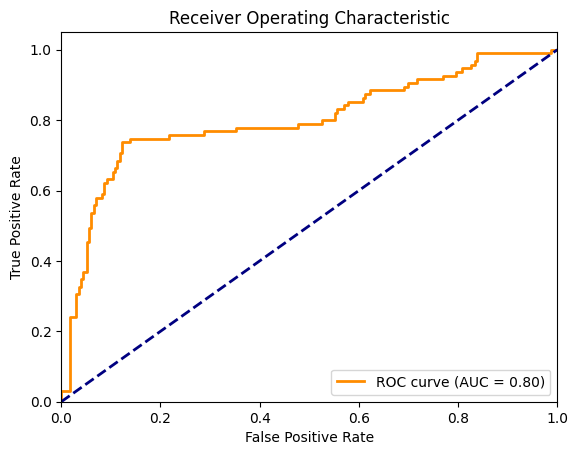

In [ ]:
# Calcular probabilidades de predicción
y_pred_proba = model.predict(X_test)

# Calcular curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Imprimir AUC
print(f"AUC: {roc_auc}")

# Graficar curva ROC
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Resultados de Prueba

*   Accuracy: **64.2%**
*   Precision: **40.1%**
*   Sensitivity: **76.1%**
*   Specificity: **59.9%**
*   F1 Score para "0": **0.71**
*   F1 Score para "1": **0.53**


###### 5. **Modelo CNN**

In [ ]:
# Definir el modelo
model = Sequential()
model.add(Input(shape=(4760, 3)))  # Definir explícitamente el tamaño de entrada
model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val_waist_acc, y_val_waist_acc))

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.7988 - loss: 2.2741 - val_accuracy: 0.9322 - val_loss: 0.1880
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9237 - loss: 0.1744 - val_accuracy: 0.9492 - val_loss: 0.1378
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9678 - loss: 0.0957 - val_accuracy: 0.9695 - val_loss: 0.1186
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9844 - loss: 0.0595 - val_accuracy: 0.9525 - val_loss: 0.1425
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9856 - loss: 0.0399 - val_accuracy: 0.9559 - val_loss: 0.1491
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9934 - loss: 0.0267 - val_accuracy: 0.9525 - val_loss: 0.1508
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9915 - loss: 0.0304 - val_accuracy: 0.9559 - val_loss: 0.1938
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9962 - loss: 0.0233 - val_accuracy: 0.9492 - 

In [ ]:
# Evaluar el modelo en el conjunto de validación
y_val_pred_waist_acc_cnn = model.predict(X_val_waist_acc).ravel()  # Genera predicciones
y_val_pred_waist_acc_cnn = (y_val_pred_waist_acc_cnn > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_acc, y_val_pred_waist_acc_cnn)
val_precision = precision_score(y_val_waist_acc, y_val_pred_waist_acc_cnn, average='binary')
val_recall = recall_score(y_val_waist_acc, y_val_pred_waist_acc_cnn, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_acc, y_val_pred_waist_acc_cnn).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_acc, y_val_pred_waist_acc_cnn)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_acc, y_val_pred_waist_acc_cnn).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_acc, y_val_pred_waist_acc_cnn))

# Guardar métricas de validación en un diccionario
res_val_waist_acc_cnn = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Validation Accuracy: 0.9559322033898305
Validation Precision: 0.9629629629629629
Validation Sensitivity: 0.8863636363636364
Validation Specificity: 0.9855072463768116
Validation Balanced Accuracy: 0.935935441370224

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       207
           1       0.96      0.89      0.92        88

    accuracy                           0.96       295
   macro avg       0.96      0.94      0.95       295
weighted avg       0.96      0.96      0.96       295



In [ ]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred_waist_acc_cnn = model.predict(X_test).ravel()  # Genera predicciones
y_test_pred_waist_acc_cnn = (y_test_pred_waist_acc_cnn > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias

# Cálculo de métricas
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_waist_acc_cnn))
print("Test Precision:", precision_score(y_test, y_test_pred_waist_acc_cnn, average='binary'))
print("Test Sensitivity (Recall):", recall_score(y_test, y_test_pred_waist_acc_cnn, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_waist_acc_cnn).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_waist_acc_cnn))

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_waist_acc_cnn))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step

Test Accuracy: 0.96
Test Precision: 0.9659090909090909
Test Sensitivity (Recall): 0.8947368421052632
Test Specificity: 0.9869565217391304
Test Balanced Accuracy: 0.9408466819221968

Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       230
           1       0.97      0.89      0.93        95

    accuracy                           0.96       325
   macro avg       0.96      0.94      0.95       325
weighted avg       0.96      0.96      0.96       325



Validación Cruzada K-Fold:

In [ ]:
# Definir el número de folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Inicializar listas para almacenar los resultados de cada fold
accuracy_per_fold = []
loss_per_fold = []
precision_per_fold = []
recall_per_fold = []
specificity_per_fold = []
f1_per_fold = []
balanced_accuracy_per_fold = []

# Iterar sobre cada fold
for train_index, val_index in kf.split(X_train):
    # Dividir los datos en entrenamiento y validación
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Definir el modelo (es importante definirlo dentro del loop para reiniciarlo en cada fold)
    model = Sequential()
    model.add(Input(shape=(4760, 3)))  # Definir explícitamente el tamaño de entrada
    model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo en el fold actual
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)

    # Evaluar el modelo en el conjunto de validación del fold actual
    y_val_pred = model.predict(X_val_fold).ravel()
    y_val_pred = (y_val_pred > 0.5).astype(int)

    # Cálculo de métricas para el fold actual
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    loss = model.evaluate(X_val_fold, y_val_fold, verbose=0)[0]
    precision = precision_score(y_val_fold, y_val_pred)
    recall = recall_score(y_val_fold, y_val_pred)
    f1 = f1_score(y_val_fold, y_val_pred)
    cm = confusion_matrix(y_val_fold, y_val_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    balanced_accuracy = balanced_accuracy_score(y_val_fold, y_val_pred)

    # Almacenar las métricas para este fold
    accuracy_per_fold.append(accuracy)
    loss_per_fold.append(loss)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    specificity_per_fold.append(specificity)
    f1_per_fold.append(f1)
    balanced_accuracy_per_fold.append(balanced_accuracy)

# Mostrar resultados promedio de las métricas de k-fold
print(f'\nMean Accuracy (k-Fold): {np.mean(accuracy_per_fold)}')
print(f'Mean Loss (k-Fold): {np.mean(loss_per_fold)}')
print(f'Mean Precision (k-Fold): {np.mean(precision_per_fold)}')
print(f'Mean Recall (k-Fold): {np.mean(recall_per_fold)}')
print(f'Mean Specificity (k-Fold): {np.mean(specificity_per_fold)}')
print(f'Mean F1 Score (k-Fold): {np.mean(f1_per_fold)}')
print(f'Mean Balanced Accuracy (k-Fold): {np.mean(balanced_accuracy_per_fold)}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Mean Accuracy (k-Fold): 0.9456401009736746
Mean Loss (k-Fold): 0.16234780997037887
Mean Precision (k-Fold): 0.9244569599503809
Mean Recall (k-Fold): 0.84672044234023
Mean Specificity (k-Fold): 0.9763565209999389
Mean F1 Score (k-Fold): 0.8804381794957766
Mean Balanced Accuracy (k-Fold): 0.9115384816700844


**Mean Accuracy**:

**Mean Precision**:

**Mean Sensitivity**:

**Mean Specifity**:

**Mean F1 Score**:

###### 6. **Modelo SAE**

Padding y división de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_waist[feature_cols_acc].applymap(len).max().max()
print(f"Longitud máxima de secuencia: {max_length}")

Longitud máxima de secuencia: 4760


<ipython-input-220-6b95f2fd91f2>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_waist[feature_cols_acc].applymap(len).max().max()


In [ ]:
# Crear un índice de validación a partir de la división de entrenamiento y validación
train_indices, val_indices = train_test_split(df_train_waist.index, test_size=0.2, random_state=42)

# Crear los conjuntos de secuencias de entrenamiento y validación
df_train_waist_train = df_train_waist.loc[train_indices]
df_train_waist_val = df_train_waist.loc[val_indices]

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols_acc, max_length):
    padded_features = []
    for col in feature_cols_acc:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)
            if sequence.shape[1] < 3:
                # Añadir columnas con ceros para igualar a 3 dimensiones
                sequence = np.pad(sequence, ((0, 0), (0, 3 - sequence.shape[1])), 'constant', constant_values=0)
            if len(sequence) < max_length:
                padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
            else:
                padded_sequence = sequence[:max_length]
            padded_col.append(padded_sequence)

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_waist_train, feature_cols_acc, max_length)
y_train = df_train_waist_train[target_col].values

# Aplicar padding al conjunto de validación
X_val_waist_acc = pad_sequences_feature(df_train_waist_val, feature_cols_acc, max_length)
y_val_waist_acc = df_train_waist_val[target_col].values

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalizar las características del conjunto de validación
X_val_waist_acc = scaler.transform(X_val_waist_acc.reshape(-1, X_val_waist_acc.shape[-1])).reshape(X_val_waist_acc.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test_waist, feature_cols_acc, max_length)
y_test = df_test_waist[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")

Forma de X_train: (1177, 4760, 3)
Forma de X_test: (325, 4760, 3)


*  **1854 / 1321** son el número de muestras para el conjunto de entrenamiento y prueba, respectivamente.
*  **4760** es la longitud de la ventana de tiempo (en muestras) para cada señal.
*  **3** representa los tres canales de aceleración (ax, ay, az).

In [ ]:
# Ver los primeros 5 valores de cada canal en la primera muestra
print("Primeros 5 valores del primer canal (ax) de la primera muestra de X_train:")
print(X_train[0, :5, 0])  # Canal ax

print("Primeros 5 valores del segundo canal (ay) de la primera muestra de X_train:")
print(X_train[0, :5, 1])  # Canal ay

print("Primeros 5 valores del tercer canal (az) de la primera muestra de X_train:")
print(X_train[0, :5, 2])  # Canal az

Primeros 5 valores del primer canal (ax) de la primera muestra de X_train:
[0.48880135 0.48880135 0.48880135 0.4864342  0.48501392]
Primeros 5 valores del segundo canal (ay) de la primera muestra de X_train:
[-0.04512727 -0.04967247 -0.05080876 -0.05194506 -0.05194506]
Primeros 5 valores del tercer canal (az) de la primera muestra de X_train:
[-0.06415059 -0.06730749 -0.06288782 -0.05973092 -0.05594263]


In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Configurar la semilla para la reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
# Parámetros
input_shape = (4760, 3)  # Ajusta esto a la forma de tu entrada
kernel_size = 7
filters = [32, 64]  # Número de filtros en cada capa convolucional

# Definir la función de autoencoder
def build_autoencoder(input_shape, filters, kernel_size):
    input_layer = Input(shape=input_shape)

    # Encoder
    x = Conv1D(filters=filters[0], kernel_size=kernel_size, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)

    # Bottleneck
    bottleneck_shape = x.shape[1:]  # Obtiene la forma después de las capas convolucionales y de pooling
    x = Flatten()(x)
    bottleneck = Dense(128, activation='relu')(x)  # Puedes ajustar la dimensión del bottleneck

    # Decoder
    x = Dense(np.prod(bottleneck_shape), activation='relu')(bottleneck)
    x = Reshape(bottleneck_shape)(x)  # Redimensiona a la forma adecuada para las capas convolucionales de decodificación
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=input_shape[1], kernel_size=kernel_size, activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_layer, x)
    encoder = Model(input_layer, bottleneck)

    return autoencoder, encoder

# Construir el autoencoder
autoencoder, encoder = build_autoencoder(input_shape, filters, kernel_size)

# Compilar el autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenar el autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2)

# Extraer las características usando el encoder
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val_waist_acc)
X_test_encoded = encoder.predict(X_test)

# Crear el clasificador denso
def build_classifier(input_shape):
    input_layer = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input_layer)
    x = Dense(32, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    classifier = Model(input_layer, output_layer)
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return classifier

# Construir el clasificador
classifier = build_classifier(X_train_encoded.shape[1:])

# Entrenar el clasificador
classifier.fit(X_train_encoded, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weights)

# Evaluar el clasificador
loss, accuracy = classifier.evaluate(X_test_encoded, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - loss: 1.0983 - val_loss: 0.8312
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.9585 - val_loss: 0.7593
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.8992 - val_loss: 0.6926
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.8318 - val_loss: 0.6440
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.7917 - val_loss: 0.6361
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.7820 - val_loss: 0.6295
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.7754 - val_loss: 0.6261
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.7698 - val_loss: 0.6252
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.7656 - val_loss: 0.6236
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.7617 - val_loss: 0.6238
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 1/10
30/30 ━━━━━━━━━━━

In [ ]:
# Realizar predicciones
y_val_pred_waist_acc_sae = (classifier.predict(X_val_encoded) > 0.5).astype(int).ravel()

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_acc, y_val_pred_waist_acc_sae)
val_precision = precision_score(y_val_waist_acc, y_val_pred_waist_acc_sae, average='binary')
val_recall = recall_score(y_val_waist_acc, y_val_pred_waist_acc_sae, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_acc, y_val_pred_waist_acc_sae).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_acc, y_val_pred_waist_acc_sae)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_acc, y_val_pred_waist_acc_sae).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_acc, y_val_pred_waist_acc_sae))

# Guardar métricas de validación en un diccionario
res_val_waist_acc_sae = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Validation Accuracy: 0.9355932203389831
Validation Precision: 0.9156626506024096
Validation Sensitivity: 0.8636363636363636
Validation Specificity: 0.966183574879227
Validation Balanced Accuracy: 0.9149099692577953

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       207
           1       0.92      0.86      0.89        88

    accuracy                           0.94       295
   macro avg       0.93      0.91      0.92       295
weighted avg       0.94      0.94      0.94       295



In [ ]:
# Realizar predicciones
y_test_pred_waist_acc_sae = (classifier.predict(X_test_encoded) > 0.5).astype(int).ravel()

# Cálculo de métricas
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_waist_acc_sae))
print("Test Precision:", precision_score(y_test, y_test_pred_waist_acc_sae, average='binary'))
print("Test Sensitivity:", recall_score(y_test, y_test_pred_waist_acc_sae, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_waist_acc_sae).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_waist_acc_sae))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_waist_acc_sae))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Test Accuracy: 0.916923076923077
Test Precision: 0.8863636363636364
Test Sensitivity: 0.8210526315789474
Test Specificity: 0.9565217391304348
Test Balanced Accuracy: 0.8887871853546911

Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94       230
           1       0.89      0.82      0.85        95

    accuracy                           0.92       325
   macro avg       0.91      0.89      0.90       325
weighted avg       0.92      0.92      0.92       325



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
AUC: 0.9460869565217391


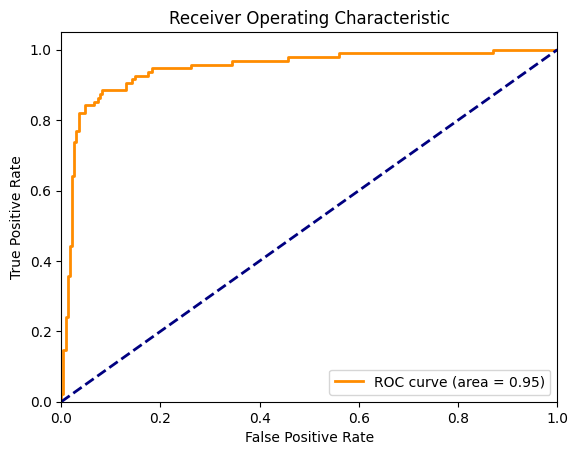

In [ ]:
# Realizar predicciones
y_pred_proba = classifier.predict(X_test_encoded)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Imprimir AUC
print(f"AUC: {roc_auc}")

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

AUC de 0.834 sugiere que el modelo tiene una excelente capacidad para distinguir entre las clases positivas y negativas.

Resultados de Prueba

*   Accuracy: **78.5%**
*   Precision: **56.1%**
*   Sensitivity: **81.4%**
*   Specificity: **77.5%**
*   F1 Score para "0": **0.84**
*   F1 Score para "1": **0.66**

##### Giroscopio (Gyr)

In [ ]:
# Función para extraer características de una serie temporal
def extract_features_from_series(series):
    series = np.asarray(series)  # Asegurarse de que sea un array de NumPy
    series = series.astype(float)  # Convertir a flotante para evitar overflow

    return {
        'mean': np.mean(series),
        'std': np.std(series),
        'var': np.var(series),
        'max': np.max(series),
        'min': np.min(series),
        'range': np.ptp(series),  # np.ptp es equivalente a np.max - np.min pero más seguro
        'kurtosis': pd.Series(series).kurtosis(),
        'skewness': pd.Series(series).skew()
    }

# Función para procesar cada fila de datos
def process_gyr_row(gyr_data):
    x_vals = np.array([point[0] for point in gyr_data])
    y_vals = np.array([point[1] for point in gyr_data])
    z_vals = np.array([point[2] for point in gyr_data])

    # Asegurarse de que cada valor sea numérico y no una lista o array multidimensional
    x_features = extract_features_from_series(x_vals)
    y_features = extract_features_from_series(y_vals)
    z_features = extract_features_from_series(z_vals)

    # Combinar todas las características en un solo vector (diccionario)
    gyr_features = {f'x_{key}': val for key, val in x_features.items()}
    gyr_features.update({f'y_{key}': val for key, val in y_features.items()})
    gyr_features.update({f'z_{key}': val for key, val in z_features.items()})

    return gyr_features

# Separamos características y preparamos datos:
df_train_waist_features = df_train_waist[feature_cols_gyr].apply(lambda row: process_gyr_row(row['Gyr']), axis=1)
df_train_waist_features = pd.DataFrame(df_train_waist_features.tolist())
X_train_waist_gyr = df_train_waist_features
y_train_waist_gyr = df_train_waist[target_col]

df_test_waist_features = df_test_waist[feature_cols_gyr].apply(lambda row: process_gyr_row(row['Gyr']), axis=1)
df_test_waist_features = pd.DataFrame(df_test_waist_features.tolist())
X_test_waist_gyr = df_test_waist_features
y_test_waist_gyr = df_test_waist[target_col]

Normalizamos características:

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train_waist_gyr = scaler.fit_transform(X_train_waist_gyr)
X_test_waist_gyr = scaler.transform(X_test_waist_gyr)

In [ ]:
# Dividir el conjunto de datos en entrenamiento y validación
X_train_waist_gyr, X_val_waist_gyr, y_train_waist_gyr, y_val_waist_gyr = train_test_split(X_train_waist_gyr, y_train_waist_gyr, test_size=0.2, random_state=42)

###### 1. **Modelo k-NN**

Realizamos predicciones:

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_waist_gyr, y_train_waist_gyr)
y_pred = knn.predict(X_test_waist_gyr)

Evaluación del modelo:

In [ ]:
# Evaluación en el conjunto de validación
y_val_pred_waist_gyr_knn = knn.predict(X_val_waist_gyr)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_gyr, y_val_pred_waist_gyr_knn)
val_precision = precision_score(y_val_waist_gyr, y_val_pred_waist_gyr_knn, average='binary')
val_recall = recall_score(y_val_waist_gyr, y_val_pred_waist_gyr_knn, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_gyr, y_val_pred_waist_gyr_knn).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_gyr, y_val_pred_waist_gyr_knn)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_gyr, y_val_pred_waist_gyr_knn).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_gyr, y_val_pred_waist_gyr_knn))

# Guardar métricas de validación en un diccionario
res_val_waist_gyr_knn = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.864406779661017
Validation Precision: 0.875
Validation Sensitivity: 0.6363636363636364
Validation Specificity: 0.961352657004831
Validation Balanced Accuracy: 0.7988581466842337

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.96      0.91       207
           1       0.88      0.64      0.74        88

    accuracy                           0.86       295
   macro avg       0.87      0.80      0.82       295
weighted avg       0.87      0.86      0.86       295



In [ ]:
# Evaluación en el conjunto de prueba
y_test_pred_waist_gyr_knn = knn.predict(X_test_waist_gyr)

print("\nTest Accuracy:", accuracy_score(y_test_waist_gyr, y_test_pred_waist_gyr_knn))
print("Test Precision:", precision_score(y_test_waist_gyr, y_test_pred_waist_gyr_knn, average='binary'))
print("Test Sensitivity:", recall_score(y_test_waist_gyr, y_test_pred_waist_gyr_knn, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test_waist_gyr, y_test_pred_waist_gyr_knn).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_waist_gyr, y_test_pred_waist_gyr_knn))

print("\nTest Classification Report:\n", classification_report(y_test_waist_gyr, y_test_pred_waist_gyr_knn))


Test Accuracy: 0.8984615384615384
Test Precision: 0.9305555555555556
Test Sensitivity: 0.7052631578947368
Test Specificity: 0.9782608695652174
Test Balanced Accuracy: 0.841762013729977

Test Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93       230
           1       0.93      0.71      0.80        95

    accuracy                           0.90       325
   macro avg       0.91      0.84      0.87       325
weighted avg       0.90      0.90      0.89       325



Resultados de Validación

*   Accuracy: **86.4%**
*   Precision: **87.5%**
*   Sensitivity: **63.6%**
*   Specificity: **96.1%**
*   F1 Score para "0": **0.91**
*   F1 Score para "1": **0.74**

Estos resultados muestran ...

Resultados de Prueba

*   Accuracy: **83.0%**
*   Precision: **67.7%**
*   Sensitivity: **66.6%**
*   Specificity: **88.8%**
*   F1 Score para "0": **0.89**
*   F1 Score para "1": **0.67**

En comparación con los resultados de validación, los resultados del conjunto de prueba muestran ...

###### 2. **Modelo SVM**

In [ ]:
# Crear el modelo SVM
svm_model = SVC(kernel='linear')  # Puedes probar otros kernels como 'rbf', 'poly', etc.

# Entrenar el modelo
svm_model.fit(X_train_waist_gyr, y_train_waist_gyr)

# Hacer predicciones en el conjunto de validación
y_val_pred_waist_gyr_svm = svm_model.predict(X_val_waist_gyr)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_gyr, y_val_pred_waist_gyr_svm)
val_precision = precision_score(y_val_waist_gyr, y_val_pred_waist_gyr_svm, average='binary')
val_recall = recall_score(y_val_waist_gyr, y_val_pred_waist_gyr_svm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_gyr, y_val_pred_waist_gyr_svm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_gyr, y_val_pred_waist_gyr_svm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_gyr, y_val_pred_waist_gyr_svm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_gyr, y_val_pred_waist_gyr_svm))

# Guardar métricas de validación en un diccionario
res_val_waist_gyr_svm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.8745762711864407
Validation Precision: 0.84
Validation Sensitivity: 0.7159090909090909
Validation Specificity: 0.9420289855072463
Validation Balanced Accuracy: 0.8289690382081687

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91       207
           1       0.84      0.72      0.77        88

    accuracy                           0.87       295
   macro avg       0.86      0.83      0.84       295
weighted avg       0.87      0.87      0.87       295



In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred_waist_gyr_svm = svm_model.predict(X_test_waist_gyr)

# Evaluar el modelo en el conjunto de prueba
print(f"\nTest Accuracy:", accuracy_score(y_test_waist_gyr, y_test_pred_waist_gyr_svm))
print(f"Test Precision:", precision_score(y_test_waist_gyr, y_test_pred_waist_gyr_svm))
print(f"Test Sensitivity:", recall_score(y_test_waist_gyr, y_test_pred_waist_gyr_svm))
tn, fp, fn, tp = confusion_matrix(y_test_waist_gyr, y_test_pred_waist_gyr_svm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_waist_gyr, y_test_pred_waist_gyr_svm))

print("\nTest Classification Report:", classification_report(y_test_waist_gyr, y_test_pred_waist_gyr_svm))


Test Accuracy: 0.9046153846153846
Test Precision: 0.9
Test Sensitivity: 0.7578947368421053
Test Specificity: 0.9652173913043478
Test Balanced Accuracy: 0.8615560640732265

Test Classification Report:               precision    recall  f1-score   support

           0       0.91      0.97      0.93       230
           1       0.90      0.76      0.82        95

    accuracy                           0.90       325
   macro avg       0.90      0.86      0.88       325
weighted avg       0.90      0.90      0.90       325



Ajuste de Hiperparámetros con GridSearchCV:

In [ ]:
# Definir los hiperparámetros a probar
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']  # solo afecta a algunos kernels
}

# Crear el modelo SVM
svm_model = SVC()

# Implementar GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar el modelo con GridSearchCV
grid_search.fit(X_train_waist_gyr, y_train_waist_gyr)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Usar el mejor modelo encontrado
best_svm_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de validación
y_val_pred_waist_gyr_svm = best_svm_model.predict(X_val_waist_gyr)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_gyr, y_val_pred_waist_gyr_svm)
val_precision = precision_score(y_val_waist_gyr, y_val_pred_waist_gyr_svm, average='binary')
val_recall = recall_score(y_val_waist_gyr, y_val_pred_waist_gyr_svm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_gyr, y_val_pred_waist_gyr_svm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_gyr, y_val_pred_waist_gyr_svm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_gyr, y_val_pred_waist_gyr_svm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_gyr, y_val_pred_waist_gyr_svm))

# Guardar métricas de validación en un diccionario
res_val_waist_gyr_svm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

Mejores hiperparámetros: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Validation Accuracy: 0.9322033898305084
Validation Precision: 0.9146341463414634
Validation Sensitivity: 0.8522727272727273
Validation Specificity: 0.966183574879227
Validation Balanced Accuracy: 0.9092281510759772

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       207
           1       0.91      0.85      0.88        88

    accuracy                           0.93       295
   macro avg       0.93      0.91      0.92       295
weighted avg       0.93      0.93      0.93       295



Validación Cruzada

In [ ]:
# Realizar validación cruzada con los mejores parámetros
cv_scores = cross_val_score(best_svm_model, X_train_waist_gyr, y_train_waist_gyr, cv=5, scoring='accuracy')

print(f"Validation Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean()}")

Validation Cross-Validation Scores: [0.91101695 0.91525424 0.91489362 0.9106383  0.93191489]
Mean Cross-Validation Accuracy: 0.9167435989902633


Evaluación del Modelo en el Conjunto de Prueba

In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred_waist_gyr_svm = best_svm_model.predict(X_test_waist_gyr)

# Evaluar el modelo en el conjunto de prueba
print(f"\nTest Accuracy:", accuracy_score(y_test_waist_gyr, y_test_pred_waist_gyr_svm))
print(f"Test Precision:", precision_score(y_test_waist_gyr, y_test_pred_waist_gyr_svm))
print(f"Test Sensitivity:", recall_score(y_test_waist_gyr, y_test_pred_waist_gyr_svm))
tn, fp, fn, tp = confusion_matrix(y_test_waist_gyr, y_test_pred_waist_gyr_svm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_waist_gyr, y_test_pred_waist_gyr_svm))

print("\nTest Classification Report:", classification_report(y_test_waist_gyr, y_test_pred_waist_gyr_svm))


Test Accuracy: 0.9323076923076923
Test Precision: 0.9195402298850575
Test Sensitivity: 0.8421052631578947
Test Specificity: 0.9695652173913043
Test Balanced Accuracy: 0.9058352402745995

Test Classification Report:               precision    recall  f1-score   support

           0       0.94      0.97      0.95       230
           1       0.92      0.84      0.88        95

    accuracy                           0.93       325
   macro avg       0.93      0.91      0.92       325
weighted avg       0.93      0.93      0.93       325



Sí mejora con GridSearchCV:

Resultados de Prueba

*   Accuracy: **80.5%**
*   Precision: **60.2%**
*   Sensitivity: **74.7%**
*   Specificity: **82.6%**
*   F1 Score para "0": **0.86**
*   F1 Score para "1": **0.67**

###### 3. **Modelo Random Forest**

In [ ]:
# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')  # Puedes ajustar 'n_estimators' y otros hiperparámetros

# Entrenar el modelo con las características extraídas
rf_model.fit(X_train_waist_gyr, y_train_waist_gyr)

# Hacer predicciones en el conjunto de validación
y_val_pred_waist_gyr_rf = rf_model.predict(X_val_waist_gyr)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_gyr, y_val_pred_waist_gyr_rf)
val_precision = precision_score(y_val_waist_gyr, y_val_pred_waist_gyr_rf, average='binary')
val_recall = recall_score(y_val_waist_gyr, y_val_pred_waist_gyr_rf, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_gyr, y_val_pred_waist_gyr_rf).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_gyr, y_val_pred_waist_gyr_rf)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_gyr, y_val_pred_waist_gyr_rf).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_gyr, y_val_pred_waist_gyr_rf))

# Guardar métricas de validación en un diccionario
res_val_waist_gyr_rf = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.9152542372881356
Validation Precision: 0.8888888888888888
Validation Sensitivity: 0.8181818181818182
Validation Specificity: 0.9565217391304348
Validation Balanced Accuracy: 0.8873517786561265

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94       207
           1       0.89      0.82      0.85        88

    accuracy                           0.92       295
   macro avg       0.91      0.89      0.90       295
weighted avg       0.91      0.92      0.91       295



In [ ]:
# Realizar predicciones en el conjunto de prueba
y_test_pred_waist_gyr_rf = rf_model.predict(X_test_waist_gyr)

# Evaluar el rendimiento del modelo
print("\nTest Accuracy:", accuracy_score(y_test_waist_gyr, y_test_pred_waist_gyr_rf))
print("Test Precision:", precision_score(y_test_waist_gyr, y_test_pred_waist_gyr_rf, average='binary'))
print("Test Sensitivity (Recall):", recall_score(y_test_waist_gyr, y_test_pred_waist_gyr_rf, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test_waist_gyr, y_test_pred_waist_gyr_rf).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_waist_gyr, y_test_pred_waist_gyr_rf))

print("\nTest Classification Report:\n", classification_report(y_test_waist_gyr, y_test_pred_waist_gyr_rf))


Test Accuracy: 0.9323076923076923
Test Precision: 0.9101123595505618
Test Sensitivity (Recall): 0.8526315789473684
Test Specificity: 0.9652173913043478
Test Balanced Accuracy: 0.9089244851258581

Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       230
           1       0.91      0.85      0.88        95

    accuracy                           0.93       325
   macro avg       0.93      0.91      0.92       325
weighted avg       0.93      0.93      0.93       325



Resultados de Prueba

*   Accuracy: **82.9%**
*   Precision: **64.7%**
*   Sensitivity: **75.6%**
*   Specificity: **85.5%**
*   F1 Score para "0": **0.88**
*   F1 Score para "1": **0.77**

###### 4. **Modelo LSTM**

Padding y división de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_waist[feature_cols_gyr].applymap(len).max().max()
print(f"Longitud máxima de secuencia: {max_length}")

Longitud máxima de secuencia: 4760


<ipython-input-245-eedf3b54c8ea>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_waist[feature_cols_gyr].applymap(len).max().max()


In [ ]:
# Crear un índice de validación a partir de la división de entrenamiento y validación
train_indices, val_indices = train_test_split(df_train_waist.index, test_size=0.2, random_state=42)

# Crear los conjuntos de secuencias de entrenamiento y validación
df_train_waist_train = df_train_waist.loc[train_indices]
df_train_waist_val = df_train_waist.loc[val_indices]

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols_gyr, max_length):
    padded_features = []
    for col in feature_cols_gyr:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)
            if sequence.shape[1] < 3:
                # Añadir columnas con ceros para igualar a 3 dimensiones
                sequence = np.pad(sequence, ((0, 0), (0, 3 - sequence.shape[1])), 'constant', constant_values=0)
            if len(sequence) < max_length:
                padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
            else:
                padded_sequence = sequence[:max_length]
            padded_col.append(padded_sequence)

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_waist_train, feature_cols_gyr, max_length)
y_train = df_train_waist_train[target_col].values

# Aplicar padding al conjunto de validación
X_val_waist_gyr = pad_sequences_feature(df_train_waist_val, feature_cols_gyr, max_length)
y_val_waist_gyr = df_train_waist_val[target_col].values

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalizar las características del conjunto de validación
X_val_waist_gyr = scaler.transform(X_val_waist_gyr.reshape(-1, X_val_waist_gyr.shape[-1])).reshape(X_val_waist_gyr.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test_waist, feature_cols_gyr, max_length)
y_test = df_test_waist[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Configurar la semilla para la reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
print("Dimensiones de X_train:")
print(f"Forma: {X_train.shape}")
print(f"Número de muestras: {X_train.shape[0]}")
print(f"Longitud de secuencia (timesteps): {X_train.shape[1]}")
print(f"Número de características: {X_train.shape[2]}")

print("\nDimensiones de X_test:")
print(f"Forma: {X_test.shape}")
print(f"Número de muestras: {X_test.shape[0]}")
print(f"Longitud de secuencia (timesteps): {X_test.shape[1]}")
print(f"Número de características: {X_test.shape[2]}")

Dimensiones de X_train:
Forma: (1177, 4760, 3)
Número de muestras: 1177
Longitud de secuencia (timesteps): 4760
Número de características: 3

Dimensiones de X_test:
Forma: (325, 4760, 3)
Número de muestras: 325
Longitud de secuencia (timesteps): 4760
Número de características: 3


In [ ]:
# Verificar la forma de entrada esperada para el modelo
input_shape = (4760, 3)  # Esto debe coincidir con las dimensiones de tus datos

print(f"Forma de entrada esperada para el modelo: {input_shape}")

Forma de entrada esperada para el modelo: (4760, 3)


*  Menor Tiempo de Cómputo: RandomizedSearchCV es mucho más rápido que GridSearchCV para grandes espacios de hiperparámetros.
*  Exploración Eficiente: Aunque no prueba todas las combinaciones posibles, es probable que encuentre una buena combinación de hiperparámetros en menos tiempo.

In [ ]:
# Crear el modelo LSTM
model = Sequential()
model.add(Masking(mask_value=0., input_shape=input_shape))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con pesos de clase
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val_waist_gyr, y_val_waist_gyr), class_weight=class_weights)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 316ms/step - accuracy: 0.6518 - loss: 0.6871 - val_accuracy: 0.5186 - val_loss: 0.6736
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 275ms/step - accuracy: 0.3979 - loss: 0.6789 - val_accuracy: 0.4881 - val_loss: 0.6717
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 254ms/step - accuracy: 0.3977 - loss: 0.6821 - val_accuracy: 0.4780 - val_loss: 0.6851
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.3959 - loss: 0.6687 - val_accuracy: 0.4712 - val_loss: 0.6786
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 278ms/step - accuracy: 0.3962 - loss: 0.6779 - val_accuracy: 0.4881 - val_loss: 0.6745
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 247ms/step - accuracy: 0.4031 - loss: 0.6626 - val_accuracy: 0.4542 - val_loss: 0.6794
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - accuracy: 0.4176 - loss: 0.6630 - val_accuracy: 0.4542 - val_loss: 0.6760
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 281ms/step - accuracy: 0.3975 - loss: 0.6535 - val_accu

In [ ]:
# Realizar predicciones en el conjunto de validación
y_val_pred_waist_gyr_lstm = (model.predict(X_val_waist_gyr) > 0.5).astype("int32").ravel()

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_gyr, y_val_pred_waist_gyr_lstm)
val_precision = precision_score(y_val_waist_gyr, y_val_pred_waist_gyr_lstm, average='binary')
val_recall = recall_score(y_val_waist_gyr, y_val_pred_waist_gyr_lstm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_gyr, y_val_pred_waist_gyr_lstm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_gyr, y_val_pred_waist_gyr_lstm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_gyr, y_val_pred_waist_gyr_lstm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_gyr, y_val_pred_waist_gyr_lstm))

# Guardar métricas de validación en un diccionario
res_val_waist_gyr_lstm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step

Validation Accuracy: 0.42033898305084744
Validation Precision: 0.3292181069958848
Validation Sensitivity: 0.9090909090909091
Validation Specificity: 0.21256038647342995
Validation Balanced Accuracy: 0.5608256477821695

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.21      0.34       207
           1       0.33      0.91      0.48        88

    accuracy                           0.42       295
   macro avg       0.59      0.56      0.41       295
weighted avg       0.69      0.42      0.38       295



In [ ]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Realizar predicciones en el conjunto de prueba
y_test_pred_waist_gyr_lstm = (model.predict(X_test) > 0.5).astype("int32").ravel()

print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_waist_gyr_lstm))
print("Test Precision:", precision_score(y_test, y_test_pred_waist_gyr_lstm, average='binary'))
print("Test Sensitivity:", recall_score(y_test, y_test_pred_waist_gyr_lstm, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_waist_gyr_lstm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_waist_gyr_lstm))

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_waist_gyr_lstm))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.4862 - loss: 0.6658
Loss: 0.6756770014762878, Accuracy: 0.4430769085884094
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step

Test Accuracy: 0.4430769230769231
Test Precision: 0.34074074074074073
Test Sensitivity: 0.968421052631579
Test Specificity: 0.22608695652173913
Test Balanced Accuracy: 0.597254004576659

Test Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.23      0.36       230
           1       0.34      0.97      0.50        95

    accuracy                           0.44       325
   macro avg       0.64      0.60      0.43       325
weighted avg       0.77      0.44      0.41       325



11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
AUC: 0.5777574370709382


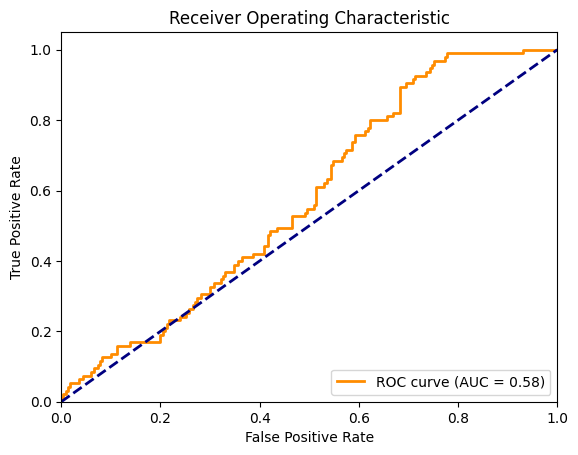

In [ ]:
# Calcular probabilidades de predicción
y_pred_proba = model.predict(X_test)

# Calcular curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Imprimir AUC
print(f"AUC: {roc_auc}")

# Graficar curva ROC
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Resultados de Prueba

*   Accuracy: **54.1%**
*   Precision: **28.1%**
*   Sensitivity: **83.4%**
*   Specificity: **24.8%**
*   F1 Score para "0": **0.38**
*   F1 Score para "1": **0.42**


###### 5. **Modelo CNN**

In [ ]:
# Definir el modelo
model = Sequential()
model.add(Input(shape=(4760, 3)))  # Definir explícitamente el tamaño de entrada
model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val_waist_gyr, y_val_waist_gyr))

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.7624 - loss: 1.0470 - val_accuracy: 0.9322 - val_loss: 0.1828
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9543 - loss: 0.1445 - val_accuracy: 0.9559 - val_loss: 0.1326
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9821 - loss: 0.0577 - val_accuracy: 0.9390 - val_loss: 0.1415
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9979 - loss: 0.0190 - val_accuracy: 0.9559 - val_loss: 0.1594
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9971 - loss: 0.0140 - val_accuracy: 0.9153 - val_loss: 0.4664
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9885 - loss: 0.0221 - val_accuracy: 0.9085 - val_loss: 0.5826
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9951 - loss: 0.0144 - val_accuracy: 0.9356 - val_loss: 0.2890
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9989 - loss: 0.0058 - val_accuracy: 0.9390 - v

In [ ]:
# Evaluar el modelo en el conjunto de validación
y_val_pred_waist_gyr_cnn = model.predict(X_val_waist_gyr).ravel()  # Genera predicciones
y_val_pred_waist_gyr_cnn = (y_val_pred_waist_gyr_cnn > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_gyr, y_val_pred_waist_gyr_cnn)
val_precision = precision_score(y_val_waist_gyr, y_val_pred_waist_gyr_cnn, average='binary')
val_recall = recall_score(y_val_waist_gyr, y_val_pred_waist_gyr_cnn, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_gyr, y_val_pred_waist_gyr_cnn).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_gyr, y_val_pred_waist_gyr_cnn)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_gyr, y_val_pred_waist_gyr_cnn).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_gyr, y_val_pred_waist_gyr_cnn))

# Guardar métricas de validación en un diccionario
res_val_waist_gyr_cnn = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Validation Accuracy: 0.9559322033898305
Validation Precision: 0.9746835443037974
Validation Sensitivity: 0.875
Validation Specificity: 0.9903381642512077
Validation Balanced Accuracy: 0.9326690821256038

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       207
           1       0.97      0.88      0.92        88

    accuracy                           0.96       295
   macro avg       0.96      0.93      0.95       295
weighted avg       0.96      0.96      0.96       295



In [ ]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred_waist_gyr_cnn = model.predict(X_test).ravel()  # Genera predicciones
y_test_pred_waist_gyr_cnn = (y_test_pred_waist_gyr_cnn > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias

# Cálculo de métricas
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_waist_gyr_cnn))
print("Test Precision:", precision_score(y_test, y_test_pred_waist_gyr_cnn, average='binary'))
print("Test Sensitivity (Recall):", recall_score(y_test, y_test_pred_waist_gyr_cnn, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_waist_gyr_cnn).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_waist_gyr_cnn))

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_waist_gyr_cnn))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Test Accuracy: 0.9446153846153846
Test Precision: 0.963855421686747
Test Sensitivity (Recall): 0.8421052631578947
Test Specificity: 0.9869565217391304
Test Balanced Accuracy: 0.9145308924485125

Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       230
           1       0.96      0.84      0.90        95

    accuracy                           0.94       325
   macro avg       0.95      0.91      0.93       325
weighted avg       0.95      0.94      0.94       325



Validación Cruzada K-Fold:

In [ ]:
# Definir el número de folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Inicializar listas para almacenar los resultados de cada fold
accuracy_per_fold = []
loss_per_fold = []
precision_per_fold = []
recall_per_fold = []
specificity_per_fold = []
f1_per_fold = []
balanced_accuracy_per_fold = []

# Iterar sobre cada fold
for train_index, val_index in kf.split(X_train):
    # Dividir los datos en entrenamiento y validación
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Definir el modelo (es importante definirlo dentro del loop para reiniciarlo en cada fold)
    model = Sequential()
    model.add(Input(shape=(4760, 3)))  # Definir explícitamente el tamaño de entrada
    model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo en el fold actual
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)

    # Evaluar el modelo en el conjunto de validación del fold actual
    y_val_pred = model.predict(X_val_fold).ravel()
    y_val_pred = (y_val_pred > 0.5).astype(int)

    # Cálculo de métricas para el fold actual
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    loss = model.evaluate(X_val_fold, y_val_fold, verbose=0)[0]
    precision = precision_score(y_val_fold, y_val_pred)
    recall = recall_score(y_val_fold, y_val_pred)
    f1 = f1_score(y_val_fold, y_val_pred)
    cm = confusion_matrix(y_val_fold, y_val_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    balanced_accuracy = balanced_accuracy_score(y_val_fold, y_val_pred)

    # Almacenar las métricas para este fold
    accuracy_per_fold.append(accuracy)
    loss_per_fold.append(loss)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    specificity_per_fold.append(specificity)
    f1_per_fold.append(f1)
    balanced_accuracy_per_fold.append(balanced_accuracy)

# Mostrar resultados promedio de las métricas de k-fold
print(f'\nMean Accuracy (k-Fold): {np.mean(accuracy_per_fold)}')
print(f'Mean Loss (k-Fold): {np.mean(loss_per_fold)}')
print(f'Mean Precision (k-Fold): {np.mean(precision_per_fold)}')
print(f'Mean Recall (k-Fold): {np.mean(recall_per_fold)}')
print(f'Mean Specificity (k-Fold): {np.mean(specificity_per_fold)}')
print(f'Mean F1 Score (k-Fold): {np.mean(f1_per_fold)}')
print(f'Mean Balanced Accuracy (k-Fold): {np.mean(balanced_accuracy_per_fold)}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step

Mean Accuracy (k-Fold): 0.9133465560764513
Mean Loss (k-Fold): 0.377700611948967
Mean Precision (k-Fold): 0.8622915602107843
Mean Recall (k-Fold): 0.765665777184545
Mean Specificity (k-Fold): 0.9607069413070194
Mean F1 Score (k-Fold): 0.8100238661739928
Mean Balanced Accuracy (k-Fold): 0.8631863592457822


**Mean Accuracy**:

**Mean Precision**:

**Mean Sensitivity**:

**Mean Specifity**:

**Mean F1 Score**:

###### 6. **Modelo SAE**

Padding y división de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_waist[feature_cols_gyr].applymap(len).max().max()
print(f"Longitud máxima de secuencia: {max_length}")

Longitud máxima de secuencia: 4760


<ipython-input-261-eedf3b54c8ea>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_waist[feature_cols_gyr].applymap(len).max().max()


In [ ]:
# Crear un índice de validación a partir de la división de entrenamiento y validación
train_indices, val_indices = train_test_split(df_train_waist.index, test_size=0.2, random_state=42)

# Crear los conjuntos de secuencias de entrenamiento y validación
df_train_waist_train = df_train_waist.loc[train_indices]
df_train_waist_val = df_train_waist.loc[val_indices]

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols_gyr, max_length):
    padded_features = []
    for col in feature_cols_gyr:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)
            if sequence.shape[1] < 3:
                # Añadir columnas con ceros para igualar a 3 dimensiones
                sequence = np.pad(sequence, ((0, 0), (0, 3 - sequence.shape[1])), 'constant', constant_values=0)
            if len(sequence) < max_length:
                padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
            else:
                padded_sequence = sequence[:max_length]
            padded_col.append(padded_sequence)

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_waist_train, feature_cols_gyr, max_length)
y_train = df_train_waist_train[target_col].values

# Aplicar padding al conjunto de validación
X_val_waist_gyr = pad_sequences_feature(df_train_waist_val, feature_cols_gyr, max_length)
y_val_waist_gyr = df_train_waist_val[target_col].values

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalizar las características del conjunto de validación
X_val_waist_gyr = scaler.transform(X_val_waist_gyr.reshape(-1, X_val_waist_gyr.shape[-1])).reshape(X_val_waist_gyr.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test_waist, feature_cols_gyr, max_length)
y_test = df_test_waist[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")

Forma de X_train: (1177, 4760, 3)
Forma de X_test: (325, 4760, 3)


*  **1472 / 1321** son el número de muestras para el conjunto de entrenamiento y prueba, respectivamente.
*  **4760** es la longitud de la ventana de tiempo (en muestras) para cada señal.
*  **3** representa los tres canales de aceleración (ax, ay, az).

In [ ]:
# Ver los primeros 5 valores de cada canal en la primera muestra
print("Primeros 5 valores del primer canal (ax) de la primera muestra de X_train:")
print(X_train[0, :5, 0])  # Canal ax

print("Primeros 5 valores del segundo canal (ay) de la primera muestra de X_train:")
print(X_train[0, :5, 1])  # Canal ay

print("Primeros 5 valores del tercer canal (az) de la primera muestra de X_train:")
print(X_train[0, :5, 2])  # Canal az

Primeros 5 valores del primer canal (ax) de la primera muestra de X_train:
[0.01373715 0.01094251 0.01373715 0.01513446 0.01653178]
Primeros 5 valores del segundo canal (ay) de la primera muestra de X_train:
[-0.01916149 -0.02526432 -0.03136715 -0.03340142 -0.03340142]
Primeros 5 valores del tercer canal (az) de la primera muestra de X_train:
[-0.02426987 -0.01339836 -0.01339836 -0.02155199 -0.01883411]


In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Configurar la semilla para la reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
# Parámetros
input_shape = (4760, 3)  # Ajusta esto a la forma de tu entrada
kernel_size = 7
filters = [32, 64]  # Número de filtros en cada capa convolucional

# Definir la función de autoencoder
def build_autoencoder(input_shape, filters, kernel_size):
    input_layer = Input(shape=input_shape)

    # Encoder
    x = Conv1D(filters=filters[0], kernel_size=kernel_size, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)

    # Bottleneck
    bottleneck_shape = x.shape[1:]  # Obtiene la forma después de las capas convolucionales y de pooling
    x = Flatten()(x)
    bottleneck = Dense(128, activation='relu')(x)  # Puedes ajustar la dimensión del bottleneck

    # Decoder
    x = Dense(np.prod(bottleneck_shape), activation='relu')(bottleneck)
    x = Reshape(bottleneck_shape)(x)  # Redimensiona a la forma adecuada para las capas convolucionales de decodificación
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=input_shape[1], kernel_size=kernel_size, activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_layer, x)
    encoder = Model(input_layer, bottleneck)

    return autoencoder, encoder

# Construir el autoencoder
autoencoder, encoder = build_autoencoder(input_shape, filters, kernel_size)

# Compilar el autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenar el autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2)

# Extraer las características usando el encoder
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val_waist_gyr)
X_test_encoded = encoder.predict(X_test)

# Crear el clasificador denso
def build_classifier(input_shape):
    input_layer = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input_layer)
    x = Dense(32, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    classifier = Model(input_layer, output_layer)
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return classifier

# Construir el clasificador
classifier = build_classifier(X_train_encoded.shape[1:])

# Entrenar el clasificador
classifier.fit(X_train_encoded, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weights)

# Evaluar el clasificador
loss, accuracy = classifier.evaluate(X_test_encoded, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 1.0779 - val_loss: 0.8525
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.9852 - val_loss: 0.8525
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.9852 - val_loss: 0.8525
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.9852 - val_loss: 0.8525
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.9852 - val_loss: 0.8525
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.9852 - val_loss: 0.8525
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.9852 - val_loss: 0.8525
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.9852 - val_loss: 0.8525
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.9852 - val_loss: 0.8525
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.9852 - val_loss: 0.8525
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/10
30/30 ━━━━━━━━━━━━━━

In [ ]:
# Realizar predicciones
y_val_pred_waist_gyr_sae = (classifier.predict(X_val_encoded) > 0.5).astype(int).ravel()

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_gyr, y_val_pred_waist_gyr_sae)
val_precision = precision_score(y_val_waist_gyr, y_val_pred_waist_gyr_sae, average='binary')
val_recall = recall_score(y_val_waist_gyr, y_val_pred_waist_gyr_sae, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_gyr, y_val_pred_waist_gyr_sae).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_gyr, y_val_pred_waist_gyr_sae)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_gyr, y_val_pred_waist_gyr_sae).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_gyr, y_val_pred_waist_gyr_sae))

# Guardar métricas de validación en un diccionario
res_val_waist_gyr_sae = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Validation Accuracy: 0.711864406779661
Validation Precision: 0.5104895104895105
Validation Sensitivity: 0.8295454545454546
Validation Specificity: 0.6618357487922706
Validation Balanced Accuracy: 0.7456906016688626

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.66      0.76       207
           1       0.51      0.83      0.63        88

    accuracy                           0.71       295
   macro avg       0.71      0.75      0.70       295
weighted avg       0.78      0.71      0.72       295



In [ ]:
# Realizar predicciones
y_test_pred_waist_gyr_sae = (classifier.predict(X_test_encoded) > 0.5).astype(int).ravel()

# Cálculo de métricas
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_waist_gyr_sae))
print("Test Precision:", precision_score(y_test, y_test_pred_waist_gyr_sae, average='binary'))
print("Test Sensitivity:", recall_score(y_test, y_test_pred_waist_gyr_sae, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_waist_gyr_sae).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_waist_gyr_sae))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_waist_gyr_sae))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Test Accuracy: 0.76
Test Precision: 0.5555555555555556
Test Sensitivity: 0.8947368421052632
Test Specificity: 0.7043478260869566
Test Balanced Accuracy: 0.7995423340961099

Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.70      0.81       230
           1       0.56      0.89      0.69        95

    accuracy                           0.76       325
   macro avg       0.75      0.80      0.75       325
weighted avg       0.83      0.76      0.77       325



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
AUC: 0.8932723112128147


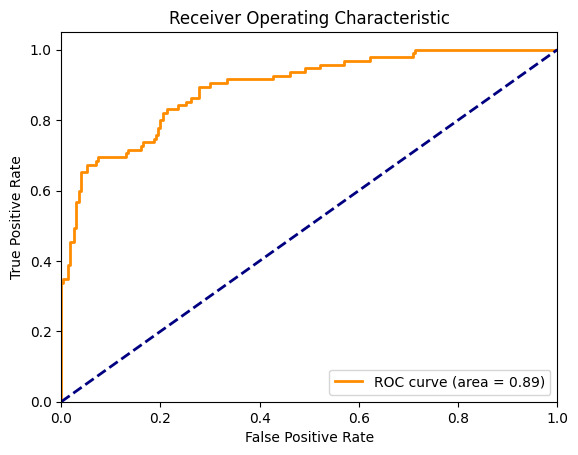

In [ ]:
# Realizar predicciones
y_pred_proba = classifier.predict(X_test_encoded)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Imprimir AUC
print(f"AUC: {roc_auc}")

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

AUC de 0.767

Resultados de Prueba

*   Accuracy: **69.9%**
*   Precision: **41.4%**
*   Sensitivity: **79.0%**
*   Specificity: **60.7%**
*   F1 Score para "0": **0.72**
*   F1 Score para "1": **0.54**

##### Magnetómetro (Mag)

In [ ]:
# Función para extraer características de una serie temporal
def extract_features_from_series(series):
    series = np.asarray(series)  # Asegurarse de que sea un array de NumPy
    series = series.astype(float)  # Convertir a flotante para evitar overflow

    return {
        'mean': np.mean(series),
        'std': np.std(series),
        'var': np.var(series),
        'max': np.max(series),
        'min': np.min(series),
        'range': np.ptp(series),  # np.ptp es equivalente a np.max - np.min pero más seguro
        'kurtosis': pd.Series(series).kurtosis(),
        'skewness': pd.Series(series).skew()
    }

# Función para procesar cada fila de datos
def process_mag_row(mag_data):
    x_vals = np.array([point[0] for point in mag_data])
    y_vals = np.array([point[1] for point in mag_data])
    z_vals = np.array([point[2] for point in mag_data])

    # Asegurarse de que cada valor sea numérico y no una lista o array multidimensional
    x_features = extract_features_from_series(x_vals)
    y_features = extract_features_from_series(y_vals)
    z_features = extract_features_from_series(z_vals)

    # Combinar todas las características en un solo vector (diccionario)
    mag_features = {f'x_{key}': val for key, val in x_features.items()}
    mag_features.update({f'y_{key}': val for key, val in y_features.items()})
    mag_features.update({f'z_{key}': val for key, val in z_features.items()})

    return mag_features

# Separamos características y preparamos datos:
df_train_waist_features = df_train_waist[feature_cols_mag].apply(lambda row: process_mag_row(row['Mag']), axis=1)
df_train_waist_features = pd.DataFrame(df_train_waist_features.tolist())
X_train_waist_mag = df_train_waist_features
y_train_waist_mag = df_train_waist[target_col]

df_test_waist_features = df_test_waist[feature_cols_mag].apply(lambda row: process_mag_row(row['Mag']), axis=1)
df_test_waist_features = pd.DataFrame(df_test_waist_features.tolist())
X_test_waist_mag = df_test_waist_features
y_test_waist_mag = df_test_waist[target_col]

Normalizamos características:

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train_waist_mag = scaler.fit_transform(X_train_waist_mag)
X_test_waist_mag = scaler.transform(X_test_waist_mag)

In [ ]:
# Dividir el conjunto de datos en entrenamiento y validación
X_train_waist_mag, X_val_waist_mag, y_train_waist_mag, y_val_waist_mag = train_test_split(X_train_waist_mag, y_train_waist_mag, test_size=0.2, random_state=42)

###### 1. **Modelo k-NN**

Realizamos predicciones:

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_waist_mag, y_train_waist_mag)
y_pred = knn.predict(X_test_waist_mag)

Evaluación del modelo:

In [ ]:
# Evaluación en el conjunto de validación
y_val_pred_waist_mag_knn = knn.predict(X_val_waist_mag)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_mag, y_val_pred_waist_mag_knn)
val_precision = precision_score(y_val_waist_mag, y_val_pred_waist_mag_knn, average='binary')
val_recall = recall_score(y_val_waist_mag, y_val_pred_waist_mag_knn, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_mag, y_val_pred_waist_mag_knn).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_mag, y_val_pred_waist_mag_knn)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_mag, y_val_pred_waist_mag_knn).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_mag, y_val_pred_waist_mag_knn))

# Guardar métricas de validación en un diccionario
res_val_waist_mag_knn = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.8542372881355932
Validation Precision: 0.8169014084507042
Validation Sensitivity: 0.6590909090909091
Validation Specificity: 0.9371980676328503
Validation Balanced Accuracy: 0.7981444883618797

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90       207
           1       0.82      0.66      0.73        88

    accuracy                           0.85       295
   macro avg       0.84      0.80      0.81       295
weighted avg       0.85      0.85      0.85       295



In [ ]:
# Evaluación en el conjunto de prueba
y_test_pred_waist_mag_knn = knn.predict(X_test_waist_mag)

print("\nTest Accuracy:", accuracy_score(y_test_waist_mag, y_test_pred_waist_mag_knn))
print("Test Precision:", precision_score(y_test_waist_mag, y_test_pred_waist_mag_knn, average='binary'))
print("Test Sensitivity:", recall_score(y_test_waist_mag, y_test_pred_waist_mag_knn, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test_waist_mag, y_test_pred_waist_mag_knn).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_waist_mag, y_test_pred_waist_mag_knn))

print("\nTest Classification Report:\n", classification_report(y_test_waist_mag, y_test_pred_waist_mag_knn))


Test Accuracy: 0.8892307692307693
Test Precision: 0.8105263157894737
Test Sensitivity: 0.8105263157894737
Test Specificity: 0.9217391304347826
Test Balanced Accuracy: 0.8661327231121281

Test Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       230
           1       0.81      0.81      0.81        95

    accuracy                           0.89       325
   macro avg       0.87      0.87      0.87       325
weighted avg       0.89      0.89      0.89       325



Resultados de Validación

*   Accuracy: **85.4%**
*   Precision: **81.7%**
*   Sensitivity: **65.9%**
*   Specificity: **93.7%**
*   F1 Score para "0": **0.90**
*   F1 Score para "1": **0.73**

Estos resultados muestran ...

Resultados de Prueba

*   Accuracy: **74.0%**
*   Precision: **50.1%**
*   Sensitivity: **71.5%**
*   Specificity: **74.9%**
*   F1 Score para "0": **0.81**
*   F1 Score para "1": **0.59**

En comparación con los resultados de validación, los resultados del conjunto de prueba muestran ...

###### 2. **Modelo SVM**

In [ ]:
# Crear el modelo SVM
svm_model = SVC(kernel='linear')  # Puedes probar otros kernels como 'rbf', 'poly', etc.

# Entrenar el modelo
svm_model.fit(X_train_waist_mag, y_train_waist_mag)

# Hacer predicciones en el conjunto de validación
y_val_pred_waist_mag_svm = svm_model.predict(X_val_waist_mag)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_mag, y_val_pred_waist_mag_svm)
val_precision = precision_score(y_val_waist_mag, y_val_pred_waist_mag_svm, average='binary')
val_recall = recall_score(y_val_waist_mag, y_val_pred_waist_mag_svm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_mag, y_val_pred_waist_mag_svm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_mag, y_val_pred_waist_mag_svm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_mag, y_val_pred_waist_mag_svm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_mag, y_val_pred_waist_mag_svm))

# Guardar métricas de validación en un diccionario
res_val_waist_mag_svm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.8542372881355932
Validation Precision: 0.835820895522388
Validation Sensitivity: 0.6363636363636364
Validation Specificity: 0.9468599033816425
Validation Balanced Accuracy: 0.7916117698726395

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90       207
           1       0.84      0.64      0.72        88

    accuracy                           0.85       295
   macro avg       0.85      0.79      0.81       295
weighted avg       0.85      0.85      0.85       295



In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred_waist_mag_svm = svm_model.predict(X_test_waist_mag)

# Evaluar el modelo en el conjunto de prueba
print(f"\nTest Accuracy:", accuracy_score(y_test_waist_mag, y_test_pred_waist_mag_svm))
print(f"Test Precision:", precision_score(y_test_waist_mag, y_test_pred_waist_mag_svm))
print(f"Test Sensitivity:", recall_score(y_test_waist_mag, y_test_pred_waist_mag_svm))
tn, fp, fn, tp = confusion_matrix(y_test_waist_mag, y_test_pred_waist_mag_svm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_waist_mag, y_test_pred_waist_mag_svm))

print("\nTest Classification Report:", classification_report(y_test_waist_mag, y_test_pred_waist_mag_svm))


Test Accuracy: 0.8369230769230769
Test Precision: 0.7625
Test Sensitivity: 0.6421052631578947
Test Specificity: 0.9173913043478261
Test Balanced Accuracy: 0.7797482837528604

Test Classification Report:               precision    recall  f1-score   support

           0       0.86      0.92      0.89       230
           1       0.76      0.64      0.70        95

    accuracy                           0.84       325
   macro avg       0.81      0.78      0.79       325
weighted avg       0.83      0.84      0.83       325



Ajuste de Hiperparámetros con GridSearchCV:

In [ ]:
# Definir los hiperparámetros a probar
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']  # solo afecta a algunos kernels
}

# Crear el modelo SVM
svm_model = SVC()

# Implementar GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar el modelo con GridSearchCV
grid_search.fit(X_train_waist_mag, y_train_waist_mag)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Usar el mejor modelo encontrado
best_svm_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de validación
y_val_pred_waist_mag_svm = best_svm_model.predict(X_val_waist_mag)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_mag, y_val_pred_waist_mag_svm)
val_precision = precision_score(y_val_waist_mag, y_val_pred_waist_mag_svm, average='binary')
val_recall = recall_score(y_val_waist_mag, y_val_pred_waist_mag_svm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_mag, y_val_pred_waist_mag_svm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_mag, y_val_pred_waist_mag_svm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_mag, y_val_pred_waist_mag_svm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_mag, y_val_pred_waist_mag_svm))

# Guardar métricas de validación en un diccionario
res_val_waist_mag_svm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

Mejores hiperparámetros: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Validation Accuracy: 0.8983050847457628
Validation Precision: 0.881578947368421
Validation Sensitivity: 0.7613636363636364
Validation Specificity: 0.9565217391304348
Validation Balanced Accuracy: 0.8589426877470356

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       207
           1       0.88      0.76      0.82        88

    accuracy                           0.90       295
   macro avg       0.89      0.86      0.87       295
weighted avg       0.90      0.90      0.90       295



Validación Cruzada

In [ ]:
# Realizar validación cruzada con los mejores parámetros
cv_scores = cross_val_score(best_svm_model, X_train_waist_mag, y_train_waist_mag, cv=5, scoring='accuracy')

print(f"Validation Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean()}")

Validation Cross-Validation Scores: [0.87711864 0.86864407 0.90638298 0.8893617  0.91489362]
Mean Cross-Validation Accuracy: 0.8912802019473494


Evaluación del Modelo en el Conjunto de Prueba

In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred_waist_mag_svm = best_svm_model.predict(X_test_waist_mag)

# Evaluar el modelo en el conjunto de prueba
print(f"\nTest Accuracy:", accuracy_score(y_test_waist_mag, y_test_pred_waist_mag_svm))
print(f"Test Precision:", precision_score(y_test_waist_mag, y_test_pred_waist_mag_svm))
print(f"Test Sensitivity:", recall_score(y_test_waist_mag, y_test_pred_waist_mag_svm))
tn, fp, fn, tp = confusion_matrix(y_test_waist_mag, y_test_pred_waist_mag_svm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_waist_mag, y_test_pred_waist_mag_svm))

print("\nTest Classification Report:", classification_report(y_test_waist_mag, y_test_pred_waist_mag_svm))


Test Accuracy: 0.8953846153846153
Test Precision: 0.8351648351648352
Test Sensitivity: 0.8
Test Specificity: 0.9347826086956522
Test Balanced Accuracy: 0.8673913043478261

Test Classification Report:               precision    recall  f1-score   support

           0       0.92      0.93      0.93       230
           1       0.84      0.80      0.82        95

    accuracy                           0.90       325
   macro avg       0.88      0.87      0.87       325
weighted avg       0.89      0.90      0.89       325



Sí mejora con GridSearchCV:

Resultados de Prueba

*   Accuracy: **73.1%**
*   Precision: **44.5%**
*   Sensitivity: **82.2%**
*   Specificity: **63.9%**
*   F1 Score para "0": **0.75**
*   F1 Score para "1": **0.58**

###### 3. **Modelo Random Forest**

In [ ]:
# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')  # Puedes ajustar 'n_estimators' y otros hiperparámetros

# Entrenar el modelo con las características extraídas
rf_model.fit(X_train_waist_mag, y_train_waist_mag)

# Hacer predicciones en el conjunto de validación
y_val_pred_waist_mag_rf = rf_model.predict(X_val_waist_mag)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_mag, y_val_pred_waist_mag_rf)
val_precision = precision_score(y_val_waist_mag, y_val_pred_waist_mag_rf, average='binary')
val_recall = recall_score(y_val_waist_mag, y_val_pred_waist_mag_rf, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_mag, y_val_pred_waist_mag_rf).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_mag, y_val_pred_waist_mag_rf)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_mag, y_val_pred_waist_mag_rf).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_mag, y_val_pred_waist_mag_rf))

# Guardar métricas de validación en un diccionario
res_val_waist_mag_rf = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.888135593220339
Validation Precision: 0.8873239436619719
Validation Sensitivity: 0.7159090909090909
Validation Specificity: 0.961352657004831
Validation Balanced Accuracy: 0.838630873956961

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92       207
           1       0.89      0.72      0.79        88

    accuracy                           0.89       295
   macro avg       0.89      0.84      0.86       295
weighted avg       0.89      0.89      0.88       295



In [ ]:
# Realizar predicciones en el conjunto de prueba
y_test_pred_waist_mag_rf = rf_model.predict(X_test_waist_mag)

# Evaluar el rendimiento del modelo
print("\nTest Accuracy:", accuracy_score(y_test_waist_mag, y_test_pred_waist_mag_rf))
print("Test Precision:", precision_score(y_test_waist_mag, y_test_pred_waist_mag_rf, average='binary'))
print("Test Sensitivity (Recall):", recall_score(y_test_waist_mag, y_test_pred_waist_mag_rf, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test_waist_mag, y_test_pred_waist_mag_rf).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_waist_mag, y_test_pred_waist_mag_rf))

print("\nTest Classification Report:\n", classification_report(y_test_waist_mag, y_test_pred_waist_mag_rf))


Test Accuracy: 0.8984615384615384
Test Precision: 0.8875
Test Sensitivity (Recall): 0.7473684210526316
Test Specificity: 0.9608695652173913
Test Balanced Accuracy: 0.8541189931350115

Test Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       230
           1       0.89      0.75      0.81        95

    accuracy                           0.90       325
   macro avg       0.89      0.85      0.87       325
weighted avg       0.90      0.90      0.90       325



Resultados de Prueba

*   Accuracy: **74.5%**
*   Precision: **50.9%**
*   Sensitivity: **64.2%**
*   Specificity: **78.2%**
*   F1 Score para "0": **0.82**
*   F1 Score para "1": **0.57**

###### 4. **Modelo LSTM**

Padding y división de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_waist[feature_cols_mag].applymap(len).max().max()
print(f"Longitud máxima de secuencia: {max_length}")

Longitud máxima de secuencia: 1600


<ipython-input-286-b9a233231c14>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_waist[feature_cols_mag].applymap(len).max().max()


In [ ]:
# Crear un índice de validación a partir de la división de entrenamiento y validación
train_indices, val_indices = train_test_split(df_train_waist.index, test_size=0.2, random_state=42)

# Crear los conjuntos de secuencias de entrenamiento y validación
df_train_waist_train = df_train_waist.loc[train_indices]
df_train_waist_val = df_train_waist.loc[val_indices]

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols_mag, max_length):
    padded_features = []
    for col in feature_cols_mag:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)
            if sequence.shape[1] < 3:
                # Añadir columnas con ceros para igualar a 3 dimensiones
                sequence = np.pad(sequence, ((0, 0), (0, 3 - sequence.shape[1])), 'constant', constant_values=0)
            if len(sequence) < max_length:
                padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
            else:
                padded_sequence = sequence[:max_length]
            padded_col.append(padded_sequence)

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_waist_train, feature_cols_mag, max_length)
y_train = df_train_waist_train[target_col].values

# Aplicar padding al conjunto de validación
X_val_waist_mag = pad_sequences_feature(df_train_waist_val, feature_cols_mag, max_length)
y_val_waist_mag = df_train_waist_val[target_col].values

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalizar las características del conjunto de validación
X_val_waist_mag = scaler.transform(X_val_waist_mag.reshape(-1, X_val_waist_mag.shape[-1])).reshape(X_val_waist_mag.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test_waist, feature_cols_mag, max_length)
y_test = df_test_waist[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Configurar la semilla para la reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
print("Dimensiones de X_train:")
print(f"Forma: {X_train.shape}")
print(f"Número de muestras: {X_train.shape[0]}")
print(f"Longitud de secuencia (timesteps): {X_train.shape[1]}")
print(f"Número de características: {X_train.shape[2]}")

print("\nDimensiones de X_test:")
print(f"Forma: {X_test.shape}")
print(f"Número de muestras: {X_test.shape[0]}")
print(f"Longitud de secuencia (timesteps): {X_test.shape[1]}")
print(f"Número de características: {X_test.shape[2]}")

Dimensiones de X_train:
Forma: (1177, 1600, 3)
Número de muestras: 1177
Longitud de secuencia (timesteps): 1600
Número de características: 3

Dimensiones de X_test:
Forma: (325, 1600, 3)
Número de muestras: 325
Longitud de secuencia (timesteps): 1600
Número de características: 3


In [ ]:
# Verificar la forma de entrada esperada para el modelo
input_shape = (1600, 3)  # Esto debe coincidir con las dimensiones de tus datos

print(f"Forma de entrada esperada para el modelo: {input_shape}")

Forma de entrada esperada para el modelo: (1600, 3)


*  Menor Tiempo de Cómputo: RandomizedSearchCV es mucho más rápido que GridSearchCV para grandes espacios de hiperparámetros.
*  Exploración Eficiente: Aunque no prueba todas las combinaciones posibles, es probable que encuentre una buena combinación de hiperparámetros en menos tiempo.

In [ ]:
# Crear el modelo LSTM
model = Sequential()
model.add(Masking(mask_value=0., input_shape=input_shape))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con pesos de clase
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val_waist_mag, y_val_waist_mag), class_weight=class_weights)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.6691 - loss: 0.6612 - val_accuracy: 0.6712 - val_loss: 0.6197
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.6711 - loss: 0.6260 - val_accuracy: 0.6169 - val_loss: 0.6450
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.6504 - loss: 0.6211 - val_accuracy: 0.6271 - val_loss: 0.6343
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.6509 - loss: 0.6177 - val_accuracy: 0.6271 - val_loss: 0.6398
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.6472 - loss: 0.6161 - val_accuracy: 0.6305 - val_loss: 0.6403
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.6415 - loss: 0.6143 - val_accuracy: 0.5288 - val_loss: 0.6781
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.5830 - loss: 0.6277 - val_accuracy: 0.6644 - val_loss: 0.6243
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.6565 - loss: 0.6134 - val_accuracy: 0.6678 - val_loss

In [ ]:
# Realizar predicciones en el conjunto de validación
y_val_pred_waist_mag_lstm = (model.predict(X_val_waist_mag) > 0.5).astype("int32").ravel()

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_mag, y_val_pred_waist_mag_lstm)
val_precision = precision_score(y_val_waist_mag, y_val_pred_waist_mag_lstm, average='binary')
val_recall = recall_score(y_val_waist_mag, y_val_pred_waist_mag_lstm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_mag, y_val_pred_waist_mag_lstm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_mag, y_val_pred_waist_mag_lstm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_mag, y_val_pred_waist_mag_lstm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_mag, y_val_pred_waist_mag_lstm))

# Guardar métricas de validación en un diccionario
res_val_waist_mag_lstm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step

Validation Accuracy: 0.6915254237288135
Validation Precision: 0.48760330578512395
Validation Sensitivity: 0.6704545454545454
Validation Specificity: 0.7004830917874396
Validation Balanced Accuracy: 0.6854688186209925

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.70      0.76       207
           1       0.49      0.67      0.56        88

    accuracy                           0.69       295
   macro avg       0.66      0.69      0.66       295
weighted avg       0.73      0.69      0.70       295



In [ ]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Realizar predicciones en el conjunto de prueba
y_test_pred_waist_mag_lstm = (model.predict(X_test) > 0.5).astype("int32").ravel()

print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_waist_mag_lstm))
print("Test Precision:", precision_score(y_test, y_test_pred_waist_mag_lstm, average='binary'))
print("Test Sensitivity:", recall_score(y_test, y_test_pred_waist_mag_lstm, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_waist_mag_lstm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_waist_mag_lstm))

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_waist_mag_lstm))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.7518 - loss: 0.5643
Loss: 0.5887140035629272, Accuracy: 0.7384615540504456
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

Test Accuracy: 0.7384615384615385
Test Precision: 0.5373134328358209
Test Sensitivity: 0.7578947368421053
Test Specificity: 0.7304347826086957
Test Balanced Accuracy: 0.7441647597254004

Test Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.73      0.80       230
           1       0.54      0.76      0.63        95

    accuracy                           0.74       325
   macro avg       0.71      0.74      0.71       325
weighted avg       0.78      0.74      0.75       325



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
AUC: 0.771121281464531


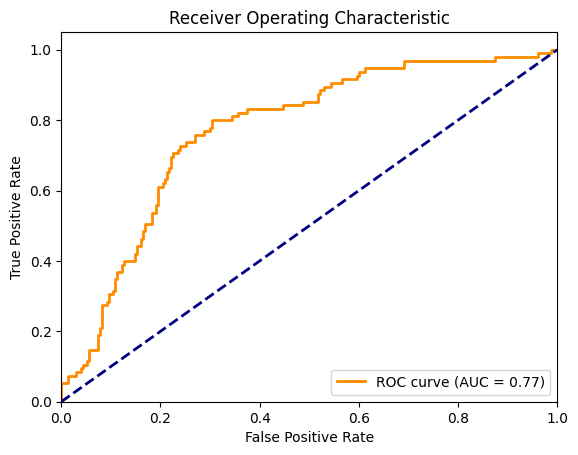

In [ ]:
# Calcular probabilidades de predicción
y_pred_proba = model.predict(X_test)

# Calcular curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Imprimir AUC
print(f"AUC: {roc_auc}")

# Graficar curva ROC
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Resultados de Prueba

*   Accuracy: **57.0%**
*   Precision: **29.6%**
*   Sensitivity: **85.7%**
*   Specificity: **28.3%**
*   F1 Score para "0": **0.43**
*   F1 Score para "1": **0.44**


###### 5. **Modelo CNN**

In [ ]:
# Definir el modelo
model = Sequential()
model.add(Input(shape=(1600, 3)))  # Definir explícitamente el tamaño de entrada
model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val_waist_mag, y_val_waist_mag))

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.7200 - loss: 1.2224 - val_accuracy: 0.8915 - val_loss: 0.3241
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8833 - loss: 0.3180 - val_accuracy: 0.9017 - val_loss: 0.2810
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8968 - loss: 0.2826 - val_accuracy: 0.9119 - val_loss: 0.2519
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8983 - loss: 0.2478 - val_accuracy: 0.8949 - val_loss: 0.2491
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9012 - loss: 0.2357 - val_accuracy: 0.9220 - val_loss: 0.2159
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9183 - loss: 0.2140 - val_accuracy: 0.9356 - val_loss: 0.1879
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9248 - loss: 0.1888 - val_accuracy: 0.9356 - val_loss: 0.1697
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9362 - loss: 0.1717 - val_accuracy: 0.9322 - val_loss

In [ ]:
# Evaluar el modelo en el conjunto de validación
y_val_pred_waist_mag_cnn = model.predict(X_val_waist_mag).ravel()  # Genera predicciones
y_val_pred_waist_mag_cnn = (y_val_pred_waist_mag_cnn > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_mag, y_val_pred_waist_mag_cnn)
val_precision = precision_score(y_val_waist_mag, y_val_pred_waist_mag_cnn, average='binary')
val_recall = recall_score(y_val_waist_mag, y_val_pred_waist_mag_cnn, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_mag, y_val_pred_waist_mag_cnn).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_mag, y_val_pred_waist_mag_cnn)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_mag, y_val_pred_waist_mag_cnn).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_mag, y_val_pred_waist_mag_cnn))

# Guardar métricas de validación en un diccionario
res_val_waist_mag_cnn = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step

Validation Accuracy: 0.9186440677966101
Validation Precision: 0.9210526315789473
Validation Sensitivity: 0.7954545454545454
Validation Specificity: 0.9710144927536232
Validation Balanced Accuracy: 0.8832345191040842

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94       207
           1       0.92      0.80      0.85        88

    accuracy                           0.92       295
   macro avg       0.92      0.88      0.90       295
weighted avg       0.92      0.92      0.92       295



In [ ]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred_waist_mag_cnn = model.predict(X_test).ravel()  # Genera predicciones
y_test_pred_waist_mag_cnn = (y_test_pred_waist_mag_cnn > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias

# Cálculo de métricas
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_waist_mag_cnn))
print("Test Precision:", precision_score(y_test, y_test_pred_waist_mag_cnn, average='binary'))
print("Test Sensitivity (Recall):", recall_score(y_test, y_test_pred_waist_mag_cnn, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_waist_mag_cnn).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_waist_mag_cnn))

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_waist_mag_cnn))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Test Accuracy: 0.916923076923077
Test Precision: 0.8863636363636364
Test Sensitivity (Recall): 0.8210526315789474
Test Specificity: 0.9565217391304348
Test Balanced Accuracy: 0.8887871853546911

Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94       230
           1       0.89      0.82      0.85        95

    accuracy                           0.92       325
   macro avg       0.91      0.89      0.90       325
weighted avg       0.92      0.92      0.92       325



Validación Cruzada K-Fold:

In [ ]:
# Definir el número de folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Inicializar listas para almacenar los resultados de cada fold
accuracy_per_fold = []
loss_per_fold = []
precision_per_fold = []
recall_per_fold = []
specificity_per_fold = []
f1_per_fold = []
balanced_accuracy_per_fold = []

# Iterar sobre cada fold
for train_index, val_index in kf.split(X_train):
    # Dividir los datos en entrenamiento y validación
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Definir el modelo (es importante definirlo dentro del loop para reiniciarlo en cada fold)
    model = Sequential()
    model.add(Input(shape=(1600, 3)))  # Definir explícitamente el tamaño de entrada
    model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo en el fold actual
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)

    # Evaluar el modelo en el conjunto de validación del fold actual
    y_val_pred = model.predict(X_val_fold).ravel()
    y_val_pred = (y_val_pred > 0.5).astype(int)

    # Cálculo de métricas para el fold actual
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    loss = model.evaluate(X_val_fold, y_val_fold, verbose=0)[0]
    precision = precision_score(y_val_fold, y_val_pred)
    recall = recall_score(y_val_fold, y_val_pred)
    f1 = f1_score(y_val_fold, y_val_pred)
    cm = confusion_matrix(y_val_fold, y_val_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    balanced_accuracy = balanced_accuracy_score(y_val_fold, y_val_pred)

    # Almacenar las métricas para este fold
    accuracy_per_fold.append(accuracy)
    loss_per_fold.append(loss)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    specificity_per_fold.append(specificity)
    f1_per_fold.append(f1)
    balanced_accuracy_per_fold.append(balanced_accuracy)

# Mostrar resultados promedio de las métricas de k-fold
print(f'\nMean Accuracy (k-Fold): {np.mean(accuracy_per_fold)}')
print(f'Mean Loss (k-Fold): {np.mean(loss_per_fold)}')
print(f'Mean Precision (k-Fold): {np.mean(precision_per_fold)}')
print(f'Mean Recall (k-Fold): {np.mean(recall_per_fold)}')
print(f'Mean Specificity (k-Fold): {np.mean(specificity_per_fold)}')
print(f'Mean F1 Score (k-Fold): {np.mean(f1_per_fold)}')
print(f'Mean Balanced Accuracy (k-Fold): {np.mean(balanced_accuracy_per_fold)}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Mean Accuracy (k-Fold): 0.9082221420843851
Mean Loss (k-Fold): 0.2972907692193985
Mean Precision (k-Fold): 0.8285869141038071
Mean Recall (k-Fold): 0.7805460825526044
Mean Specificity (k-Fold): 0.9465299492944734
Mean F1 Score (k-Fold): 0.801401875901876
Mean Balanced Accuracy (k-Fold): 0.8635380159235388


**Mean Accuracy**:

**Mean Precision**:

**Mean Sensitivity**:

**Mean Specifity**:

**Mean F1 Score**:

###### 6. **Modelo SAE**

Padding y división de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_waist[feature_cols_mag].applymap(len).max().max()
print(f"Longitud máxima de secuencia: {max_length}")

Longitud máxima de secuencia: 1600


<ipython-input-302-b9a233231c14>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_waist[feature_cols_mag].applymap(len).max().max()


In [ ]:
# Crear un índice de validación a partir de la división de entrenamiento y validación
train_indices, val_indices = train_test_split(df_train_waist.index, test_size=0.2, random_state=42)

# Crear los conjuntos de secuencias de entrenamiento y validación
df_train_waist_train = df_train_waist.loc[train_indices]
df_train_waist_val = df_train_waist.loc[val_indices]

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols_mag, max_length):
    padded_features = []
    for col in feature_cols_mag:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)
            if sequence.shape[1] < 3:
                # Añadir columnas con ceros para igualar a 3 dimensiones
                sequence = np.pad(sequence, ((0, 0), (0, 3 - sequence.shape[1])), 'constant', constant_values=0)
            if len(sequence) < max_length:
                padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
            else:
                padded_sequence = sequence[:max_length]
            padded_col.append(padded_sequence)

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_waist_train, feature_cols_mag, max_length)
y_train = df_train_waist_train[target_col].values

# Aplicar padding al conjunto de validación
X_val_waist_mag = pad_sequences_feature(df_train_waist_val, feature_cols_mag, max_length)
y_val_waist_mag = df_train_waist_val[target_col].values

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalizar las características del conjunto de validación
X_val_waist_mag = scaler.transform(X_val_waist_mag.reshape(-1, X_val_waist_mag.shape[-1])).reshape(X_val_waist_mag.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test_waist, feature_cols_mag, max_length)
y_test = df_test_waist[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")

Forma de X_train: (1177, 1600, 3)
Forma de X_test: (325, 1600, 3)


*  **1854 / 1321** son el número de muestras para el conjunto de entrenamiento y prueba, respectivamente.
*  **1600** es la longitud de la ventana de tiempo (en muestras) para cada señal.
*  **3** representa los tres canales de aceleración (ax, ay, az).

In [ ]:
# Ver los primeros 5 valores de cada canal en la primera muestra
print("Primeros 5 valores del primer canal (ax) de la primera muestra de X_train:")
print(X_train[0, :5, 0])  # Canal ax

print("Primeros 5 valores del segundo canal (ay) de la primera muestra de X_train:")
print(X_train[0, :5, 1])  # Canal ay

print("Primeros 5 valores del tercer canal (az) de la primera muestra de X_train:")
print(X_train[0, :5, 2])  # Canal az

Primeros 5 valores del primer canal (ax) de la primera muestra de X_train:
[-0.79473956 -0.79640194 -0.79861845 -0.79307718 -0.80637623]
Primeros 5 valores del segundo canal (ay) de la primera muestra de X_train:
[0.36377842 0.37100814 0.35654871 0.37643042 0.47282657]
Primeros 5 valores del tercer canal (az) de la primera muestra de X_train:
[0.93889884 0.94760049 0.92149554 0.9265715  0.89937885]


In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Configurar la semilla para la reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
# Parámetros
input_shape = (1600, 3)  # Ajusta esto a la forma de tu entrada
kernel_size = 7
filters = [32, 64]  # Número de filtros en cada capa convolucional

# Definir la función de autoencoder
def build_autoencoder(input_shape, filters, kernel_size):
    input_layer = Input(shape=input_shape)

    # Encoder
    x = Conv1D(filters=filters[0], kernel_size=kernel_size, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)

    # Bottleneck
    bottleneck_shape = x.shape[1:]  # Obtiene la forma después de las capas convolucionales y de pooling
    x = Flatten()(x)
    bottleneck = Dense(128, activation='relu')(x)  # Puedes ajustar la dimensión del bottleneck

    # Decoder
    x = Dense(np.prod(bottleneck_shape), activation='relu')(bottleneck)
    x = Reshape(bottleneck_shape)(x)  # Redimensiona a la forma adecuada para las capas convolucionales de decodificación
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=input_shape[1], kernel_size=kernel_size, activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_layer, x)
    encoder = Model(input_layer, bottleneck)

    return autoencoder, encoder

# Construir el autoencoder
autoencoder, encoder = build_autoencoder(input_shape, filters, kernel_size)

# Compilar el autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenar el autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2)

# Extraer las características usando el encoder
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val_waist_mag)
X_test_encoded = encoder.predict(X_test)

# Crear el clasificador denso
def build_classifier(input_shape):
    input_layer = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input_layer)
    x = Dense(32, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    classifier = Model(input_layer, output_layer)
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return classifier

# Construir el clasificador
classifier = build_classifier(X_train_encoded.shape[1:])

# Entrenar el clasificador
classifier.fit(X_train_encoded, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weights)

# Evaluar el clasificador
loss, accuracy = classifier.evaluate(X_test_encoded, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - loss: 0.9998 - val_loss: 0.7970
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.6935 - val_loss: 0.7747
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6649 - val_loss: 0.7462
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6393 - val_loss: 0.7245
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6200 - val_loss: 0.7196
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6150 - val_loss: 0.7165
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6127 - val_loss: 0.7138
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6091 - val_loss: 0.7110
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6052 - val_loss: 0.7070
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6016 - val_loss: 0.7049
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 1/10
30/30 ━━━━━━━━━━━

In [ ]:
# Realizar predicciones
y_val_pred_waist_mag_sae = (classifier.predict(X_val_encoded) > 0.5).astype(int).ravel()

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_mag, y_val_pred_waist_mag_sae)
val_precision = precision_score(y_val_waist_mag, y_val_pred_waist_mag_sae, average='binary')
val_recall = recall_score(y_val_waist_mag, y_val_pred_waist_mag_sae, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_mag, y_val_pred_waist_mag_sae).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_mag, y_val_pred_waist_mag_sae)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_mag, y_val_pred_waist_mag_sae).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_mag, y_val_pred_waist_mag_sae))

# Guardar métricas de validación en un diccionario
res_val_waist_mag_sae = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Validation Accuracy: 0.8610169491525423
Validation Precision: 0.7422680412371134
Validation Sensitivity: 0.8181818181818182
Validation Specificity: 0.8792270531400966
Validation Balanced Accuracy: 0.8487044356609574

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90       207
           1       0.74      0.82      0.78        88

    accuracy                           0.86       295
   macro avg       0.83      0.85      0.84       295
weighted avg       0.87      0.86      0.86       295



In [ ]:
# Realizar predicciones
y_test_pred_waist_mag_sae = (classifier.predict(X_test_encoded) > 0.5).astype(int).ravel()

# Cálculo de métricas
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_waist_mag_sae))
print("Test Precision:", precision_score(y_test, y_test_pred_waist_mag_sae, average='binary'))
print("Test Sensitivity:", recall_score(y_test, y_test_pred_waist_mag_sae, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_waist_mag_sae).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_waist_mag_sae))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_waist_mag_sae))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Test Accuracy: 0.8338461538461538
Test Precision: 0.6846846846846847
Test Sensitivity: 0.8
Test Specificity: 0.8478260869565217
Test Balanced Accuracy: 0.8239130434782609

Test Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88       230
           1       0.68      0.80      0.74        95

    accuracy                           0.83       325
   macro avg       0.80      0.82      0.81       325
weighted avg       0.84      0.83      0.84       325



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
AUC: 0.9040274599542334


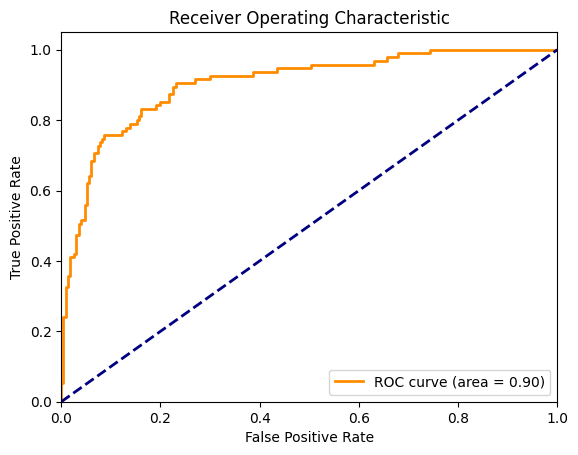

In [ ]:
# Realizar predicciones
y_pred_proba = classifier.predict(X_test_encoded)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Imprimir AUC
print(f"AUC: {roc_auc}")

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

AUC de 0.79

Resultados de Prueba

*   Accuracy: **77.0%**
*   Precision: **54.8%**
*   Sensitivity: **68.0%**
*   Specificity: **80.2%**
*   F1 Score para "0": **0.84**
*   F1 Score para "1": **0.61**

##### Barómetro (Bar)

In [ ]:
print("\nPrimeros 10 valores de Barómetro:\n")
# Mostrar los primeros 10 valores de la columna 'Bar'
print(df['Bar'].head(10))


Primeros 10 valores de Barómetro:

0    [[1013.193859563175, 23.71569457530976], [1013...
1    [[1013.214612231942, 24.11322125434876], [1013...
2    [[1013.25438772214, 24.49373892784119], [1013....
3    [[1013.167161107663, 24.72971366882324], [1013...
4    [[1013.304382379492, 25.49256420612335], [1013...
5    [[1013.230161870285, 25.81876062870026], [1013...
6    [[1013.334809656024, 26.10670359611511], [1013...
7    [[1013.193141805044, 26.26798661708832], [1013...
8    [[1013.347202020856, 26.88757157802582], [1013...
9    [[1013.193350133783, 27.02700508594513], [1013...
Name: Bar, dtype: object


In [ ]:
# Función para extraer características de una serie temporal
def extract_features_from_series(series):
    series = np.asarray(series)  # Asegurarse de que sea un array de NumPy
    series = series.astype(float)  # Convertir a flotante para evitar overflow

    return {
        'mean': np.mean(series),
        'std': np.std(series),
        'var': np.var(series),
        'max': np.max(series),
        'min': np.min(series),
        'range': np.ptp(series),  # np.ptp es equivalente a np.max - np.min pero más seguro
        'kurtosis': pd.Series(series).kurtosis(),
        'skewness': pd.Series(series).skew()
    }

# Función para procesar cada fila de datos
def process_bar_row(bar_data):
    x_vals = np.array([point[0] for point in bar_data])
    y_vals = np.array([point[1] for point in bar_data])

    # Asegurarse de que cada valor sea numérico y no una lista o array multidimensional
    x_features = extract_features_from_series(x_vals)
    y_features = extract_features_from_series(y_vals)

    # Combinar todas las características en un solo vector (diccionario)
    bar_features = {f'x_{key}': val for key, val in x_features.items()}
    bar_features.update({f'y_{key}': val for key, val in y_features.items()})

    return bar_features

# Separamos características y preparamos datos:
df_train_waist_features = df_train_waist[feature_cols_bar].apply(lambda row: process_bar_row(row['Bar']), axis=1)
df_train_waist_features = pd.DataFrame(df_train_waist_features.tolist())
X_train_waist_bar = df_train_waist_features
y_train_waist_bar = df_train_waist[target_col]

df_test_waist_features = df_test_waist[feature_cols_bar].apply(lambda row: process_bar_row(row['Bar']), axis=1)
df_test_waist_features = pd.DataFrame(df_test_waist_features.tolist())
X_test_waist_bar = df_test_waist_features
y_test_waist_bar = df_test_waist[target_col]

Normalizamos características:

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train_waist_bar = scaler.fit_transform(X_train_waist_bar)
X_test_waist_bar = scaler.transform(X_test_waist_bar)

In [ ]:
# Dividir el conjunto de datos en entrenamiento y validación
X_train_waist_bar, X_val_waist_bar, y_train_waist_bar, y_val_waist_bar = train_test_split(X_train_waist_bar, y_train_waist_bar, test_size=0.2, random_state=42)

###### 1. **Modelo k-NN**

Realizamos predicciones:

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_waist_bar, y_train_waist_bar)
y_pred = knn.predict(X_test_waist_bar)

Evaluación del modelo:

In [ ]:
# Evaluación en el conjunto de validación
y_val_pred_waist_bar_knn = knn.predict(X_val_waist_bar)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_bar, y_val_pred_waist_bar_knn)
val_precision = precision_score(y_val_waist_bar, y_val_pred_waist_bar_knn, average='binary')
val_recall = recall_score(y_val_waist_bar, y_val_pred_waist_bar_knn, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_bar, y_val_pred_waist_bar_knn).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_bar, y_val_pred_waist_bar_knn)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_bar, y_val_pred_waist_bar_knn).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_bar, y_val_pred_waist_bar_knn))

# Guardar métricas de validación en un diccionario
res_val_waist_bar_knn = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.8542372881355932
Validation Precision: 0.8461538461538461
Validation Sensitivity: 0.625
Validation Specificity: 0.9516908212560387
Validation Balanced Accuracy: 0.7883454106280193

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90       207
           1       0.85      0.62      0.72        88

    accuracy                           0.85       295
   macro avg       0.85      0.79      0.81       295
weighted avg       0.85      0.85      0.85       295



In [ ]:
# Evaluación en el conjunto de prueba
y_test_pred_waist_bar_knn = knn.predict(X_test_waist_bar)

print("\nTest Accuracy:", accuracy_score(y_test_waist_bar, y_test_pred_waist_bar_knn))
print("Test Precision:", precision_score(y_test_waist_bar, y_test_pred_waist_bar_knn, average='binary'))
print("Test Sensitivity:", recall_score(y_test_waist_bar, y_test_pred_waist_bar_knn, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test_waist_bar, y_test_pred_waist_bar_knn).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_waist_bar, y_test_pred_waist_bar_knn))

print("\nTest Classification Report:\n", classification_report(y_test_waist_bar, y_test_pred_waist_bar_knn))


Test Accuracy: 0.88
Test Precision: 0.85
Test Sensitivity: 0.7157894736842105
Test Specificity: 0.9478260869565217
Test Balanced Accuracy: 0.8318077803203661

Test Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       230
           1       0.85      0.72      0.78        95

    accuracy                           0.88       325
   macro avg       0.87      0.83      0.85       325
weighted avg       0.88      0.88      0.88       325



Resultados de Validación

*   Accuracy: **85.4%**
*   Precision: **84.6%**
*   Sensitivity: **62.5%**
*   Specificity: **95.1%**
*   F1 Score para "0": **0.90**
*   F1 Score para "1": **0.72**

Estos resultados muestran ...

Resultados de Prueba

*   Accuracy: **79.1%**
*   Precision: **60.1%**
*   Sensitivity: **58.7%**
*   Specificity: **86.3%**
*   F1 Score para "0": **0.86**
*   F1 Score para "1": **0.59**

En comparación con los resultados de validación, los resultados del conjunto de prueba muestran ...

###### 2. **Modelo SVM**

In [ ]:
# Crear el modelo SVM
svm_model = SVC(kernel='linear')  # Puedes probar otros kernels como 'rbf', 'poly', etc.

# Entrenar el modelo
svm_model.fit(X_train_waist_bar, y_train_waist_bar)

# Hacer predicciones en el conjunto de validación
y_val_pred_waist_bar_svm = svm_model.predict(X_val_waist_bar)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_bar, y_val_pred_waist_bar_svm)
val_precision = precision_score(y_val_waist_bar, y_val_pred_waist_bar_svm, average='binary')
val_recall = recall_score(y_val_waist_bar, y_val_pred_waist_bar_svm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_bar, y_val_pred_waist_bar_svm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_bar, y_val_pred_waist_bar_svm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_bar, y_val_pred_waist_bar_svm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_bar, y_val_pred_waist_bar_svm))

# Guardar métricas de validación en un diccionario
res_val_waist_bar_svm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.7728813559322034
Validation Precision: 0.9565217391304348
Validation Sensitivity: 0.25
Validation Specificity: 0.9951690821256038
Validation Balanced Accuracy: 0.6225845410628019

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.76      1.00      0.86       207
           1       0.96      0.25      0.40        88

    accuracy                           0.77       295
   macro avg       0.86      0.62      0.63       295
weighted avg       0.82      0.77      0.72       295



In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred_waist_bar_svm = svm_model.predict(X_test_waist_bar)

# Evaluar el modelo en el conjunto de prueba
print(f"\nTest Accuracy:", accuracy_score(y_test_waist_bar, y_test_pred_waist_bar_svm))
print(f"Test Precision:", precision_score(y_test_waist_bar, y_test_pred_waist_bar_svm))
print(f"Test Sensitivity:", recall_score(y_test_waist_bar, y_test_pred_waist_bar_svm))
tn, fp, fn, tp = confusion_matrix(y_test_waist_bar, y_test_pred_waist_bar_svm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_waist_bar, y_test_pred_waist_bar_svm))

print("\nTest Classification Report:", classification_report(y_test_waist_bar, y_test_pred_waist_bar_svm))


Test Accuracy: 0.7692307692307693
Test Precision: 0.8333333333333334
Test Sensitivity: 0.2631578947368421
Test Specificity: 0.9782608695652174
Test Balanced Accuracy: 0.6207093821510298

Test Classification Report:               precision    recall  f1-score   support

           0       0.76      0.98      0.86       230
           1       0.83      0.26      0.40        95

    accuracy                           0.77       325
   macro avg       0.80      0.62      0.63       325
weighted avg       0.78      0.77      0.72       325



Ajuste de Hiperparámetros con GridSearchCV:

In [ ]:
# Definir los hiperparámetros a probar
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']  # solo afecta a algunos kernels
}

# Crear el modelo SVM
svm_model = SVC()

# Implementar GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar el modelo con GridSearchCV
grid_search.fit(X_train_waist_bar, y_train_waist_bar)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Usar el mejor modelo encontrado
best_svm_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de validación
y_val_pred_waist_bar_svm = best_svm_model.predict(X_val_waist_bar)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_bar, y_val_pred_waist_bar_svm)
val_precision = precision_score(y_val_waist_bar, y_val_pred_waist_bar_svm, average='binary')
val_recall = recall_score(y_val_waist_bar, y_val_pred_waist_bar_svm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_bar, y_val_pred_waist_bar_svm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_bar, y_val_pred_waist_bar_svm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_bar, y_val_pred_waist_bar_svm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_bar, y_val_pred_waist_bar_svm))

# Guardar métricas de validación en un diccionario
res_val_waist_bar_svm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

Mejores hiperparámetros: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}

Validation Accuracy: 0.8779661016949153
Validation Precision: 0.8513513513513513
Validation Sensitivity: 0.7159090909090909
Validation Specificity: 0.9468599033816425
Validation Balanced Accuracy: 0.8313844971453668

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       207
           1       0.85      0.72      0.78        88

    accuracy                           0.88       295
   macro avg       0.87      0.83      0.85       295
weighted avg       0.88      0.88      0.87       295



Validación Cruzada

In [ ]:
# Realizar validación cruzada con los mejores parámetros
cv_scores = cross_val_score(best_svm_model, X_train_waist_bar, y_train_waist_bar, cv=5, scoring='accuracy')

print(f"Validation Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean()}")

Validation Cross-Validation Scores: [0.8220339  0.87711864 0.88510638 0.9106383  0.90212766]
Mean Cross-Validation Accuracy: 0.8794049765596826


Evaluación del Modelo en el Conjunto de Prueba

In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred_waist_bar_svm = best_svm_model.predict(X_test_waist_bar)

# Evaluar el modelo en el conjunto de prueba
print(f"\nTest Accuracy:", accuracy_score(y_test_waist_bar, y_test_pred_waist_bar_svm))
print(f"Test Precision:", precision_score(y_test_waist_bar, y_test_pred_waist_bar_svm))
print(f"Test Sensitivity:", recall_score(y_test_waist_bar, y_test_pred_waist_bar_svm))
tn, fp, fn, tp = confusion_matrix(y_test_waist_bar, y_test_pred_waist_bar_svm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_waist_bar, y_test_pred_waist_bar_svm))

print("\nTest Classification Report:", classification_report(y_test_waist_bar, y_test_pred_waist_bar_svm))


Test Accuracy: 0.8830769230769231
Test Precision: 0.8607594936708861
Test Sensitivity: 0.7157894736842105
Test Specificity: 0.9521739130434783
Test Balanced Accuracy: 0.8339816933638444

Test Classification Report:               precision    recall  f1-score   support

           0       0.89      0.95      0.92       230
           1       0.86      0.72      0.78        95

    accuracy                           0.88       325
   macro avg       0.88      0.83      0.85       325
weighted avg       0.88      0.88      0.88       325



Mejora con GridSearchCV:

Resultados de Prueba

*   Accuracy: **77.5%**
*   Precision: **56.0%**
*   Sensitivity: **63.3%**
*   Specificity: **82.5%**
*   F1 Score para "0": **0.84**
*   F1 Score para "1": **0.59**

###### 3. **Modelo Random Forest**

In [ ]:
# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')  # Puedes ajustar 'n_estimators' y otros hiperparámetros

# Entrenar el modelo con las características extraídas
rf_model.fit(X_train_waist_bar, y_train_waist_bar)

# Hacer predicciones en el conjunto de validación
y_val_pred_waist_bar_rf = rf_model.predict(X_val_waist_bar)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_bar, y_val_pred_waist_bar_rf)
val_precision = precision_score(y_val_waist_bar, y_val_pred_waist_bar_rf, average='binary')
val_recall = recall_score(y_val_waist_bar, y_val_pred_waist_bar_rf, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_bar, y_val_pred_waist_bar_rf).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_bar, y_val_pred_waist_bar_rf)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_bar, y_val_pred_waist_bar_rf).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_bar, y_val_pred_waist_bar_rf))

# Guardar métricas de validación en un diccionario
res_val_waist_bar_rf = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.9322033898305084
Validation Precision: 0.9473684210526315
Validation Sensitivity: 0.8181818181818182
Validation Specificity: 0.9806763285024155
Validation Balanced Accuracy: 0.8994290733421169

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95       207
           1       0.95      0.82      0.88        88

    accuracy                           0.93       295
   macro avg       0.94      0.90      0.92       295
weighted avg       0.93      0.93      0.93       295



In [ ]:
# Realizar predicciones en el conjunto de prueba
y_test_pred_waist_bar_rf = rf_model.predict(X_test_waist_bar)

# Evaluar el rendimiento del modelo
print("\nTest Accuracy:", accuracy_score(y_test_waist_bar, y_test_pred_waist_bar_rf))
print("Test Precision:", precision_score(y_test_waist_bar, y_test_pred_waist_bar_rf, average='binary'))
print("Test Sensitivity (Recall):", recall_score(y_test_waist_bar, y_test_pred_waist_bar_rf, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test_waist_bar, y_test_pred_waist_bar_rf).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_waist_bar, y_test_pred_waist_bar_rf))

print("\nTest Classification Report:\n", classification_report(y_test_waist_bar, y_test_pred_waist_bar_rf))


Test Accuracy: 0.9261538461538461
Test Precision: 0.961038961038961
Test Sensitivity (Recall): 0.7789473684210526
Test Specificity: 0.9869565217391304
Test Balanced Accuracy: 0.8829519450800916

Test Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95       230
           1       0.96      0.78      0.86        95

    accuracy                           0.93       325
   macro avg       0.94      0.88      0.91       325
weighted avg       0.93      0.93      0.92       325



Resultados de Prueba

*   Accuracy: **85.5%**
*   Precision: **76.0%**
*   Sensitivity: **64.5%**
*   Specificity: **92.8%**
*   F1 Score para "0": **0.90**
*   F1 Score para "1": **0.70**

###### 4. **Modelo LSTM**

Padding y división de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_waist[feature_cols_bar].applymap(len).max().max()
print(f"Longitud máxima de secuencia: {max_length}")

Longitud máxima de secuencia: 200


<ipython-input-328-1cb5889e189a>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_waist[feature_cols_bar].applymap(len).max().max()


In [ ]:
# Crear un índice de validación a partir de la división de entrenamiento y validación
train_indices, val_indices = train_test_split(df_train_waist.index, test_size=0.2, random_state=42)

# Crear los conjuntos de secuencias de entrenamiento y validación
df_train_waist_train = df_train_waist.loc[train_indices]
df_train_waist_val = df_train_waist.loc[val_indices]

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols_bar, max_length):
    padded_features = []
    for col in feature_cols_bar:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)

            # No es necesario agregar dimensiones adicionales aquí, solo aseguramos que haya 2 columnas
            if sequence.shape[1] == 2:  # Confirma que las secuencias tienen solo 2 dimensiones (x, y)
                if len(sequence) < max_length:
                    # Realizar padding solo en la longitud de la secuencia
                    padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
                else:
                    padded_sequence = sequence[:max_length]
                padded_col.append(padded_sequence)
            else:
                print(f"Unexpected number of dimensions: {sequence.shape[1]}")
                raise ValueError(f"Las secuencias deben tener exactamente 2 dimensiones, pero se encontró {sequence.shape[1]}.")

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_waist_train, feature_cols_bar, max_length)
y_train = df_train_waist_train[target_col].values

# Aplicar padding al conjunto de validación
X_val_waist_bar = pad_sequences_feature(df_train_waist_val, feature_cols_bar, max_length)
y_val_waist_bar = df_train_waist_val[target_col].values

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalizar las características del conjunto de validación
X_val_waist_bar = scaler.transform(X_val_waist_bar.reshape(-1, X_val_waist_bar.shape[-1])).reshape(X_val_waist_bar.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test_waist, feature_cols_bar, max_length)
y_test = df_test_waist[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Configurar la semilla para la reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
print("Dimensiones de X_train:")
print(f"Forma: {X_train.shape}")
print(f"Número de muestras: {X_train.shape[0]}")
print(f"Longitud de secuencia (timesteps): {X_train.shape[1]}")
print(f"Número de características: {X_train.shape[2]}")

print("\nDimensiones de X_test:")
print(f"Forma: {X_test.shape}")
print(f"Número de muestras: {X_test.shape[0]}")
print(f"Longitud de secuencia (timesteps): {X_test.shape[1]}")
print(f"Número de características: {X_test.shape[2]}")

Dimensiones de X_train:
Forma: (1177, 200, 2)
Número de muestras: 1177
Longitud de secuencia (timesteps): 200
Número de características: 2

Dimensiones de X_test:
Forma: (325, 200, 2)
Número de muestras: 325
Longitud de secuencia (timesteps): 200
Número de características: 2


In [ ]:
# Verificar la forma de entrada esperada para el modelo
input_shape = (200, 2)  # Esto debe coincidir con las dimensiones de tus datos

print(f"Forma de entrada esperada para el modelo: {input_shape}")

Forma de entrada esperada para el modelo: (200, 2)


*  Menor Tiempo de Cómputo: RandomizedSearchCV es mucho más rápido que GridSearchCV para grandes espacios de hiperparámetros.
*  Exploración Eficiente: Aunque no prueba todas las combinaciones posibles, es probable que encuentre una buena combinación de hiperparámetros en menos tiempo.

In [ ]:
# Crear el modelo LSTM
model = Sequential()
model.add(Masking(mask_value=0., input_shape=input_shape))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con pesos de clase
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val_waist_bar, y_val_waist_bar), class_weight=class_weights)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6272 - loss: 0.6811 - val_accuracy: 0.4949 - val_loss: 0.6911
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5849 - loss: 0.6455 - val_accuracy: 0.6034 - val_loss: 0.6915
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5788 - loss: 0.6849 - val_accuracy: 0.5763 - val_loss: 0.6394
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5778 - loss: 0.6089 - val_accuracy: 0.6678 - val_loss: 0.5909
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6584 - loss: 0.5710 - val_accuracy: 0.7220 - val_loss: 0.5964
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7298 - loss: 0.5558 - val_accuracy: 0.6712 - val_loss: 0.6264
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7631 - loss: 0.5490 - val_accuracy: 0.8169 - val_loss: 0.5267
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8194 - loss: 0.5050 - val_accuracy: 0.7559 - v

In [ ]:
# Realizar predicciones en el conjunto de validación
y_val_pred_waist_bar_lstm = (model.predict(X_val_waist_bar) > 0.5).astype("int32").ravel()

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_bar, y_val_pred_waist_bar_lstm)
val_precision = precision_score(y_val_waist_bar, y_val_pred_waist_bar_lstm, average='binary')
val_recall = recall_score(y_val_waist_bar, y_val_pred_waist_bar_lstm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_bar, y_val_pred_waist_bar_lstm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_bar, y_val_pred_waist_bar_lstm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_bar, y_val_pred_waist_bar_lstm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_bar, y_val_pred_waist_bar_lstm))

# Guardar métricas de validación en un diccionario
res_val_waist_bar_lstm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Validation Accuracy: 0.7050847457627119
Validation Precision: 0.5040650406504065
Validation Sensitivity: 0.7045454545454546
Validation Specificity: 0.7053140096618358
Validation Balanced Accuracy: 0.7049297321036452

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.71      0.77       207
           1       0.50      0.70      0.59        88

    accuracy                           0.71       295
   macro avg       0.68      0.70      0.68       295
weighted avg       0.75      0.71      0.72       295



In [ ]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Realizar predicciones en el conjunto de prueba
y_test_pred_waist_bar_lstm = (model.predict(X_test) > 0.5).astype("int32").ravel()

print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_waist_bar_lstm))
print("Test Precision:", precision_score(y_test, y_test_pred_waist_bar_lstm, average='binary'))
print("Test Sensitivity:", recall_score(y_test, y_test_pred_waist_bar_lstm, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_waist_bar_lstm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_waist_bar_lstm))

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_waist_bar_lstm))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6642 - loss: 0.6471
Loss: 0.6389258503913879, Accuracy: 0.6769230961799622
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Test Accuracy: 0.676923076923077
Test Precision: 0.463768115942029
Test Sensitivity: 0.6736842105263158
Test Specificity: 0.6782608695652174
Test Balanced Accuracy: 0.6759725400457666

Test Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.68      0.75       230
           1       0.46      0.67      0.55        95

    accuracy                           0.68       325
   macro avg       0.65      0.68      0.65       325
weighted avg       0.73      0.68      0.69       325



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
AUC: 0.745675057208238


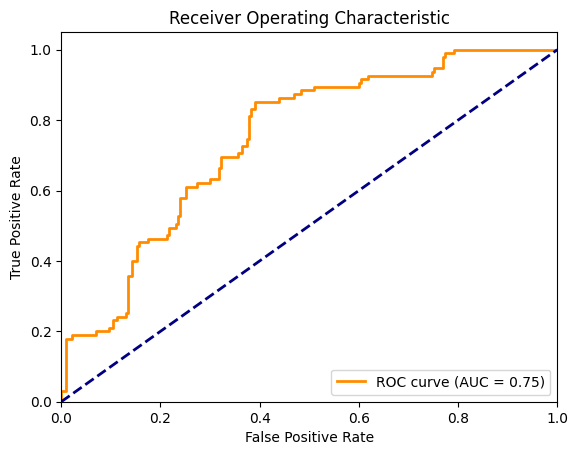

In [ ]:
# Calcular probabilidades de predicción
y_pred_proba = model.predict(X_test)

# Calcular curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Imprimir AUC
print(f"AUC: {roc_auc}")

# Graficar curva ROC
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Resultados de Prueba

*   Accuracy: **64.8%**
*   Precision: **39.1%**
*   Sensitivity: **63.3%**
*   Specificity: **65.3%**
*   F1 Score para "0": **0.73**
*   F1 Score para "1": **0.48**


###### 5. **Modelo CNN**

In [ ]:
# Definir el modelo
model = Sequential()
model.add(Input(shape=(200, 2)))  # Definir explícitamente el tamaño de entrada
model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val_waist_bar, y_val_waist_bar))

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.6960 - loss: 0.5818 - val_accuracy: 0.7119 - val_loss: 0.6073
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8020 - loss: 0.5014 - val_accuracy: 0.7186 - val_loss: 0.5585
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8047 - loss: 0.4688 - val_accuracy: 0.7220 - val_loss: 0.5158
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8115 - loss: 0.4395 - val_accuracy: 0.7322 - val_loss: 0.5038
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8112 - loss: 0.4195 - val_accuracy: 0.7525 - val_loss: 0.4766
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8156 - loss: 0.4056 - val_accuracy: 0.7797 - val_loss: 0.4604
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8183 - loss: 0.3914 - val_accuracy: 0.7966 - val_loss: 0.4443
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8433 - loss: 0.3762 - val_accuracy: 0.8034 - val_loss

In [ ]:
# Evaluar el modelo en el conjunto de validación
y_val_pred_waist_bar_cnn = model.predict(X_val_waist_bar).ravel()  # Genera predicciones
y_val_pred_waist_bar_cnn = (y_val_pred_waist_bar_cnn > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_bar, y_val_pred_waist_bar_cnn)
val_precision = precision_score(y_val_waist_bar, y_val_pred_waist_bar_cnn, average='binary')
val_recall = recall_score(y_val_waist_bar, y_val_pred_waist_bar_cnn, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_bar, y_val_pred_waist_bar_cnn).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_bar, y_val_pred_waist_bar_cnn)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_bar, y_val_pred_waist_bar_cnn).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_bar, y_val_pred_waist_bar_cnn))

# Guardar métricas de validación en un diccionario
res_val_waist_bar_cnn = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Validation Accuracy: 0.8101694915254237
Validation Precision: 0.7105263157894737
Validation Sensitivity: 0.6136363636363636
Validation Specificity: 0.893719806763285
Validation Balanced Accuracy: 0.7536780851998244

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87       207
           1       0.71      0.61      0.66        88

    accuracy                           0.81       295
   macro avg       0.78      0.75      0.76       295
weighted avg       0.80      0.81      0.81       295



In [ ]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred_waist_bar_cnn = model.predict(X_test).ravel()  # Genera predicciones
y_test_pred_waist_bar_cnn = (y_test_pred_waist_bar_cnn > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias

# Cálculo de métricas
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_waist_bar_cnn))
print("Test Precision:", precision_score(y_test, y_test_pred_waist_bar_cnn, average='binary'))
print("Test Sensitivity (Recall):", recall_score(y_test, y_test_pred_waist_bar_cnn, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_waist_bar_cnn).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_waist_bar_cnn))

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_waist_bar_cnn))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Test Accuracy: 0.8215384615384616
Test Precision: 0.7402597402597403
Test Sensitivity (Recall): 0.6
Test Specificity: 0.9130434782608695
Test Balanced Accuracy: 0.7565217391304347

Test Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88       230
           1       0.74      0.60      0.66        95

    accuracy                           0.82       325
   macro avg       0.79      0.76      0.77       325
weighted avg       0.82      0.82      0.82       325



Validación Cruzada K-Fold:

In [ ]:
# Definir el número de folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Inicializar listas para almacenar los resultados de cada fold
accuracy_per_fold = []
loss_per_fold = []
precision_per_fold = []
recall_per_fold = []
specificity_per_fold = []
f1_per_fold = []
balanced_accuracy_per_fold = []

# Iterar sobre cada fold
for train_index, val_index in kf.split(X_train):
    # Dividir los datos en entrenamiento y validación
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Definir el modelo (es importante definirlo dentro del loop para reiniciarlo en cada fold)
    model = Sequential()
    model.add(Input(shape=(200, 2)))  # Definir explícitamente el tamaño de entrada
    model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo en el fold actual
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)

    # Evaluar el modelo en el conjunto de validación del fold actual
    y_val_pred = model.predict(X_val_fold).ravel()
    y_val_pred = (y_val_pred > 0.5).astype(int)

    # Cálculo de métricas para el fold actual
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    loss = model.evaluate(X_val_fold, y_val_fold, verbose=0)[0]
    precision = precision_score(y_val_fold, y_val_pred)
    recall = recall_score(y_val_fold, y_val_pred)
    f1 = f1_score(y_val_fold, y_val_pred)
    cm = confusion_matrix(y_val_fold, y_val_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    balanced_accuracy = balanced_accuracy_score(y_val_fold, y_val_pred)

    # Almacenar las métricas para este fold
    accuracy_per_fold.append(accuracy)
    loss_per_fold.append(loss)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    specificity_per_fold.append(specificity)
    f1_per_fold.append(f1)
    balanced_accuracy_per_fold.append(balanced_accuracy)

# Mostrar resultados promedio de las métricas de k-fold
print(f'\nMean Accuracy (k-Fold): {np.mean(accuracy_per_fold)}')
print(f'Mean Loss (k-Fold): {np.mean(loss_per_fold)}')
print(f'Mean Precision (k-Fold): {np.mean(precision_per_fold)}')
print(f'Mean Recall (k-Fold): {np.mean(recall_per_fold)}')
print(f'Mean Specificity (k-Fold): {np.mean(specificity_per_fold)}')
print(f'Mean F1 Score (k-Fold): {np.mean(f1_per_fold)}')
print(f'Mean Balanced Accuracy (k-Fold): {np.mean(balanced_accuracy_per_fold)}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

Mean Accuracy (k-Fold): 0.8453804543815362
Mean Loss (k-Fold): 0.393357527256012
Mean Precision (k-Fold): 0.739893690738272
Mean Recall (k-Fold): 0.5217785707127274
Mean Specificity (k-Fold): 0.9452567386866149
Mean F1 Score (k-Fold): 0.6103363468403499
Mean Balanced Accuracy (k-Fold): 0.7335176546996711


**Mean Accuracy**:

**Mean Precision**:

**Mean Sensitivity**:

**Mean Specifity**:

**Mean F1 Score**:

###### 6. **Modelo SAE**

Padding y división de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_waist[feature_cols_bar].applymap(len).max().max()
print(f"Longitud máxima de secuencia: {max_length}")

Longitud máxima de secuencia: 200


<ipython-input-344-1cb5889e189a>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_waist[feature_cols_bar].applymap(len).max().max()


In [ ]:
# Crear un índice de validación a partir de la división de entrenamiento y validación
train_indices, val_indices = train_test_split(df_train_waist.index, test_size=0.2, random_state=42)

# Crear los conjuntos de secuencias de entrenamiento y validación
df_train_waist_train = df_train_waist.loc[train_indices]
df_train_waist_val = df_train_waist.loc[val_indices]

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols_bar, max_length):
    padded_features = []
    for col in feature_cols_bar:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)

            # No es necesario agregar dimensiones adicionales aquí, solo aseguramos que haya 2 columnas
            if sequence.shape[1] == 2:  # Confirma que las secuencias tienen solo 2 dimensiones (x, y)
                if len(sequence) < max_length:
                    # Realizar padding solo en la longitud de la secuencia
                    padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
                else:
                    padded_sequence = sequence[:max_length]
                padded_col.append(padded_sequence)
            else:
                print(f"Unexpected number of dimensions: {sequence.shape[1]}")
                raise ValueError(f"Las secuencias deben tener exactamente 2 dimensiones, pero se encontró {sequence.shape[1]}.")

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_waist_train, feature_cols_bar, max_length)
y_train = df_train_waist_train[target_col].values

# Aplicar padding al conjunto de validación
X_val_waist_bar = pad_sequences_feature(df_train_waist_val, feature_cols_bar, max_length)
y_val_waist_bar = df_train_waist_val[target_col].values

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalizar las características del conjunto de validación
X_val_waist_bar = scaler.transform(X_val_waist_bar.reshape(-1, X_val_waist_bar.shape[-1])).reshape(X_val_waist_bar.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test_waist, feature_cols_bar, max_length)
y_test = df_test_waist[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")

Forma de X_train: (1177, 200, 2)
Forma de X_test: (325, 200, 2)


*  **1472 / 1321** son el número de muestras para el conjunto de entrenamiento y prueba, respectivamente.
*  **200** es la longitud de la ventana de tiempo (en muestras) para cada señal.
*  **2** representa el número de características por cada paso temporal. Cada paso temporal tiene 2 características (por ejemplo, las variables x y y extraídas de los datos de Bar).

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Configurar la semilla para la reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
# Parámetros
input_shape = (200, 2)  # Ajusta esto a la forma de tu entrada
kernel_size = 7
filters = [32, 64]  # Número de filtros en cada capa convolucional

# Definir la función de autoencoder
def build_autoencoder(input_shape, filters, kernel_size):
    input_layer = Input(shape=input_shape)

    # Encoder
    x = Conv1D(filters=filters[0], kernel_size=kernel_size, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)

    # Bottleneck
    bottleneck_shape = x.shape[1:]  # Obtiene la forma después de las capas convolucionales y de pooling
    x = Flatten()(x)
    bottleneck = Dense(128, activation='relu')(x)  # Puedes ajustar la dimensión del bottleneck

    # Decoder
    x = Dense(np.prod(bottleneck_shape), activation='relu')(bottleneck)
    x = Reshape(bottleneck_shape)(x)  # Redimensiona a la forma adecuada para las capas convolucionales de decodificación
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=input_shape[1], kernel_size=kernel_size, activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_layer, x)
    encoder = Model(input_layer, bottleneck)

    return autoencoder, encoder

# Construir el autoencoder
autoencoder, encoder = build_autoencoder(input_shape, filters, kernel_size)

# Compilar el autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenar el autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2)

# Extraer las características usando el encoder
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val_waist_bar)
X_test_encoded = encoder.predict(X_test)

# Crear el clasificador denso
def build_classifier(input_shape):
    input_layer = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input_layer)
    x = Dense(32, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    classifier = Model(input_layer, output_layer)
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return classifier

# Construir el clasificador
classifier = build_classifier(X_train_encoded.shape[1:])

# Entrenar el clasificador
classifier.fit(X_train_encoded, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weights)

# Evaluar el clasificador
loss, accuracy = classifier.evaluate(X_test_encoded, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - loss: 1.0181 - val_loss: 0.6586
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6697 - val_loss: 0.5777
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5990 - val_loss: 0.5794
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5982 - val_loss: 0.5652
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5902 - val_loss: 0.5642
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5889 - val_loss: 0.5615
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5821 - val_loss: 0.5548
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5798 - val_loss: 0.5539
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5775 - val_loss: 0.5502
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5749 - val_loss: 0.5505
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Realizar predicciones
y_val_pred_waist_bar_sae = (classifier.predict(X_val_encoded) > 0.5).astype(int).ravel()

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_waist_bar, y_val_pred_waist_bar_sae)
val_precision = precision_score(y_val_waist_bar, y_val_pred_waist_bar_sae, average='binary')
val_recall = recall_score(y_val_waist_bar, y_val_pred_waist_bar_sae, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_waist_bar, y_val_pred_waist_bar_sae).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_waist_bar, y_val_pred_waist_bar_sae)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_waist_bar, y_val_pred_waist_bar_sae).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_waist_bar, y_val_pred_waist_bar_sae))

# Guardar métricas de validación en un diccionario
res_val_waist_bar_sae = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Validation Accuracy: 0.7050847457627119
Validation Precision: 0.5042735042735043
Validation Sensitivity: 0.6704545454545454
Validation Specificity: 0.7198067632850241
Validation Balanced Accuracy: 0.6951306543697848

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.72      0.77       207
           1       0.50      0.67      0.58        88

    accuracy                           0.71       295
   macro avg       0.67      0.70      0.67       295
weighted avg       0.74      0.71      0.71       295



In [ ]:
# Realizar predicciones
y_test_pred_waist_bar_sae = (classifier.predict(X_test_encoded) > 0.5).astype(int).ravel()

# Cálculo de métricas
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_waist_bar_sae))
print("Test Precision:", precision_score(y_test, y_test_pred_waist_bar_sae, average='binary'))
print("Test Sensitivity:", recall_score(y_test, y_test_pred_waist_bar_sae, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_waist_bar_sae).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_waist_bar_sae))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_waist_bar_sae))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Test Accuracy: 0.7107692307692308
Test Precision: 0.5038167938931297
Test Sensitivity: 0.6947368421052632
Test Specificity: 0.717391304347826
Test Balanced Accuracy: 0.7060640732265446

Test Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.72      0.78       230
           1       0.50      0.69      0.58        95

    accuracy                           0.71       325
   macro avg       0.68      0.71      0.68       325
weighted avg       0.75      0.71      0.72       325



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
AUC: 0.7962471395881007


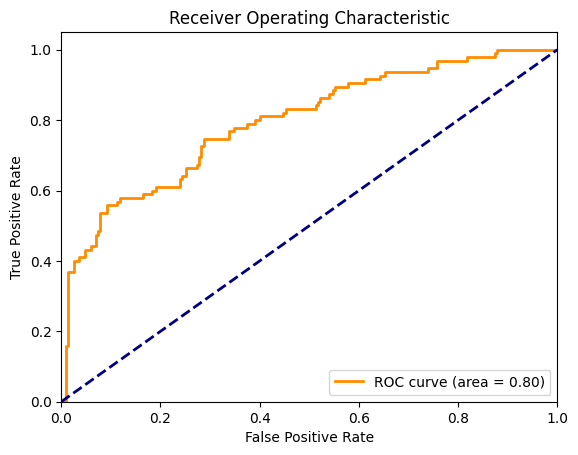

In [ ]:
# Realizar predicciones
y_pred_proba = classifier.predict(X_test_encoded)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Imprimir AUC
print(f"AUC: {roc_auc}")

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

AUC de 0.63

Resultados de Prueba

*   Accuracy: **59.4%**
*   Precision: **34.2%**
*   Sensitivity: **60.5%**
*   Specificity: **59.0%**
*   F1 Score para "0": **0.68**
*   F1 Score para "1": **0.44**

#### Dispositivo 3 (Muñeca)

##### Acelerómetro (Acc)

In [ ]:
# Función para extraer características de una serie temporal
def extract_features_from_series(series):
    series = np.asarray(series)  # Asegurarse de que sea un array de NumPy
    series = series.astype(float)  # Convertir a flotante para evitar overflow

    return {
        'mean': np.mean(series),
        'std': np.std(series),
        'var': np.var(series),
        'max': np.max(series),
        'min': np.min(series),
        'range': np.ptp(series),  # np.ptp es equivalente a np.max - np.min pero más seguro
        'kurtosis': pd.Series(series).kurtosis(),
        'skewness': pd.Series(series).skew()
    }

# Función para procesar cada fila de datos
def process_acc_row(acc_data):
    x_vals = np.array([point[0] for point in acc_data])
    y_vals = np.array([point[1] for point in acc_data])
    z_vals = np.array([point[2] for point in acc_data])

    # Asegurarse de que cada valor sea numérico y no una lista o array multidimensional
    x_features = extract_features_from_series(x_vals)
    y_features = extract_features_from_series(y_vals)
    z_features = extract_features_from_series(z_vals)

    # Combinar todas las características en un solo vector (diccionario)
    acc_features = {f'x_{key}': val for key, val in x_features.items()}
    acc_features.update({f'y_{key}': val for key, val in y_features.items()})
    acc_features.update({f'z_{key}': val for key, val in z_features.items()})

    return acc_features

# Separamos características y preparamos datos:
df_train_wrist_features = df_train_wrist[feature_cols_acc].apply(lambda row: process_acc_row(row['Acc']), axis=1)
df_train_wrist_features = pd.DataFrame(df_train_wrist_features.tolist())
X_train_wrist_acc = df_train_wrist_features
y_train_wrist_acc = df_train_wrist[target_col]

df_test_wrist_features = df_test_wrist[feature_cols_acc].apply(lambda row: process_acc_row(row['Acc']), axis=1)
df_test_wrist_features = pd.DataFrame(df_test_wrist_features.tolist())
X_test_wrist_acc = df_test_wrist_features
y_test_wrist_acc = df_test_wrist[target_col]

Normalizamos características:

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train_wrist_acc = scaler.fit_transform(X_train_wrist_acc)
X_test_wrist_acc = scaler.transform(X_test_wrist_acc)

In [ ]:
# Dividir el conjunto de datos en entrenamiento y validación
X_train_wrist_acc, X_val_wrist_acc, y_train_wrist_acc, y_val_wrist_acc = train_test_split(X_train_wrist_acc, y_train_wrist_acc, test_size=0.2, random_state=42)

###### 1. **Modelo k-NN**

Realizamos predicciones:

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_wrist_acc, y_train_wrist_acc)
y_pred = knn.predict(X_test_wrist_acc)

Evaluación del modelo:

In [ ]:
# Evaluación en el conjunto de validación
y_val_pred_wrist_acc_knn = knn.predict(X_val_wrist_acc)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_acc, y_val_pred_wrist_acc_knn)
val_precision = precision_score(y_val_wrist_acc, y_val_pred_wrist_acc_knn, average='binary')
val_recall = recall_score(y_val_wrist_acc, y_val_pred_wrist_acc_knn, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_acc, y_val_pred_wrist_acc_knn).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_acc, y_val_pred_wrist_acc_knn)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_acc, y_val_pred_wrist_acc_knn).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_acc, y_val_pred_wrist_acc_knn))

# Guardar métricas de validación en un diccionario
res_val_wrist_acc_knn = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.9362244897959183
Validation Precision: 0.8805970149253731
Validation Sensitivity: 0.7763157894736842
Validation Specificity: 0.9746835443037974
Validation Balanced Accuracy: 0.8754996668887408

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       316
           1       0.88      0.78      0.83        76

    accuracy                           0.94       392
   macro avg       0.91      0.88      0.89       392
weighted avg       0.93      0.94      0.93       392



In [ ]:
# Evaluación en el conjunto de prueba
y_test_pred_wrist_acc_knn = knn.predict(X_test_wrist_acc)

print("\nTest Accuracy:", accuracy_score(y_test_wrist_acc, y_test_pred_wrist_acc_knn))
print("Test Precision:", precision_score(y_test_wrist_acc, y_test_pred_wrist_acc_knn, average='binary'))
print("Test Sensitivity:", recall_score(y_test_wrist_acc, y_test_pred_wrist_acc_knn, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test_wrist_acc, y_test_pred_wrist_acc_knn).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_wrist_acc, y_test_pred_wrist_acc_knn))

print("\nTest Classification Report:\n", classification_report(y_test_wrist_acc, y_test_pred_wrist_acc_knn))


Test Accuracy: 0.9640933572710951
Test Precision: 0.9583333333333334
Test Sensitivity: 0.8518518518518519
Test Specificity: 0.9910913140311804
Test Balanced Accuracy: 0.9214715829415161

Test Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       449
           1       0.96      0.85      0.90       108

    accuracy                           0.96       557
   macro avg       0.96      0.92      0.94       557
weighted avg       0.96      0.96      0.96       557



Resultados de Validación

*   Accuracy: **93.6%**
*   Precision: **88.0%**
*   Sensitivity: **77.6%**
*   Specificity: **97.5%**
*   F1 Score para "0": **0.96**
*   F1 Score para "1": **0.83**

Estos resultados muestran...

Resultados de Prueba

*   Accuracy: **88.1%**
*   Precision: **91.2%**
*   Sensitivity: **60.1%**
*   Specificity: **97.9%**
*   F1 Score para "0": **0.92**
*   F1 Score para "1": **0.73**

En comparación con los resultados de validación...

###### 2. **Modelo SVM**

In [ ]:
# Crear el modelo SVM
svm_model = SVC(kernel='linear')  # Puedes probar otros kernels como 'rbf', 'poly', etc.

# Entrenar el modelo
svm_model.fit(X_train_wrist_acc, y_train_wrist_acc)

# Hacer predicciones en el conjunto de validación
y_val_pred_wrist_acc_svm = svm_model.predict(X_val_wrist_acc)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_acc, y_val_pred_wrist_acc_svm)
val_precision = precision_score(y_val_wrist_acc, y_val_pred_wrist_acc_svm, average='binary')
val_recall = recall_score(y_val_wrist_acc, y_val_pred_wrist_acc_svm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_acc, y_val_pred_wrist_acc_svm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_acc, y_val_pred_wrist_acc_svm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_acc, y_val_pred_wrist_acc_svm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_acc, y_val_pred_wrist_acc_svm))

# Guardar métricas de validación en un diccionario
res_val_wrist_acc_svm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.8877551020408163
Validation Precision: 0.7962962962962963
Validation Sensitivity: 0.5657894736842105
Validation Specificity: 0.9651898734177216
Validation Balanced Accuracy: 0.765489673550966

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       316
           1       0.80      0.57      0.66        76

    accuracy                           0.89       392
   macro avg       0.85      0.77      0.80       392
weighted avg       0.88      0.89      0.88       392



In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred_wrist_acc_svm = svm_model.predict(X_test_wrist_acc)

# Evaluar el modelo en el conjunto de prueba
print(f"\nTest Accuracy:", accuracy_score(y_test_wrist_acc, y_test_pred_wrist_acc_svm))
print(f"Test Precision:", precision_score(y_test_wrist_acc, y_test_pred_wrist_acc_svm))
print(f"Test Sensitivity:", recall_score(y_test_wrist_acc, y_test_pred_wrist_acc_svm))
tn, fp, fn, tp = confusion_matrix(y_test_wrist_acc, y_test_pred_wrist_acc_svm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_wrist_acc, y_test_pred_wrist_acc_svm))

print("\nTest Classification Report:", classification_report(y_test_wrist_acc, y_test_pred_wrist_acc_svm))


Test Accuracy: 0.926391382405745
Test Precision: 0.935064935064935
Test Sensitivity: 0.6666666666666666
Test Specificity: 0.9888641425389755
Test Balanced Accuracy: 0.8277654046028211

Test Classification Report:               precision    recall  f1-score   support

           0       0.93      0.99      0.96       449
           1       0.94      0.67      0.78       108

    accuracy                           0.93       557
   macro avg       0.93      0.83      0.87       557
weighted avg       0.93      0.93      0.92       557



Ajuste de Hiperparámetros con GridSearchCV:

In [ ]:
# Definir los hiperparámetros a probar
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']  # solo afecta a algunos kernels
}

# Crear el modelo SVM
svm_model = SVC()

# Implementar GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar el modelo con GridSearchCV
grid_search.fit(X_train_wrist_acc, y_train_wrist_acc)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Usar el mejor modelo encontrado
best_svm_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de validación
y_val_pred_wrist_acc_svm = best_svm_model.predict(X_val_wrist_acc)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_acc, y_val_pred_wrist_acc_svm)
val_precision = precision_score(y_val_wrist_acc, y_val_pred_wrist_acc_svm, average='binary')
val_recall = recall_score(y_val_wrist_acc, y_val_pred_wrist_acc_svm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_acc, y_val_pred_wrist_acc_svm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_acc, y_val_pred_wrist_acc_svm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_acc, y_val_pred_wrist_acc_svm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_acc, y_val_pred_wrist_acc_svm))

# Guardar métricas de validación en un diccionario
res_val_wrist_acc_svm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

Mejores hiperparámetros: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Validation Accuracy: 0.9362244897959183
Validation Precision: 0.8805970149253731
Validation Sensitivity: 0.7763157894736842
Validation Specificity: 0.9746835443037974
Validation Balanced Accuracy: 0.8754996668887408

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       316
           1       0.88      0.78      0.83        76

    accuracy                           0.94       392
   macro avg       0.91      0.88      0.89       392
weighted avg       0.93      0.94      0.93       392



Validación Cruzada

In [ ]:
# Realizar validación cruzada con los mejores parámetros
cv_scores = cross_val_score(best_svm_model, X_train_wrist_acc, y_train_wrist_acc, cv=5, scoring='accuracy')

print(f"Validation Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean()}")

Validation Cross-Validation Scores: [0.93290735 0.93610224 0.93610224 0.95846645 0.93290735]
Mean Cross-Validation Accuracy: 0.939297124600639


Evaluación del Modelo en el Conjunto de Prueba

In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred_wrist_acc_svm = best_svm_model.predict(X_test_wrist_acc)

# Evaluar el modelo en el conjunto de prueba
print(f"\nTest Accuracy:", accuracy_score(y_test_wrist_acc, y_test_pred_wrist_acc_svm))
print(f"Test Precision:", precision_score(y_test_wrist_acc, y_test_pred_wrist_acc_svm))
print(f"Test Sensitivity:", recall_score(y_test_wrist_acc, y_test_pred_wrist_acc_svm))
tn, fp, fn, tp = confusion_matrix(y_test_wrist_acc, y_test_pred_wrist_acc_svm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_wrist_acc, y_test_pred_wrist_acc_svm))

print("\nTest Classification Report:", classification_report(y_test_wrist_acc, y_test_pred_wrist_acc_svm))


Test Accuracy: 0.9551166965888689
Test Precision: 0.9560439560439561
Test Sensitivity: 0.8055555555555556
Test Specificity: 0.9910913140311804
Test Balanced Accuracy: 0.898323434793368

Test Classification Report:               precision    recall  f1-score   support

           0       0.95      0.99      0.97       449
           1       0.96      0.81      0.87       108

    accuracy                           0.96       557
   macro avg       0.96      0.90      0.92       557
weighted avg       0.96      0.96      0.95       557



Hemos confirmado que los resultados para el conjunto de test son peores si aplicamos SMOTE y LOSO. A su vez, hemos podido confirmar que nuestro modelo mejora luego buscar la combinación óptima de hiperparámetros que maximiza el rendimiento del modelo mediante GridSearchCV:

Mejores Hiperparámetros

*   C: **10**
*   Gamma: **scale**
*   Kernel: **rbf**

Resultados de Validación

*   Accuracy: **93.6%**
*   Precision: **88.0%**
*   Sensitivity: **77.6%**
*   Specificity: **97.5%**
*   F1 Score para "0": **0.96**
*   F1 Score para "1": **0.83**

Resultados de Prueba

*   Accuracy: **90.3%**
*   Precision: **92.2%**
*   Sensitivity: **68.6%**
*   Specificity: **97.9%**
*   F1 Score para "0": **0.94**
*   F1 Score para "1": **0.79**

###### 3. **Modelo Random Forest**

In [ ]:
# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')  # Puedes ajustar 'n_estimators' y otros hiperparámetros

# Entrenar el modelo con las características extraídas
rf_model.fit(X_train_wrist_acc, y_train_wrist_acc)

# Hacer predicciones en el conjunto de validación
y_val_pred_wrist_acc_rf = rf_model.predict(X_val_wrist_acc)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_acc, y_val_pred_wrist_acc_rf)
val_precision = precision_score(y_val_wrist_acc, y_val_pred_wrist_acc_rf, average='binary')
val_recall = recall_score(y_val_wrist_acc, y_val_pred_wrist_acc_rf, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_acc, y_val_pred_wrist_acc_rf).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_acc, y_val_pred_wrist_acc_rf)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_acc, y_val_pred_wrist_acc_rf).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_acc, y_val_pred_wrist_acc_rf))

# Guardar métricas de validación en un diccionario
res_val_wrist_acc_rf = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.9260204081632653
Validation Precision: 0.9272727272727272
Validation Sensitivity: 0.6710526315789473
Validation Specificity: 0.9873417721518988
Validation Balanced Accuracy: 0.829197201865423

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96       316
           1       0.93      0.67      0.78        76

    accuracy                           0.93       392
   macro avg       0.93      0.83      0.87       392
weighted avg       0.93      0.93      0.92       392



In [ ]:
# Realizar predicciones en el conjunto de prueba
y_test_pred_wrist_acc_rf = rf_model.predict(X_test_wrist_acc)

# Evaluar el rendimiento del modelo
print("\nTest Accuracy:", accuracy_score(y_test_wrist_acc, y_test_pred_wrist_acc_rf))
print("Test Precision:", precision_score(y_test_wrist_acc, y_test_pred_wrist_acc_rf, average='binary'))
print("Test Sensitivity (Recall):", recall_score(y_test_wrist_acc, y_test_pred_wrist_acc_rf, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test_wrist_acc, y_test_pred_wrist_acc_rf).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_wrist_acc, y_test_pred_wrist_acc_rf))

print("\nTest Classification Report:\n", classification_report(y_test_wrist_acc, y_test_pred_wrist_acc_rf))


Test Accuracy: 0.9497307001795332
Test Precision: 0.9651162790697675
Test Sensitivity (Recall): 0.7685185185185185
Test Specificity: 0.9933184855233853
Test Balanced Accuracy: 0.8809185020209519

Test Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       449
           1       0.97      0.77      0.86       108

    accuracy                           0.95       557
   macro avg       0.96      0.88      0.91       557
weighted avg       0.95      0.95      0.95       557



Resultados de Prueba

*   Accuracy: **87.4%**
*   Precision: **94.5%**
*   Sensitivity: **54.9%**
*   Specificity: **98.9%**
*   F1 Score para "0": **0.92**
*   F1 Score para "1": **0.69**

###### 4. **Modelo LSTM**

Padding y división de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_wrist[feature_cols_acc].applymap(len).max().max()
print(f"Longitud máxima de secuencia: {max_length}")

Longitud máxima de secuencia: 4760


<ipython-input-368-b5b952ec794b>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_wrist[feature_cols_acc].applymap(len).max().max()


In [ ]:
# Crear un índice de validación a partir de la división de entrenamiento y validación
train_indices, val_indices = train_test_split(df_train_wrist.index, test_size=0.2, random_state=42)

# Crear los conjuntos de secuencias de entrenamiento y validación
df_train_wrist_train = df_train_wrist.loc[train_indices]
df_train_wrist_val = df_train_wrist.loc[val_indices]

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols_acc, max_length):
    padded_features = []
    for col in feature_cols_acc:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)
            if sequence.shape[1] < 3:
                # Añadir columnas con ceros para igualar a 3 dimensiones
                sequence = np.pad(sequence, ((0, 0), (0, 3 - sequence.shape[1])), 'constant', constant_values=0)
            if len(sequence) < max_length:
                padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
            else:
                padded_sequence = sequence[:max_length]
            padded_col.append(padded_sequence)

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_wrist_train, feature_cols_acc, max_length)
y_train = df_train_wrist_train[target_col].values

# Aplicar padding al conjunto de validación
X_val_wrist_acc = pad_sequences_feature(df_train_wrist_val, feature_cols_acc, max_length)
y_val_wrist_acc = df_train_wrist_val[target_col].values

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalizar las características del conjunto de validación
X_val_wrist_acc = scaler.transform(X_val_wrist_acc.reshape(-1, X_val_wrist_acc.shape[-1])).reshape(X_val_wrist_acc.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test_wrist, feature_cols_acc, max_length)
y_test = df_test_wrist[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Configurar la semilla para la reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
print("Dimensiones de X_train:")
print(f"Forma: {X_train.shape}")
print(f"Número de muestras: {X_train.shape[0]}")
print(f"Longitud de secuencia (timesteps): {X_train.shape[1]}")
print(f"Número de características: {X_train.shape[2]}")

print("\nDimensiones de X_test:")
print(f"Forma: {X_test.shape}")
print(f"Número de muestras: {X_test.shape[0]}")
print(f"Longitud de secuencia (timesteps): {X_test.shape[1]}")
print(f"Número de características: {X_test.shape[2]}")

Dimensiones de X_train:
Forma: (1565, 4760, 3)
Número de muestras: 1565
Longitud de secuencia (timesteps): 4760
Número de características: 3

Dimensiones de X_test:
Forma: (557, 4760, 3)
Número de muestras: 557
Longitud de secuencia (timesteps): 4760
Número de características: 3


In [ ]:
# Verificar la forma de entrada esperada para el modelo
input_shape = (4760, 3)  # Esto debe coincidir con las dimensiones de tus datos

print(f"Forma de entrada esperada para el modelo: {input_shape}")

Forma de entrada esperada para el modelo: (4760, 3)


*  Menor Tiempo de Cómputo: RandomizedSearchCV es mucho más rápido que GridSearchCV para grandes espacios de hiperparámetros.
*  Exploración Eficiente: Aunque no prueba todas las combinaciones posibles, es probable que encuentre una buena combinación de hiperparámetros en menos tiempo.

In [ ]:
# Crear el modelo LSTM
model = Sequential()
model.add(Masking(mask_value=0., input_shape=input_shape))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con pesos de clase
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val_wrist_acc, y_val_wrist_acc), class_weight=class_weights)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 276ms/step - accuracy: 0.6146 - loss: 0.6827 - val_accuracy: 0.7500 - val_loss: 0.5780
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - accuracy: 0.6655 - loss: 0.6308 - val_accuracy: 0.7423 - val_loss: 0.5840
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 253ms/step - accuracy: 0.6684 - loss: 0.6141 - val_accuracy: 0.7398 - val_loss: 0.5778
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 267ms/step - accuracy: 0.6733 - loss: 0.6076 - val_accuracy: 0.7526 - val_loss: 0.5747
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 253ms/step - accuracy: 0.6884 - loss: 0.6092 - val_accuracy: 0.7474 - val_loss: 0.5608
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 273ms/step - accuracy: 0.6884 - loss: 0.6022 - val_accuracy: 0.7500 - val_loss: 0.5397
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 257ms/step - accuracy: 0.6831 - loss: 0.5965 - val_accuracy: 0.6862 - val_loss: 0.5893
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 274ms/step - accuracy: 0.6102 - loss: 0.6111 - val_accu

In [ ]:
# Realizar predicciones en el conjunto de validación
y_val_pred_wrist_acc_lstm = (model.predict(X_val_wrist_acc) > 0.5).astype("int32").ravel()

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_acc, y_val_pred_wrist_acc_lstm)
val_precision = precision_score(y_val_wrist_acc, y_val_pred_wrist_acc_lstm, average='binary')
val_recall = recall_score(y_val_wrist_acc, y_val_pred_wrist_acc_lstm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_acc, y_val_pred_wrist_acc_lstm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_acc, y_val_pred_wrist_acc_lstm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_acc, y_val_pred_wrist_acc_lstm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_acc, y_val_pred_wrist_acc_lstm))

# Guardar métricas de validación en un diccionario
res_val_wrist_acc_lstm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step

Validation Accuracy: 0.7142857142857143
Validation Precision: 0.3783783783783784
Validation Sensitivity: 0.7368421052631579
Validation Specificity: 0.7088607594936709
Validation Balanced Accuracy: 0.7228514323784143

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.71      0.80       316
           1       0.38      0.74      0.50        76

    accuracy                           0.71       392
   macro avg       0.65      0.72      0.65       392
weighted avg       0.81      0.71      0.74       392



In [ ]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Realizar predicciones en el conjunto de prueba
y_test_pred_wrist_acc_lstm = (model.predict(X_test) > 0.5).astype("int32").ravel()

print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_wrist_acc_lstm))
print("Test Precision:", precision_score(y_test, y_test_pred_wrist_acc_lstm, average='binary'))
print("Test Sensitivity:", recall_score(y_test, y_test_pred_wrist_acc_lstm, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_wrist_acc_lstm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_wrist_acc_lstm))

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_wrist_acc_lstm))

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.7216 - loss: 0.4725
Loss: 0.47624528408050537, Accuracy: 0.7055655121803284
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step

Test Accuracy: 0.7055655296229802
Test Precision: 0.3691588785046729
Test Sensitivity: 0.7314814814814815
Test Specificity: 0.6993318485523385
Test Balanced Accuracy: 0.71540666501691

Test Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.70      0.79       449
           1       0.37      0.73      0.49       108

    accuracy                           0.71       557
   macro avg       0.64      0.72      0.64       557
weighted avg       0.81      0.71      0.73       557



18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step
AUC: 0.781097913057824


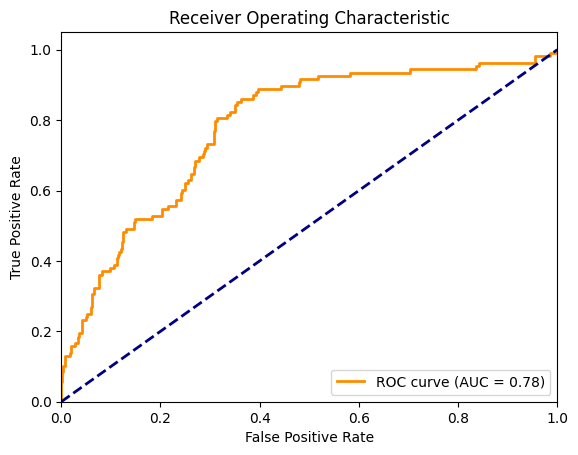

In [ ]:
# Calcular probabilidades de predicción
y_pred_proba = model.predict(X_test)

# Calcular curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Imprimir AUC
print(f"AUC: {roc_auc}")

# Graficar curva ROC
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Resultados de Prueba

*   Accuracy: **66.3%**
*   Precision: **41.9%**
*   Sensitivity: **76.7%**
*   Specificity: **62.6%**
*   F1 Score para "0": **0.73**
*   F1 Score para "1": **0.54**


###### 5. **Modelo CNN**

In [ ]:
# Definir el modelo
model = Sequential()
model.add(Input(shape=(4760, 3)))  # Definir explícitamente el tamaño de entrada
model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val_wrist_acc, y_val_wrist_acc))

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.7311 - loss: 3.0131 - val_accuracy: 0.8929 - val_loss: 0.2601
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9313 - loss: 0.1946 - val_accuracy: 0.9337 - val_loss: 0.1761
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9611 - loss: 0.1154 - val_accuracy: 0.9388 - val_loss: 0.1703
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9743 - loss: 0.0835 - val_accuracy: 0.9337 - val_loss: 0.2039
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9761 - loss: 0.0644 - val_accuracy: 0.9337 - val_loss: 0.1764
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9864 - loss: 0.0430 - val_accuracy: 0.9337 - val_loss: 0.2084
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9896 - loss: 0.0302 - val_accuracy: 0.9490 - val_loss: 0.1834
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9973 - loss: 0.0132 - val_accuracy: 0.9439 - v

In [ ]:
# Evaluar el modelo en el conjunto de validación
y_val_pred_wrist_acc_cnn = model.predict(X_val_wrist_acc).ravel()  # Genera predicciones
y_val_pred_wrist_acc_cnn = (y_val_pred_wrist_acc_cnn > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_acc, y_val_pred_wrist_acc_cnn)
val_precision = precision_score(y_val_wrist_acc, y_val_pred_wrist_acc_cnn, average='binary')
val_recall = recall_score(y_val_wrist_acc, y_val_pred_wrist_acc_cnn, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_acc, y_val_pred_wrist_acc_cnn).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_acc, y_val_pred_wrist_acc_cnn)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_acc, y_val_pred_wrist_acc_cnn).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_acc, y_val_pred_wrist_acc_cnn))

# Guardar métricas de validación en un diccionario
res_val_wrist_acc_cnn = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Validation Accuracy: 0.9336734693877551
Validation Precision: 0.8676470588235294
Validation Sensitivity: 0.7763157894736842
Validation Specificity: 0.9715189873417721
Validation Balanced Accuracy: 0.8739173884077281

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       316
           1       0.87      0.78      0.82        76

    accuracy                           0.93       392
   macro avg       0.91      0.87      0.89       392
weighted avg       0.93      0.93      0.93       392



In [ ]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred_wrist_acc_cnn = model.predict(X_test).ravel()  # Genera predicciones
y_test_pred_wrist_acc_cnn = (y_test_pred_wrist_acc_cnn > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias

# Cálculo de métricas
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_wrist_acc_cnn))
print("Test Precision:", precision_score(y_test, y_test_pred_wrist_acc_cnn, average='binary'))
print("Test Sensitivity (Recall):", recall_score(y_test, y_test_pred_wrist_acc_cnn, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_wrist_acc_cnn).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_wrist_acc_cnn))

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_wrist_acc_cnn))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Test Accuracy: 0.9712746858168761
Test Precision: 0.9509803921568627
Test Sensitivity (Recall): 0.8981481481481481
Test Specificity: 0.9888641425389755
Test Balanced Accuracy: 0.9435061453435618

Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       449
           1       0.95      0.90      0.92       108

    accuracy                           0.97       557
   macro avg       0.96      0.94      0.95       557
weighted avg       0.97      0.97      0.97       557



Validación Cruzada K-Fold:

In [ ]:
# Definir el número de folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Inicializar listas para almacenar los resultados de cada fold
accuracy_per_fold = []
loss_per_fold = []
precision_per_fold = []
recall_per_fold = []
specificity_per_fold = []
f1_per_fold = []
balanced_accuracy_per_fold = []

# Iterar sobre cada fold
for train_index, val_index in kf.split(X_train):
    # Dividir los datos en entrenamiento y validación
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Definir el modelo (es importante definirlo dentro del loop para reiniciarlo en cada fold)
    model = Sequential()
    model.add(Input(shape=(4760, 3)))  # Definir explícitamente el tamaño de entrada
    model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo en el fold actual
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)

    # Evaluar el modelo en el conjunto de validación del fold actual
    y_val_pred = model.predict(X_val_fold).ravel()
    y_val_pred = (y_val_pred > 0.5).astype(int)

    # Cálculo de métricas para el fold actual
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    loss = model.evaluate(X_val_fold, y_val_fold, verbose=0)[0]
    precision = precision_score(y_val_fold, y_val_pred)
    recall = recall_score(y_val_fold, y_val_pred)
    f1 = f1_score(y_val_fold, y_val_pred)
    cm = confusion_matrix(y_val_fold, y_val_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    balanced_accuracy = balanced_accuracy_score(y_val_fold, y_val_pred)

    # Almacenar las métricas para este fold
    accuracy_per_fold.append(accuracy)
    loss_per_fold.append(loss)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    specificity_per_fold.append(specificity)
    f1_per_fold.append(f1)
    balanced_accuracy_per_fold.append(balanced_accuracy)

# Mostrar resultados promedio de las métricas de k-fold
print(f'\nMean Accuracy (k-Fold): {np.mean(accuracy_per_fold)}')
print(f'Mean Loss (k-Fold): {np.mean(loss_per_fold)}')
print(f'Mean Precision (k-Fold): {np.mean(precision_per_fold)}')
print(f'Mean Recall (k-Fold): {np.mean(recall_per_fold)}')
print(f'Mean Specificity (k-Fold): {np.mean(specificity_per_fold)}')
print(f'Mean F1 Score (k-Fold): {np.mean(f1_per_fold)}')
print(f'Mean Balanced Accuracy (k-Fold): {np.mean(balanced_accuracy_per_fold)}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Mean Accuracy (k-Fold): 0.9271565495207668
Mean Loss (k-Fold): 0.2916642814874649
Mean Precision (k-Fold): 0.8752085214606188
Mean Recall (k-Fold): 0.7868586954449397
Mean Specificity (k-Fold): 0.9656821827174283
Mean F1 Score (k-Fold): 0.8203156031400367
Mean Balanced Accuracy (k-Fold): 0.8762704390811841


**Mean Accuracy**:

**Mean Precision**:

**Mean Sensitivity**:

**Mean Specifity**:

**Mean F1 Score**:

###### 6. **Modelo SAE**

Padding y división de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_wrist[feature_cols_acc].applymap(len).max().max()
print(f"Longitud máxima de secuencia: {max_length}")

Longitud máxima de secuencia: 4760


<ipython-input-384-b5b952ec794b>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_wrist[feature_cols_acc].applymap(len).max().max()


In [ ]:
# Crear un índice de validación a partir de la división de entrenamiento y validación
train_indices, val_indices = train_test_split(df_train_wrist.index, test_size=0.2, random_state=42)

# Crear los conjuntos de secuencias de entrenamiento y validación
df_train_wrist_train = df_train_wrist.loc[train_indices]
df_train_wrist_val = df_train_wrist.loc[val_indices]

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols_acc, max_length):
    padded_features = []
    for col in feature_cols_acc:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)
            if sequence.shape[1] < 3:
                # Añadir columnas con ceros para igualar a 3 dimensiones
                sequence = np.pad(sequence, ((0, 0), (0, 3 - sequence.shape[1])), 'constant', constant_values=0)
            if len(sequence) < max_length:
                padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
            else:
                padded_sequence = sequence[:max_length]
            padded_col.append(padded_sequence)

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_wrist_train, feature_cols_acc, max_length)
y_train = df_train_wrist_train[target_col].values

# Aplicar padding al conjunto de validación
X_val_wrist_acc = pad_sequences_feature(df_train_wrist_val, feature_cols_acc, max_length)
y_val_wrist_acc = df_train_wrist_val[target_col].values

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalizar las características del conjunto de validación
X_val_wrist_acc = scaler.transform(X_val_wrist_acc.reshape(-1, X_val_wrist_acc.shape[-1])).reshape(X_val_wrist_acc.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test_wrist, feature_cols_acc, max_length)
y_test = df_test_wrist[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")

Forma de X_train: (1565, 4760, 3)
Forma de X_test: (557, 4760, 3)


*  **1957 / 1321** son el número de muestras para el conjunto de entrenamiento y prueba, respectivamente.
*  **4760** es la longitud de la ventana de tiempo (en muestras) para cada señal.
*  **3** representa los tres canales de aceleración (ax, ay, az).

In [ ]:
# Ver los primeros 5 valores de cada canal en la primera muestra
print("Primeros 5 valores del primer canal (ax) de la primera muestra de X_train:")
print(X_train[0, :5, 0])  # Canal ax

print("Primeros 5 valores del segundo canal (ay) de la primera muestra de X_train:")
print(X_train[0, :5, 1])  # Canal ay

print("Primeros 5 valores del tercer canal (az) de la primera muestra de X_train:")
print(X_train[0, :5, 2])  # Canal az

Primeros 5 valores del primer canal (ax) de la primera muestra de X_train:
[0.68880928 0.70223237 0.71450491 0.72485986 0.73444778]
Primeros 5 valores del segundo canal (ay) de la primera muestra de X_train:
[-0.6560939  -0.6609904  -0.66629494 -0.6707834  -0.67200752]
Primeros 5 valores del tercer canal (az) de la primera muestra de X_train:
[0.22033462 0.21125713 0.20399514 0.18644534 0.17373685]


In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Configurar la semilla para la reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
# Parámetros
input_shape = (4760, 3)  # Ajusta esto a la forma de tu entrada
kernel_size = 7
filters = [32, 64]  # Número de filtros en cada capa convolucional

# Definir la función de autoencoder
def build_autoencoder(input_shape, filters, kernel_size):
    input_layer = Input(shape=input_shape)

    # Encoder
    x = Conv1D(filters=filters[0], kernel_size=kernel_size, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)

    # Bottleneck
    bottleneck_shape = x.shape[1:]  # Obtiene la forma después de las capas convolucionales y de pooling
    x = Flatten()(x)
    bottleneck = Dense(128, activation='relu')(x)  # Puedes ajustar la dimensión del bottleneck

    # Decoder
    x = Dense(np.prod(bottleneck_shape), activation='relu')(bottleneck)
    x = Reshape(bottleneck_shape)(x)  # Redimensiona a la forma adecuada para las capas convolucionales de decodificación
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=input_shape[1], kernel_size=kernel_size, activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_layer, x)
    encoder = Model(input_layer, bottleneck)

    return autoencoder, encoder

# Construir el autoencoder
autoencoder, encoder = build_autoencoder(input_shape, filters, kernel_size)

# Compilar el autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenar el autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2)

# Extraer las características usando el encoder
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val_wrist_acc)
X_test_encoded = encoder.predict(X_test)

# Crear el clasificador denso
def build_classifier(input_shape):
    input_layer = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input_layer)
    x = Dense(32, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    classifier = Model(input_layer, output_layer)
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return classifier

# Construir el clasificador
classifier = build_classifier(X_train_encoded.shape[1:])

# Entrenar el clasificador
classifier.fit(X_train_encoded, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weights)

# Evaluar el clasificador
loss, accuracy = classifier.evaluate(X_test_encoded, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - loss: 1.0344 - val_loss: 0.9080
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.8666 - val_loss: 0.8493
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.8114 - val_loss: 0.8097
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.7661 - val_loss: 0.7757
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.7436 - val_loss: 0.7639
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.7314 - val_loss: 0.7555
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.7259 - val_loss: 0.7554
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.7229 - val_loss: 0.7550
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.7198 - val_loss: 0.7534
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.7173 - val_loss: 0.7529
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 1/10
40/40 ━━━━━━━━━━━

In [ ]:
# Realizar predicciones
y_val_pred_wrist_acc_sae = (classifier.predict(X_val_encoded) > 0.5).astype(int).ravel()

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_acc, y_val_pred_wrist_acc_sae)
val_precision = precision_score(y_val_wrist_acc, y_val_pred_wrist_acc_sae, average='binary')
val_recall = recall_score(y_val_wrist_acc, y_val_pred_wrist_acc_sae, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_acc, y_val_pred_wrist_acc_sae).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_acc, y_val_pred_wrist_acc_sae)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_acc, y_val_pred_wrist_acc_sae).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_acc, y_val_pred_wrist_acc_sae))

# Guardar métricas de validación en un diccionario
res_val_wrist_acc_sae = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Validation Accuracy: 0.8571428571428571
Validation Precision: 0.6219512195121951
Validation Sensitivity: 0.6710526315789473
Validation Specificity: 0.9018987341772152
Validation Balanced Accuracy: 0.7864756828780812

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       316
           1       0.62      0.67      0.65        76

    accuracy                           0.86       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.86      0.86      0.86       392



In [ ]:
# Realizar predicciones
y_test_pred_wrist_acc_sae = (classifier.predict(X_test_encoded) > 0.5).astype(int).ravel()

# Cálculo de métricas
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_wrist_acc_sae))
print("Test Precision:", precision_score(y_test, y_test_pred_wrist_acc_sae, average='binary'))
print("Test Sensitivity:", recall_score(y_test, y_test_pred_wrist_acc_sae, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_wrist_acc_sae).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_wrist_acc_sae))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_wrist_acc_sae))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Test Accuracy: 0.8617594254937163
Test Precision: 0.6165413533834586
Test Sensitivity: 0.7592592592592593
Test Specificity: 0.8864142538975501
Test Balanced Accuracy: 0.8228367565784047

Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.91       449
           1       0.62      0.76      0.68       108

    accuracy                           0.86       557
   macro avg       0.78      0.82      0.80       557
weighted avg       0.88      0.86      0.87       557



18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
AUC: 0.921987131898045


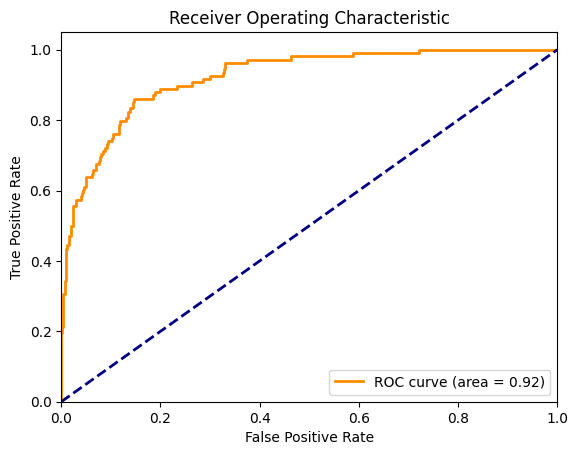

In [ ]:
# Realizar predicciones
y_pred_proba = classifier.predict(X_test_encoded)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Imprimir AUC
print(f"AUC: {roc_auc}")

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

AUC de 0.834 sugiere que el modelo tiene una excelente capacidad para distinguir entre las clases positivas y negativas.

Resultados de Prueba

*   Accuracy: **83.8%**
*   Precision: **65.4%**
*   Sensitivity: **80.2%**
*   Specificity: **85.0%**
*   F1 Score para "0": **0.89**
*   F1 Score para "1": **0.72**

##### Giroscopio (Gyr)

In [ ]:
# Función para extraer características de una serie temporal
def extract_features_from_series(series):
    series = np.asarray(series)  # Asegurarse de que sea un array de NumPy
    series = series.astype(float)  # Convertir a flotante para evitar overflow

    return {
        'mean': np.mean(series),
        'std': np.std(series),
        'var': np.var(series),
        'max': np.max(series),
        'min': np.min(series),
        'range': np.ptp(series),  # np.ptp es equivalente a np.max - np.min pero más seguro
        'kurtosis': pd.Series(series).kurtosis(),
        'skewness': pd.Series(series).skew()
    }

# Función para procesar cada fila de datos
def process_gyr_row(gyr_data):
    x_vals = np.array([point[0] for point in gyr_data])
    y_vals = np.array([point[1] for point in gyr_data])
    z_vals = np.array([point[2] for point in gyr_data])

    # Asegurarse de que cada valor sea numérico y no una lista o array multidimensional
    x_features = extract_features_from_series(x_vals)
    y_features = extract_features_from_series(y_vals)
    z_features = extract_features_from_series(z_vals)

    # Combinar todas las características en un solo vector (diccionario)
    gyr_features = {f'x_{key}': val for key, val in x_features.items()}
    gyr_features.update({f'y_{key}': val for key, val in y_features.items()})
    gyr_features.update({f'z_{key}': val for key, val in z_features.items()})

    return gyr_features

# Separamos características y preparamos datos:
df_train_wrist_features = df_train_wrist[feature_cols_gyr].apply(lambda row: process_gyr_row(row['Gyr']), axis=1)
df_train_wrist_features = pd.DataFrame(df_train_wrist_features.tolist())
X_train_wrist_gyr = df_train_wrist_features
y_train_wrist_gyr = df_train_wrist[target_col]

df_test_wrist_features = df_test_wrist[feature_cols_gyr].apply(lambda row: process_gyr_row(row['Gyr']), axis=1)
df_test_wrist_features = pd.DataFrame(df_test_wrist_features.tolist())
X_test_wrist_gyr = df_test_wrist_features
y_test_wrist_gyr = df_test_wrist[target_col]

Normalizamos características:

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train_wrist_gyr = scaler.fit_transform(X_train_wrist_gyr)
X_test_wrist_gyr = scaler.transform(X_test_wrist_gyr)

In [ ]:
# Dividir el conjunto de datos en entrenamiento y validación
X_train_wrist_gyr, X_val_wrist_gyr, y_train_wrist_gyr, y_val_wrist_gyr = train_test_split(X_train_wrist_gyr, y_train_wrist_gyr, test_size=0.2, random_state=42)

###### 1. **Modelo k-NN**

Realizamos predicciones:

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_wrist_gyr, y_train_wrist_gyr)
y_pred = knn.predict(X_test_wrist_gyr)

Evaluación del modelo:

In [ ]:
# Evaluación en el conjunto de validación
y_val_pred_wrist_gyr_knn = knn.predict(X_val_wrist_gyr)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_knn)
val_precision = precision_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_knn, average='binary')
val_recall = recall_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_knn, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_gyr, y_val_pred_wrist_gyr_knn).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_knn)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_gyr, y_val_pred_wrist_gyr_knn).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_gyr, y_val_pred_wrist_gyr_knn))

# Guardar métricas de validación en un diccionario
res_val_wrist_gyr_knn = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.8954081632653061
Validation Precision: 0.8888888888888888
Validation Sensitivity: 0.5263157894736842
Validation Specificity: 0.9841772151898734
Validation Balanced Accuracy: 0.7552465023317788

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       316
           1       0.89      0.53      0.66        76

    accuracy                           0.90       392
   macro avg       0.89      0.76      0.80       392
weighted avg       0.89      0.90      0.88       392



In [ ]:
# Evaluación en el conjunto de prueba
y_test_pred_wrist_gyr_knn = knn.predict(X_test_wrist_gyr)

print("\nTest Accuracy:", accuracy_score(y_test_wrist_gyr, y_test_pred_wrist_gyr_knn))
print("Test Precision:", precision_score(y_test_wrist_gyr, y_test_pred_wrist_gyr_knn, average='binary'))
print("Test Sensitivity:", recall_score(y_test_wrist_gyr, y_test_pred_wrist_gyr_knn, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test_wrist_gyr, y_test_pred_wrist_gyr_knn).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_wrist_gyr, y_test_pred_wrist_gyr_knn))

print("\nTest Classification Report:\n", classification_report(y_test_wrist_gyr, y_test_pred_wrist_gyr_knn))


Test Accuracy: 0.9192100538599641
Test Precision: 0.9090909090909091
Test Sensitivity: 0.6481481481481481
Test Specificity: 0.9844097995545658
Test Balanced Accuracy: 0.816278973851357

Test Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       449
           1       0.91      0.65      0.76       108

    accuracy                           0.92       557
   macro avg       0.91      0.82      0.85       557
weighted avg       0.92      0.92      0.91       557



Resultados de Validación

*   Accuracy: **89.5%**
*   Precision: **88.9%**
*   Sensitivity: **52.6%**
*   Specificity: **98.4%**
*   F1 Score para "0": **0.94**
*   F1 Score para "1": **0.66**

Estos resultados muestran ...

Resultados de Prueba

*   Accuracy: **84.0%**
*   Precision: **81.8%**
*   Sensitivity: **49.7%**
*   Specificity: **96.1%**
*   F1 Score para "0": **0.90**
*   F1 Score para "1": **0.62**

En comparación con los resultados de validación, los resultados del conjunto de prueba muestran ...

###### 2. **Modelo SVM**

In [ ]:
# Crear el modelo SVM
svm_model = SVC(kernel='linear')  # Puedes probar otros kernels como 'rbf', 'poly', etc.

# Entrenar el modelo
svm_model.fit(X_train_wrist_gyr, y_train_wrist_gyr)

# Hacer predicciones en el conjunto de validación
y_val_pred_wrist_gyr_svm = svm_model.predict(X_val_wrist_gyr)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_svm)
val_precision = precision_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_svm, average='binary')
val_recall = recall_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_svm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_gyr, y_val_pred_wrist_gyr_svm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_svm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_gyr, y_val_pred_wrist_gyr_svm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_gyr, y_val_pred_wrist_gyr_svm))

# Guardar métricas de validación en un diccionario
res_val_wrist_gyr_svm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.8469387755102041
Validation Precision: 0.6481481481481481
Validation Sensitivity: 0.4605263157894737
Validation Specificity: 0.939873417721519
Validation Balanced Accuracy: 0.7001998667554963

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91       316
           1       0.65      0.46      0.54        76

    accuracy                           0.85       392
   macro avg       0.76      0.70      0.72       392
weighted avg       0.83      0.85      0.84       392



In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred_wrist_gyr_svm = svm_model.predict(X_test_wrist_gyr)

# Evaluar el modelo en el conjunto de prueba
print(f"\nTest Accuracy:", accuracy_score(y_test_wrist_gyr, y_test_pred_wrist_gyr_svm))
print(f"Test Precision:", precision_score(y_test_wrist_gyr, y_test_pred_wrist_gyr_svm))
print(f"Test Sensitivity:", recall_score(y_test_wrist_gyr, y_test_pred_wrist_gyr_svm))
tn, fp, fn, tp = confusion_matrix(y_test_wrist_gyr, y_test_pred_wrist_gyr_svm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_wrist_gyr, y_test_pred_wrist_gyr_svm))

print("\nTest Classification Report:", classification_report(y_test_wrist_gyr, y_test_pred_wrist_gyr_svm))


Test Accuracy: 0.8850987432675045
Test Precision: 0.8055555555555556
Test Sensitivity: 0.5370370370370371
Test Specificity: 0.9688195991091314
Test Balanced Accuracy: 0.7529283180730842

Test Classification Report:               precision    recall  f1-score   support

           0       0.90      0.97      0.93       449
           1       0.81      0.54      0.64       108

    accuracy                           0.89       557
   macro avg       0.85      0.75      0.79       557
weighted avg       0.88      0.89      0.88       557



Ajuste de Hiperparámetros con GridSearchCV:

In [ ]:
# Definir los hiperparámetros a probar
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']  # solo afecta a algunos kernels
}

# Crear el modelo SVM
svm_model = SVC()

# Implementar GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar el modelo con GridSearchCV
grid_search.fit(X_train_wrist_gyr, y_train_wrist_gyr)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Usar el mejor modelo encontrado
best_svm_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de validación
y_val_pred_wrist_gyr_svm = best_svm_model.predict(X_val_wrist_gyr)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_svm)
val_precision = precision_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_svm, average='binary')
val_recall = recall_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_svm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_gyr, y_val_pred_wrist_gyr_svm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_svm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_gyr, y_val_pred_wrist_gyr_svm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_gyr, y_val_pred_wrist_gyr_svm))

# Guardar métricas de validación en un diccionario
res_val_wrist_gyr_svm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

Mejores hiperparámetros: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

Validation Accuracy: 0.9209183673469388
Validation Precision: 0.8688524590163934
Validation Sensitivity: 0.6973684210526315
Validation Specificity: 0.9746835443037974
Validation Balanced Accuracy: 0.8360259826782145

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       316
           1       0.87      0.70      0.77        76

    accuracy                           0.92       392
   macro avg       0.90      0.84      0.86       392
weighted avg       0.92      0.92      0.92       392



Validación Cruzada

In [ ]:
# Realizar validación cruzada con los mejores parámetros
cv_scores = cross_val_score(best_svm_model, X_train_wrist_gyr, y_train_wrist_gyr, cv=5, scoring='accuracy')

print(f"Validation Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean()}")

Validation Cross-Validation Scores: [0.86261981 0.90734824 0.89456869 0.89456869 0.91373802]
Mean Cross-Validation Accuracy: 0.8945686900958467


Evaluación del Modelo en el Conjunto de Prueba

In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred_wrist_gyr_svm = best_svm_model.predict(X_test_wrist_gyr)

# Evaluar el modelo en el conjunto de prueba
print(f"\nTest Accuracy:", accuracy_score(y_test_wrist_gyr, y_test_pred_wrist_gyr_svm))
print(f"Test Precision:", precision_score(y_test_wrist_gyr, y_test_pred_wrist_gyr_svm))
print(f"Test Sensitivity:", recall_score(y_test_wrist_gyr, y_test_pred_wrist_gyr_svm))
tn, fp, fn, tp = confusion_matrix(y_test_wrist_gyr, y_test_pred_wrist_gyr_svm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_wrist_gyr, y_test_pred_wrist_gyr_svm))

print("\nTest Classification Report:", classification_report(y_test_wrist_gyr, y_test_pred_wrist_gyr_svm))


Test Accuracy: 0.933572710951526
Test Precision: 0.865979381443299
Test Sensitivity: 0.7777777777777778
Test Specificity: 0.9710467706013363
Test Balanced Accuracy: 0.874412274189557

Test Classification Report:               precision    recall  f1-score   support

           0       0.95      0.97      0.96       449
           1       0.87      0.78      0.82       108

    accuracy                           0.93       557
   macro avg       0.91      0.87      0.89       557
weighted avg       0.93      0.93      0.93       557



Sí mejora con GridSearchCV:

Resultados de Prueba

*   Accuracy: **83.8%**
*   Precision: **71.9%**
*   Sensitivity: **62.0%**
*   Specificity: **91.5%**
*   F1 Score para "0": **0.89**
*   F1 Score para "1": **0.67**

###### 3. **Modelo Random Forest**

In [ ]:
# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')  # Puedes ajustar 'n_estimators' y otros hiperparámetros

# Entrenar el modelo con las características extraídas
rf_model.fit(X_train_wrist_gyr, y_train_wrist_gyr)

# Hacer predicciones en el conjunto de validación
y_val_pred_wrist_gyr_rf = rf_model.predict(X_val_wrist_gyr)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_rf)
val_precision = precision_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_rf, average='binary')
val_recall = recall_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_rf, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_gyr, y_val_pred_wrist_gyr_rf).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_rf)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_gyr, y_val_pred_wrist_gyr_rf).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_gyr, y_val_pred_wrist_gyr_rf))

# Guardar métricas de validación en un diccionario
res_val_wrist_gyr_rf = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.8877551020408163
Validation Precision: 0.82
Validation Sensitivity: 0.5394736842105263
Validation Specificity: 0.9715189873417721
Validation Balanced Accuracy: 0.7554963357761493

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       316
           1       0.82      0.54      0.65        76

    accuracy                           0.89       392
   macro avg       0.86      0.76      0.79       392
weighted avg       0.88      0.89      0.88       392



In [ ]:
# Realizar predicciones en el conjunto de prueba
y_test_pred_wrist_gyr_rf = rf_model.predict(X_test_wrist_gyr)

# Evaluar el rendimiento del modelo
print("\nTest Accuracy:", accuracy_score(y_test_wrist_gyr, y_test_pred_wrist_gyr_rf))
print("Test Precision:", precision_score(y_test_wrist_gyr, y_test_pred_wrist_gyr_rf, average='binary'))
print("Test Sensitivity (Recall):", recall_score(y_test_wrist_gyr, y_test_pred_wrist_gyr_rf, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test_wrist_gyr, y_test_pred_wrist_gyr_rf).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_wrist_gyr, y_test_pred_wrist_gyr_rf))

print("\nTest Classification Report:\n", classification_report(y_test_wrist_gyr, y_test_pred_wrist_gyr_rf))


Test Accuracy: 0.9174147217235189
Test Precision: 0.8780487804878049
Test Sensitivity (Recall): 0.6666666666666666
Test Specificity: 0.977728285077951
Test Balanced Accuracy: 0.8221974758723087

Test Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       449
           1       0.88      0.67      0.76       108

    accuracy                           0.92       557
   macro avg       0.90      0.82      0.85       557
weighted avg       0.92      0.92      0.91       557



Resultados de Prueba

*   Accuracy: **83.4%**
*   Precision: **85.3%**
*   Sensitivity: **43.9%**
*   Specificity: **97.3%**
*   F1 Score para "0": **0.90**
*   F1 Score para "1": **0.58**

###### 4. **Modelo LSTM**

Padding y división de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_wrist[feature_cols_gyr].applymap(len).max().max()
print(f"Longitud máxima de secuencia: {max_length}")

Longitud máxima de secuencia: 4760


<ipython-input-409-b05ccceda93c>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_wrist[feature_cols_gyr].applymap(len).max().max()


In [ ]:
# Crear un índice de validación a partir de la división de entrenamiento y validación
train_indices, val_indices = train_test_split(df_train_wrist.index, test_size=0.2, random_state=42)

# Crear los conjuntos de secuencias de entrenamiento y validación
df_train_wrist_train = df_train_wrist.loc[train_indices]
df_train_wrist_val = df_train_wrist.loc[val_indices]

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols_gyr, max_length):
    padded_features = []
    for col in feature_cols_gyr:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)
            if sequence.shape[1] < 3:
                # Añadir columnas con ceros para igualar a 3 dimensiones
                sequence = np.pad(sequence, ((0, 0), (0, 3 - sequence.shape[1])), 'constant', constant_values=0)
            if len(sequence) < max_length:
                padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
            else:
                padded_sequence = sequence[:max_length]
            padded_col.append(padded_sequence)

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_wrist_train, feature_cols_gyr, max_length)
y_train = df_train_wrist_train[target_col].values

# Aplicar padding al conjunto de validación
X_val_wrist_gyr = pad_sequences_feature(df_train_wrist_val, feature_cols_gyr, max_length)
y_val_wrist_gyr = df_train_wrist_val[target_col].values

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalizar las características del conjunto de validación
X_val_wrist_gyr = scaler.transform(X_val_wrist_gyr.reshape(-1, X_val_wrist_gyr.shape[-1])).reshape(X_val_wrist_gyr.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test_wrist, feature_cols_gyr, max_length)
y_test = df_test_wrist[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Configurar la semilla para la reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
print("Dimensiones de X_train:")
print(f"Forma: {X_train.shape}")
print(f"Número de muestras: {X_train.shape[0]}")
print(f"Longitud de secuencia (timesteps): {X_train.shape[1]}")
print(f"Número de características: {X_train.shape[2]}")

print("\nDimensiones de X_test:")
print(f"Forma: {X_test.shape}")
print(f"Número de muestras: {X_test.shape[0]}")
print(f"Longitud de secuencia (timesteps): {X_test.shape[1]}")
print(f"Número de características: {X_test.shape[2]}")

Dimensiones de X_train:
Forma: (1565, 4760, 3)
Número de muestras: 1565
Longitud de secuencia (timesteps): 4760
Número de características: 3

Dimensiones de X_test:
Forma: (557, 4760, 3)
Número de muestras: 557
Longitud de secuencia (timesteps): 4760
Número de características: 3


In [ ]:
# Verificar la forma de entrada esperada para el modelo
input_shape = (4760, 3)  # Esto debe coincidir con las dimensiones de tus datos

print(f"Forma de entrada esperada para el modelo: {input_shape}")

Forma de entrada esperada para el modelo: (4760, 3)


*  Menor Tiempo de Cómputo: RandomizedSearchCV es mucho más rápido que GridSearchCV para grandes espacios de hiperparámetros.
*  Exploración Eficiente: Aunque no prueba todas las combinaciones posibles, es probable que encuentre una buena combinación de hiperparámetros en menos tiempo.

In [ ]:
# Crear el modelo LSTM
model = Sequential()
model.add(Masking(mask_value=0., input_shape=input_shape))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con pesos de clase
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val_wrist_gyr, y_val_wrist_gyr), class_weight=class_weights)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 287ms/step - accuracy: 0.4105 - loss: 0.6995 - val_accuracy: 0.3724 - val_loss: 0.6860
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 252ms/step - accuracy: 0.4124 - loss: 0.6892 - val_accuracy: 0.3597 - val_loss: 0.6909
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 265ms/step - accuracy: 0.4106 - loss: 0.6827 - val_accuracy: 0.3699 - val_loss: 0.6885
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 250ms/step - accuracy: 0.4119 - loss: 0.6773 - val_accuracy: 0.3648 - val_loss: 0.6937
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 269ms/step - accuracy: 0.4092 - loss: 0.6722 - val_accuracy: 0.3036 - val_loss: 0.7323
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 272ms/step - accuracy: 0.3796 - loss: 0.6769 - val_accuracy: 0.4031 - val_loss: 0.6994
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 252ms/step - accuracy: 0.5037 - loss: 0.6587 - val_accuracy: 0.6378 - val_loss: 0.6804
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 266ms/step - accuracy: 0.4637 - loss: 0.6625 - val_accu

In [ ]:
# Realizar predicciones en el conjunto de validación
y_val_pred_wrist_gyr_lstm = (model.predict(X_val_wrist_gyr) > 0.5).astype("int32").ravel()

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_lstm)
val_precision = precision_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_lstm, average='binary')
val_recall = recall_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_lstm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_gyr, y_val_pred_wrist_gyr_lstm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_lstm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_gyr, y_val_pred_wrist_gyr_lstm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_gyr, y_val_pred_wrist_gyr_lstm))

# Guardar métricas de validación en un diccionario
res_val_wrist_gyr_lstm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step

Validation Accuracy: 0.46683673469387754
Validation Precision: 0.24124513618677043
Validation Sensitivity: 0.8157894736842105
Validation Specificity: 0.3829113924050633
Validation Balanced Accuracy: 0.5993504330446369

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.38      0.54       316
           1       0.24      0.82      0.37        76

    accuracy                           0.47       392
   macro avg       0.57      0.60      0.45       392
weighted avg       0.77      0.47      0.50       392



In [ ]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Realizar predicciones en el conjunto de prueba
y_test_pred_wrist_gyr_lstm = (model.predict(X_test) > 0.5).astype("int32").ravel()

print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_wrist_gyr_lstm))
print("Test Precision:", precision_score(y_test, y_test_pred_wrist_gyr_lstm, average='binary'))
print("Test Sensitivity:", recall_score(y_test, y_test_pred_wrist_gyr_lstm, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_wrist_gyr_lstm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_wrist_gyr_lstm))

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_wrist_gyr_lstm))

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.4222 - loss: 0.6954
Loss: 0.7030661702156067, Accuracy: 0.41292640566825867
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step

Test Accuracy: 0.4129263913824057
Test Precision: 0.2032520325203252
Test Sensitivity: 0.6944444444444444
Test Specificity: 0.34521158129175944
Test Balanced Accuracy: 0.5198280128681019

Test Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.35      0.49       449
           1       0.20      0.69      0.31       108

    accuracy                           0.41       557
   macro avg       0.51      0.52      0.40       557
weighted avg       0.70      0.41      0.45       557



18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step
AUC: 0.5695578652148808


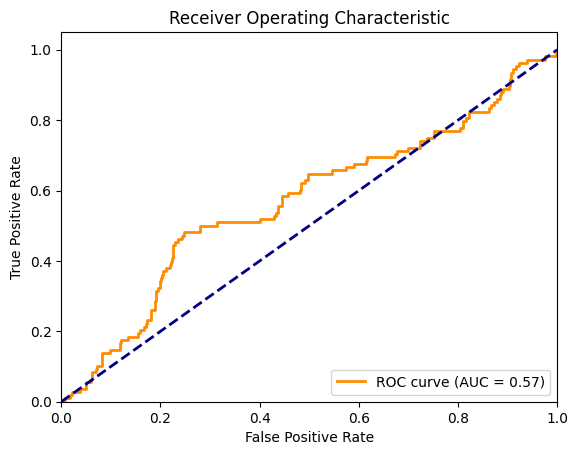

In [ ]:
# Calcular probabilidades de predicción
y_pred_proba = model.predict(X_test)

# Calcular curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Imprimir AUC
print(f"AUC: {roc_auc}")

# Graficar curva ROC
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Resultados de Prueba

*   Accuracy: **53.0%**
*   Precision: **27.4%**
*   Sensitivity: **93.6%**
*   Specificity: **12.5%**
*   F1 Score para "0": **0.22**
*   F1 Score para "1": **0.42**


###### 5. **Modelo CNN**

In [ ]:
# Definir el modelo
model = Sequential()
model.add(Input(shape=(4760, 3)))  # Definir explícitamente el tamaño de entrada
model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val_wrist_gyr, y_val_wrist_gyr))

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.6858 - loss: 1.7136 - val_accuracy: 0.8214 - val_loss: 0.3792
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8800 - loss: 0.3004 - val_accuracy: 0.9107 - val_loss: 0.2277
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9523 - loss: 0.1400 - val_accuracy: 0.8878 - val_loss: 0.2865
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9751 - loss: 0.0648 - val_accuracy: 0.9133 - val_loss: 0.2793
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9892 - loss: 0.0412 - val_accuracy: 0.9209 - val_loss: 0.2796
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9895 - loss: 0.0318 - val_accuracy: 0.9158 - val_loss: 0.3309
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9964 - loss: 0.0133 - val_accuracy: 0.9209 - val_loss: 0.3374
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9991 - loss: 0.0037 - val_accuracy: 0.9158 - v

In [ ]:
# Evaluar el modelo en el conjunto de validación
y_val_pred_wrist_gyr_cnn = model.predict(X_val_wrist_gyr).ravel()  # Genera predicciones
y_val_pred_wrist_gyr_cnn = (y_val_pred_wrist_gyr_cnn > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_cnn)
val_precision = precision_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_cnn, average='binary')
val_recall = recall_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_cnn, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_gyr, y_val_pred_wrist_gyr_cnn).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_cnn)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_gyr, y_val_pred_wrist_gyr_cnn).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_gyr, y_val_pred_wrist_gyr_cnn))

# Guardar métricas de validación en un diccionario
res_val_wrist_gyr_cnn = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Validation Accuracy: 0.9209183673469388
Validation Precision: 0.8813559322033898
Validation Sensitivity: 0.6842105263157895
Validation Specificity: 0.9778481012658228
Validation Balanced Accuracy: 0.8310293137908061

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95       316
           1       0.88      0.68      0.77        76

    accuracy                           0.92       392
   macro avg       0.90      0.83      0.86       392
weighted avg       0.92      0.92      0.92       392



In [ ]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred_wrist_gyr_cnn = model.predict(X_test).ravel()  # Genera predicciones
y_test_pred_wrist_gyr_cnn = (y_test_pred_wrist_gyr_cnn > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias

# Cálculo de métricas
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_wrist_gyr_cnn))
print("Test Precision:", precision_score(y_test, y_test_pred_wrist_gyr_cnn, average='binary'))
print("Test Sensitivity (Recall):", recall_score(y_test, y_test_pred_wrist_gyr_cnn, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_wrist_gyr_cnn).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_wrist_gyr_cnn))

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_wrist_gyr_cnn))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Test Accuracy: 0.9371633752244165
Test Precision: 0.9195402298850575
Test Sensitivity (Recall): 0.7407407407407407
Test Specificity: 0.9844097995545658
Test Balanced Accuracy: 0.8625752701476532

Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       449
           1       0.92      0.74      0.82       108

    accuracy                           0.94       557
   macro avg       0.93      0.86      0.89       557
weighted avg       0.94      0.94      0.93       557



Validación Cruzada K-Fold:

In [ ]:
# Definir el número de folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Inicializar listas para almacenar los resultados de cada fold
accuracy_per_fold = []
loss_per_fold = []
precision_per_fold = []
recall_per_fold = []
specificity_per_fold = []
f1_per_fold = []
balanced_accuracy_per_fold = []

# Iterar sobre cada fold
for train_index, val_index in kf.split(X_train):
    # Dividir los datos en entrenamiento y validación
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Definir el modelo (es importante definirlo dentro del loop para reiniciarlo en cada fold)
    model = Sequential()
    model.add(Input(shape=(4760, 3)))  # Definir explícitamente el tamaño de entrada
    model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo en el fold actual
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)

    # Evaluar el modelo en el conjunto de validación del fold actual
    y_val_pred = model.predict(X_val_fold).ravel()
    y_val_pred = (y_val_pred > 0.5).astype(int)

    # Cálculo de métricas para el fold actual
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    loss = model.evaluate(X_val_fold, y_val_fold, verbose=0)[0]
    precision = precision_score(y_val_fold, y_val_pred)
    recall = recall_score(y_val_fold, y_val_pred)
    f1 = f1_score(y_val_fold, y_val_pred)
    cm = confusion_matrix(y_val_fold, y_val_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    balanced_accuracy = balanced_accuracy_score(y_val_fold, y_val_pred)

    # Almacenar las métricas para este fold
    accuracy_per_fold.append(accuracy)
    loss_per_fold.append(loss)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    specificity_per_fold.append(specificity)
    f1_per_fold.append(f1)
    balanced_accuracy_per_fold.append(balanced_accuracy)

# Mostrar resultados promedio de las métricas de k-fold
print(f'\nMean Accuracy (k-Fold): {np.mean(accuracy_per_fold)}')
print(f'Mean Loss (k-Fold): {np.mean(loss_per_fold)}')
print(f'Mean Precision (k-Fold): {np.mean(precision_per_fold)}')
print(f'Mean Recall (k-Fold): {np.mean(recall_per_fold)}')
print(f'Mean Specificity (k-Fold): {np.mean(specificity_per_fold)}')
print(f'Mean F1 Score (k-Fold): {np.mean(f1_per_fold)}')
print(f'Mean Balanced Accuracy (k-Fold): {np.mean(balanced_accuracy_per_fold)}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Mean Accuracy (k-Fold): 0.9175718849840255
Mean Loss (k-Fold): 0.3985360682010651
Mean Precision (k-Fold): 0.8534611630436701
Mean Recall (k-Fold): 0.7531882553608612
Mean Specificity (k-Fold): 0.9632036910255917
Mean F1 Score (k-Fold): 0.7978557187859514
Mean Balanced Accuracy (k-Fold): 0.8581959731932265


**Mean Accuracy**:

**Mean Precision**:

**Mean Sensitivity**:

**Mean Specifity**:

**Mean F1 Score**:

###### 6. **Modelo SAE**

Padding y división de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_wrist[feature_cols_gyr].applymap(len).max().max()
print(f"Longitud máxima de secuencia: {max_length}")

Longitud máxima de secuencia: 4760


<ipython-input-425-b05ccceda93c>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_wrist[feature_cols_gyr].applymap(len).max().max()


In [ ]:
# Crear un índice de validación a partir de la división de entrenamiento y validación
train_indices, val_indices = train_test_split(df_train_wrist.index, test_size=0.2, random_state=42)

# Crear los conjuntos de secuencias de entrenamiento y validación
df_train_wrist_train = df_train_wrist.loc[train_indices]
df_train_wrist_val = df_train_wrist.loc[val_indices]

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols_gyr, max_length):
    padded_features = []
    for col in feature_cols_gyr:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)
            if sequence.shape[1] < 3:
                # Añadir columnas con ceros para igualar a 3 dimensiones
                sequence = np.pad(sequence, ((0, 0), (0, 3 - sequence.shape[1])), 'constant', constant_values=0)
            if len(sequence) < max_length:
                padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
            else:
                padded_sequence = sequence[:max_length]
            padded_col.append(padded_sequence)

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_wrist_train, feature_cols_gyr, max_length)
y_train = df_train_wrist_train[target_col].values

# Aplicar padding al conjunto de validación
X_val_wrist_gyr = pad_sequences_feature(df_train_wrist_val, feature_cols_gyr, max_length)
y_val_wrist_gyr = df_train_wrist_val[target_col].values

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalizar las características del conjunto de validación
X_val_wrist_gyr = scaler.transform(X_val_wrist_gyr.reshape(-1, X_val_wrist_gyr.shape[-1])).reshape(X_val_wrist_gyr.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test_wrist, feature_cols_gyr, max_length)
y_test = df_test_wrist[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")

Forma de X_train: (1565, 4760, 3)
Forma de X_test: (557, 4760, 3)


*  **1957 / 1321** son el número de muestras para el conjunto de entrenamiento y prueba, respectivamente.
*  **4760** es la longitud de la ventana de tiempo (en muestras) para cada señal.
*  **3** representa los tres canales de aceleración (ax, ay, az).

In [ ]:
# Ver los primeros 5 valores de cada canal en la primera muestra
print("Primeros 5 valores del primer canal (ax) de la primera muestra de X_train:")
print(X_train[0, :5, 0])  # Canal ax

print("Primeros 5 valores del segundo canal (ay) de la primera muestra de X_train:")
print(X_train[0, :5, 1])  # Canal ay

print("Primeros 5 valores del tercer canal (az) de la primera muestra de X_train:")
print(X_train[0, :5, 2])  # Canal az

Primeros 5 valores del primer canal (ax) de la primera muestra de X_train:
[0.71090784 0.721724   0.73374195 0.74816348 0.75657605]
Primeros 5 valores del segundo canal (ay) de la primera muestra de X_train:
[-0.18821298 -0.18357846 -0.17585426 -0.17430942 -0.16658522]
Primeros 5 valores del tercer canal (az) de la primera muestra de X_train:
[-0.09621952 -0.08662788 -0.06864356 -0.05185819 -0.03507283]


In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Configurar la semilla para la reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
# Parámetros
input_shape = (4760, 3)  # Ajusta esto a la forma de tu entrada
kernel_size = 7
filters = [32, 64]  # Número de filtros en cada capa convolucional

# Definir la función de autoencoder
def build_autoencoder(input_shape, filters, kernel_size):
    input_layer = Input(shape=input_shape)

    # Encoder
    x = Conv1D(filters=filters[0], kernel_size=kernel_size, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Dropout(0.3)(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Dropout(0.3)(x)

    # Bottleneck
    bottleneck_shape = x.shape[1:]  # Obtiene la forma después de las capas convolucionales y de pooling
    x = Flatten()(x)
    bottleneck = Dense(128, activation='relu')(x)  # Puedes ajustar la dimensión del bottleneck
    bottleneck = Dropout(0.3)(bottleneck)

    # Decoder
    x = Dense(np.prod(bottleneck_shape), activation='relu')(bottleneck)
    x = Reshape(bottleneck_shape)(x)  # Redimensiona a la forma adecuada para las capas convolucionales de decodificación
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=input_shape[1], kernel_size=kernel_size, activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_layer, x)
    encoder = Model(input_layer, bottleneck)

    return autoencoder, encoder

# Construir el autoencoder
autoencoder, encoder = build_autoencoder(input_shape, filters, kernel_size)

# Compilar el autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenar el autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2)

# Extraer las características usando el encoder
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val_wrist_gyr)
X_test_encoded = encoder.predict(X_test)

# Crear el clasificador denso
def build_classifier(input_shape):
    input_layer = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input_layer)
    x = Dense(32, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    classifier = Model(input_layer, output_layer)
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return classifier

# Construir el clasificador
classifier = build_classifier(X_train_encoded.shape[1:])

# Entrenar el clasificador
classifier.fit(X_train_encoded, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weights)

# Evaluar el clasificador
loss, accuracy = classifier.evaluate(X_test_encoded, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 1.0700 - val_loss: 1.1032
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.9888 - val_loss: 1.1032
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.9888 - val_loss: 1.1032
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.9888 - val_loss: 1.1032
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.9888 - val_loss: 1.1032
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.9888 - val_loss: 1.1032
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.9888 - val_loss: 1.1032
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.9888 - val_loss: 1.1032
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.9888 - val_loss: 1.1032
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.9888 - val_loss: 1.1032
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/10
40/40 ━━━━━━━━━━━━

In [ ]:
# Realizar predicciones
y_val_pred_wrist_gyr_sae = (classifier.predict(X_val_encoded) > 0.5).astype(int).ravel()

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_sae)
val_precision = precision_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_sae, average='binary')
val_recall = recall_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_sae, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_gyr, y_val_pred_wrist_gyr_sae).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_sae)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_gyr, y_val_pred_wrist_gyr_sae).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_gyr, y_val_pred_wrist_gyr_sae))

# Guardar métricas de validación en un diccionario
res_val_wrist_gyr_sae = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Validation Accuracy: 0.5535714285714286
Validation Precision: 0.2928870292887029
Validation Sensitivity: 0.9210526315789473
Validation Specificity: 0.4651898734177215
Validation Balanced Accuracy: 0.6931212524983345

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.47      0.63       316
           1       0.29      0.92      0.44        76

    accuracy                           0.55       392
   macro avg       0.63      0.69      0.54       392
weighted avg       0.83      0.55      0.59       392



In [ ]:
# Realizar predicciones
y_test_pred_wrist_gyr_sae = (classifier.predict(X_test_encoded) > 0.5).astype(int).ravel()

# Cálculo de métricas
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_wrist_gyr_sae))
print("Test Precision:", precision_score(y_test, y_test_pred_wrist_gyr_sae, average='binary'))
print("Test Sensitivity:", recall_score(y_test, y_test_pred_wrist_gyr_sae, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_wrist_gyr_sae).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_wrist_gyr_sae))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_wrist_gyr_sae))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Test Accuracy: 0.533213644524237
Test Precision: 0.27245508982035926
Test Sensitivity: 0.8425925925925926
Test Specificity: 0.45879732739420936
Test Balanced Accuracy: 0.650694959993401

Test Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.46      0.61       449
           1       0.27      0.84      0.41       108

    accuracy                           0.53       557
   macro avg       0.60      0.65      0.51       557
weighted avg       0.80      0.53      0.57       557



18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
AUC: 0.7301410541945063


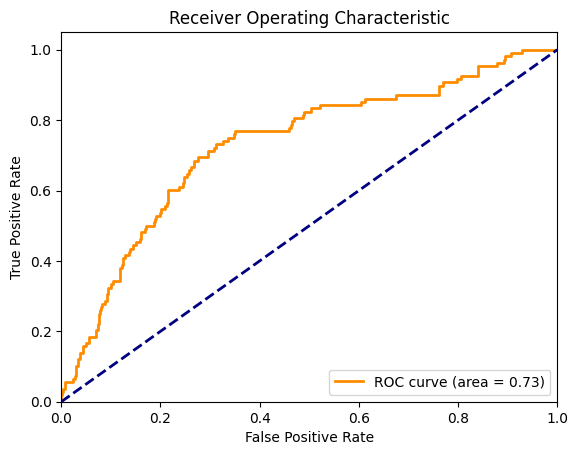

In [ ]:
# Realizar predicciones
y_pred_proba = classifier.predict(X_test_encoded)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Imprimir AUC
print(f"AUC: {roc_auc}")

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

AUC de 0.692

Resultados de Prueba

*   Accuracy: **54.5%**
*   Precision: **27.9%**
*   Sensitivity: **100.0%**
*   Specificity: **9.0%**
*   F1 Score para "0": **0.17**
*   F1 Score para "1": **0.44**

##### Magnetómetro (Mag)

In [ ]:
# Función para extraer características de una serie temporal
def extract_features_from_series(series):
    series = np.asarray(series)  # Asegurarse de que sea un array de NumPy
    series = series.astype(float)  # Convertir a flotante para evitar overflow

    return {
        'mean': np.mean(series),
        'std': np.std(series),
        'var': np.var(series),
        'max': np.max(series),
        'min': np.min(series),
        'range': np.ptp(series),  # np.ptp es equivalente a np.max - np.min pero más seguro
        'kurtosis': pd.Series(series).kurtosis(),
        'skewness': pd.Series(series).skew()
    }

# Función para procesar cada fila de datos
def process_mag_row(mag_data):
    x_vals = np.array([point[0] for point in mag_data])
    y_vals = np.array([point[1] for point in mag_data])
    z_vals = np.array([point[2] for point in mag_data])

    # Asegurarse de que cada valor sea numérico y no una lista o array multidimensional
    x_features = extract_features_from_series(x_vals)
    y_features = extract_features_from_series(y_vals)
    z_features = extract_features_from_series(z_vals)

    # Combinar todas las características en un solo vector (diccionario)
    mag_features = {f'x_{key}': val for key, val in x_features.items()}
    mag_features.update({f'y_{key}': val for key, val in y_features.items()})
    mag_features.update({f'z_{key}': val for key, val in z_features.items()})

    return mag_features

# Separamos características y preparamos datos:
df_train_wrist_features = df_train_wrist[feature_cols_mag].apply(lambda row: process_mag_row(row['Mag']), axis=1)
df_train_wrist_features = pd.DataFrame(df_train_wrist_features.tolist())
X_train_wrist_mag = df_train_wrist_features
y_train_wrist_mag = df_train_wrist[target_col]

df_test_wrist_features = df_test_wrist[feature_cols_mag].apply(lambda row: process_mag_row(row['Mag']), axis=1)
df_test_wrist_features = pd.DataFrame(df_test_wrist_features.tolist())
X_test_wrist_mag = df_test_wrist_features
y_test_wrist_mag = df_test_wrist[target_col]

Normalizamos características:

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train_wrist_mag = scaler.fit_transform(X_train_wrist_mag)
X_test_wrist_mag = scaler.transform(X_test_wrist_mag)

In [ ]:
# Dividir el conjunto de datos en entrenamiento y validación
X_train_wrist_mag, X_val_wrist_mag, y_train_wrist_mag, y_val_wrist_mag = train_test_split(X_train_wrist_mag, y_train_wrist_mag, test_size=0.2, random_state=42)

###### 1. **Modelo k-NN**

Realizamos predicciones:

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_wrist_mag, y_train_wrist_mag)
y_pred = knn.predict(X_test_wrist_mag)

Evaluación del modelo:

In [ ]:
# Evaluación en el conjunto de validación
y_val_pred_wrist_mag_knn = knn.predict(X_val_wrist_mag)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_mag, y_val_pred_wrist_mag_knn)
val_precision = precision_score(y_val_wrist_mag, y_val_pred_wrist_mag_knn, average='binary')
val_recall = recall_score(y_val_wrist_mag, y_val_pred_wrist_mag_knn, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_mag, y_val_pred_wrist_mag_knn).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_mag, y_val_pred_wrist_mag_knn)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_mag, y_val_pred_wrist_mag_knn).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_mag, y_val_pred_wrist_mag_knn))

# Guardar métricas de validación en un diccionario
res_val_wrist_mag_knn = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.8775510204081632
Validation Precision: 0.78
Validation Sensitivity: 0.5131578947368421
Validation Specificity: 0.9651898734177216
Validation Balanced Accuracy: 0.7391738840772819

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       316
           1       0.78      0.51      0.62        76

    accuracy                           0.88       392
   macro avg       0.84      0.74      0.77       392
weighted avg       0.87      0.88      0.87       392



In [ ]:
# Evaluación en el conjunto de prueba
y_test_pred_wrist_mag_knn = knn.predict(X_test_wrist_mag)

print("\nTest Accuracy:", accuracy_score(y_test_wrist_mag, y_test_pred_wrist_mag_knn))
print("Test Precision:", precision_score(y_test_wrist_mag, y_test_pred_wrist_mag_knn, average='binary'))
print("Test Sensitivity:", recall_score(y_test_wrist_mag, y_test_pred_wrist_mag_knn, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test_wrist_mag, y_test_pred_wrist_mag_knn).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_wrist_mag, y_test_pred_wrist_mag_knn))

print("\nTest Classification Report:\n", classification_report(y_test_wrist_mag, y_test_pred_wrist_mag_knn))


Test Accuracy: 0.8563734290843806
Test Precision: 0.6590909090909091
Test Sensitivity: 0.5370370370370371
Test Specificity: 0.933184855233853
Test Balanced Accuracy: 0.735110946135445

Test Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91       449
           1       0.66      0.54      0.59       108

    accuracy                           0.86       557
   macro avg       0.78      0.74      0.75       557
weighted avg       0.85      0.86      0.85       557



Resultados de Validación

*   Accuracy: **87.7%**
*   Precision: **78.0%**
*   Sensitivity: **51.3%**
*   Specificity: **96.5%**
*   F1 Score para "0": **0.93**
*   F1 Score para "1": **0.62**

Estos resultados muestran ...

Resultados de Prueba

*   Accuracy: **74.0%**
*   Precision: **51.0%**
*   Sensitivity: **36.6%**
*   Specificity: **87.6%**
*   F1 Score para "0": **0.83**
*   F1 Score para "1": **0.43**

En comparación con los resultados de validación, los resultados del conjunto de prueba muestran ...

###### 2. **Modelo SVM**

In [ ]:
# Crear el modelo SVM
svm_model = SVC(kernel='linear')  # Puedes probar otros kernels como 'rbf', 'poly', etc.

# Entrenar el modelo
svm_model.fit(X_train_wrist_mag, y_train_wrist_mag)

# Hacer predicciones en el conjunto de validación
y_val_pred_wrist_mag_svm = svm_model.predict(X_val_wrist_mag)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_mag, y_val_pred_wrist_mag_svm)
val_precision = precision_score(y_val_wrist_mag, y_val_pred_wrist_mag_svm, average='binary')
val_recall = recall_score(y_val_wrist_mag, y_val_pred_wrist_mag_svm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_mag, y_val_pred_wrist_mag_svm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_mag, y_val_pred_wrist_mag_svm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_mag, y_val_pred_wrist_mag_svm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_mag, y_val_pred_wrist_mag_svm))

# Guardar métricas de validación en un diccionario
res_val_wrist_mag_svm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.8112244897959183
Validation Precision: 0.5555555555555556
Validation Sensitivity: 0.13157894736842105
Validation Specificity: 0.9746835443037974
Validation Balanced Accuracy: 0.5531312458361093

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89       316
           1       0.56      0.13      0.21        76

    accuracy                           0.81       392
   macro avg       0.69      0.55      0.55       392
weighted avg       0.77      0.81      0.76       392



In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred_wrist_mag_svm = svm_model.predict(X_test_wrist_mag)

# Evaluar el modelo en el conjunto de prueba
print(f"\nTest Accuracy:", accuracy_score(y_test_wrist_mag, y_test_pred_wrist_mag_svm))
print(f"Test Precision:", precision_score(y_test_wrist_mag, y_test_pred_wrist_mag_svm))
print(f"Test Sensitivity:", recall_score(y_test_wrist_mag, y_test_pred_wrist_mag_svm))
tn, fp, fn, tp = confusion_matrix(y_test_wrist_mag, y_test_pred_wrist_mag_svm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_wrist_mag, y_test_pred_wrist_mag_svm))

print("\nTest Classification Report:", classification_report(y_test_wrist_mag, y_test_pred_wrist_mag_svm))


Test Accuracy: 0.8276481149012568
Test Precision: 0.6875
Test Sensitivity: 0.2037037037037037
Test Specificity: 0.977728285077951
Test Balanced Accuracy: 0.5907159943908273

Test Classification Report:               precision    recall  f1-score   support

           0       0.84      0.98      0.90       449
           1       0.69      0.20      0.31       108

    accuracy                           0.83       557
   macro avg       0.76      0.59      0.61       557
weighted avg       0.81      0.83      0.79       557



Ajuste de Hiperparámetros con GridSearchCV:

In [ ]:
# Definir los hiperparámetros a probar
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']  # solo afecta a algunos kernels
}

# Crear el modelo SVM
svm_model = SVC()

# Implementar GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar el modelo con GridSearchCV
grid_search.fit(X_train_wrist_mag, y_train_wrist_mag)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Usar el mejor modelo encontrado
best_svm_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de validación
y_val_pred_wrist_mag_svm = best_svm_model.predict(X_val_wrist_mag)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_mag, y_val_pred_wrist_mag_svm)
val_precision = precision_score(y_val_wrist_mag, y_val_pred_wrist_mag_svm, average='binary')
val_recall = recall_score(y_val_wrist_mag, y_val_pred_wrist_mag_svm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_mag, y_val_pred_wrist_mag_svm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_mag, y_val_pred_wrist_mag_svm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_mag, y_val_pred_wrist_mag_svm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_mag, y_val_pred_wrist_mag_svm))

# Guardar métricas de validación en un diccionario
res_val_wrist_mag_svm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

Mejores hiperparámetros: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Validation Accuracy: 0.8801020408163265
Validation Precision: 0.7164179104477612
Validation Sensitivity: 0.631578947368421
Validation Specificity: 0.939873417721519
Validation Balanced Accuracy: 0.78572618254497

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.93       316
           1       0.72      0.63      0.67        76

    accuracy                           0.88       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.88      0.88      0.88       392



Validación Cruzada

In [ ]:
# Realizar validación cruzada con los mejores parámetros
cv_scores = cross_val_score(best_svm_model, X_train_wrist_mag, y_train_wrist_mag, cv=5, scoring='accuracy')

print(f"Validation Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean()}")

Validation Cross-Validation Scores: [0.85303514 0.87539936 0.8370607  0.85942492 0.8913738 ]
Mean Cross-Validation Accuracy: 0.863258785942492


Evaluación del Modelo en el Conjunto de Prueba

In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred_wrist_mag_svm = best_svm_model.predict(X_test_wrist_mag)

# Evaluar el modelo en el conjunto de prueba
print(f"\nTest Accuracy:", accuracy_score(y_test_wrist_mag, y_test_pred_wrist_mag_svm))
print(f"Test Precision:", precision_score(y_test_wrist_mag, y_test_pred_wrist_mag_svm))
print(f"Test Sensitivity:", recall_score(y_test_wrist_mag, y_test_pred_wrist_mag_svm))
tn, fp, fn, tp = confusion_matrix(y_test_wrist_mag, y_test_pred_wrist_mag_svm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_wrist_mag, y_test_pred_wrist_mag_svm))

print("\nTest Classification Report:", classification_report(y_test_wrist_mag, y_test_pred_wrist_mag_svm))


Test Accuracy: 0.8473967684021544
Test Precision: 0.6095238095238096
Test Sensitivity: 0.5925925925925926
Test Specificity: 0.9086859688195991
Test Balanced Accuracy: 0.7506392807060958

Test Classification Report:               precision    recall  f1-score   support

           0       0.90      0.91      0.91       449
           1       0.61      0.59      0.60       108

    accuracy                           0.85       557
   macro avg       0.76      0.75      0.75       557
weighted avg       0.85      0.85      0.85       557



Sí mejora con GridSearchCV:

Resultados de Prueba

*   Accuracy: **73.1%**
*   Precision: **48.3%**
*   Sensitivity: **46.8%**
*   Specificity: **82.4%**
*   F1 Score para "0": **0.82**
*   F1 Score para "1": **0.48**

###### 3. **Modelo Random Forest**

In [ ]:
# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')  # Puedes ajustar 'n_estimators' y otros hiperparámetros

# Entrenar el modelo con las características extraídas
rf_model.fit(X_train_wrist_mag, y_train_wrist_mag)

# Hacer predicciones en el conjunto de validación
y_val_pred_wrist_mag_rf = rf_model.predict(X_val_wrist_mag)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_mag, y_val_pred_wrist_mag_rf)
val_precision = precision_score(y_val_wrist_mag, y_val_pred_wrist_mag_rf, average='binary')
val_recall = recall_score(y_val_wrist_mag, y_val_pred_wrist_mag_rf, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_mag, y_val_pred_wrist_mag_rf).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_mag, y_val_pred_wrist_mag_rf)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_mag, y_val_pred_wrist_mag_rf).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_mag, y_val_pred_wrist_mag_rf))

# Guardar métricas de validación en un diccionario
res_val_wrist_mag_rf = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.8801020408163265
Validation Precision: 0.8372093023255814
Validation Sensitivity: 0.47368421052631576
Validation Specificity: 0.9778481012658228
Validation Balanced Accuracy: 0.7257661558960693

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93       316
           1       0.84      0.47      0.61        76

    accuracy                           0.88       392
   macro avg       0.86      0.73      0.77       392
weighted avg       0.88      0.88      0.87       392



In [ ]:
# Realizar predicciones en el conjunto de prueba
y_test_pred_wrist_mag_rf = rf_model.predict(X_test_wrist_mag)

# Evaluar el rendimiento del modelo
print("\nTest Accuracy:", accuracy_score(y_test_wrist_mag, y_test_pred_wrist_mag_rf))
print("Test Precision:", precision_score(y_test_wrist_mag, y_test_pred_wrist_mag_rf, average='binary'))
print("Test Sensitivity (Recall):", recall_score(y_test_wrist_mag, y_test_pred_wrist_mag_rf, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test_wrist_mag, y_test_pred_wrist_mag_rf).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_wrist_mag, y_test_pred_wrist_mag_rf))

print("\nTest Classification Report:\n", classification_report(y_test_wrist_mag, y_test_pred_wrist_mag_rf))


Test Accuracy: 0.8850987432675045
Test Precision: 0.7972972972972973
Test Sensitivity (Recall): 0.5462962962962963
Test Specificity: 0.9665924276169265
Test Balanced Accuracy: 0.7564443619566115

Test Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       449
           1       0.80      0.55      0.65       108

    accuracy                           0.89       557
   macro avg       0.85      0.76      0.79       557
weighted avg       0.88      0.89      0.88       557



Resultados de Prueba

*   Accuracy: **77.4%**
*   Precision: **79.5%**
*   Sensitivity: **18.0%**
*   Specificity: **98.4%**
*   F1 Score para "0": **0.87**
*   F1 Score para "1": **0.29**

###### 4. **Modelo LSTM**

Padding y división de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_wrist[feature_cols_mag].applymap(len).max().max()
print(f"Longitud máxima de secuencia: {max_length}")

Longitud máxima de secuencia: 1600


<ipython-input-450-77afd319aea9>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_wrist[feature_cols_mag].applymap(len).max().max()


In [ ]:
# Crear un índice de validación a partir de la división de entrenamiento y validación
train_indices, val_indices = train_test_split(df_train_wrist.index, test_size=0.2, random_state=42)

# Crear los conjuntos de secuencias de entrenamiento y validación
df_train_wrist_train = df_train_wrist.loc[train_indices]
df_train_wrist_val = df_train_wrist.loc[val_indices]

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols_mag, max_length):
    padded_features = []
    for col in feature_cols_mag:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)
            if sequence.shape[1] < 3:
                # Añadir columnas con ceros para igualar a 3 dimensiones
                sequence = np.pad(sequence, ((0, 0), (0, 3 - sequence.shape[1])), 'constant', constant_values=0)
            if len(sequence) < max_length:
                padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
            else:
                padded_sequence = sequence[:max_length]
            padded_col.append(padded_sequence)

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_wrist_train, feature_cols_mag, max_length)
y_train = df_train_wrist_train[target_col].values

# Aplicar padding al conjunto de validación
X_val_wrist_mag = pad_sequences_feature(df_train_wrist_val, feature_cols_mag, max_length)
y_val_wrist_mag = df_train_wrist_val[target_col].values

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalizar las características del conjunto de validación
X_val_wrist_mag = scaler.transform(X_val_wrist_mag.reshape(-1, X_val_wrist_mag.shape[-1])).reshape(X_val_wrist_mag.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test_wrist, feature_cols_mag, max_length)
y_test = df_test_wrist[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Configurar la semilla para la reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
print("Dimensiones de X_train:")
print(f"Forma: {X_train.shape}")
print(f"Número de muestras: {X_train.shape[0]}")
print(f"Longitud de secuencia (timesteps): {X_train.shape[1]}")
print(f"Número de características: {X_train.shape[2]}")

print("\nDimensiones de X_test:")
print(f"Forma: {X_test.shape}")
print(f"Número de muestras: {X_test.shape[0]}")
print(f"Longitud de secuencia (timesteps): {X_test.shape[1]}")
print(f"Número de características: {X_test.shape[2]}")

Dimensiones de X_train:
Forma: (1565, 1600, 3)
Número de muestras: 1565
Longitud de secuencia (timesteps): 1600
Número de características: 3

Dimensiones de X_test:
Forma: (557, 1600, 3)
Número de muestras: 557
Longitud de secuencia (timesteps): 1600
Número de características: 3


In [ ]:
# Verificar la forma de entrada esperada para el modelo
input_shape = (1600, 3)  # Esto debe coincidir con las dimensiones de tus datos

print(f"Forma de entrada esperada para el modelo: {input_shape}")

Forma de entrada esperada para el modelo: (1600, 3)


*  Menor Tiempo de Cómputo: RandomizedSearchCV es mucho más rápido que GridSearchCV para grandes espacios de hiperparámetros.
*  Exploración Eficiente: Aunque no prueba todas las combinaciones posibles, es probable que encuentre una buena combinación de hiperparámetros en menos tiempo.

In [ ]:
# Crear el modelo LSTM
model = Sequential()
model.add(Masking(mask_value=0., input_shape=input_shape))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con pesos de clase
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val_wrist_mag, y_val_wrist_mag), class_weight=class_weights)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.6064 - loss: 0.6826 - val_accuracy: 0.7143 - val_loss: 0.6659
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.6793 - loss: 0.6497 - val_accuracy: 0.7270 - val_loss: 0.6406
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.6968 - loss: 0.6415 - val_accuracy: 0.7245 - val_loss: 0.6532
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.6984 - loss: 0.6282 - val_accuracy: 0.7347 - val_loss: 0.6203
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.6812 - loss: 0.6241 - val_accuracy: 0.7117 - val_loss: 0.6016
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.6552 - loss: 0.6568 - val_accuracy: 0.6505 - val_loss: 0.6200
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.6509 - loss: 0.6343 - val_accuracy: 0.7500 - val_loss: 0.6008
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.7243 - loss: 0.6108 - val_accuracy: 0.7551 - val_loss:

In [ ]:
# Realizar predicciones en el conjunto de validación
y_val_pred_wrist_mag_lstm = (model.predict(X_val_wrist_mag) > 0.5).astype("int32").ravel()

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_mag, y_val_pred_wrist_mag_lstm)
val_precision = precision_score(y_val_wrist_mag, y_val_pred_wrist_mag_lstm, average='binary')
val_recall = recall_score(y_val_wrist_mag, y_val_pred_wrist_mag_lstm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_mag, y_val_pred_wrist_mag_lstm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_mag, y_val_pred_wrist_mag_lstm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_mag, y_val_pred_wrist_mag_lstm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_mag, y_val_pred_wrist_mag_lstm))

# Guardar métricas de validación en un diccionario
res_val_wrist_mag_lstm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step

Validation Accuracy: 0.7295918367346939
Validation Precision: 0.38095238095238093
Validation Sensitivity: 0.631578947368421
Validation Specificity: 0.7531645569620253
Validation Balanced Accuracy: 0.6923717521652232

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.75      0.82       316
           1       0.38      0.63      0.48        76

    accuracy                           0.73       392
   macro avg       0.64      0.69      0.65       392
weighted avg       0.80      0.73      0.75       392



In [ ]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Realizar predicciones en el conjunto de prueba
y_test_pred_wrist_mag_lstm = (model.predict(X_test) > 0.5).astype("int32").ravel()

print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_wrist_mag_lstm))
print("Test Precision:", precision_score(y_test, y_test_pred_wrist_mag_lstm, average='binary'))
print("Test Sensitivity:", recall_score(y_test, y_test_pred_wrist_mag_lstm, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_wrist_mag_lstm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_wrist_mag_lstm))

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_wrist_mag_lstm))

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7052 - loss: 0.5465
Loss: 0.5572750568389893, Accuracy: 0.6858168840408325
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step

Test Accuracy: 0.6858168761220825
Test Precision: 0.31693989071038253
Test Sensitivity: 0.5370370370370371
Test Specificity: 0.7216035634743875
Test Balanced Accuracy: 0.6293203002557123

Test Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.72      0.79       449
           1       0.32      0.54      0.40       108

    accuracy                           0.69       557
   macro avg       0.59      0.63      0.59       557
weighted avg       0.76      0.69      0.71       557



18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
AUC: 0.7272746019962056


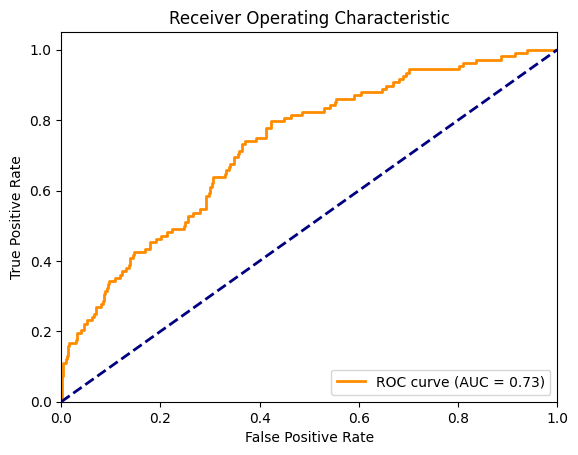

In [ ]:
# Calcular probabilidades de predicción
y_pred_proba = model.predict(X_test)

# Calcular curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Imprimir AUC
print(f"AUC: {roc_auc}")

# Graficar curva ROC
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Resultados de Prueba

*   Accuracy: **56.8%**
*   Precision: **31.2%**
*   Sensitivity: **60.7%**
*   Specificity: **52.9%**
*   F1 Score para "0": **0.63**
*   F1 Score para "1": **0.41**


###### 5. **Modelo CNN**

In [ ]:
# Definir el modelo
model = Sequential()
model.add(Input(shape=(1600, 3)))  # Definir explícitamente el tamaño de entrada
model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val_wrist_mag, y_val_wrist_mag))

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.7087 - loss: 1.3719 - val_accuracy: 0.8061 - val_loss: 0.4471
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8018 - loss: 0.4435 - val_accuracy: 0.8138 - val_loss: 0.4124
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8363 - loss: 0.3988 - val_accuracy: 0.8189 - val_loss: 0.4016
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8379 - loss: 0.3643 - val_accuracy: 0.8112 - val_loss: 0.4154
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8509 - loss: 0.3347 - val_accuracy: 0.7934 - val_loss: 0.4300
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8732 - loss: 0.2985 - val_accuracy: 0.8240 - val_loss: 0.4222
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8767 - loss: 0.2851 - val_accuracy: 0.7934 - val_loss: 0.4678
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8883 - loss: 0.2655 - val_accuracy: 0.8036 - val_los

In [ ]:
# Evaluar el modelo en el conjunto de validación
y_val_pred_wrist_mag_cnn = model.predict(X_val_wrist_mag).ravel()  # Genera predicciones
y_val_pred_wrist_mag_cnn = (y_val_pred_wrist_mag_cnn > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_mag, y_val_pred_wrist_mag_cnn)
val_precision = precision_score(y_val_wrist_mag, y_val_pred_wrist_mag_cnn, average='binary')
val_recall = recall_score(y_val_wrist_mag, y_val_pred_wrist_mag_cnn, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_mag, y_val_pred_wrist_mag_cnn).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_mag, y_val_pred_wrist_mag_cnn)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_mag, y_val_pred_wrist_mag_cnn).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_mag, y_val_pred_wrist_mag_cnn))

# Guardar métricas de validación en un diccionario
res_val_wrist_mag_cnn = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Validation Accuracy: 0.7882653061224489
Validation Precision: 0.4606741573033708
Validation Sensitivity: 0.5394736842105263
Validation Specificity: 0.8481012658227848
Validation Balanced Accuracy: 0.6937874750166555

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.87       316
           1       0.46      0.54      0.50        76

    accuracy                           0.79       392
   macro avg       0.67      0.69      0.68       392
weighted avg       0.80      0.79      0.79       392



In [ ]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred_wrist_mag_cnn = model.predict(X_test).ravel()  # Genera predicciones
y_test_pred_wrist_mag_cnn = (y_test_pred_wrist_mag_cnn > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias

# Cálculo de métricas
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_wrist_mag_cnn))
print("Test Precision:", precision_score(y_test, y_test_pred_wrist_mag_cnn, average='binary'))
print("Test Sensitivity (Recall):", recall_score(y_test, y_test_pred_wrist_mag_cnn, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_wrist_mag_cnn).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_wrist_mag_cnn))

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_wrist_mag_cnn))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Test Accuracy: 0.8420107719928187
Test Precision: 0.5757575757575758
Test Sensitivity (Recall): 0.7037037037037037
Test Specificity: 0.8752783964365256
Test Balanced Accuracy: 0.7894910500701147

Test Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90       449
           1       0.58      0.70      0.63       108

    accuracy                           0.84       557
   macro avg       0.75      0.79      0.77       557
weighted avg       0.86      0.84      0.85       557



Validación Cruzada K-Fold:

In [ ]:
# Definir el número de folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Inicializar listas para almacenar los resultados de cada fold
accuracy_per_fold = []
loss_per_fold = []
precision_per_fold = []
recall_per_fold = []
specificity_per_fold = []
f1_per_fold = []
balanced_accuracy_per_fold = []

# Iterar sobre cada fold
for train_index, val_index in kf.split(X_train):
    # Dividir los datos en entrenamiento y validación
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Definir el modelo (es importante definirlo dentro del loop para reiniciarlo en cada fold)
    model = Sequential()
    model.add(Input(shape=(1600, 3)))  # Definir explícitamente el tamaño de entrada
    model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo en el fold actual
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)

    # Evaluar el modelo en el conjunto de validación del fold actual
    y_val_pred = model.predict(X_val_fold).ravel()
    y_val_pred = (y_val_pred > 0.5).astype(int)

    # Cálculo de métricas para el fold actual
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    loss = model.evaluate(X_val_fold, y_val_fold, verbose=0)[0]
    precision = precision_score(y_val_fold, y_val_pred)
    recall = recall_score(y_val_fold, y_val_pred)
    f1 = f1_score(y_val_fold, y_val_pred)
    cm = confusion_matrix(y_val_fold, y_val_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    balanced_accuracy = balanced_accuracy_score(y_val_fold, y_val_pred)

    # Almacenar las métricas para este fold
    accuracy_per_fold.append(accuracy)
    loss_per_fold.append(loss)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    specificity_per_fold.append(specificity)
    f1_per_fold.append(f1)
    balanced_accuracy_per_fold.append(balanced_accuracy)

# Mostrar resultados promedio de las métricas de k-fold
print(f'\nMean Accuracy (k-Fold): {np.mean(accuracy_per_fold)}')
print(f'Mean Loss (k-Fold): {np.mean(loss_per_fold)}')
print(f'Mean Precision (k-Fold): {np.mean(precision_per_fold)}')
print(f'Mean Recall (k-Fold): {np.mean(recall_per_fold)}')
print(f'Mean Specificity (k-Fold): {np.mean(specificity_per_fold)}')
print(f'Mean F1 Score (k-Fold): {np.mean(f1_per_fold)}')
print(f'Mean Balanced Accuracy (k-Fold): {np.mean(balanced_accuracy_per_fold)}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Mean Accuracy (k-Fold): 0.853035143769968
Mean Loss (k-Fold): 0.5065179288387298
Mean Precision (k-Fold): 0.7794898728722258
Mean Recall (k-Fold): 0.4831831972324979
Mean Specificity (k-Fold): 0.9570843924205981
Mean F1 Score (k-Fold): 0.5731994229792458
Mean Balanced Accuracy (k-Fold): 0.720133794826548


**Mean Accuracy**:

**Mean Precision**:

**Mean Sensitivity**:

**Mean Specifity**:

**Mean F1 Score**:

###### 6. **Modelo SAE**

Padding y división de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_wrist[feature_cols_mag].applymap(len).max().max()
print(f"Longitud máxima de secuencia: {max_length}")

Longitud máxima de secuencia: 1600


<ipython-input-466-77afd319aea9>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_wrist[feature_cols_mag].applymap(len).max().max()


In [ ]:
# Crear un índice de validación a partir de la división de entrenamiento y validación
train_indices, val_indices = train_test_split(df_train_wrist.index, test_size=0.2, random_state=42)

# Crear los conjuntos de secuencias de entrenamiento y validación
df_train_wrist_train = df_train_wrist.loc[train_indices]
df_train_wrist_val = df_train_wrist.loc[val_indices]

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols_mag, max_length):
    padded_features = []
    for col in feature_cols_mag:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)
            if sequence.shape[1] < 3:
                # Añadir columnas con ceros para igualar a 3 dimensiones
                sequence = np.pad(sequence, ((0, 0), (0, 3 - sequence.shape[1])), 'constant', constant_values=0)
            if len(sequence) < max_length:
                padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
            else:
                padded_sequence = sequence[:max_length]
            padded_col.append(padded_sequence)

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_wrist_train, feature_cols_mag, max_length)
y_train = df_train_wrist_train[target_col].values

# Aplicar padding al conjunto de validación
X_val_wrist_mag = pad_sequences_feature(df_train_wrist_val, feature_cols_mag, max_length)
y_val_wrist_mag = df_train_wrist_val[target_col].values

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalizar las características del conjunto de validación
X_val_wrist_mag = scaler.transform(X_val_wrist_mag.reshape(-1, X_val_wrist_mag.shape[-1])).reshape(X_val_wrist_mag.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test_wrist, feature_cols_mag, max_length)
y_test = df_test_wrist[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")

Forma de X_train: (1565, 1600, 3)
Forma de X_test: (557, 1600, 3)


*  **1957 / 1321** son el número de muestras para el conjunto de entrenamiento y prueba, respectivamente.
*  **1600** es la longitud de la ventana de tiempo (en muestras) para cada señal.
*  **3** representa los tres canales de aceleración (ax, ay, az).

In [ ]:
# Ver los primeros 5 valores de cada canal en la primera muestra
print("Primeros 5 valores del primer canal (ax) de la primera muestra de X_train:")
print(X_train[0, :5, 0])  # Canal ax

print("Primeros 5 valores del segundo canal (ay) de la primera muestra de X_train:")
print(X_train[0, :5, 1])  # Canal ay

print("Primeros 5 valores del tercer canal (az) de la primera muestra de X_train:")
print(X_train[0, :5, 2])  # Canal az

Primeros 5 valores del primer canal (ax) de la primera muestra de X_train:
[-0.62733111 -0.61910127 -0.60607069 -0.61772963 -0.60332741]
Primeros 5 valores del segundo canal (ay) de la primera muestra de X_train:
[1.80843063 1.78954258 1.78347142 1.79763746 1.7787494 ]
Primeros 5 valores del tercer canal (az) de la primera muestra de X_train:
[-0.93969282 -0.95288065 -0.97972731 -0.93545387 -0.9406348 ]


In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Configurar la semilla para la reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
# Parámetros
input_shape = (1600, 3)  # Ajusta esto a la forma de tu entrada
kernel_size = 7
filters = [32, 64]  # Número de filtros en cada capa convolucional

# Definir la función de autoencoder
def build_autoencoder(input_shape, filters, kernel_size):
    input_layer = Input(shape=input_shape)

    # Encoder
    x = Conv1D(filters=filters[0], kernel_size=kernel_size, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)

    # Bottleneck
    bottleneck_shape = x.shape[1:]  # Obtiene la forma después de las capas convolucionales y de pooling
    x = Flatten()(x)
    bottleneck = Dense(128, activation='relu')(x)  # Puedes ajustar la dimensión del bottleneck

    # Decoder
    x = Dense(np.prod(bottleneck_shape), activation='relu')(bottleneck)
    x = Reshape(bottleneck_shape)(x)  # Redimensiona a la forma adecuada para las capas convolucionales de decodificación
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=input_shape[1], kernel_size=kernel_size, activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_layer, x)
    encoder = Model(input_layer, bottleneck)

    return autoencoder, encoder

# Construir el autoencoder
autoencoder, encoder = build_autoencoder(input_shape, filters, kernel_size)

# Compilar el autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenar el autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2)

# Extraer las características usando el encoder
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val_wrist_mag)
X_test_encoded = encoder.predict(X_test)

# Crear el clasificador denso
def build_classifier(input_shape):
    input_layer = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input_layer)
    x = Dense(32, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    classifier = Model(input_layer, output_layer)
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return classifier

# Construir el clasificador
classifier = build_classifier(X_train_encoded.shape[1:])

# Entrenar el clasificador
classifier.fit(X_train_encoded, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weights)

# Evaluar el clasificador
loss, accuracy = classifier.evaluate(X_test_encoded, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.9843 - val_loss: 0.7016
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7571 - val_loss: 0.6587
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7211 - val_loss: 0.6280
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6792 - val_loss: 0.6061
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6603 - val_loss: 0.5968
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6516 - val_loss: 0.5938
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6477 - val_loss: 0.5908
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6434 - val_loss: 0.5880
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6398 - val_loss: 0.5914
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6390 - val_loss: 0.5862
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/10
40/40 ━━━━━━━━━━━━━

In [ ]:
# Realizar predicciones
y_val_pred_wrist_mag_sae = (classifier.predict(X_val_encoded) > 0.5).astype(int).ravel()

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_mag, y_val_pred_wrist_mag_sae)
val_precision = precision_score(y_val_wrist_mag, y_val_pred_wrist_mag_sae, average='binary')
val_recall = recall_score(y_val_wrist_mag, y_val_pred_wrist_mag_sae, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_mag, y_val_pred_wrist_mag_sae).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_mag, y_val_pred_wrist_mag_sae)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_mag, y_val_pred_wrist_mag_sae).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_mag, y_val_pred_wrist_mag_sae))

# Guardar métricas de validación en un diccionario
res_val_wrist_mag_sae = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Validation Accuracy: 0.8010204081632653
Validation Precision: 0.4897959183673469
Validation Sensitivity: 0.631578947368421
Validation Specificity: 0.8417721518987342
Validation Balanced Accuracy: 0.7366755496335776

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.84      0.87       316
           1       0.49      0.63      0.55        76

    accuracy                           0.80       392
   macro avg       0.70      0.74      0.71       392
weighted avg       0.82      0.80      0.81       392



In [ ]:
# Realizar predicciones
y_test_pred_wrist_mag_sae = (classifier.predict(X_test_encoded) > 0.5).astype(int).ravel()

# Cálculo de métricas
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_wrist_mag_sae))
print("Test Precision:", precision_score(y_test, y_test_pred_wrist_mag_sae, average='binary'))
print("Test Sensitivity:", recall_score(y_test, y_test_pred_wrist_mag_sae, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_wrist_mag_sae).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_wrist_mag_sae))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_wrist_mag_sae))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Test Accuracy: 0.8150807899461401
Test Precision: 0.518796992481203
Test Sensitivity: 0.6388888888888888
Test Specificity: 0.8574610244988864
Test Balanced Accuracy: 0.7481749566938876

Test Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.88       449
           1       0.52      0.64      0.57       108

    accuracy                           0.82       557
   macro avg       0.71      0.75      0.73       557
weighted avg       0.83      0.82      0.82       557



18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
AUC: 0.8101542522477935


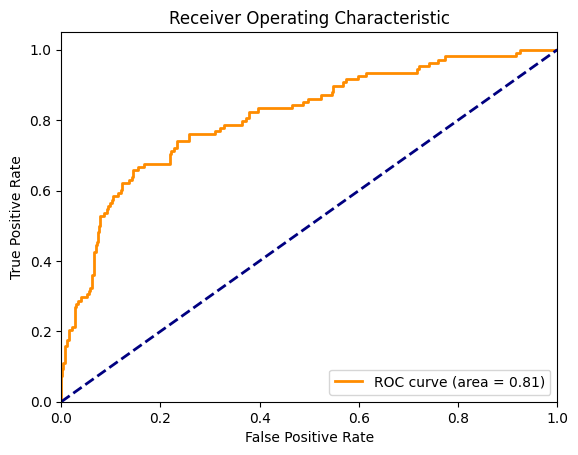

In [ ]:
# Realizar predicciones
y_pred_proba = classifier.predict(X_test_encoded)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Imprimir AUC
print(f"AUC: {roc_auc}")

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

AUC de 0.74

Resultados de Prueba

*   Accuracy: **68.5%**
*   Precision: **41.4%**
*   Sensitivity: **73.8%**
*   Specificity: **63.1%**
*   F1 Score para "0": **0.73**
*   F1 Score para "1": **0.53**

##### Barómetro (Bar)

In [ ]:
print("\nPrimeros 10 valores de Barómetro:\n")
# Mostrar los primeros 10 valores de la columna 'Bar'
print(df['Bar'].head(10))


Primeros 10 valores de Barómetro:

0    [[1013.193859563175, 23.71569457530976], [1013...
1    [[1013.214612231942, 24.11322125434876], [1013...
2    [[1013.25438772214, 24.49373892784119], [1013....
3    [[1013.167161107663, 24.72971366882324], [1013...
4    [[1013.304382379492, 25.49256420612335], [1013...
5    [[1013.230161870285, 25.81876062870026], [1013...
6    [[1013.334809656024, 26.10670359611511], [1013...
7    [[1013.193141805044, 26.26798661708832], [1013...
8    [[1013.347202020856, 26.88757157802582], [1013...
9    [[1013.193350133783, 27.02700508594513], [1013...
Name: Bar, dtype: object


In [ ]:
# Función para extraer características de una serie temporal
def extract_features_from_series(series):
    series = np.asarray(series)  # Asegurarse de que sea un array de NumPy
    series = series.astype(float)  # Convertir a flotante para evitar overflow

    return {
        'mean': np.mean(series),
        'std': np.std(series),
        'var': np.var(series),
        'max': np.max(series),
        'min': np.min(series),
        'range': np.ptp(series),  # np.ptp es equivalente a np.max - np.min pero más seguro
        'kurtosis': pd.Series(series).kurtosis(),
        'skewness': pd.Series(series).skew()
    }

# Función para procesar cada fila de datos
def process_bar_row(bar_data):
    x_vals = np.array([point[0] for point in bar_data])
    y_vals = np.array([point[1] for point in bar_data])

    # Asegurarse de que cada valor sea numérico y no una lista o array multidimensional
    x_features = extract_features_from_series(x_vals)
    y_features = extract_features_from_series(y_vals)

    # Combinar todas las características en un solo vector (diccionario)
    bar_features = {f'x_{key}': val for key, val in x_features.items()}
    bar_features.update({f'y_{key}': val for key, val in y_features.items()})

    return bar_features

# Separamos características y preparamos datos:
df_train_wrist_features = df_train_wrist[feature_cols_bar].apply(lambda row: process_bar_row(row['Bar']), axis=1)
df_train_wrist_features = pd.DataFrame(df_train_wrist_features.tolist())
X_train_wrist_bar = df_train_wrist_features
y_train_wrist_bar = df_train_wrist[target_col]

df_test_wrist_features = df_test_wrist[feature_cols_bar].apply(lambda row: process_bar_row(row['Bar']), axis=1)
df_test_wrist_features = pd.DataFrame(df_test_wrist_features.tolist())
X_test_wrist_bar = df_test_wrist_features
y_test_wrist_bar = df_test_wrist[target_col]

Normalizamos características:

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train_wrist_bar = scaler.fit_transform(X_train_wrist_bar)
X_test_wrist_bar = scaler.transform(X_test_wrist_bar)

In [ ]:
# Dividir el conjunto de datos en entrenamiento y validación
X_train_wrist_bar, X_val_wrist_bar, y_train_wrist_bar, y_val_wrist_bar = train_test_split(X_train_wrist_bar, y_train_wrist_bar, test_size=0.2, random_state=42)

###### 1. **Modelo k-NN**

Realizamos predicciones:

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_wrist_bar, y_train_wrist_bar)
y_pred = knn.predict(X_test_wrist_bar)

Evaluación del modelo:

In [ ]:
# Evaluación en el conjunto de validación
y_val_pred_wrist_bar_knn = knn.predict(X_val_wrist_bar)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_bar, y_val_pred_wrist_bar_knn)
val_precision = precision_score(y_val_wrist_bar, y_val_pred_wrist_bar_knn, average='binary')
val_recall = recall_score(y_val_wrist_bar, y_val_pred_wrist_bar_knn, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_bar, y_val_pred_wrist_bar_knn).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_bar, y_val_pred_wrist_bar_knn)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_bar, y_val_pred_wrist_bar_knn).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_bar, y_val_pred_wrist_bar_knn))

# Guardar métricas de validación en un diccionario
res_val_wrist_bar_knn = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.8979591836734694
Validation Precision: 0.8333333333333334
Validation Sensitivity: 0.5921052631578947
Validation Specificity: 0.9715189873417721
Validation Balanced Accuracy: 0.7818121252498333

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       316
           1       0.83      0.59      0.69        76

    accuracy                           0.90       392
   macro avg       0.87      0.78      0.82       392
weighted avg       0.89      0.90      0.89       392



In [ ]:
# Evaluación en el conjunto de prueba
y_test_pred_wrist_bar_knn = knn.predict(X_test_wrist_bar)

print("\nTest Accuracy:", accuracy_score(y_test_wrist_bar, y_test_pred_wrist_bar_knn))
print("Test Precision:", precision_score(y_test_wrist_bar, y_test_pred_wrist_bar_knn, average='binary'))
print("Test Sensitivity:", recall_score(y_test_wrist_bar, y_test_pred_wrist_bar_knn, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test_wrist_bar, y_test_pred_wrist_bar_knn).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_wrist_bar, y_test_pred_wrist_bar_knn))

print("\nTest Classification Report:\n", classification_report(y_test_wrist_bar, y_test_pred_wrist_bar_knn))


Test Accuracy: 0.8940754039497307
Test Precision: 0.8356164383561644
Test Sensitivity: 0.5648148148148148
Test Specificity: 0.9732739420935412
Test Balanced Accuracy: 0.7690443784541781

Test Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.94       449
           1       0.84      0.56      0.67       108

    accuracy                           0.89       557
   macro avg       0.87      0.77      0.81       557
weighted avg       0.89      0.89      0.89       557



Resultados de Validación

*   Accuracy: **89.8%**
*   Precision: **83.3%**
*   Sensitivity: **59.2%**
*   Specificity: **97.1%**
*   F1 Score para "0": **0.94**
*   F1 Score para "1": **0.69**

Estos resultados muestran ...

Resultados de Prueba

*   Accuracy: **81.1%**
*   Precision: **69.5%**
*   Sensitivity: **49.1%**
*   Specificity: **92.4%**
*   F1 Score para "0": **0.88**
*   F1 Score para "1": **0.58**

En comparación con los resultados de validación, los resultados del conjunto de prueba muestran ...

###### 2. **Modelo SVM**

In [ ]:
# Crear el modelo SVM
svm_model = SVC(kernel='linear')  # Puedes probar otros kernels como 'rbf', 'poly', etc.

# Entrenar el modelo
svm_model.fit(X_train_wrist_bar, y_train_wrist_bar)

# Hacer predicciones en el conjunto de validación
y_val_pred_wrist_bar_svm = svm_model.predict(X_val_wrist_bar)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_bar, y_val_pred_wrist_bar_svm)
val_precision = precision_score(y_val_wrist_bar, y_val_pred_wrist_bar_svm, average='binary')
val_recall = recall_score(y_val_wrist_bar, y_val_pred_wrist_bar_svm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_bar, y_val_pred_wrist_bar_svm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_bar, y_val_pred_wrist_bar_svm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_bar, y_val_pred_wrist_bar_svm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_bar, y_val_pred_wrist_bar_svm))

# Guardar métricas de validación en un diccionario
res_val_wrist_bar_svm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.8673469387755102
Validation Precision: 0.9615384615384616
Validation Sensitivity: 0.32894736842105265
Validation Specificity: 0.9968354430379747
Validation Balanced Accuracy: 0.6628914057295137

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       316
           1       0.96      0.33      0.49        76

    accuracy                           0.87       392
   macro avg       0.91      0.66      0.71       392
weighted avg       0.88      0.87      0.84       392



In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred_wrist_bar_svm = svm_model.predict(X_test_wrist_bar)

# Evaluar el modelo en el conjunto de prueba
print(f"\nTest Accuracy:", accuracy_score(y_test_wrist_bar, y_test_pred_wrist_bar_svm))
print(f"Test Precision:", precision_score(y_test_wrist_bar, y_test_pred_wrist_bar_svm))
print(f"Test Sensitivity:", recall_score(y_test_wrist_bar, y_test_pred_wrist_bar_svm))
tn, fp, fn, tp = confusion_matrix(y_test_wrist_bar, y_test_pred_wrist_bar_svm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_wrist_bar, y_test_pred_wrist_bar_svm))

print("\nTest Classification Report:", classification_report(y_test_wrist_bar, y_test_pred_wrist_bar_svm))


Test Accuracy: 0.8581687612208259
Test Precision: 0.967741935483871
Test Sensitivity: 0.2777777777777778
Test Specificity: 0.9977728285077951
Test Balanced Accuracy: 0.6377753031427864

Test Classification Report:               precision    recall  f1-score   support

           0       0.85      1.00      0.92       449
           1       0.97      0.28      0.43       108

    accuracy                           0.86       557
   macro avg       0.91      0.64      0.68       557
weighted avg       0.87      0.86      0.82       557



Ajuste de Hiperparámetros con GridSearchCV:

In [ ]:
# Definir los hiperparámetros a probar
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']  # solo afecta a algunos kernels
}

# Crear el modelo SVM
svm_model = SVC()

# Implementar GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar el modelo con GridSearchCV
grid_search.fit(X_train_wrist_bar, y_train_wrist_bar)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Usar el mejor modelo encontrado
best_svm_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de validación
y_val_pred_wrist_bar_svm = best_svm_model.predict(X_val_wrist_bar)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_bar, y_val_pred_wrist_bar_svm)
val_precision = precision_score(y_val_wrist_bar, y_val_pred_wrist_bar_svm, average='binary')
val_recall = recall_score(y_val_wrist_bar, y_val_pred_wrist_bar_svm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_bar, y_val_pred_wrist_bar_svm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_bar, y_val_pred_wrist_bar_svm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_bar, y_val_pred_wrist_bar_svm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_bar, y_val_pred_wrist_bar_svm))

# Guardar métricas de validación en un diccionario
res_val_wrist_bar_svm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

Mejores hiperparámetros: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}

Validation Accuracy: 0.9005102040816326
Validation Precision: 0.8245614035087719
Validation Sensitivity: 0.618421052631579
Validation Specificity: 0.9683544303797469
Validation Balanced Accuracy: 0.7933877415056629

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       316
           1       0.82      0.62      0.71        76

    accuracy                           0.90       392
   macro avg       0.87      0.79      0.82       392
weighted avg       0.90      0.90      0.89       392



Validación Cruzada

In [ ]:
# Realizar validación cruzada con los mejores parámetros
cv_scores = cross_val_score(best_svm_model, X_train_wrist_bar, y_train_wrist_bar, cv=5, scoring='accuracy')

print(f"Validation Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean()}")

Validation Cross-Validation Scores: [0.89456869 0.90415335 0.90415335 0.90095847 0.90095847]
Mean Cross-Validation Accuracy: 0.9009584664536741


Evaluación del Modelo en el Conjunto de Prueba

In [ ]:
# Hacer predicciones en el conjunto de prueba
y_test_pred_wrist_bar_svm = best_svm_model.predict(X_test_wrist_bar)

# Evaluar el modelo en el conjunto de prueba
print(f"\nTest Accuracy:", accuracy_score(y_test_wrist_bar, y_test_pred_wrist_bar_svm))
print(f"Test Precision:", precision_score(y_test_wrist_bar, y_test_pred_wrist_bar_svm))
print(f"Test Sensitivity:", recall_score(y_test_wrist_bar, y_test_pred_wrist_bar_svm))
tn, fp, fn, tp = confusion_matrix(y_test_wrist_bar, y_test_pred_wrist_bar_svm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_wrist_bar, y_test_pred_wrist_bar_svm))

print("\nTest Classification Report:", classification_report(y_test_wrist_bar, y_test_pred_wrist_bar_svm))


Test Accuracy: 0.9120287253141831
Test Precision: 0.8831168831168831
Test Sensitivity: 0.6296296296296297
Test Specificity: 0.9799554565701559
Test Balanced Accuracy: 0.8047925430998928

Test Classification Report:               precision    recall  f1-score   support

           0       0.92      0.98      0.95       449
           1       0.88      0.63      0.74       108

    accuracy                           0.91       557
   macro avg       0.90      0.80      0.84       557
weighted avg       0.91      0.91      0.91       557



Mejora con GridSearchCV:

Resultados de Prueba

*   Accuracy: **85.1%**
*   Precision: **96.8%**
*   Sensitivity: **44.2%**
*   Specificity: **99.5%**
*   F1 Score para "0": **0.91**
*   F1 Score para "1": **0.61**

###### 3. **Modelo Random Forest**

In [ ]:
# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')  # Puedes ajustar 'n_estimators' y otros hiperparámetros

# Entrenar el modelo con las características extraídas
rf_model.fit(X_train_wrist_bar, y_train_wrist_bar)

# Hacer predicciones en el conjunto de validación
y_val_pred_wrist_bar_rf = rf_model.predict(X_val_wrist_bar)

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_bar, y_val_pred_wrist_bar_rf)
val_precision = precision_score(y_val_wrist_bar, y_val_pred_wrist_bar_rf, average='binary')
val_recall = recall_score(y_val_wrist_bar, y_val_pred_wrist_bar_rf, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_bar, y_val_pred_wrist_bar_rf).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_bar, y_val_pred_wrist_bar_rf)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_bar, y_val_pred_wrist_bar_rf).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_bar, y_val_pred_wrist_bar_rf))

# Guardar métricas de validación en un diccionario
res_val_wrist_bar_rf = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}


Validation Accuracy: 0.9336734693877551
Validation Precision: 0.9166666666666666
Validation Sensitivity: 0.7236842105263158
Validation Specificity: 0.9841772151898734
Validation Balanced Accuracy: 0.8539307128580946

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       316
           1       0.92      0.72      0.81        76

    accuracy                           0.93       392
   macro avg       0.93      0.85      0.88       392
weighted avg       0.93      0.93      0.93       392



In [ ]:
# Realizar predicciones en el conjunto de prueba
y_test_pred_wrist_bar_rf = rf_model.predict(X_test_wrist_bar)

# Evaluar el rendimiento del modelo
print("\nTest Accuracy:", accuracy_score(y_test_wrist_bar, y_test_pred_wrist_bar_rf))
print("Test Precision:", precision_score(y_test_wrist_bar, y_test_pred_wrist_bar_rf, average='binary'))
print("Test Sensitivity (Recall):", recall_score(y_test_wrist_bar, y_test_pred_wrist_bar_rf, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test_wrist_bar, y_test_pred_wrist_bar_rf).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test_wrist_bar, y_test_pred_wrist_bar_rf))

print("\nTest Classification Report:\n", classification_report(y_test_wrist_bar, y_test_pred_wrist_bar_rf))


Test Accuracy: 0.940754039497307
Test Precision: 0.9629629629629629
Test Sensitivity (Recall): 0.7222222222222222
Test Specificity: 0.9933184855233853
Test Balanced Accuracy: 0.8577703538728038

Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       449
           1       0.96      0.72      0.83       108

    accuracy                           0.94       557
   macro avg       0.95      0.86      0.89       557
weighted avg       0.94      0.94      0.94       557



Resultados de Prueba

*   Accuracy: **85.8%**
*   Precision: **83.7%**
*   Sensitivity: **56.7%**
*   Specificity: **96.1%**
*   F1 Score para "0": **0.91**
*   F1 Score para "1": **0.68**

###### 4. **Modelo LSTM**

Padding y división de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_wrist[feature_cols_bar].applymap(len).max().max()
print(f"Longitud máxima de secuencia: {max_length}")

Longitud máxima de secuencia: 200


<ipython-input-492-d30931d710b0>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_wrist[feature_cols_bar].applymap(len).max().max()


In [ ]:
# Crear un índice de validación a partir de la división de entrenamiento y validación
train_indices, val_indices = train_test_split(df_train_wrist.index, test_size=0.2, random_state=42)

# Crear los conjuntos de secuencias de entrenamiento y validación
df_train_wrist_train = df_train_wrist.loc[train_indices]
df_train_wrist_val = df_train_wrist.loc[val_indices]

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols_bar, max_length):
    padded_features = []
    for col in feature_cols_bar:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)

            # No es necesario agregar dimensiones adicionales aquí, solo aseguramos que haya 2 columnas
            if sequence.shape[1] == 2:  # Confirma que las secuencias tienen solo 2 dimensiones (x, y)
                if len(sequence) < max_length:
                    # Realizar padding solo en la longitud de la secuencia
                    padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
                else:
                    padded_sequence = sequence[:max_length]
                padded_col.append(padded_sequence)
            else:
                print(f"Unexpected number of dimensions: {sequence.shape[1]}")
                raise ValueError(f"Las secuencias deben tener exactamente 2 dimensiones, pero se encontró {sequence.shape[1]}.")

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_wrist_train, feature_cols_bar, max_length)
y_train = df_train_wrist_train[target_col].values

# Aplicar padding al conjunto de validación
X_val_wrist_bar = pad_sequences_feature(df_train_wrist_val, feature_cols_bar, max_length)
y_val_wrist_bar = df_train_wrist_val[target_col].values

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalizar las características del conjunto de validación
X_val_wrist_bar = scaler.transform(X_val_wrist_bar.reshape(-1, X_val_wrist_bar.shape[-1])).reshape(X_val_wrist_bar.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test_wrist, feature_cols_bar, max_length)
y_test = df_test_wrist[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Configurar la semilla para la reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
print("Dimensiones de X_train:")
print(f"Forma: {X_train.shape}")
print(f"Número de muestras: {X_train.shape[0]}")
print(f"Longitud de secuencia (timesteps): {X_train.shape[1]}")
print(f"Número de características: {X_train.shape[2]}")

print("\nDimensiones de X_test:")
print(f"Forma: {X_test.shape}")
print(f"Número de muestras: {X_test.shape[0]}")
print(f"Longitud de secuencia (timesteps): {X_test.shape[1]}")
print(f"Número de características: {X_test.shape[2]}")

Dimensiones de X_train:
Forma: (1565, 200, 2)
Número de muestras: 1565
Longitud de secuencia (timesteps): 200
Número de características: 2

Dimensiones de X_test:
Forma: (557, 200, 2)
Número de muestras: 557
Longitud de secuencia (timesteps): 200
Número de características: 2


In [ ]:
# Verificar la forma de entrada esperada para el modelo
input_shape = (200, 2)  # Esto debe coincidir con las dimensiones de tus datos

print(f"Forma de entrada esperada para el modelo: {input_shape}")

Forma de entrada esperada para el modelo: (200, 2)


*  Menor Tiempo de Cómputo: RandomizedSearchCV es mucho más rápido que GridSearchCV para grandes espacios de hiperparámetros.
*  Exploración Eficiente: Aunque no prueba todas las combinaciones posibles, es probable que encuentre una buena combinación de hiperparámetros en menos tiempo.

In [ ]:
# Crear el modelo LSTM
model = Sequential()
model.add(Masking(mask_value=0., input_shape=input_shape))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con pesos de clase
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val_wrist_bar, y_val_wrist_bar), class_weight=class_weights)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5941 - loss: 0.6570 - val_accuracy: 0.6684 - val_loss: 0.5732
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6534 - loss: 0.5925 - val_accuracy: 0.6378 - val_loss: 0.5242
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6535 - loss: 0.5802 - val_accuracy: 0.6582 - val_loss: 0.5313
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6487 - loss: 0.5455 - val_accuracy: 0.8010 - val_loss: 0.4330
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7741 - loss: 0.5187 - val_accuracy: 0.7296 - val_loss: 0.4889
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7675 - loss: 0.4928 - val_accuracy: 0.8138 - val_loss: 0.4263
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7821 - loss: 0.5178 - val_accuracy: 0.8316 - val_loss: 0.4179
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8062 - loss: 0.4863 - val_accuracy: 0.6811 - v

In [ ]:
# Realizar predicciones en el conjunto de validación
y_val_pred_wrist_bar_lstm = (model.predict(X_val_wrist_bar) > 0.5).astype("int32").ravel()

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_bar, y_val_pred_wrist_bar_lstm)
val_precision = precision_score(y_val_wrist_bar, y_val_pred_wrist_bar_lstm, average='binary')
val_recall = recall_score(y_val_wrist_bar, y_val_pred_wrist_bar_lstm, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_bar, y_val_pred_wrist_bar_lstm).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_bar, y_val_pred_wrist_bar_lstm)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_bar, y_val_pred_wrist_bar_lstm).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_bar, y_val_pred_wrist_bar_lstm))

# Guardar métricas de validación en un diccionario
res_val_wrist_bar_lstm = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Validation Accuracy: 0.8086734693877551
Validation Precision: 0.5042735042735043
Validation Sensitivity: 0.7763157894736842
Validation Specificity: 0.8164556962025317
Validation Balanced Accuracy: 0.7963857428381079

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.82      0.87       316
           1       0.50      0.78      0.61        76

    accuracy                           0.81       392
   macro avg       0.72      0.80      0.74       392
weighted avg       0.85      0.81      0.82       392



In [ ]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Realizar predicciones en el conjunto de prueba
y_test_pred_wrist_bar_lstm = (model.predict(X_test) > 0.5).astype("int32").ravel()

print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_wrist_bar_lstm))
print("Test Precision:", precision_score(y_test, y_test_pred_wrist_bar_lstm, average='binary'))
print("Test Sensitivity:", recall_score(y_test, y_test_pred_wrist_bar_lstm, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_wrist_bar_lstm).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_wrist_bar_lstm))

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_wrist_bar_lstm))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7957 - loss: 0.4417
Loss: 0.4236120581626892, Accuracy: 0.8168761134147644
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Test Accuracy: 0.8168761220825853
Test Precision: 0.5174418604651163
Test Sensitivity: 0.8240740740740741
Test Specificity: 0.8151447661469933
Test Balanced Accuracy: 0.8196094201105337

Test Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.82      0.88       449
           1       0.52      0.82      0.64       108

    accuracy                           0.82       557
   macro avg       0.73      0.82      0.76       557
weighted avg       0.87      0.82      0.83       557



18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
AUC: 0.8800008248783304


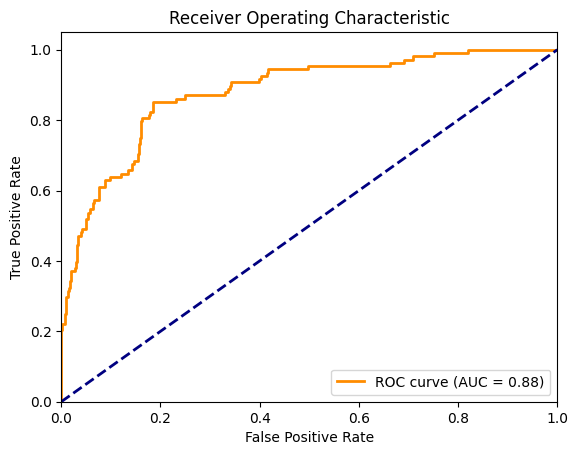

In [ ]:
# Calcular probabilidades de predicción
y_pred_proba = model.predict(X_test)

# Calcular curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Imprimir AUC
print(f"AUC: {roc_auc}")

# Graficar curva ROC
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Resultados de Prueba

*   Accuracy: **67.4%**
*   Precision: **42.7%**
*   Sensitivity: **66.0%**
*   Specificity: **68.7%**
*   F1 Score para "0": **0.76**
*   F1 Score para "1": **0.52**


###### 5. **Modelo CNN**

In [ ]:
# Definir el modelo
model = Sequential()
model.add(Input(shape=(200, 2)))  # Definir explícitamente el tamaño de entrada
model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val_wrist_bar, y_val_wrist_bar))

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.7297 - loss: 0.5438 - val_accuracy: 0.8163 - val_loss: 0.4399
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7808 - loss: 0.4587 - val_accuracy: 0.8367 - val_loss: 0.4045
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8002 - loss: 0.4229 - val_accuracy: 0.8469 - val_loss: 0.3964
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8104 - loss: 0.4171 - val_accuracy: 0.8520 - val_loss: 0.3858
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8194 - loss: 0.3963 - val_accuracy: 0.8546 - val_loss: 0.3989
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8201 - loss: 0.4028 - val_accuracy: 0.8444 - val_loss: 0.3734
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8216 - loss: 0.3787 - val_accuracy: 0.8571 - val_loss: 0.3603
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8326 - loss: 0.3658 - val_accuracy: 0.8546 - val_loss

In [ ]:
# Evaluar el modelo en el conjunto de validación
y_val_pred_wrist_bar_cnn = model.predict(X_val_wrist_bar).ravel()  # Genera predicciones
y_val_pred_wrist_bar_cnn = (y_val_pred_wrist_bar_cnn > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_bar, y_val_pred_wrist_bar_cnn)
val_precision = precision_score(y_val_wrist_bar, y_val_pred_wrist_bar_cnn, average='binary')
val_recall = recall_score(y_val_wrist_bar, y_val_pred_wrist_bar_cnn, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_bar, y_val_pred_wrist_bar_cnn).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_bar, y_val_pred_wrist_bar_cnn)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_bar, y_val_pred_wrist_bar_cnn).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_bar, y_val_pred_wrist_bar_cnn))

# Guardar métricas de validación en un diccionario
res_val_wrist_bar_cnn = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Validation Accuracy: 0.8545918367346939
Validation Precision: 0.6727272727272727
Validation Sensitivity: 0.4868421052631579
Validation Specificity: 0.9430379746835443
Validation Balanced Accuracy: 0.7149400399733511

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91       316
           1       0.67      0.49      0.56        76

    accuracy                           0.85       392
   macro avg       0.78      0.71      0.74       392
weighted avg       0.84      0.85      0.85       392



In [ ]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred_wrist_bar_cnn = model.predict(X_test).ravel()  # Genera predicciones
y_test_pred_wrist_bar_cnn = (y_test_pred_wrist_bar_cnn > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias

# Cálculo de métricas
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_wrist_bar_cnn))
print("Test Precision:", precision_score(y_test, y_test_pred_wrist_bar_cnn, average='binary'))
print("Test Sensitivity (Recall):", recall_score(y_test, y_test_pred_wrist_bar_cnn, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_wrist_bar_cnn).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_wrist_bar_cnn))

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_wrist_bar_cnn))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Test Accuracy: 0.8312387791741472
Test Precision: 0.5897435897435898
Test Sensitivity (Recall): 0.42592592592592593
Test Specificity: 0.9287305122494433
Test Balanced Accuracy: 0.6773282190876846

Test Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90       449
           1       0.59      0.43      0.49       108

    accuracy                           0.83       557
   macro avg       0.73      0.68      0.70       557
weighted avg       0.82      0.83      0.82       557



Validación Cruzada K-Fold:

In [ ]:
# Definir el número de folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Inicializar listas para almacenar los resultados de cada fold
accuracy_per_fold = []
loss_per_fold = []
precision_per_fold = []
recall_per_fold = []
specificity_per_fold = []
f1_per_fold = []
balanced_accuracy_per_fold = []

# Iterar sobre cada fold
for train_index, val_index in kf.split(X_train):
    # Dividir los datos en entrenamiento y validación
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Definir el modelo (es importante definirlo dentro del loop para reiniciarlo en cada fold)
    model = Sequential()
    model.add(Input(shape=(200, 2)))  # Definir explícitamente el tamaño de entrada
    model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo en el fold actual
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)

    # Evaluar el modelo en el conjunto de validación del fold actual
    y_val_pred = model.predict(X_val_fold).ravel()
    y_val_pred = (y_val_pred > 0.5).astype(int)

    # Cálculo de métricas para el fold actual
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    loss = model.evaluate(X_val_fold, y_val_fold, verbose=0)[0]
    precision = precision_score(y_val_fold, y_val_pred)
    recall = recall_score(y_val_fold, y_val_pred)
    f1 = f1_score(y_val_fold, y_val_pred)
    cm = confusion_matrix(y_val_fold, y_val_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    balanced_accuracy = balanced_accuracy_score(y_val_fold, y_val_pred)

    # Almacenar las métricas para este fold
    accuracy_per_fold.append(accuracy)
    loss_per_fold.append(loss)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    specificity_per_fold.append(specificity)
    f1_per_fold.append(f1)
    balanced_accuracy_per_fold.append(balanced_accuracy)

# Mostrar resultados promedio de las métricas de k-fold
print(f'\nMean Accuracy (k-Fold): {np.mean(accuracy_per_fold)}')
print(f'Mean Loss (k-Fold): {np.mean(loss_per_fold)}')
print(f'Mean Precision (k-Fold): {np.mean(precision_per_fold)}')
print(f'Mean Recall (k-Fold): {np.mean(recall_per_fold)}')
print(f'Mean Specificity (k-Fold): {np.mean(specificity_per_fold)}')
print(f'Mean F1 Score (k-Fold): {np.mean(f1_per_fold)}')
print(f'Mean Balanced Accuracy (k-Fold): {np.mean(balanced_accuracy_per_fold)}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Mean Accuracy (k-Fold): 0.8293929712460064
Mean Loss (k-Fold): 0.37549062371253966
Mean Precision (k-Fold): 0.668417821627124
Mean Recall (k-Fold): 0.47019241118717847
Mean Specificity (k-Fold): 0.9288278156644857
Mean F1 Score (k-Fold): 0.5328849026702495
Mean Balanced Accuracy (k-Fold): 0.6995101134258321


**Mean Accuracy**:

**Mean Precision**:

**Mean Sensitivity**:

**Mean Specifity**:

**Mean F1 Score**:

###### 6. **Modelo SAE**

Padding y división de características:

In [ ]:
# Encuentra la longitud máxima de las secuencias en el conjunto de entrenamiento
max_length = df_train_wrist[feature_cols_bar].applymap(len).max().max()
print(f"Longitud máxima de secuencia: {max_length}")

Longitud máxima de secuencia: 200


<ipython-input-508-d30931d710b0>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = df_train_wrist[feature_cols_bar].applymap(len).max().max()


In [ ]:
# Crear un índice de validación a partir de la división de entrenamiento y validación
train_indices, val_indices = train_test_split(df_train_wrist.index, test_size=0.2, random_state=42)

# Crear los conjuntos de secuencias de entrenamiento y validación
df_train_wrist_train = df_train_wrist.loc[train_indices]
df_train_wrist_val = df_train_wrist.loc[val_indices]

In [ ]:
# Función para aplicar padding a las secuencias
def pad_sequences_feature(df, feature_cols_bar, max_length):
    padded_features = []
    for col in feature_cols_bar:
        padded_col = []
        for sequence in df[col]:
            sequence = np.array(sequence)  # Asegurarse de que la secuencia es un array numpy
            if sequence.ndim == 1:
                sequence = np.expand_dims(sequence, axis=-1)

            # No es necesario agregar dimensiones adicionales aquí, solo aseguramos que haya 2 columnas
            if sequence.shape[1] == 2:  # Confirma que las secuencias tienen solo 2 dimensiones (x, y)
                if len(sequence) < max_length:
                    # Realizar padding solo en la longitud de la secuencia
                    padded_sequence = np.pad(sequence, ((0, max_length - len(sequence)), (0, 0)), 'constant', constant_values=0)
                else:
                    padded_sequence = sequence[:max_length]
                padded_col.append(padded_sequence)
            else:
                print(f"Unexpected number of dimensions: {sequence.shape[1]}")
                raise ValueError(f"Las secuencias deben tener exactamente 2 dimensiones, pero se encontró {sequence.shape[1]}.")

        # Verificar que todas las secuencias tienen la misma forma
        shapes = [seq.shape for seq in padded_col]
        unique_shapes = set(shapes)
        if len(unique_shapes) > 1:
            print(f"Inconsistent shapes found in column {col}: {unique_shapes}")
            raise ValueError(f"Inconsistent shapes found in column {col}: {unique_shapes}")

        padded_features.append(np.stack(padded_col))
    return np.concatenate(padded_features, axis=2)

# Aplicar padding y preparar las características de entrenamiento
X_train = pad_sequences_feature(df_train_wrist_train, feature_cols_bar, max_length)
y_train = df_train_wrist_train[target_col].values

# Aplicar padding al conjunto de validación
X_val_wrist_bar = pad_sequences_feature(df_train_wrist_val, feature_cols_bar, max_length)
y_val_wrist_bar = df_train_wrist_val[target_col].values

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalizar las características del conjunto de validación
X_val_wrist_bar = scaler.transform(X_val_wrist_bar.reshape(-1, X_val_wrist_bar.shape[-1])).reshape(X_val_wrist_bar.shape)

# Preparar el conjunto de prueba
X_test = pad_sequences_feature(df_test_wrist, feature_cols_bar, max_length)
y_test = df_test_wrist[target_col].values
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")

Forma de X_train: (1565, 200, 2)
Forma de X_test: (557, 200, 2)


*  **1957 / 1321** son el número de muestras para el conjunto de entrenamiento y prueba, respectivamente.
*  **200** es la longitud de la ventana de tiempo (en muestras) para cada señal.
*  **2** representa el número de características por cada paso temporal. Cada paso temporal tiene 2 características (por ejemplo, las variables x y y extraídas de los datos de Bar).

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Configurar la semilla para la reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
# Parámetros
input_shape = (200, 2)  # Ajusta esto a la forma de tu entrada
kernel_size = 7
filters = [32, 64]  # Número de filtros en cada capa convolucional

# Definir la función de autoencoder
def build_autoencoder(input_shape, filters, kernel_size):
    input_layer = Input(shape=input_shape)

    # Encoder
    x = Conv1D(filters=filters[0], kernel_size=kernel_size, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)

    # Bottleneck
    bottleneck_shape = x.shape[1:]  # Obtiene la forma después de las capas convolucionales y de pooling
    x = Flatten()(x)
    bottleneck = Dense(128, activation='relu')(x)  # Puedes ajustar la dimensión del bottleneck

    # Decoder
    x = Dense(np.prod(bottleneck_shape), activation='relu')(bottleneck)
    x = Reshape(bottleneck_shape)(x)  # Redimensiona a la forma adecuada para las capas convolucionales de decodificación
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=input_shape[1], kernel_size=kernel_size, activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_layer, x)
    encoder = Model(input_layer, bottleneck)

    return autoencoder, encoder

# Construir el autoencoder
autoencoder, encoder = build_autoencoder(input_shape, filters, kernel_size)

# Compilar el autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenar el autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2)

# Extraer las características usando el encoder
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val_wrist_bar)
X_test_encoded = encoder.predict(X_test)

# Crear el clasificador denso
def build_classifier(input_shape):
    input_layer = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input_layer)
    x = Dense(32, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    classifier = Model(input_layer, output_layer)
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return classifier

# Construir el clasificador
classifier = build_classifier(X_train_encoded.shape[1:])

# Entrenar el clasificador
classifier.fit(X_train_encoded, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weights)

# Evaluar el clasificador
loss, accuracy = classifier.evaluate(X_test_encoded, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.9775 - val_loss: 0.6418
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6754 - val_loss: 0.6251
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6643 - val_loss: 0.6217
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6602 - val_loss: 0.6318
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6799 - val_loss: 0.6245
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6630 - val_loss: 0.6116
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6513 - val_loss: 0.6111
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6508 - val_loss: 0.6099
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6500 - val_loss: 0.6115
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6503 - val_loss: 0.6099
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3

In [ ]:
# Realizar predicciones
y_val_pred_wrist_bar_sae = (classifier.predict(X_val_encoded) > 0.5).astype(int).ravel()

# Cálculo de métricas en validación
val_accuracy = accuracy_score(y_val_wrist_bar, y_val_pred_wrist_bar_sae)
val_precision = precision_score(y_val_wrist_bar, y_val_pred_wrist_bar_sae, average='binary')
val_recall = recall_score(y_val_wrist_bar, y_val_pred_wrist_bar_sae, average='binary')
tn, fp, fn, tp = confusion_matrix(y_val_wrist_bar, y_val_pred_wrist_bar_sae).ravel()
val_specificity = tn / (tn + fp)
val_balanced_accuracy = balanced_accuracy_score(y_val_wrist_bar, y_val_pred_wrist_bar_sae)

# Imprimir métricas de validación
print("\nValidation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Sensitivity:", val_recall)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_bar, y_val_pred_wrist_bar_sae).ravel()
validation_specificity = tn / (tn + fp)
print("Validation Specificity:", val_specificity)
print("Validation Balanced Accuracy:", val_balanced_accuracy)

print("\nValidation Classification Report:\n", classification_report(y_val_wrist_bar, y_val_pred_wrist_bar_sae))

# Guardar métricas de validación en un diccionario
res_val_wrist_bar_sae = {
    "Validation Balanced Accuracy": val_balanced_accuracy,
    "Validation Precision": val_precision,
    "Validation Sensitivity": val_recall,
    "Validation Specificity": val_specificity,
}

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Validation Accuracy: 0.7627551020408163
Validation Precision: 0.43410852713178294
Validation Sensitivity: 0.7368421052631579
Validation Specificity: 0.7689873417721519
Validation Balanced Accuracy: 0.7529147235176549

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.77      0.84       316
           1       0.43      0.74      0.55        76

    accuracy                           0.76       392
   macro avg       0.68      0.75      0.69       392
weighted avg       0.83      0.76      0.78       392



In [ ]:
# Realizar predicciones
y_test_pred_wrist_bar_sae = (classifier.predict(X_test_encoded) > 0.5).astype(int).ravel()

# Cálculo de métricas
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_wrist_bar_sae))
print("Test Precision:", precision_score(y_test, y_test_pred_wrist_bar_sae, average='binary'))
print("Test Sensitivity:", recall_score(y_test, y_test_pred_wrist_bar_sae, average='binary'))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_wrist_bar_sae).ravel()
test_specificity = tn / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_wrist_bar_sae))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_wrist_bar_sae))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Test Accuracy: 0.77737881508079
Test Precision: 0.45555555555555555
Test Sensitivity: 0.7592592592592593
Test Specificity: 0.7817371937639198
Test Balanced Accuracy: 0.7704982265115896

Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.78      0.85       449
           1       0.46      0.76      0.57       108

    accuracy                           0.78       557
   macro avg       0.69      0.77      0.71       557
weighted avg       0.84      0.78      0.80       557



18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
AUC: 0.8226099150375319


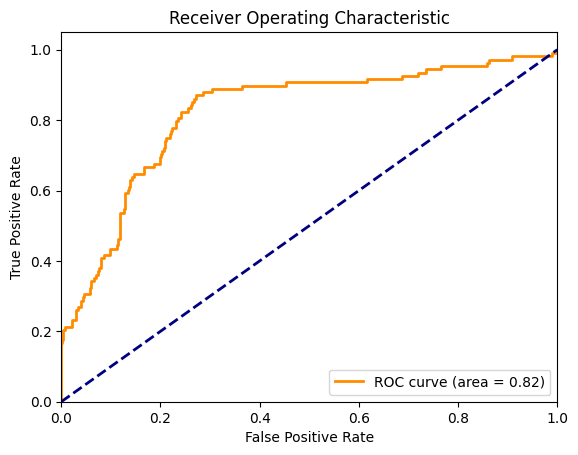

In [ ]:
# Realizar predicciones
y_pred_proba = classifier.predict(X_test_encoded)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Imprimir AUC
print(f"AUC: {roc_auc}")

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

AUC de 0.653

Resultados de Prueba

*   Accuracy: **63.7%**
*   Precision: **40.0%**
*   Sensitivity: **58.1%**
*   Specificity: **69.2%**
*   F1 Score para "0": **0.75**
*   F1 Score para "1": **0.47**

---
# Fusión por sensor
---

#### Dispositivo 1 (Cuello)

##### Acelerómetro (Acc)

Majority Voting:

In [ ]:
# Concatenar las predicciones de todos los modelos
all_predictions = np.vstack([
    y_val_pred_neck_acc_knn,
    y_val_pred_neck_acc_svm,
    y_val_pred_neck_acc_rf,
    y_val_pred_neck_acc_cnn,
    y_val_pred_neck_acc_sae,
]).T

# Aplicar voting por mayoría
y_val_pred_neck_acc_majority = mode(all_predictions, axis=1)[0].flatten()

# Evaluar el rendimiento del voting por mayoría
val_accuracy_majority = accuracy_score(y_val_neck_acc, y_val_pred_neck_acc_majority)
val_precision_majority = precision_score(y_val_neck_acc, y_val_pred_neck_acc_majority)
val_recall_majority = recall_score(y_val_neck_acc, y_val_pred_neck_acc_majority)
val_f1_majority = f1_score(y_val_neck_acc, y_val_pred_neck_acc_majority, pos_label=1)
tn, fp, fn, tp = confusion_matrix(y_val_neck_acc, y_val_pred_neck_acc_majority).ravel()
val_specificity_majority = tn / (tn + fp)
val_balanced_accuracy_majority = balanced_accuracy_score(y_val_neck_acc, y_val_pred_neck_acc_majority)

# Imprimir métricas
print("\nMajority Voting Metrics:")
print(f"Accuracy: {val_accuracy_majority}")
print(f"Precision: {val_precision_majority}")
print(f"Recall: {val_recall_majority}")
print(f"F1 Score (Falls '1'): {val_f1_majority}")
print(f"Specificity: {val_specificity_majority}")
print(f"Balanced Accuracy: {val_balanced_accuracy_majority}")


Majority Voting Metrics:
Accuracy: 0.9811320754716981
Precision: 0.9426229508196722
Recall: 1.0
F1 Score (Falls '1'): 0.9704641350210971
Specificity: 0.97265625
Balanced Accuracy: 0.986328125


In [ ]:
# Concatenar las predicciones de todos los modelos en el conjunto de test
all_predictions_test = np.vstack([
    y_test_pred_neck_acc_knn,
    y_test_pred_neck_acc_svm,
    y_test_pred_neck_acc_rf,
    y_test_pred_neck_acc_cnn,
    y_test_pred_neck_acc_sae,
]).T

# Aplicar voting por mayoría en el conjunto de test
y_test_pred_neck_acc_majority = mode(all_predictions_test, axis=1)[0].flatten()

# Evaluar el rendimiento del voting por mayoría en el conjunto de test
test_accuracy_majority = accuracy_score(y_test_neck_acc, y_test_pred_neck_acc_majority)
test_precision_majority = precision_score(y_test_neck_acc, y_test_pred_neck_acc_majority)
test_recall_majority = recall_score(y_test_neck_acc, y_test_pred_neck_acc_majority)
test_f1_majority = f1_score(y_test_neck_acc, y_test_pred_neck_acc_majority, pos_label=1)  # F1 para clase "1" (caídas)
tn, fp, fn, tp = confusion_matrix(y_test_neck_acc, y_test_pred_neck_acc_majority).ravel()
test_specificity_majority = tn / (tn + fp)
test_balanced_accuracy_majority = balanced_accuracy_score(y_test_neck_acc, y_test_pred_neck_acc_majority)

# Imprimir métricas del conjunto de test
print("\nTest Metrics for Majority Voting:")
print(f"Accuracy: {test_accuracy_majority}")
print(f"Precision: {test_precision_majority}")
print(f"Recall: {test_recall_majority}")
print(f"F1 Score (Falls '1'): {test_f1_majority}")
print(f"Specificity: {test_specificity_majority}")
print(f"Balanced Accuracy: {test_balanced_accuracy_majority}")


Test Metrics for Majority Voting:
Accuracy: 0.9817767653758542
Precision: 0.9854014598540146
Recall: 0.9574468085106383
F1 Score (Falls '1'): 0.9712230215827338
Specificity: 0.9932885906040269
Balanced Accuracy: 0.9753676995573326


In [ ]:
# Crear un DataFrame para almacenar las predicciones del conjunto de test
df_test_neck_acc_results = pd.DataFrame({
    'True_Label': y_test_neck_acc,  # Etiquetas verdaderas
    'kNN_Pred': y_test_pred_neck_acc_knn,  # Predicciones de kNN
    'SVM_Pred': y_test_pred_neck_acc_svm,  # Predicciones de SVM
    'RF_Pred': y_test_pred_neck_acc_rf,    # Predicciones de Random Forest
    'CNN_Pred': y_test_pred_neck_acc_cnn,   # Predicciones de CNN
    'SAE_Pred': y_test_pred_neck_acc_sae,   # Predicciones de SAE
})

# Aplicar el voto por mayoría a las predicciones
df_test_neck_acc_results['Majority_Vote'] = mode(df_test_neck_acc_results[['kNN_Pred', 'SVM_Pred', 'RF_Pred', 'CNN_Pred']], axis=1)[0].flatten()

# Mostrar las primeras filas para inspección
print(df_test_neck_acc_results.head())

      True_Label  kNN_Pred  SVM_Pred  RF_Pred  CNN_Pred  SAE_Pred  \
3219           0         0         0        0         0         0   
3304           1         1         1        1         1         1   
2900           1         1         1        1         1         1   
4012           0         0         0        0         0         0   
3437           0         0         0        0         0         0   

      Majority_Vote  
3219              0  
3304              1  
2900              1  
4012              0  
3437              0  


In [ ]:
# Definir los índices que te interesa verificar
indices_a_verificar = [3219, 3304, 2900, 4012, 3437]

# Verificar los valores de esas filas en el DataFrame original del conjunto de test
df_test_neck.loc[indices_a_verificar]

,SubjectID,Device,ActivityID,TrialNo,Acc,Gyr,Mag,Bar,Acc_Vectores,Gyr_Vectores,Mag_Vectores,Bar_Vectores,ActivityType,PreFallStatus,ReasonOfFall,FallDirection,WithRotation,WithRecovery
3219,8,Neck,25,1,"[[12546, -3027, -5091], [11272, -3057, -4121],...","[[540, 5105, -511], [-122, 4674, -660], [-1022...","[[3710, 1765, 1599], [3711, 1751, 1547], [3694...","[[1009.52770201859, 25.07446537017822], [1009....",4760,4760,1600,200,0,,,,,
3304,8,Neck,123,1,"[[1920, -476, -3], [1747, -318, 62], [1532, -2...","[[323, -321, -36], [292, -361, -37], [251, -39...","[[3774, 1633, 889], [3782, 1636, 909], [3777, ...","[[1010.642078611085, 27.92364187240601], [1010...",4760,4760,1600,200,1,jogging,slipping,forward,no,no
2900,7,Neck,101,2,"[[5538, 371, -716], [5417, 394, -339], [5212, ...","[[23, 54, 233], [21, 12, 217], [6, -85, 197], ...","[[3953, 989, -614], [3934, 992, -627], [3904, ...","[[1012.106440329994, 26.8323091173172], [1012....",4760,4760,1600,200,1,walking,stumbling/tripping,forward,no,no
4012,10,Neck,28,1,"[[3637, -990, -791], [3817, -903, -748], [4010...","[[-407, 68, 113], [-381, 125, 124], [-359, 181...","[[4004, -688, 1608], [4007, -698, 1619], [4021...","[[1025.581558352037, 29.17982079982757], [1025...",4760,4760,1600,200,0,,,,,
3437,9,Neck,13,4,"[[3857, 1122, -1508], [3823, 983, -1484], [378...","[[223, 193, -44], [331, 246, -76], [431, 299, ...","[[3790, -811, 2534], [3810, -853, 2449], [3772...","[[1009.633829332016, 28.99514199256897], [1009...",4760,4760,1600,200,0,,,,,


##### Giroscopio (Gyr)

Majority Voting:

In [ ]:
# Concatenar las predicciones de todos los modelos
all_predictions = np.vstack([
    y_val_pred_neck_gyr_svm,
    y_val_pred_neck_gyr_rf,
    y_val_pred_neck_gyr_cnn,
]).T

# Aplicar voting por mayoría
y_val_pred_neck_gyr_majority = mode(all_predictions, axis=1)[0].flatten()

# Evaluar el rendimiento del voting por mayoría
val_accuracy_majority = accuracy_score(y_val_neck_gyr, y_val_pred_neck_gyr_majority)
val_precision_majority = precision_score(y_val_neck_gyr, y_val_pred_neck_gyr_majority)
val_recall_majority = recall_score(y_val_neck_gyr, y_val_pred_neck_gyr_majority)
val_f1_majority = f1_score(y_val_neck_gyr, y_val_pred_neck_gyr_majority, pos_label=1)
tn, fp, fn, tp = confusion_matrix(y_val_neck_gyr, y_val_pred_neck_gyr_majority).ravel()
val_specificity_majority = tn / (tn + fp)
val_balanced_accuracy_majority = balanced_accuracy_score(y_val_neck_gyr, y_val_pred_neck_gyr_majority)

# Imprimir métricas
print("\nMajority Voting Metrics:")
print(f"Accuracy: {val_accuracy_majority}")
print(f"Precision: {val_precision_majority}")
print(f"Recall: {val_recall_majority}")
print(f"F1 Score (Falls '1'): {val_f1_majority}")
print(f"Specificity: {val_specificity_majority}")
print(f"Balanced Accuracy: {val_balanced_accuracy_majority}")


Majority Voting Metrics:
Accuracy: 0.9380053908355795
Precision: 0.8833333333333333
Recall: 0.9217391304347826
F1 Score (Falls '1'): 0.902127659574468
Specificity: 0.9453125
Balanced Accuracy: 0.9335258152173913


In [ ]:
# Concatenar las predicciones de todos los modelos en el conjunto de test
all_predictions_test = np.vstack([
    y_test_pred_neck_gyr_svm,
    y_test_pred_neck_gyr_rf,
    y_test_pred_neck_gyr_cnn,
]).T

# Aplicar voting por mayoría en el conjunto de test
y_test_pred_neck_gyr_majority = mode(all_predictions_test, axis=1)[0].flatten()

# Evaluar el rendimiento del voting por mayoría en el conjunto de test
test_accuracy_majority = accuracy_score(y_test_neck_gyr, y_test_pred_neck_gyr_majority)
test_precision_majority = precision_score(y_test_neck_gyr, y_test_pred_neck_gyr_majority)
test_recall_majority = recall_score(y_test_neck_gyr, y_test_pred_neck_gyr_majority)
test_f1_majority = f1_score(y_test_neck_gyr, y_test_pred_neck_gyr_majority, pos_label=1)  # F1 para clase "1" (caídas)
tn, fp, fn, tp = confusion_matrix(y_test_neck_gyr, y_test_pred_neck_gyr_majority).ravel()
test_specificity_majority = tn / (tn + fp)
test_balanced_accuracy_majority = balanced_accuracy_score(y_test_neck_gyr, y_test_pred_neck_gyr_majority)

# Imprimir métricas del conjunto de test
print("\nTest Metrics for Majority Voting:")
print(f"Accuracy: {test_accuracy_majority}")
print(f"Precision: {test_precision_majority}")
print(f"Recall: {test_recall_majority}")
print(f"F1 Score (Falls '1'): {test_f1_majority}")
print(f"Specificity: {test_specificity_majority}")
print(f"Balanced Accuracy: {test_balanced_accuracy_majority}")


Test Metrics for Majority Voting:
Accuracy: 0.9202733485193622
Precision: 0.8732394366197183
Recall: 0.8794326241134752
F1 Score (Falls '1'): 0.8763250883392226
Specificity: 0.9395973154362416
Balanced Accuracy: 0.9095149697748584


In [ ]:
# Crear un DataFrame para almacenar las predicciones del conjunto de test
df_test_neck_gyr_results = pd.DataFrame({
    'True_Label': y_test_neck_gyr,  # Etiquetas verdaderas
    'SVM_Pred': y_test_pred_neck_gyr_svm,  # Predicciones de SVM
    'RF_Pred': y_test_pred_neck_gyr_rf,    # Predicciones de Random Forest
    'CNN_Pred': y_test_pred_neck_gyr_cnn,   # Predicciones de CNN
})

# Aplicar el voto por mayoría a las predicciones
df_test_neck_gyr_results['Majority_Vote'] = mode(df_test_neck_gyr_results[['SVM_Pred', 'RF_Pred', 'CNN_Pred']], axis=1)[0].flatten()

# Mostrar las primeras filas para inspección
print(df_test_neck_gyr_results.head())

In [ ]:
# Definir los índices que te interesa verificar
indices_a_verificar = [3219, 3304, 2900, 4012, 3437]

# Verificar los valores de esas filas en el DataFrame original del conjunto de test
df_test_neck.loc[indices_a_verificar]

,SubjectID,Device,ActivityID,TrialNo,Acc,Gyr,Mag,Bar,Acc_Vectores,Gyr_Vectores,Mag_Vectores,Bar_Vectores,ActivityType,PreFallStatus,ReasonOfFall,FallDirection,WithRotation,WithRecovery
3219,8,Neck,25,1,"[[12546, -3027, -5091], [11272, -3057, -4121],...","[[540, 5105, -511], [-122, 4674, -660], [-1022...","[[3710, 1765, 1599], [3711, 1751, 1547], [3694...","[[1009.52770201859, 25.07446537017822], [1009....",4760,4760,1600,200,0,,,,,
3304,8,Neck,123,1,"[[1920, -476, -3], [1747, -318, 62], [1532, -2...","[[323, -321, -36], [292, -361, -37], [251, -39...","[[3774, 1633, 889], [3782, 1636, 909], [3777, ...","[[1010.642078611085, 27.92364187240601], [1010...",4760,4760,1600,200,1,jogging,slipping,forward,no,no
2900,7,Neck,101,2,"[[5538, 371, -716], [5417, 394, -339], [5212, ...","[[23, 54, 233], [21, 12, 217], [6, -85, 197], ...","[[3953, 989, -614], [3934, 992, -627], [3904, ...","[[1012.106440329994, 26.8323091173172], [1012....",4760,4760,1600,200,1,walking,stumbling/tripping,forward,no,no
4012,10,Neck,28,1,"[[3637, -990, -791], [3817, -903, -748], [4010...","[[-407, 68, 113], [-381, 125, 124], [-359, 181...","[[4004, -688, 1608], [4007, -698, 1619], [4021...","[[1025.581558352037, 29.17982079982757], [1025...",4760,4760,1600,200,0,,,,,
3437,9,Neck,13,4,"[[3857, 1122, -1508], [3823, 983, -1484], [378...","[[223, 193, -44], [331, 246, -76], [431, 299, ...","[[3790, -811, 2534], [3810, -853, 2449], [3772...","[[1009.633829332016, 28.99514199256897], [1009...",4760,4760,1600,200,0,,,,,


##### Magnetómetro (Mag)

Majority Voting:

In [ ]:
# Concatenar las predicciones de todos los modelos
all_predictions = np.vstack([
    y_val_pred_neck_mag_knn,
    y_val_pred_neck_mag_svm,
    y_val_pred_neck_mag_rf,
    y_val_pred_neck_mag_cnn,
    y_val_pred_neck_mag_sae,
]).T

# Aplicar voting por mayoría
y_val_pred_neck_mag_majority = mode(all_predictions, axis=1)[0].flatten()

# Evaluar el rendimiento del voting por mayoría
val_accuracy_majority = accuracy_score(y_val_neck_mag, y_val_pred_neck_mag_majority)
val_precision_majority = precision_score(y_val_neck_mag, y_val_pred_neck_mag_majority)
val_recall_majority = recall_score(y_val_neck_mag, y_val_pred_neck_mag_majority)
val_f1_majority = f1_score(y_val_neck_mag, y_val_pred_neck_mag_majority, pos_label=1)
tn, fp, fn, tp = confusion_matrix(y_val_neck_mag, y_val_pred_neck_mag_majority).ravel()
val_specificity_majority = tn / (tn + fp)
val_balanced_accuracy_majority = balanced_accuracy_score(y_val_neck_mag, y_val_pred_neck_mag_majority)

# Imprimir métricas
print("\nMajority Voting Metrics:")
print(f"Accuracy: {val_accuracy_majority}")
print(f"Precision: {val_precision_majority}")
print(f"Recall: {val_recall_majority}")
print(f"F1 Score (Falls '1'): {val_f1_majority}")
print(f"Specificity: {val_specificity_majority}")
print(f"Balanced Accuracy: {val_balanced_accuracy_majority}")


Majority Voting Metrics:
Accuracy: 0.9164420485175202
Precision: 0.8387096774193549
Recall: 0.9043478260869565
F1 Score (Falls '1'): 0.8702928870292888
Specificity: 0.921875
Balanced Accuracy: 0.9131114130434783


In [ ]:
# Concatenar las predicciones de todos los modelos en el conjunto de test
all_predictions_test = np.vstack([
    y_test_pred_neck_mag_knn,
    y_test_pred_neck_mag_svm,
    y_test_pred_neck_mag_rf,
    y_test_pred_neck_mag_cnn,
    y_test_pred_neck_mag_sae,
]).T

# Aplicar voting por mayoría en el conjunto de test
y_test_pred_neck_mag_majority = mode(all_predictions_test, axis=1)[0].flatten()

# Evaluar el rendimiento del voting por mayoría en el conjunto de test
test_accuracy_majority = accuracy_score(y_test_neck_mag, y_test_pred_neck_mag_majority)
test_precision_majority = precision_score(y_test_neck_mag, y_test_pred_neck_mag_majority)
test_recall_majority = recall_score(y_test_neck_mag, y_test_pred_neck_mag_majority)
test_f1_majority = f1_score(y_test_neck_mag, y_test_pred_neck_mag_majority, pos_label=1)  # F1 para clase "1" (caídas)
tn, fp, fn, tp = confusion_matrix(y_test_neck_mag, y_test_pred_neck_mag_majority).ravel()
test_specificity_majority = tn / (tn + fp)
test_balanced_accuracy_majority = balanced_accuracy_score(y_test_neck_mag, y_test_pred_neck_mag_majority)

# Imprimir métricas del conjunto de test
print("\nTest Metrics for Majority Voting:")
print(f"Accuracy: {test_accuracy_majority}")
print(f"Precision: {test_precision_majority}")
print(f"Recall: {test_recall_majority}")
print(f"F1 Score (Falls '1'): {test_f1_majority}")
print(f"Specificity: {test_specificity_majority}")
print(f"Balanced Accuracy: {test_balanced_accuracy_majority}")


Test Metrics for Majority Voting:
Accuracy: 0.9202733485193622
Precision: 0.8732394366197183
Recall: 0.8794326241134752
F1 Score (Falls '1'): 0.8763250883392226
Specificity: 0.9395973154362416
Balanced Accuracy: 0.9095149697748584


In [ ]:
# Crear un DataFrame para almacenar las predicciones del conjunto de test
df_test_neck_mag_results = pd.DataFrame({
    'True_Label': y_test_neck_mag,  # Etiquetas verdaderas
    'kNN_Pred': y_test_pred_neck_mag_knn,  # Predicciones de kNN
    'SVM_Pred': y_test_pred_neck_mag_svm,  # Predicciones de SVM
    'RF_Pred': y_test_pred_neck_mag_rf,    # Predicciones de Random Forest
    'CNN_Pred': y_test_pred_neck_mag_cnn,   # Predicciones de CNN
    'SAE_Pred': y_test_pred_neck_mag_sae,   # Predicciones de SAE
})

# Aplicar el voto por mayoría a las predicciones
df_test_neck_mag_results['Majority_Vote'] = mode(df_test_neck_mag_results[['kNN_Pred', 'SVM_Pred', 'RF_Pred', 'CNN_Pred', 'SAE_Pred']], axis=1)[0].flatten()

# Mostrar las primeras filas para inspección
print(df_test_neck_mag_results.head())

      True_Label  kNN_Pred  SVM_Pred  RF_Pred  CNN_Pred  SAE_Pred  \
3219           0         0         0        0         0         0   
3304           1         1         1        1         1         1   
2900           1         1         1        1         1         1   
4012           0         0         0        0         0         0   
3437           0         0         0        0         0         0   

      Majority_Vote  
3219              0  
3304              1  
2900              1  
4012              0  
3437              0  


In [ ]:
# Definir los índices que te interesa verificar
indices_a_verificar = [3219, 3304, 2900, 4012, 3437]

# Verificar los valores de esas filas en el DataFrame original del conjunto de test
df_test_neck.loc[indices_a_verificar]

,SubjectID,Device,ActivityID,TrialNo,Acc,Gyr,Mag,Bar,Acc_Vectores,Gyr_Vectores,Mag_Vectores,Bar_Vectores,ActivityType,PreFallStatus,ReasonOfFall,FallDirection,WithRotation,WithRecovery
3219,8,Neck,25,1,"[[12546, -3027, -5091], [11272, -3057, -4121],...","[[540, 5105, -511], [-122, 4674, -660], [-1022...","[[3710, 1765, 1599], [3711, 1751, 1547], [3694...","[[1009.52770201859, 25.07446537017822], [1009....",4760,4760,1600,200,0,,,,,
3304,8,Neck,123,1,"[[1920, -476, -3], [1747, -318, 62], [1532, -2...","[[323, -321, -36], [292, -361, -37], [251, -39...","[[3774, 1633, 889], [3782, 1636, 909], [3777, ...","[[1010.642078611085, 27.92364187240601], [1010...",4760,4760,1600,200,1,jogging,slipping,forward,no,no
2900,7,Neck,101,2,"[[5538, 371, -716], [5417, 394, -339], [5212, ...","[[23, 54, 233], [21, 12, 217], [6, -85, 197], ...","[[3953, 989, -614], [3934, 992, -627], [3904, ...","[[1012.106440329994, 26.8323091173172], [1012....",4760,4760,1600,200,1,walking,stumbling/tripping,forward,no,no
4012,10,Neck,28,1,"[[3637, -990, -791], [3817, -903, -748], [4010...","[[-407, 68, 113], [-381, 125, 124], [-359, 181...","[[4004, -688, 1608], [4007, -698, 1619], [4021...","[[1025.581558352037, 29.17982079982757], [1025...",4760,4760,1600,200,0,,,,,
3437,9,Neck,13,4,"[[3857, 1122, -1508], [3823, 983, -1484], [378...","[[223, 193, -44], [331, 246, -76], [431, 299, ...","[[3790, -811, 2534], [3810, -853, 2449], [3772...","[[1009.633829332016, 28.99514199256897], [1009...",4760,4760,1600,200,0,,,,,


##### Barómetro (Bar)

Majority Voting:

In [ ]:
# Concatenar las predicciones de todos los modelos
all_predictions = np.vstack([
    y_val_pred_neck_bar_knn,
    y_val_pred_neck_bar_svm,
    y_val_pred_neck_bar_rf,
]).T

# Aplicar voting por mayoría
y_val_pred_neck_bar_majority = mode(all_predictions, axis=1)[0].flatten()

# Evaluar el rendimiento del voting por mayoría
val_accuracy_majority = accuracy_score(y_val_neck_bar, y_val_pred_neck_bar_majority)
val_precision_majority = precision_score(y_val_neck_bar, y_val_pred_neck_bar_majority)
val_recall_majority = recall_score(y_val_neck_bar, y_val_pred_neck_bar_majority)
val_f1_majority = f1_score(y_val_neck_bar, y_val_pred_neck_bar_majority, pos_label=1)
tn, fp, fn, tp = confusion_matrix(y_val_neck_bar, y_val_pred_neck_bar_majority).ravel()
val_specificity_majority = tn / (tn + fp)
val_balanced_accuracy_majority = balanced_accuracy_score(y_val_neck_bar, y_val_pred_neck_bar_majority)

# Imprimir métricas
print("\nMajority Voting Metrics:")
print(f"Accuracy: {val_accuracy_majority}")
print(f"Precision: {val_precision_majority}")
print(f"Recall: {val_recall_majority}")
print(f"F1 Score (Falls '1'): {val_f1_majority}")
print(f"Specificity: {val_specificity_majority}")
print(f"Balanced Accuracy: {val_balanced_accuracy_majority}")

In [ ]:
# Concatenar las predicciones de todos los modelos en el conjunto de test
all_predictions_test = np.vstack([
    y_test_pred_neck_bar_knn,
    y_test_pred_neck_bar_svm,
    y_test_pred_neck_bar_rf,
]).T

# Aplicar voting por mayoría en el conjunto de test
y_test_pred_neck_bar_majority = mode(all_predictions_test, axis=1)[0].flatten()

# Evaluar el rendimiento del voting por mayoría en el conjunto de test
test_accuracy_majority = accuracy_score(y_test_neck_bar, y_test_pred_neck_bar_majority)
test_precision_majority = precision_score(y_test_neck_bar, y_test_pred_neck_bar_majority)
test_recall_majority = recall_score(y_test_neck_bar, y_test_pred_neck_bar_majority)
test_f1_majority = f1_score(y_test_neck_bar, y_test_pred_neck_bar_majority, pos_label=1)  # F1 para clase "1" (caídas)
tn, fp, fn, tp = confusion_matrix(y_test_neck_bar, y_test_pred_neck_bar_majority).ravel()
test_specificity_majority = tn / (tn + fp)
test_balanced_accuracy_majority = balanced_accuracy_score(y_test_neck_bar, y_test_pred_neck_bar_majority)

# Imprimir métricas del conjunto de test
print("\nTest Metrics for Majority Voting:")
print(f"Accuracy: {test_accuracy_majority}")
print(f"Precision: {test_precision_majority}")
print(f"Recall: {test_recall_majority}")
print(f"F1 Score (Falls '1'): {test_f1_majority}")
print(f"Specificity: {test_specificity_majority}")
print(f"Balanced Accuracy: {test_balanced_accuracy_majority}")

In [ ]:
# Crear un DataFrame para almacenar las predicciones del conjunto de test
df_test_neck_bar_results = pd.DataFrame({
    'True_Label': y_test_neck_bar,  # Etiquetas verdaderas
    'kNN_Pred': y_test_pred_neck_bar_knn,  # Predicciones de kNN
    'SVM_Pred': y_test_pred_neck_bar_svm,  # Predicciones de SVM
    'RF_Pred': y_test_pred_neck_bar_rf,    # Predicciones de Random Forest
})

# Aplicar el voto por mayoría a las predicciones
df_test_neck_bar_results['Majority_Vote'] = mode(df_test_neck_bar_results[['kNN_Pred', 'SVM_Pred', 'RF_Pred']], axis=1)[0].flatten()

# Mostrar las primeras filas para inspección
print(df_test_neck_bar_results.head())

In [ ]:
# Definir los índices que te interesa verificar
indices_a_verificar = [3219, 3304, 2900, 4012, 3437]

# Verificar los valores de esas filas en el DataFrame original del conjunto de test
df_test_neck.loc[indices_a_verificar]

#### Dispositivo 2 (Cintura)

##### Acelerómetro (Acc)

Majority Voting:

In [ ]:
# Concatenar las predicciones de todos los modelos
all_predictions = np.vstack([
    y_val_pred_waist_acc_svm,
    y_val_pred_waist_acc_rf,
    y_val_pred_waist_acc_cnn,
]).T

# Aplicar voting por mayoría
y_val_pred_waist_acc_majority = mode(all_predictions, axis=1)[0].flatten()

# Evaluar el rendimiento del voting por mayoría
val_accuracy_majority = accuracy_score(y_val_waist_acc, y_val_pred_waist_acc_majority)
val_precision_majority = precision_score(y_val_waist_acc, y_val_pred_waist_acc_majority)
val_recall_majority = recall_score(y_val_waist_acc, y_val_pred_waist_acc_majority)
val_f1_majority = f1_score(y_val_waist_acc, y_val_pred_waist_acc_majority, pos_label=1)
tn, fp, fn, tp = confusion_matrix(y_val_waist_acc, y_val_pred_waist_acc_majority).ravel()
val_specificity_majority = tn / (tn + fp)
val_balanced_accuracy_majority = balanced_accuracy_score(y_val_waist_acc, y_val_pred_waist_acc_majority)

# Imprimir métricas
print("\nMajority Voting Metrics:")
print(f"Accuracy: {val_accuracy_majority}")
print(f"Precision: {val_precision_majority}")
print(f"Recall: {val_recall_majority}")
print(f"F1 Score (Falls '1'): {val_f1_majority}")
print(f"Specificity: {val_specificity_majority}")
print(f"Balanced Accuracy: {val_balanced_accuracy_majority}")


Majority Voting Metrics:
Accuracy: 0.9728813559322034
Precision: 0.9761904761904762
Recall: 0.9318181818181818
F1 Score (Falls '1'): 0.9534883720930233
Specificity: 0.9903381642512077
Balanced Accuracy: 0.9610781730346947


In [ ]:
# Concatenar las predicciones de todos los modelos en el conjunto de test
all_predictions_test = np.vstack([
    y_test_pred_waist_acc_svm,
    y_test_pred_waist_acc_rf,
    y_test_pred_waist_acc_cnn,
]).T

# Aplicar voting por mayoría en el conjunto de test
y_test_pred_waist_acc_majority = mode(all_predictions_test, axis=1)[0].flatten()

# Evaluar el rendimiento del voting por mayoría en el conjunto de test
test_accuracy_majority = accuracy_score(y_test_waist_acc, y_test_pred_waist_acc_majority)
test_precision_majority = precision_score(y_test_waist_acc, y_test_pred_waist_acc_majority)
test_recall_majority = recall_score(y_test_waist_acc, y_test_pred_waist_acc_majority)
test_f1_majority = f1_score(y_test_waist_acc, y_test_pred_waist_acc_majority, pos_label=1)  # F1 para clase "1" (caídas)
tn, fp, fn, tp = confusion_matrix(y_test_waist_acc, y_test_pred_waist_acc_majority).ravel()
test_specificity_majority = tn / (tn + fp)
test_balanced_accuracy_majority = balanced_accuracy_score(y_test_waist_acc, y_test_pred_waist_acc_majority)

# Imprimir métricas del conjunto de test
print("\nTest Metrics for Majority Voting:")
print(f"Accuracy: {test_accuracy_majority}")
print(f"Precision: {test_precision_majority}")
print(f"Recall: {test_recall_majority}")
print(f"F1 Score (Falls '1'): {test_f1_majority}")
print(f"Specificity: {test_specificity_majority}")
print(f"Balanced Accuracy: {test_balanced_accuracy_majority}")

In [ ]:
# Crear un DataFrame para almacenar las predicciones del conjunto de test
df_test_waist_acc_results = pd.DataFrame({
    'True_Label': y_test_waist_acc,  # Etiquetas verdaderas
    'SVM_Pred': y_test_pred_waist_acc_svm,  # Predicciones de SVM
    'RF_Pred': y_test_pred_waist_acc_rf,    # Predicciones de Random Forest
    'CNN_Pred': y_test_pred_waist_acc_cnn,   # Predicciones de CNN
})

# Aplicar el voto por mayoría a las predicciones
df_test_waist_acc_results['Majority_Vote'] = mode(df_test_waist_acc_results[['SVM_Pred', 'RF_Pred', 'CNN_Pred']], axis=1)[0].flatten()

# Mostrar las primeras filas para inspección
print(df_test_waist_acc_results.head())

In [ ]:
# Definir los índices que te interesa verificar
indices_a_verificar = [487, 6574, 4643, 1991, 1608]

# Verificar los valores de esas filas en el DataFrame original del conjunto de test
df_test_waist.loc[indices_a_verificar]

##### Giroscopio (Gyr)

Majority Voting:

In [ ]:
# Concatenar las predicciones de todos los modelos
all_predictions = np.vstack([
    y_val_pred_waist_gyr_svm,
    y_val_pred_waist_gyr_rf,
    y_val_pred_waist_gyr_cnn,
]).T

# Aplicar voting por mayoría
y_val_pred_waist_gyr_majority = mode(all_predictions, axis=1)[0].flatten()

# Evaluar el rendimiento del voting por mayoría
val_accuracy_majority = accuracy_score(y_val_waist_gyr, y_val_pred_waist_gyr_majority)
val_precision_majority = precision_score(y_val_waist_gyr, y_val_pred_waist_gyr_majority)
val_recall_majority = recall_score(y_val_waist_gyr, y_val_pred_waist_gyr_majority)
val_f1_majority = f1_score(y_val_waist_gyr, y_val_pred_waist_gyr_majority, pos_label=1)
tn, fp, fn, tp = confusion_matrix(y_val_waist_gyr, y_val_pred_waist_gyr_majority).ravel()
val_specificity_majority = tn / (tn + fp)
val_balanced_accuracy_majority = balanced_accuracy_score(y_val_waist_gyr, y_val_pred_waist_gyr_majority)

# Imprimir métricas
print("\nMajority Voting Metrics:")
print(f"Accuracy: {val_accuracy_majority}")
print(f"Precision: {val_precision_majority}")
print(f"Recall: {val_recall_majority}")
print(f"F1 Score (Falls '1'): {val_f1_majority}")
print(f"Specificity: {val_specificity_majority}")
print(f"Balanced Accuracy: {val_balanced_accuracy_majority}")

In [ ]:
# Concatenar las predicciones de todos los modelos en el conjunto de test
all_predictions_test = np.vstack([
    y_test_pred_waist_gyr_svm,
    y_test_pred_waist_gyr_rf,
    y_test_pred_waist_gyr_cnn,
]).T

# Aplicar voting por mayoría en el conjunto de test
y_test_pred_waist_gyr_majority = mode(all_predictions_test, axis=1)[0].flatten()

# Evaluar el rendimiento del voting por mayoría en el conjunto de test
test_accuracy_majority = accuracy_score(y_test_waist_gyr, y_test_pred_waist_gyr_majority)
test_precision_majority = precision_score(y_test_waist_gyr, y_test_pred_waist_gyr_majority)
test_recall_majority = recall_score(y_test_waist_gyr, y_test_pred_waist_gyr_majority)
test_f1_majority = f1_score(y_test_waist_gyr, y_test_pred_waist_gyr_majority, pos_label=1)  # F1 para clase "1" (caídas)
tn, fp, fn, tp = confusion_matrix(y_test_waist_gyr, y_test_pred_waist_gyr_majority).ravel()
test_specificity_majority = tn / (tn + fp)
test_balanced_accuracy_majority = balanced_accuracy_score(y_test_waist_gyr, y_test_pred_waist_gyr_majority)

# Imprimir métricas del conjunto de test
print("\nTest Metrics for Majority Voting:")
print(f"Accuracy: {test_accuracy_majority}")
print(f"Precision: {test_precision_majority}")
print(f"Recall: {test_recall_majority}")
print(f"F1 Score (Falls '1'): {test_f1_majority}")
print(f"Specificity: {test_specificity_majority}")
print(f"Balanced Accuracy: {test_balanced_accuracy_majority}")

In [ ]:
# Crear un DataFrame para almacenar las predicciones del conjunto de test
df_test_waist_gyr_results = pd.DataFrame({
    'True_Label': y_test_waist_gyr,  # Etiquetas verdaderas
    'SVM_Pred': y_test_pred_waist_gyr_svm,  # Predicciones de SVM
    'RF_Pred': y_test_pred_waist_gyr_rf,    # Predicciones de Random Forest
    'CNN_Pred': y_test_pred_waist_gyr_cnn,   # Predicciones de CNN
})

# Aplicar el voto por mayoría a las predicciones
df_test_waist_gyr_results['Majority_Vote'] = mode(df_test_waist_gyr_results[['SVM_Pred', 'RF_Pred', 'CNN_Pred']], axis=1)[0].flatten()

# Mostrar las primeras filas para inspección
print(df_test_waist_gyr_results.head())

In [ ]:
# Definir los índices que te interesa verificar
indices_a_verificar = [487, 6574, 4643, 1991, 1608]

# Verificar los valores de esas filas en el DataFrame original del conjunto de test
df_test_waist.loc[indices_a_verificar]

##### Magnetómetro (Mag)

Majority Voting:

In [ ]:
# Concatenar las predicciones de todos los modelos
all_predictions = np.vstack([
    y_val_pred_waist_mag_knn,
    y_val_pred_waist_mag_svm,
    y_val_pred_waist_mag_rf,
    y_val_pred_waist_mag_cnn,
    y_val_pred_waist_mag_sae,
]).T

# Aplicar voting por mayoría
y_val_pred_waist_mag_majority = mode(all_predictions, axis=1)[0].flatten()

# Evaluar el rendimiento del voting por mayoría
val_accuracy_majority = accuracy_score(y_val_waist_mag, y_val_pred_waist_mag_majority)
val_precision_majority = precision_score(y_val_waist_mag, y_val_pred_waist_mag_majority)
val_recall_majority = recall_score(y_val_waist_mag, y_val_pred_waist_mag_majority)
val_f1_majority = f1_score(y_val_waist_mag, y_val_pred_waist_mag_majority, pos_label=1)
tn, fp, fn, tp = confusion_matrix(y_val_waist_mag, y_val_pred_waist_mag_majority).ravel()
val_specificity_majority = tn / (tn + fp)
val_balanced_accuracy_majority = balanced_accuracy_score(y_val_waist_mag, y_val_pred_waist_mag_majority)

# Imprimir métricas
print("\nMajority Voting Metrics:")
print(f"Accuracy: {val_accuracy_majority}")
print(f"Precision: {val_precision_majority}")
print(f"Recall: {val_recall_majority}")
print(f"F1 Score (Falls '1'): {val_f1_majority}")
print(f"Specificity: {val_specificity_majority}")
print(f"Balanced Accuracy: {val_balanced_accuracy_majority}")

In [ ]:
# Concatenar las predicciones de todos los modelos en el conjunto de test
all_predictions_test = np.vstack([
    y_test_pred_waist_mag_knn,
    y_test_pred_waist_mag_svm,
    y_test_pred_waist_mag_rf,
    y_test_pred_waist_mag_cnn,
    y_test_pred_waist_mag_sae,
]).T

# Aplicar voting por mayoría en el conjunto de test
y_test_pred_waist_mag_majority = mode(all_predictions_test, axis=1)[0].flatten()

# Evaluar el rendimiento del voting por mayoría en el conjunto de test
test_accuracy_majority = accuracy_score(y_test_waist_mag, y_test_pred_waist_mag_majority)
test_precision_majority = precision_score(y_test_waist_mag, y_test_pred_waist_mag_majority)
test_recall_majority = recall_score(y_test_waist_mag, y_test_pred_waist_mag_majority)
test_f1_majority = f1_score(y_test_waist_mag, y_test_pred_waist_mag_majority, pos_label=1)  # F1 para clase "1" (caídas)
tn, fp, fn, tp = confusion_matrix(y_test_waist_mag, y_test_pred_waist_mag_majority).ravel()
test_specificity_majority = tn / (tn + fp)
test_balanced_accuracy_majority = balanced_accuracy_score(y_test_waist_mag, y_test_pred_waist_mag_majority)

# Imprimir métricas del conjunto de test
print("\nTest Metrics for Majority Voting:")
print(f"Accuracy: {test_accuracy_majority}")
print(f"Precision: {test_precision_majority}")
print(f"Recall: {test_recall_majority}")
print(f"F1 Score (Falls '1'): {test_f1_majority}")
print(f"Specificity: {test_specificity_majority}")
print(f"Balanced Accuracy: {test_balanced_accuracy_majority}")

In [ ]:
# Crear un DataFrame para almacenar las predicciones del conjunto de test
df_test_waist_mag_results = pd.DataFrame({
    'True_Label': y_test_waist_mag,  # Etiquetas verdaderas
    'kNN_Pred': y_test_pred_waist_mag_knn,  # Predicciones de kNN
    'SVM_Pred': y_test_pred_waist_mag_svm,  # Predicciones de SVM
    'RF_Pred': y_test_pred_waist_mag_rf,    # Predicciones de Random Forest
    'CNN_Pred': y_test_pred_waist_mag_cnn,   # Predicciones de CNN
    'SAE_Pred': y_test_pred_waist_mag_sae,   # Predicciones de SAE
})

# Aplicar el voto por mayoría a las predicciones
df_test_waist_mag_results['Majority_Vote'] = mode(df_test_waist_mag_results[['kNN_Pred', 'SVM_Pred', 'RF_Pred', 'CNN_Pred', 'SAE_Pred']], axis=1)[0].flatten()

# Mostrar las primeras filas para inspección
print(df_test_waist_mag_results.head())

In [ ]:
# Definir los índices que te interesa verificar
indices_a_verificar = [487, 6574, 4643, 1991, 1608]

# Verificar los valores de esas filas en el DataFrame original del conjunto de test
df_test_waist.loc[indices_a_verificar]

##### Barómetro (Bar)

Majority Voting:

In [ ]:
# Concatenar las predicciones de todos los modelos
all_predictions = np.vstack([
    y_val_pred_waist_bar_rf,
]).T

# Aplicar voting por mayoría
y_val_pred_waist_bar_majority = mode(all_predictions, axis=1)[0].flatten()

# Evaluar el rendimiento del voting por mayoría
val_accuracy_majority = accuracy_score(y_val_waist_bar, y_val_pred_waist_bar_majority)
val_precision_majority = precision_score(y_val_waist_bar, y_val_pred_waist_bar_majority)
val_recall_majority = recall_score(y_val_waist_bar, y_val_pred_waist_bar_majority)
val_f1_majority = f1_score(y_val_waist_bar, y_val_pred_waist_bar_majority, pos_label=1)
tn, fp, fn, tp = confusion_matrix(y_val_waist_bar, y_val_pred_waist_bar_majority).ravel()
val_specificity_majority = tn / (tn + fp)
val_balanced_accuracy_majority = balanced_accuracy_score(y_val_waist_bar, y_val_pred_waist_bar_majority)

# Imprimir métricas
print("\nMajority Voting Metrics:")
print(f"Accuracy: {val_accuracy_majority}")
print(f"Precision: {val_precision_majority}")
print(f"Recall: {val_recall_majority}")
print(f"F1 Score (Falls '1'): {val_f1_majority}")
print(f"Specificity: {val_specificity_majority}")
print(f"Balanced Accuracy: {val_balanced_accuracy_majority}")

In [ ]:
# Concatenar las predicciones de todos los modelos en el conjunto de test
all_predictions_test = np.vstack([
    y_test_pred_waist_bar_rf,
]).T

# Aplicar voting por mayoría en el conjunto de test
y_test_pred_waist_bar_majority = mode(all_predictions_test, axis=1)[0].flatten()

# Evaluar el rendimiento del voting por mayoría en el conjunto de test
test_accuracy_majority = accuracy_score(y_test_waist_bar, y_test_pred_waist_bar_majority)
test_precision_majority = precision_score(y_test_waist_bar, y_test_pred_waist_bar_majority)
test_recall_majority = recall_score(y_test_waist_bar, y_test_pred_waist_bar_majority)
test_f1_majority = f1_score(y_test_waist_bar, y_test_pred_waist_bar_majority, pos_label=1)  # F1 para clase "1" (caídas)
tn, fp, fn, tp = confusion_matrix(y_test_waist_bar, y_test_pred_waist_bar_majority).ravel()
test_specificity_majority = tn / (tn + fp)
test_balanced_accuracy_majority = balanced_accuracy_score(y_test_waist_bar, y_test_pred_waist_bar_majority)

# Imprimir métricas del conjunto de test
print("\nTest Metrics for Majority Voting:")
print(f"Accuracy: {test_accuracy_majority}")
print(f"Precision: {test_precision_majority}")
print(f"Recall: {test_recall_majority}")
print(f"F1 Score (Falls '1'): {test_f1_majority}")
print(f"Specificity: {test_specificity_majority}")
print(f"Balanced Accuracy: {test_balanced_accuracy_majority}")

In [ ]:
# Crear un DataFrame para almacenar las predicciones del conjunto de test
df_test_waist_bar_results = pd.DataFrame({
    'True_Label': y_test_waist_bar,  # Etiquetas verdaderas
    'RF_Pred': y_test_pred_waist_bar_rf,    # Predicciones de Random Forest
})

# Aplicar el voto por mayoría a las predicciones
df_test_waist_bar_results['Majority_Vote'] = mode(df_test_waist_bar_results[['RF_Pred']], axis=1)[0].flatten()

# Mostrar las primeras filas para inspección
print(df_test_waist_bar_results.head())

In [ ]:
# Definir los índices que te interesa verificar
indices_a_verificar = [487, 6574, 4643, 1991, 1608]

# Verificar los valores de esas filas en el DataFrame original del conjunto de test
df_test_waist.loc[indices_a_verificar]

#### Dispositivo 3 (Muñeca)

##### Acelerómetro (Acc)

Majority Voting:

In [ ]:
# Concatenar las predicciones de todos los modelos
all_predictions = np.vstack([
    y_val_pred_wrist_acc_knn,
    y_val_pred_wrist_acc_svm,
    y_val_pred_wrist_acc_rf,
    y_val_pred_wrist_acc_cnn,
    y_val_pred_wrist_acc_sae,
]).T

# Aplicar voting por mayoría
y_val_pred_wrist_acc_majority = mode(all_predictions, axis=1)[0].flatten()

# Evaluar el rendimiento del voting por mayoría
val_accuracy_majority = accuracy_score(y_val_wrist_acc, y_val_pred_wrist_acc_majority)
val_precision_majority = precision_score(y_val_wrist_acc, y_val_pred_wrist_acc_majority)
val_recall_majority = recall_score(y_val_wrist_acc, y_val_pred_wrist_acc_majority)
val_f1_majority = f1_score(y_val_wrist_acc, y_val_pred_wrist_acc_majority, pos_label=1)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_acc, y_val_pred_wrist_acc_majority).ravel()
val_specificity_majority = tn / (tn + fp)
val_balanced_accuracy_majority = balanced_accuracy_score(y_val_wrist_acc, y_val_pred_wrist_acc_majority)

# Imprimir métricas
print("\nMajority Voting Metrics:")
print(f"Accuracy: {val_accuracy_majority}")
print(f"Precision: {val_precision_majority}")
print(f"Recall: {val_recall_majority}")
print(f"F1 Score (Falls '1'): {val_f1_majority}")
print(f"Specificity: {val_specificity_majority}")
print(f"Balanced Accuracy: {val_balanced_accuracy_majority}")


Majority Voting Metrics:
Accuracy: 0.9413265306122449
Precision: 0.9344262295081968
Recall: 0.75
F1 Score (Falls '1'): 0.8321167883211679
Specificity: 0.9873417721518988
Balanced Accuracy: 0.8686708860759493


In [ ]:
# Concatenar las predicciones de todos los modelos en el conjunto de test
all_predictions_test = np.vstack([
    y_test_pred_wrist_acc_knn,
    y_test_pred_wrist_acc_svm,
    y_test_pred_wrist_acc_rf,
    y_test_pred_wrist_acc_cnn,
    y_test_pred_wrist_acc_sae,
]).T

# Aplicar voting por mayoría en el conjunto de test
y_test_pred_wrist_acc_majority = mode(all_predictions_test, axis=1)[0].flatten()

# Evaluar el rendimiento del voting por mayoría en el conjunto de test
test_accuracy_majority = accuracy_score(y_test_wrist_acc, y_test_pred_wrist_acc_majority)
test_precision_majority = precision_score(y_test_wrist_acc, y_test_pred_wrist_acc_majority)
test_recall_majority = recall_score(y_test_wrist_acc, y_test_pred_wrist_acc_majority)
test_f1_majority = f1_score(y_test_wrist_acc, y_test_pred_wrist_acc_majority, pos_label=1)  # F1 para clase "1" (caídas)
tn, fp, fn, tp = confusion_matrix(y_test_wrist_acc, y_test_pred_wrist_acc_majority).ravel()
test_specificity_majority = tn / (tn + fp)
test_balanced_accuracy_majority = balanced_accuracy_score(y_test_wrist_acc, y_test_pred_wrist_acc_majority)

# Imprimir métricas del conjunto de test
print("\nTest Metrics for Majority Voting:")
print(f"Accuracy: {test_accuracy_majority}")
print(f"Precision: {test_precision_majority}")
print(f"Recall: {test_recall_majority}")
print(f"F1 Score (Falls '1'): {test_f1_majority}")
print(f"Specificity: {test_specificity_majority}")
print(f"Balanced Accuracy: {test_balanced_accuracy_majority}")

In [ ]:
# Crear un DataFrame para almacenar las predicciones del conjunto de test
df_test_wrist_acc_results = pd.DataFrame({
    'True_Label': y_test_wrist_acc,  # Etiquetas verdaderas
    'KNN_Pred': y_test_pred_wrist_acc_knn,  # Predicciones de KNN
    'SVM_Pred': y_test_pred_wrist_acc_svm,  # Predicciones de SVM
    'RF_Pred': y_test_pred_wrist_acc_rf,    # Predicciones de Random Forest
    'CNN_Pred': y_test_pred_wrist_acc_cnn,   # Predicciones de CNN
    'SAE_Pred': y_test_pred_wrist_acc_sae,   # Predicciones de SAE
})

# Aplicar el voto por mayoría a las predicciones
df_test_wrist_acc_results['Majority_Vote'] = mode(df_test_wrist_acc_results[['KNN_Pred','SVM_Pred', 'RF_Pred', 'CNN_Pred', 'SAE_Pred']], axis=1)[0].flatten()

# Mostrar las primeras filas para inspección
print(df_test_wrist_acc_results.head())

In [ ]:
# Definir los índices que te interesa verificar
indices_a_verificar = [2294, 941, 2275, 2701, 5512]

# Verificar los valores de esas filas en el DataFrame original del conjunto de test
df_test_wrist.loc[indices_a_verificar]

##### Giroscopio (Gyr)

Majority Voting:

In [ ]:
# Concatenar las predicciones de todos los modelos
all_predictions = np.vstack([
    y_val_pred_wrist_gyr_knn,
    y_val_pred_wrist_gyr_svm,
    y_val_pred_wrist_gyr_rf,
    y_val_pred_wrist_gyr_cnn,
]).T

# Aplicar voting por mayoría
y_val_pred_wrist_gyr_majority = mode(all_predictions, axis=1)[0].flatten()

# Evaluar el rendimiento del voting por mayoría
val_accuracy_majority = accuracy_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_majority)
val_precision_majority = precision_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_majority)
val_recall_majority = recall_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_majority)
val_f1_majority = f1_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_majority, pos_label=1)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_gyr, y_val_pred_wrist_gyr_majority).ravel()
val_specificity_majority = tn / (tn + fp)
val_balanced_accuracy_majority = balanced_accuracy_score(y_val_wrist_gyr, y_val_pred_wrist_gyr_majority)

# Imprimir métricas
print("\nMajority Voting Metrics:")
print(f"Accuracy: {val_accuracy_majority}")
print(f"Precision: {val_precision_majority}")
print(f"Recall: {val_recall_majority}")
print(f"F1 Score (Falls '1'): {val_f1_majority}")
print(f"Specificity: {val_specificity_majority}")
print(f"Balanced Accuracy: {val_balanced_accuracy_majority}")

In [ ]:
# Concatenar las predicciones de todos los modelos en el conjunto de test
all_predictions_test = np.vstack([
    y_test_pred_wrist_gyr_knn,
    y_test_pred_wrist_gyr_svm,
    y_test_pred_wrist_gyr_rf,
    y_test_pred_wrist_gyr_cnn,
]).T

# Aplicar voting por mayoría en el conjunto de test
y_test_pred_wrist_gyr_majority = mode(all_predictions_test, axis=1)[0].flatten()

# Evaluar el rendimiento del voting por mayoría en el conjunto de test
test_accuracy_majority = accuracy_score(y_test_wrist_gyr, y_test_pred_wrist_gyr_majority)
test_precision_majority = precision_score(y_test_wrist_gyr, y_test_pred_wrist_gyr_majority)
test_recall_majority = recall_score(y_test_wrist_gyr, y_test_pred_wrist_gyr_majority)
test_f1_majority = f1_score(y_test_wrist_gyr, y_test_pred_wrist_gyr_majority, pos_label=1)  # F1 para clase "1" (caídas)
tn, fp, fn, tp = confusion_matrix(y_test_wrist_gyr, y_test_pred_wrist_gyr_majority).ravel()
test_specificity_majority = tn / (tn + fp)
test_balanced_accuracy_majority = balanced_accuracy_score(y_test_wrist_gyr, y_test_pred_wrist_gyr_majority)

# Imprimir métricas del conjunto de test
print("\nTest Metrics for Majority Voting:")
print(f"Accuracy: {test_accuracy_majority}")
print(f"Precision: {test_precision_majority}")
print(f"Recall: {test_recall_majority}")
print(f"F1 Score (Falls '1'): {test_f1_majority}")
print(f"Specificity: {test_specificity_majority}")
print(f"Balanced Accuracy: {test_balanced_accuracy_majority}")

In [ ]:
# Crear un DataFrame para almacenar las predicciones del conjunto de test
df_test_wrist_gyr_results = pd.DataFrame({
    'True_Label': y_test_wrist_gyr,  # Etiquetas verdaderas
    'KNN_Pred': y_test_pred_wrist_gyr_knn,  # Predicciones de KNN
    'SVM_Pred': y_test_pred_wrist_gyr_svm,  # Predicciones de SVM
    'RF_Pred': y_test_pred_wrist_gyr_rf,    # Predicciones de Random Forest
    'CNN_Pred': y_test_pred_wrist_gyr_cnn,   # Predicciones de CNN
})

# Aplicar el voto por mayoría a las predicciones
df_test_wrist_gyr_results['Majority_Vote'] = mode(df_test_wrist_gyr_results[['KNN_Pred','SVM_Pred', 'RF_Pred', 'CNN_Pred']], axis=1)[0].flatten()

# Mostrar las primeras filas para inspección
print(df_test_wrist_gyr_results.head())

In [ ]:
# Definir los índices que te interesa verificar
indices_a_verificar = [2294, 941, 2275, 2701, 5512]

# Verificar los valores de esas filas en el DataFrame original del conjunto de test
df_test_wrist.loc[indices_a_verificar]

##### Magnetómetro (Mag)

Majority Voting:

In [ ]:
# Concatenar las predicciones de todos los modelos
all_predictions = np.vstack([
    y_val_pred_wrist_mag_knn,
    y_val_pred_wrist_mag_svm,
    y_val_pred_wrist_mag_rf,
    y_val_pred_wrist_mag_cnn,
    y_val_pred_wrist_mag_sae,
]).T

# Aplicar voting por mayoría
y_val_pred_wrist_mag_majority = mode(all_predictions, axis=1)[0].flatten()

# Evaluar el rendimiento del voting por mayoría
val_accuracy_majority = accuracy_score(y_val_wrist_mag, y_val_pred_wrist_mag_majority)
val_precision_majority = precision_score(y_val_wrist_mag, y_val_pred_wrist_mag_majority)
val_recall_majority = recall_score(y_val_wrist_mag, y_val_pred_wrist_mag_majority)
val_f1_majority = f1_score(y_val_wrist_mag, y_val_pred_wrist_mag_majority, pos_label=1)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_mag, y_val_pred_wrist_mag_majority).ravel()
val_specificity_majority = tn / (tn + fp)
val_balanced_accuracy_majority = balanced_accuracy_score(y_val_wrist_mag, y_val_pred_wrist_mag_majority)

# Imprimir métricas
print("\nMajority Voting Metrics:")
print(f"Accuracy: {val_accuracy_majority}")
print(f"Precision: {val_precision_majority}")
print(f"Recall: {val_recall_majority}")
print(f"F1 Score (Falls '1'): {val_f1_majority}")
print(f"Specificity: {val_specificity_majority}")
print(f"Balanced Accuracy: {val_balanced_accuracy_majority}")

In [ ]:
# Concatenar las predicciones de todos los modelos en el conjunto de test
all_predictions_test = np.vstack([
    y_test_pred_wrist_mag_knn,
    y_test_pred_wrist_mag_svm,
    y_test_pred_wrist_mag_rf,
    y_test_pred_wrist_mag_cnn,
    y_test_pred_wrist_mag_sae,
]).T

# Aplicar voting por mayoría en el conjunto de test
y_test_pred_wrist_mag_majority = mode(all_predictions_test, axis=1)[0].flatten()

# Evaluar el rendimiento del voting por mayoría en el conjunto de test
test_accuracy_majority = accuracy_score(y_test_wrist_mag, y_test_pred_wrist_mag_majority)
test_precision_majority = precision_score(y_test_wrist_mag, y_test_pred_wrist_mag_majority)
test_recall_majority = recall_score(y_test_wrist_mag, y_test_pred_wrist_mag_majority)
test_f1_majority = f1_score(y_test_wrist_mag, y_test_pred_wrist_mag_majority, pos_label=1)  # F1 para clase "1" (caídas)
tn, fp, fn, tp = confusion_matrix(y_test_wrist_mag, y_test_pred_wrist_mag_majority).ravel()
test_specificity_majority = tn / (tn + fp)
test_balanced_accuracy_majority = balanced_accuracy_score(y_test_wrist_mag, y_test_pred_wrist_mag_majority)

# Imprimir métricas del conjunto de test
print("\nTest Metrics for Majority Voting:")
print(f"Accuracy: {test_accuracy_majority}")
print(f"Precision: {test_precision_majority}")
print(f"Recall: {test_recall_majority}")
print(f"F1 Score (Falls '1'): {test_f1_majority}")
print(f"Specificity: {test_specificity_majority}")
print(f"Balanced Accuracy: {test_balanced_accuracy_majority}")

In [ ]:
# Crear un DataFrame para almacenar las predicciones del conjunto de test
df_test_wrist_mag_results = pd.DataFrame({
    'True_Label': y_test_wrist_mag,  # Etiquetas verdaderas
    'kNN_Pred': y_test_pred_wrist_mag_knn,  # Predicciones de kNN
    'SVM_Pred': y_test_pred_wrist_mag_svm,  # Predicciones de SVM
    'RF_Pred': y_test_pred_wrist_mag_rf,    # Predicciones de Random Forest
    'CNN_Pred': y_test_pred_wrist_mag_cnn,   # Predicciones de CNN
    'SAE_Pred': y_test_pred_wrist_mag_sae,   # Predicciones de SAE
})

# Aplicar el voto por mayoría a las predicciones
df_test_wrist_mag_results['Majority_Vote'] = mode(df_test_wrist_mag_results[['kNN_Pred', 'SVM_Pred', 'RF_Pred', 'CNN_Pred', 'SAE_Pred']], axis=1)[0].flatten()

# Mostrar las primeras filas para inspección
print(df_test_wrist_mag_results.head())

In [ ]:
# Definir los índices que te interesa verificar
indices_a_verificar = [2294, 941, 2275, 2701, 5512]

# Verificar los valores de esas filas en el DataFrame original del conjunto de test
df_test_wrist.loc[indices_a_verificar]

##### Barómetro (Bar)

Majority Voting:

In [ ]:
# Concatenar las predicciones de todos los modelos
all_predictions = np.vstack([
    y_val_pred_wrist_bar_knn,
    y_val_pred_wrist_bar_svm,
    y_val_pred_wrist_bar_rf,
    y_val_pred_wrist_bar_lstm,
    y_val_pred_wrist_bar_sae,
]).T

# Aplicar voting por mayoría
y_val_pred_wrist_bar_majority = mode(all_predictions, axis=1)[0].flatten()

# Evaluar el rendimiento del voting por mayoría
val_accuracy_majority = accuracy_score(y_val_wrist_bar, y_val_pred_wrist_bar_majority)
val_precision_majority = precision_score(y_val_wrist_bar, y_val_pred_wrist_bar_majority)
val_recall_majority = recall_score(y_val_wrist_bar, y_val_pred_wrist_bar_majority)
val_f1_majority = f1_score(y_val_wrist_bar, y_val_pred_wrist_bar_majority, pos_label=1)
tn, fp, fn, tp = confusion_matrix(y_val_wrist_bar, y_val_pred_wrist_bar_majority).ravel()
val_specificity_majority = tn / (tn + fp)
val_balanced_accuracy_majority = balanced_accuracy_score(y_val_wrist_bar, y_val_pred_wrist_bar_majority)

# Imprimir métricas
print("\nMajority Voting Metrics:")
print(f"Accuracy: {val_accuracy_majority}")
print(f"Precision: {val_precision_majority}")
print(f"Recall: {val_recall_majority}")
print(f"F1 Score (Falls '1'): {val_f1_majority}")
print(f"Specificity: {val_specificity_majority}")
print(f"Balanced Accuracy: {val_balanced_accuracy_majority}")

In [ ]:
# Concatenar las predicciones de todos los modelos en el conjunto de test
all_predictions_test = np.vstack([
    y_test_pred_wrist_bar_knn,
    y_test_pred_wrist_bar_svm,
    y_test_pred_wrist_bar_rf,
    y_test_pred_wrist_bar_lstm,
    y_test_pred_wrist_bar_sae,
]).T

# Aplicar voting por mayoría en el conjunto de test
y_test_pred_wrist_bar_majority = mode(all_predictions_test, axis=1)[0].flatten()

# Evaluar el rendimiento del voting por mayoría en el conjunto de test
test_accuracy_majority = accuracy_score(y_test_wrist_bar, y_test_pred_wrist_bar_majority)
test_precision_majority = precision_score(y_test_wrist_bar, y_test_pred_wrist_bar_majority)
test_recall_majority = recall_score(y_test_wrist_bar, y_test_pred_wrist_bar_majority)
test_f1_majority = f1_score(y_test_wrist_bar, y_test_pred_wrist_bar_majority, pos_label=1)  # F1 para clase "1" (caídas)
tn, fp, fn, tp = confusion_matrix(y_test_wrist_bar, y_test_pred_wrist_bar_majority).ravel()
test_specificity_majority = tn / (tn + fp)
test_balanced_accuracy_majority = balanced_accuracy_score(y_test_wrist_bar, y_test_pred_wrist_bar_majority)

# Imprimir métricas del conjunto de test
print("\nTest Metrics for Majority Voting:")
print(f"Accuracy: {test_accuracy_majority}")
print(f"Precision: {test_precision_majority}")
print(f"Recall: {test_recall_majority}")
print(f"F1 Score (Falls '1'): {test_f1_majority}")
print(f"Specificity: {test_specificity_majority}")
print(f"Balanced Accuracy: {test_balanced_accuracy_majority}")

In [ ]:
# Crear un DataFrame para almacenar las predicciones del conjunto de test
df_test_wrist_bar_results = pd.DataFrame({
    'True_Label': y_test_wrist_bar,  # Etiquetas verdaderas
    'kNN_Pred': y_test_pred_wrist_bar_knn,  # Predicciones de kNN
    'SVM_Pred': y_test_pred_wrist_bar_svm,  # Predicciones de SVM
    'RF_Pred': y_test_pred_wrist_bar_rf,    # Predicciones de Random Forest
    'LSTM_Pred': y_test_pred_wrist_bar_lstm,    # Predicciones de LSTM
    'SAE_Pred': y_test_pred_wrist_bar_sae,    # Predicciones de SAE
})

# Aplicar el voto por mayoría a las predicciones
df_test_wrist_bar_results['Majority_Vote'] = mode(df_test_wrist_bar_results[['kNN_Pred','SVM_Pred','RF_Pred','LSTM_Pred','SAE_Pred']], axis=1)[0].flatten()

# Mostrar las primeras filas para inspección
print(df_test_wrist_bar_results.head())

In [ ]:
# Definir los índices que te interesa verificar
indices_a_verificar = [2294, 941, 2275, 2701, 5512]

# Verificar los valores de esas filas en el DataFrame original del conjunto de test
df_test_wrist.loc[indices_a_verificar]

---
# Fusión por dispositivo
---

#### Dispositivo 1 (Cuello)

Fusión final entre todos los sensores del cuello


In [ ]:
# Crear un DataFrame que combine los resultados de majority voting para cada sensor
df_test_neck_final_results = pd.DataFrame({
    'True_Label': df_test_neck_acc_results['True_Label'],  # Etiquetas verdaderas (de cualquier sensor, son las mismas)
    'Acc_Majority_Vote': df_test_neck_acc_results['Majority_Vote'],  # Voto por mayoría del acelerómetro
    'Gyr_Majority_Vote': df_test_neck_gyr_results['Majority_Vote'],  # Voto por mayoría del giroscopio
    'Mag_Majority_Vote': df_test_neck_mag_results['Majority_Vote'],  # Voto por mayoría del magnetómetro
    'Bar_Majority_Vote': df_test_neck_bar_results['Majority_Vote'],  # Voto por mayoría del barómetro
})

# Aplicar el voting por mayoría entre los sensores del cuello
df_test_neck_final_results['Final_Majority_Vote'] = mode(df_test_neck_final_results[['Acc_Majority_Vote', 'Gyr_Majority_Vote', 'Mag_Majority_Vote', 'Bar_Majority_Vote']], axis=1)[0].flatten()

# Mostrar las primeras filas para inspección
print(df_test_neck_final_results.head())

# Evaluar el rendimiento del voting por mayoría final
final_accuracy_majority = accuracy_score(df_test_neck_final_results['True_Label'], df_test_neck_final_results['Final_Majority_Vote'])
final_precision_majority = precision_score(df_test_neck_final_results['True_Label'], df_test_neck_final_results['Final_Majority_Vote'])
final_recall_majority = recall_score(df_test_neck_final_results['True_Label'], df_test_neck_final_results['Final_Majority_Vote'])
final_f1_majority = f1_score(df_test_neck_final_results['True_Label'], df_test_neck_final_results['Final_Majority_Vote'], pos_label=1)
tn, fp, fn, tp = confusion_matrix(df_test_neck_final_results['True_Label'], df_test_neck_final_results['Final_Majority_Vote']).ravel()
final_specificity_majority = tn / (tn + fp)
final_balanced_accuracy_majority = balanced_accuracy_score(df_test_neck_final_results['True_Label'], df_test_neck_final_results['Final_Majority_Vote'])

# Imprimir métricas finales del conjunto de test
print("\nFinal Fusion Metrics:")
print(f"Accuracy: {final_accuracy_majority}")
print(f"Precision: {final_precision_majority}")
print(f"Recall: {final_recall_majority}")
print(f"F1 Score (Falls '1'): {final_f1_majority}")
print(f"Specificity: {final_specificity_majority}")
print(f"Balanced Accuracy: {final_balanced_accuracy_majority}")

      True_Label  Acc_Majority_Vote  Gyr_Majority_Vote  Mag_Majority_Vote  \
3219           0                  0                  0                  0   
3304           1                  1                  1                  1   
2900           1                  1                  0                  1   
4012           0                  0                  0                  0   
3437           0                  0                  0                  0   

      Bar_Majority_Vote  Final_Majority_Vote  
3219                  0                    0  
3304                  1                    1  
2900                  1                    1  
4012                  1                    0  
3437                  0                    0  

Final Fusion Metrics:
Accuracy: 0.9635535307517085
Precision: 0.9770992366412213
Recall: 0.9078014184397163
F1 Score (Falls '1'): 0.9411764705882353
Specificity: 0.9899328859060402
Balanced Accuracy: 0.9488671521728782


In [ ]:
print(df_test_neck_final_results.to_string())

# Exportar a Excel
df_test_neck_final_results_reset = df_test_neck_final_results.reset_index()
df_test_neck_final_results.to_excel('/content/df_test_neck_final_results.xlsx', index=False)

#### Dispositivo 2 (Cintura)

Fusión final entre todos los sensores de la cintura


In [ ]:
# Crear un DataFrame que combine los resultados de majority voting para cada sensor
df_test_waist_final_results = pd.DataFrame({
    'True_Label': df_test_waist_acc_results['True_Label'],  # Etiquetas verdaderas (de cualquier sensor, son las mismas)
    'Acc_Majority_Vote': df_test_waist_acc_results['Majority_Vote'],  # Voto por mayoría del acelerómetro
    'Gyr_Majority_Vote': df_test_waist_gyr_results['Majority_Vote'],  # Voto por mayoría del giroscopio
    'Mag_Majority_Vote': df_test_waist_mag_results['Majority_Vote'],  # Voto por mayoría del magnetómetro
    'Bar_Majority_Vote': df_test_waist_bar_results['Majority_Vote'],  # Voto por mayoría del barómetro
})

# Aplicar el voting por mayoría entre los sensores del cuello
df_test_waist_final_results['Final_Majority_Vote'] = mode(df_test_waist_final_results[['Acc_Majority_Vote', 'Gyr_Majority_Vote', 'Mag_Majority_Vote', 'Bar_Majority_Vote']], axis=1)[0].flatten()

# Mostrar las primeras filas para inspección
print(df_test_waist_final_results.head())

# Evaluar el rendimiento del voting por mayoría final
final_accuracy_majority = accuracy_score(df_test_waist_final_results['True_Label'], df_test_waist_final_results['Final_Majority_Vote'])
final_precision_majority = precision_score(df_test_waist_final_results['True_Label'], df_test_waist_final_results['Final_Majority_Vote'])
final_recall_majority = recall_score(df_test_waist_final_results['True_Label'], df_test_waist_final_results['Final_Majority_Vote'])
final_f1_majority = f1_score(df_test_waist_final_results['True_Label'], df_test_waist_final_results['Final_Majority_Vote'], pos_label=1)
tn, fp, fn, tp = confusion_matrix(df_test_waist_final_results['True_Label'], df_test_waist_final_results['Final_Majority_Vote']).ravel()
final_specificity_majority = tn / (tn + fp)
final_balanced_accuracy_majority = balanced_accuracy_score(df_test_waist_final_results['True_Label'], df_test_waist_final_results['Final_Majority_Vote'])

# Imprimir métricas finales del conjunto de test
print("\nFinal Fusion Metrics:")
print(f"Accuracy: {final_accuracy_majority}")
print(f"Precision: {final_precision_majority}")
print(f"Recall: {final_recall_majority}")
print(f"F1 Score (Falls '1'): {final_f1_majority}")
print(f"Specificity: {final_specificity_majority}")
print(f"Balanced Accuracy: {final_balanced_accuracy_majority}")

In [ ]:
print(df_test_waist_final_results.to_string())

# Exportar a Excel
df_test_waist_final_results_reset = df_test_waist_final_results.reset_index()
df_test_waist_final_results.to_excel('/content/df_test_waist_final_results.xlsx', index=False)

#### Dispositivo 3 (Muñeca)

Fusión final entre todos los sensores de la muñeca:


In [ ]:
# Crear un DataFrame que combine los resultados de majority voting para cada sensor
df_test_wrist_final_results = pd.DataFrame({
    'True_Label': df_test_wrist_acc_results['True_Label'],  # Etiquetas verdaderas (de cualquier sensor, son las mismas)
    'Acc_Majority_Vote': df_test_wrist_acc_results['Majority_Vote'],  # Voto por mayoría del acelerómetro
    'Gyr_Majority_Vote': df_test_wrist_gyr_results['Majority_Vote'],  # Voto por mayoría del giroscopio
    'Mag_Majority_Vote': df_test_wrist_mag_results['Majority_Vote'],  # Voto por mayoría del magnetómetro
    'Bar_Majority_Vote': df_test_wrist_bar_results['Majority_Vote'],  # Voto por mayoría del barómetro
})

# Aplicar el voting por mayoría entre los sensores del cuello
df_test_wrist_final_results['Final_Majority_Vote'] = mode(df_test_wrist_final_results[['Acc_Majority_Vote', 'Gyr_Majority_Vote', 'Mag_Majority_Vote', 'Bar_Majority_Vote']], axis=1)[0].flatten()

# Mostrar las primeras filas para inspección
print(df_test_wrist_final_results.head())

# Evaluar el rendimiento del voting por mayoría final
final_accuracy_majority = accuracy_score(df_test_wrist_final_results['True_Label'], df_test_wrist_final_results['Final_Majority_Vote'])
final_precision_majority = precision_score(df_test_wrist_final_results['True_Label'], df_test_wrist_final_results['Final_Majority_Vote'])
final_recall_majority = recall_score(df_test_wrist_final_results['True_Label'], df_test_wrist_final_results['Final_Majority_Vote'])
final_f1_majority = f1_score(df_test_wrist_final_results['True_Label'], df_test_wrist_final_results['Final_Majority_Vote'], pos_label=1)
tn, fp, fn, tp = confusion_matrix(df_test_wrist_final_results['True_Label'], df_test_wrist_final_results['Final_Majority_Vote']).ravel()
final_specificity_majority = tn / (tn + fp)
final_balanced_accuracy_majority = balanced_accuracy_score(df_test_wrist_final_results['True_Label'], df_test_wrist_final_results['Final_Majority_Vote'])

# Imprimir métricas finales del conjunto de test
print("\nFinal Fusion Metrics:")
print(f"Accuracy: {final_accuracy_majority}")
print(f"Precision: {final_precision_majority}")
print(f"Recall: {final_recall_majority}")
print(f"F1 Score (Falls '1'): {final_f1_majority}")
print(f"Specificity: {final_specificity_majority}")
print(f"Balanced Accuracy: {final_balanced_accuracy_majority}")

In [ ]:
print(df_test_wrist_final_results.to_string())

# Exportar a Excel
df_test_wrist_final_results_reset = df_test_wrist_final_results.reset_index()
df_test_wrist_final_results.to_excel('/content/df_test_wrist_final_results.xlsx', index=False)